# zBEAMS: Application to Strong Lensing 

In [2]:
print('Loading Packages')
import os
os.environ['JAX_PLATFORMS'] = 'cpu'
# os.environ['JAX_ENABLE_X64']='True'
import jax
# jax.config.update("jax_enable_x64", True)

from zbeamsfunctions_SL import likelihood_SL,likelihood_spec_contam_SL,likelihood_phot_contam_SL,likelihood_phot_SL,r_SL
from astropy.cosmology import LambdaCDM,FlatLambdaCDM,wCDM,FlatwCDM,w0waCDM
from zbeamsfunctions import mu_w,likelihood,likelihood_spec
from mcmcfunctions_SL_JAX import j_likelihood_SL,run_MCMC
from Lenstronomy_Cosmology import Background, LensCosmo
from scipy.stats import multivariate_normal as MVN
from sklearn.mixture import GaussianMixture as GMM
from mcmcfunctions import mcmc,mcmc_spec,mcmc_phot
from numpyro.infer import MCMC, NUTS, HMC, HMCECS
from numpyro import distributions as dist, infer
from squash_walkers import squash_walkers
from scipy.stats import truncnorm, norm
from numpyro.diagnostics import summary
import matplotlib.patches as mpatches
from mcmcfunctions_SL import mcmc_SL
import matplotlib.lines as mlines
from cosmology_JAX import j_r_SL
from jax import random,grad, jit
import matplotlib.pyplot as pl
from jax.random import PRNGKey
from importlib import reload
from subprocess import run
import jax.numpy as jnp
import jax_cosmo as jc
from tqdm import tqdm
import scipy.sparse
import pandas as pd
#import arviz as az #No longer compatible with scipy version 1.13.0 (previously used scipy version 1.11.4)
import numpy as np
import importlib
import numpyro
import pickle
import corner
import emcee
import time
import glob
import sys
import jax
import os
from plot_JAX_chains import plot_JAX_chains
from retrieve_chain_files import retrieve_chain_files
from locate_latest_chains import locate_latest_chains
from Summary_Plots_Class import summary_plots
from plot_JAX_corner import plot_JAX_corner
try:importlib.reload(sys.modules['mcmcfunctions_SL'])
except Exception as ex: print(f'Cannot reload: {ex}')
from mcmcfunctions_SL import mcmc_SL
from numpyro_truncnorm_GMM_fit import numpyro_truncnorm_GMM_fit
from plot_JAX_corner import plot_JAX_corner,percentile_str,plot_mu_sig,range_dict,label_dict
from Save_Summary_Batches import summary_batch
from GMM_class import GMM_class

Om_fid = 0.3;Ode_fid = 0.7;H0_fid = 70;w_fid = -1.0;wa_fid=0

cosmo_type = 'wCDM'
'''
Have shown the JAX and emcee modules give answers in agreement for a very simple cosmology. Need to further
demonstrate this with more complex cosmologies (inc w0wa cosmology which emcee doesn't yet have?), but most
importantly including contamination + photometry.
'''

from convert_ipynb_to_py import save_notebook_as_python_file 
def save_backup():
    # Saves code each time it is run:
    N_code_backups = np.max([len(glob.glob('./code_backups/mcmcfunctions_SL_JAX*')),
                            len(glob.glob('./code_backups/zBEAMS_Application_to_Strong_Lensing.py*'))])
    code_backup_time = np.round(time.time(),4)
    notebook_backup_file = f'./code_backups/zBEAMS_Application_to_Strong_Lensing_{N_code_backups}_{code_backup_time}.py'
    print(f'Saving notebook backup to {notebook_backup_file}')
    save_notebook_as_python_file('./zBEAMS_Application_to_Strong_Lensing.ipynb',notebook_backup_file)

save_backup()

Loading Packages
Saving notebook backup to ./code_backups/zBEAMS_Application_to_Strong_Lensing_3268_1725540579.5548.py


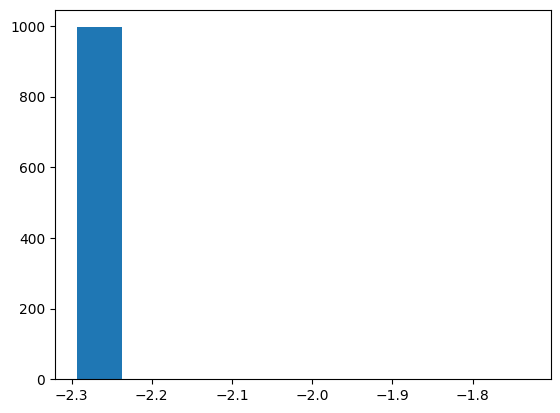

In [61]:
import jax
import numpyro
from numpyro.infer import MCMC, NUTS

import jax.numpy as jnp
import numpyro.distributions as dist

def metropolis_hastings(A, B1, B2, B3, num_samples):
    def model(A, B1, B2, B3):
        B = jnp.array([B1, B2, B3])
        mean = A * B
        return numpyro.sample('obs', dist.Normal(mean, 1.0))

    def proposal(B):
        # Randomly select one of B1, B2, or B3 to update
        idx = jax.random.randint(jax.random.PRNGKey(0), shape=(), minval=0, maxval=3)
        B_new = B.copy()
        B_new[idx] = numpyro.sample('B_new', dist.Normal(B[idx], 0.1))
        return B_new

    def acceptance_probability(B, B_new):
        log_prob_old = model(A, *B).log_prob(B[idx])
        log_prob_new = model(A, *B_new).log_prob(B_new[idx])
        return jnp.exp(log_prob_new - log_prob_old)

    B = jnp.array([B1, B2, B3])
    nuts_kernel = NUTS(proposal_model=proposal, target_accept_prob=0.6)
    mcmc = MCMC(nuts_kernel, num_samples=num_samples)
    mcmc.run(jax.random.PRNGKey(0), A, B)
    posterior_samples = mcmc.get_samples()
    return posterior_samples

# Example usage
A = 2.0
B1 = 1.0
B2 = 2.0
B3 = 3.0
num_samples = 1000

posterior_samples = metropolis_hastings(A, B1, B2, B3, num_samples)

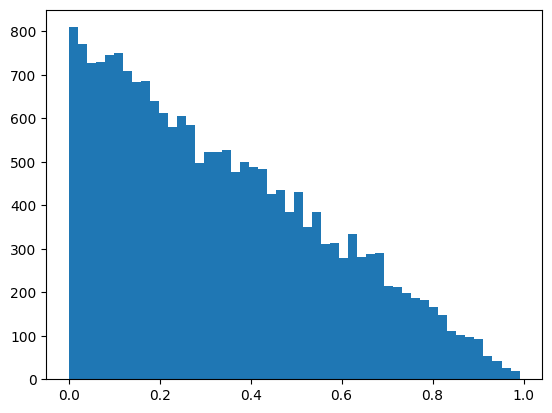

In [31]:
pl.hist(pd.read_csv('/mnt/extraspace/hollowayp/zBEAMS_data/chains/SL_orig_real_paltas_population_2_FP_wild_robs_FP.csv_ph_True_con_True_wCDM_JAX_chains_23_1_70837.csv')['P_tau_0_0'],
        bins=50)
pl.show()

In [57]:
import jax
import numpyro
from numpyro.infer import MCMC, NUTS

import jax.numpy as jnp
import numpyro.distributions as dist
import gc

# Define the model
def gaussian_model(data):
    mu = numpyro.sample('mu', dist.Normal(0, 10))
    sigma = numpyro.sample('sigma', dist.HalfNormal(10))
    z = numpyro.sample('z',dist.Uniform(-1,1),sample_shape=(1,len(data)))
    L = numpyro.factor('L',dist.Normal(z, 0.05).log_prob(0)+dist.Normal(mu,sigma).log_prob(data))

index = 0
def index_update(index):
    # global index
    # index +=1
    return index+1

def gaussian_model_with_z(data,z):
    # index = numpyro.param('index',0)
    mu = numpyro.sample('mu', dist.Normal(0, 10))
    sigma = numpyro.sample('sigma', dist.HalfNormal(10))
    # index = index_update(index)
    # print(index)
    # z = numpyro.sample('z',dist.Uniform(-1,1),sample_shape=(1,len(data)))
    L1 = 0# dist.Normal(z, 0.05).log_prob(0)
    L2 = dist.Normal(mu,sigma).log_prob(data)
    L = numpyro.factor('L',jnp.sum(L1)+jnp.sum(L2))

def model_with_index(data,z):
    # global index
    # index +=1
    # print(index)
    return gaussian_model_with_z(data,z)
# Generate some sample data from a Gaussian distribution
data = norm(loc=0,scale=1).rvs(1000)

# Run the inference
nuts_kernel = NUTS(gaussian_model_with_z)
mcmc = MCMC(nuts_kernel, num_samples=10, num_warmup=100)
mcmc.warmup(jax.random.PRNGKey(0),data=data,z=norm(loc=0,scale=0.05).rvs(size=(1,len(data))),collect_warmup=True)
mu_samples = []
for i in tqdm(range(100)):
    mcmc.post_warmup_state = mcmc.last_state
    mcmc.run(mcmc.post_warmup_state.rng_key, data=data,z=norm(loc=0,scale=0.05).rvs(size=(1,len(data))))
    raw_mcmc_samples = mcmc.get_samples(group_by_chain=True)
    mu_samples.append(float(raw_mcmc_samples['mu'][0][0]))
    # print(raw_mcmc_samples.keys())
    # del raw_mcmc_samples
    # gc.collect()
# Get the posterior samples
posterior_samples = mcmc.get_samples()

# Print the inferred parameters
print("Inferred mu:", posterior_samples['mu'].mean())
print("Inferred sigma:", posterior_samples['sigma'].mean())

 18%|█▊        | 18/100 [00:27<02:05,  1.53s/it]


KeyboardInterrupt: 

In [3]:
from scipy.stats import norm, uniform

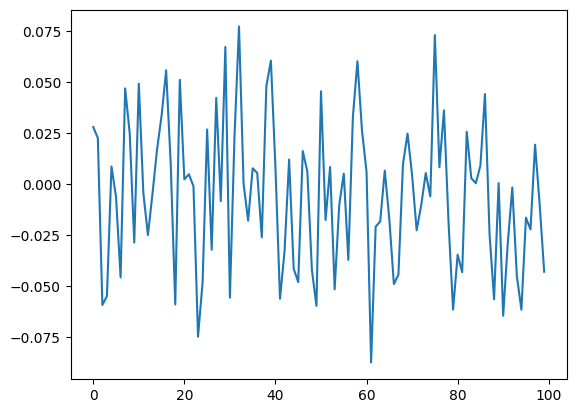

In [55]:
pl.plot(mu_samples)
pl.show()

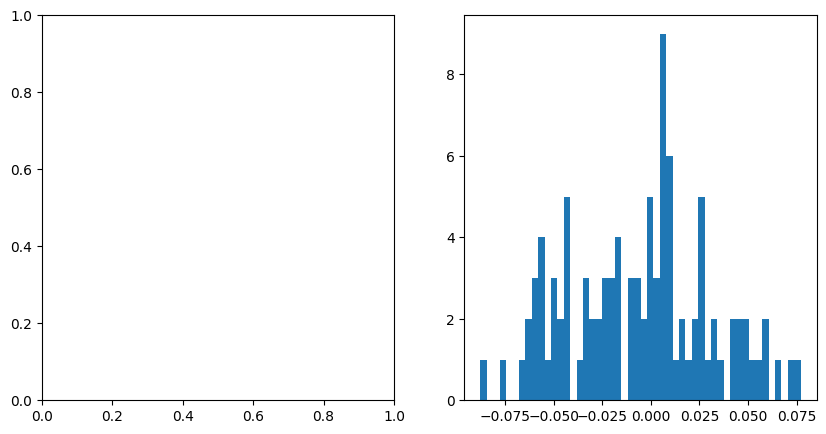

In [56]:
fig,ax = pl.subplots(1,2,figsize=(10,5))
# ax[0].hist(posterior_samples['z'][0])
# ax[1].hist(posterior_samples['mu'],bins=50)
ax[1].hist(mu_samples,bins=50)
pl.show()

In [8]:
glob.glob('./python3.11-50k_sample_B0_C*-*.out')

['./python3.11-50k_sample_B0_C1-79931.out',
 './python3.11-50k_sample_B0_C9-79939.out',
 './python3.11-50k_sample_B0_C6-79936.out',
 './python3.11-50k_sample_B0_C8-79938.out',
 './python3.11-50k_sample_B0_C0-79930.out',
 './python3.11-50k_sample_B0_C7-79937.out',
 './python3.11-50k_sample_B0_C4-79934.out',
 './python3.11-50k_sample_B0_C3-79933.out',
 './python3.11-50k_sample_B0_C5-79935.out',
 './python3.11-50k_sample_B0_C2-79932.out']

In [9]:
plot_JAX_corner?

Signature:
plot_JAX_corner(
    sampler_list,
    truth_dict={},
    range_dict={},
    label_dict={},
    bin_dict={},
    key_list=[],
    legend_list=[],
    plot_Ok=False,
    fig=None,
    ax=[],
    burnin=nan,
    hist_ylim=[],
    exclude_walker_list=[],
    add_text=True,
    color_list=['darkred', 'darkgreen', 'purple', 'darkblue', 'darkorange', 'magenta', 'red', 'green', 'blue', 'orange', 'black', 'cyan', 'yellow', 'brown', 'pink', 'grey'],
    alpha_hist2d=1.0,
    alpha_hist1d=1.0,
)
Docstring: <no docstring>
File:      ~/zBEAMS/plot_JAX_corner.py
Type:      function

In [ ]:
db_100k = pd.read_csv('./databases/real_paltas_population_TP_100000_FP_0_Spec_10000_P_1.0.csv')
db_100k_phot = pd.read_csv('./databases/real_paltas_population_TP_100000_FP_0_Spec_0_P_1.0.csv')
db_10k = pd.read_csv('./databases/real_paltas_population_TP_10000_FP_0_Spec_1000_P_1.0.csv')

In [ ]:
os.chdir('/mnt/users/hollowayp/zBEAMS')
likelihood_ratio_db = pd.read_csv('COSMIC_BEAMS_Likelihood_ratio_db.csv')
fig = pl.figure(figsize=(8,8))
columns_to_plot = ['OM','Ode','Ok','w','wa']
corner_dict = {'fig':fig,'labels':[label_dict[elem] for elem in columns_to_plot]}
truths_dict = {'truths':[Om_fid,Ode_fid,0,w_fid,wa_fid],
               'truth_color':'k'}
corner.corner(likelihood_ratio_db[columns_to_plot],
              weights=likelihood_ratio_db['ratio']/10,**corner_dict)
corner.corner(likelihood_ratio_db[columns_to_plot],**corner_dict,hist_kwargs={'edgecolor':'darkred'},color='darkred',**truths_dict)
fig.get_axes()[24].legend(['100k Sample (Reweighted)','10k Sample (Original Posterior)'],loc='lower center',fontsize=8)
pl.show()

In [ ]:
#THIS (Purposefully) GENERATES A FILE OF MAINLY FALSE POSITIVES!
db_10k_1kFP = pd.read_csv('/mnt/users/hollowayp/zBEAMS/databases/real_paltas_population_TP_10000_FP_1000_Spec_10000_P_0.9.csv')
db_1_1kFP = db_10k_1kFP[db_10k_1kFP['FP_bool']==1].reset_index(drop=True)
db_1_1kFP = pd.concat([db_1_1kFP,db_10k_1kFP[db_10k_1kFP['FP_bool']==0].sample(1)]).reset_index(drop=True)
db_1_1kFP['P_tau']= (1/len(db_1_1kFP))
db_1_1kFP.to_csv('/mnt/users/hollowayp/zBEAMS/databases/real_paltas_population_TP_1_FP_1000_Spec_1_P_0.csv',index=False)

In [ ]:
from scipy.stats import gaussian_kde
gaussian_kde(db_10k[['zL_true','zS_true','zL_obs','zS_obs']].T).pdf([0.3,0.7,0.3,0.7])

In [32]:
os.chdir('/mnt/users/hollowayp/zBEAMS/')
db_100k = pd.read_csv('./databases/real_paltas_population_TP_100000_FP_0_Spec_10000_P_1.0.csv')
db_100k_phot = pd.read_csv('./databases/real_paltas_population_TP_100000_FP_0_Spec_0_P_1.0.csv')
db_10k = pd.read_csv('./databases/real_paltas_population_TP_10000_FP_0_Spec_1000_P_1.0.csv')
db_10k_phot = pd.read_csv('/mnt/users/hollowayp/zBEAMS/databases/real_paltas_population_TP_10000_FP_0_Spec_0_P_1.0.csv')
db_100k_100kFP = pd.read_csv('/mnt/users/hollowayp/zBEAMS/databases/real_paltas_population_TP_100000_FP_100000_Spec_10000_P_0.5.csv')
# db_10k_1kFP = pd.read_csv('/mnt/users/hollowayp/zBEAMS/databases/real_paltas_population_TP_10000_FP_1000_Spec_0_P_0.9.csv')
# db_10k_1FP = db_10k_1kFP[db_10k_1kFP['FP_bool']==0].reset_index(drop=True)
# db_10k_1FP = pd.concat([db_10k_1FP,db_10k_1kFP[db_10k_1kFP['FP_bool']==1].sample(1)]).reset_index(drop=True)
# db_10k_1FP['P_tau']=1-(1/len(db_10k_1FP))
# db_10k_spec = db_100k[db_100k['spec']==1].reset_index(drop=True)
# db_10k_spec.to_csv('/mnt/users/hollowayp/zBEAMS/databases/real_paltas_population_TP_10000_FP_0_Spec_10000_P_1.0.csv')

In [28]:
FP_alpha_dist = numpyro_truncnorm_GMM_fit(db_100k_100kFP[db_100k_100kFP['FP_bool']==1]['r_obs_contam'].to_numpy(),N_comp=3)#,return_all_samples = True)

sample: 100%|██████████| 2000/2000 [05:05<00:00,  6.56it/s, 31 steps of size 8.44e-02. acc. prob=0.93] 


NB: JUST returning last sample of a single chain - am not taking the mean or median or anything


(0.0001434209237000032, 100, -4.78957010465161e-06, 0.492672380881797)
(0.0009059969697060041, 100, -0.0013532416009837782, 2.2378620402276574)


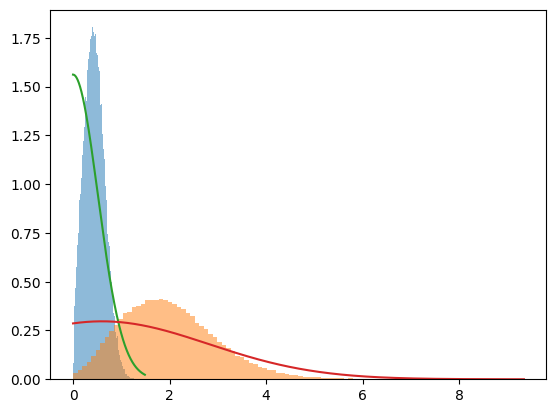

In [45]:
def fit_data_and_plot(data):
    X_plot = np.linspace(np.min(data),np.max(data),1000)
    print(truncnorm.fit(data,fb=100))
    pl.plot(X_plot,truncnorm(*truncnorm.fit(data)).pdf(X_plot))

pl.hist(db_100k_100kFP[db_100k_100kFP['FP_bool']==1]['zL_obs'],bins=100,density=True,alpha=0.5)
pl.hist(db_100k_100kFP[db_100k_100kFP['FP_bool']==1]['zS_obs'],bins=100,density=True,alpha=0.5)
fit_data_and_plot(db_100k_100kFP[db_100k_100kFP['FP_bool']==1]['zL_obs'])
fit_data_and_plot(db_100k_100kFP[db_100k_100kFP['FP_bool']==1]['zS_obs'])
pl.show()

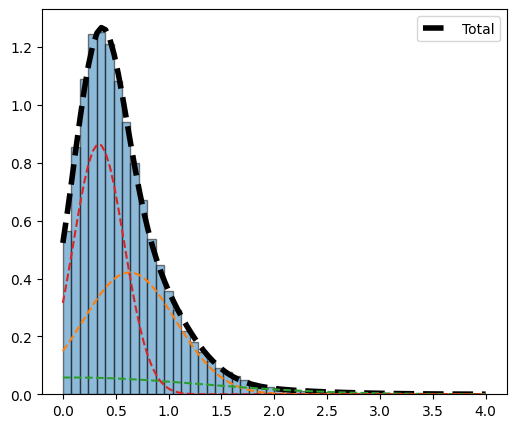

In [35]:
fig,ax = pl.subplots(1,figsize=(6,5))
ax.hist(db_100k_100kFP[db_100k_100kFP['FP_bool']==1]['r_obs_contam'],bins=np.linspace(0,4,51),density=True,alpha=0.5,edgecolor='k')
GMM_class(**FP_alpha_dist).plot(np.linspace(0,4,100),trunc_at_zero=True,ax=ax)
pl.show()

#### Likelihood Gradient: Mostly moved to /mnt/users/hollowayp/zBEAMS/COSMIC_BEAMS_Maximum_Likelihood_Solution.py

In [ ]:
pd.read_csv('./chains/SL_orig_real_paltas_population_TP_10000_FP_0_Spec_1000_P_1.0.csv_ph_True_con_False_wCDM_JAX_chains_8_363.csv')

In [ ]:
reload(sys.modules['mcmcfunctions_SL_JAX'])
from mcmcfunctions_SL_JAX import j_likelihood_SL,run_MCMC

In [ ]:
# reload(sys.modules['COSMIC_BEAMS_Maximum_Likelihood_Solution'])
from COSMIC_BEAMS_Maximum_Likelihood_Solution import likelihood_gradient

db_samp = db_100k#.sample(1000)
db_samp = db_samp[db_samp['spec']==0].reset_index(drop=True)
db_samp = db_samp.loc[np.random.choice(np.arange(len(db_samp)),size=100,replace=False)].reset_index(drop=True)

import warnings
with warnings.catch_warnings(action="ignore"):
    likelihood_gradient(Ok_val=1e-10,db_test=db_100k,no_parent=True).find_gradient()

#### Comparing likelihoods between datasets

In [ ]:
### Now moved to Likelihood_Ratio_Check.py

In [ ]:
import sys
import warnings
reload(sys.modules['mcmcfunctions_SL_JAX'])
from mcmcfunctions_SL_JAX import j_likelihood_SL,run_MCMC

try: del sys.modules['Likelihood_Ratio_Check'] 
except: pass
with warnings.catch_warnings(action="ignore"):
    from Likelihood_Ratio_Check import compare_likelihoods
    print(compare_likelihoods(db_10k,db_100k).compare_likelihoods_between_databases())

In [ ]:
import sys
import warnings
reload(sys.modules['mcmcfunctions_SL_JAX'])
from mcmcfunctions_SL_JAX import j_likelihood_SL,run_MCMC

try: del sys.modules['Likelihood_Ratio_Check'] 
except: pass
with warnings.catch_warnings(action="ignore"):
    from Likelihood_Ratio_Check import compare_likelihoods
    print(compare_likelihoods(db_10k_1FP).compare_likelihoods_for_contaminated_vs_not(0.3,0.1,-1,0))

In [ ]:
jnp.log(0.00000000)

#### Phot_Likelihood_Check

In [ ]:
import numpy as np
import jax.numpy as jnp
from jax.random import PRNGKey
import matplotlib.pyplot as pl
from zbeamsfunctions_SL import likelihood_phot_SL,likelihood_SL
from mcmcfunctions_SL_JAX import j_likelihood_SL,run_MCMC

def phot_likelihood_check():
    '''
    A function to verify if the likelihoods for the emcee and JAX MCMC methods are the same, in the case of a photometric but
    *uncontaminated* sample. 
    Results:
    The results are the same except for w and wa. These return nan's for certain values of w and wa, and differ from the emcee
    likelihood just before this. This may be due to the particular selection of cosmology parameters being unphysical (it 
    seems ok with OM=0.3, but not if OM=0). 

    '''
    assert False #Note this check will currently fail as I haven't implemented truncated gaussian distributions in the emcee version.
    likelihood_dict_default = {'H0':70,'OM':0, 'Ok':0, # The default is Om=0 and Ok = 0. This is so when one of them is updated
                               # in likelihood_dict below, it doesn't require Ode to be >1. Otherwise if I let Om or Ok vary between
                               # [0,1] and the other (Ok or Om) is non-zero by default, it would require Ode to be >1.
                                'w':-1,'wa':0,
                                'r_obs':jnp.array([1]),'sigma_r_obs':jnp.array([1]),
                                'zL':1,'zS':2,
                                'zL_obs':jnp.array([1]),'zS_obs':jnp.array([2]),
                                'zL_sigma':0.1,'zS_sigma':0.2,
                                'mu_zL_g_L':1.1,'mu_zS_g_L':2.2,
                                'sigma_zL_g_L':0.1,'sigma_zS_g_L':0.1,
                                'sigma_01_g_L':0,'sigma_10_g_L':0}
    def jax_likelihood(likelihood_dict,param_to_vary,param):
        likelihood_dict=likelihood_dict.copy()
        likelihood_dict[param_to_vary] = param
        return j_likelihood_SL(np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,
            cosmo_type='wCDM',
            photometric=True,
            contaminated=False,
            H0=likelihood_dict['H0'],
            key=PRNGKey(0),
            likelihood_check=True,
            likelihood_dict = likelihood_dict,
            cov_redshift=False)[0]

    def emcee_likelihood(likelihood_dict,param_to_vary,param):
        likelihood_dict=likelihood_dict.copy()
        likelihood_dict[param_to_vary] = param
        likelihood_dict['Ode'] = 1-(likelihood_dict['OM']+likelihood_dict['Ok']) #Renaming keys to the correct emcee argument names
        likelihood_dict['si_00_g_L'] = likelihood_dict['sigma_zL_g_L']
        likelihood_dict['si_11_g_L'] = likelihood_dict['sigma_zS_g_L']
        likelihood_dict['sigma_zL_obs'] = likelihood_dict['zL_sigma']
        likelihood_dict['sigma_zS_obs'] = likelihood_dict['zS_sigma']
        likelihood_dict['sigma_r_obs_1'] = likelihood_dict['sigma_r_obs']
        likelihood_dict['zL'] = np.array([likelihood_dict['zL']])
        likelihood_dict['zS'] = np.array([likelihood_dict['zS']])
        for k_i in ['Ok','sigma_zL_g_L','sigma_zS_g_L',
                    'zL_sigma','zS_sigma','sigma_r_obs',
                    'sigma_10_g_L','sigma_01_g_L']: #Removing redundant keys
            likelihood_dict.pop(k_i, None)
        return likelihood_phot_SL(**likelihood_dict,cosmo_type='wCDM')

    param_vary_dict = {
                        'zL':np.linspace(0.1,1,10),
                        'zS':np.linspace(1,2,10),
                        'zL_obs':np.linspace(0.1,1,10),
                        'zS_obs':np.linspace(1,2,10),
                        'r_obs':np.linspace(0,2,10),
                        'sigma_r_obs':np.linspace(0.5,5,10),
                        'zL_sigma':np.linspace(0.5,5,10),
                        'zS_sigma':np.linspace(0.5,5,10),
                        'OM':np.linspace(0,1,10),
                        'Ok':np.linspace(0,1,10),
                        'w':np.linspace(-6,4,100),
                        'wa':np.linspace(-3,1,100),
                        'mu_zL_g_L':np.linspace(0.5,5,10),
                        'mu_zS_g_L':np.linspace(0.5,5,10),
                        'sigma_zL_g_L':np.linspace(0.5,5,10),
                        'sigma_zS_g_L':np.linspace(0.5,5,10)
                        }
    for param_i in param_vary_dict.keys():
        L_jax = np.vectorize(jax_likelihood)(likelihood_dict_default,param_i,param_vary_dict[param_i])
        L_emcee = np.vectorize(emcee_likelihood)(likelihood_dict_default,param_i,param_vary_dict[param_i])
        try:
            assert (abs((L_jax-L_emcee)/L_jax)<0.01).all()
        except: 
            print(f'ASSERTION ERROR: {param_i}')
            pl.plot(param_vary_dict[param_i],L_jax,label='JAX')
            pl.plot(param_vary_dict[param_i],L_emcee,'--',label='emcee')
            pl.xlabel(param_i)
            pl.legend()
            pl.show()
    
#phot_likelihood_check()

In [ ]:
from importlib import reload
reload(sys.modules['mcmcfunctions_SL_JAX'])
reload(sys.modules['zbeamsfunctions_SL'])
from mcmcfunctions_SL_JAX import j_likelihood_SL,run_MCMC
from zbeamsfunctions_SL import likelihood_phot_SL,likelihood_SL

#### Spec_Likelihood_Check

In [ ]:
def spec_likelihood_check():
    '''
    A function to verify if the likelihoods for the emcee and JAX MCMC methods are the same, in the case of a spectroscopic but
    *uncontmainated* sample. 
    '''

    likelihood_dict_default = {'H0':70.0,'OM':0.0, 'Ok':0.0, # The default is Om=0 and Ok = 0. This is so when one of them is updated
                               # in likelihood_dict below, it doesn't require Ode to be >1. Otherwise if I let Om or Ok vary between
                               # [0,1] and the other (Ok or Om) is non-zero by default, it would require Ode to be >1.
                                'w':-1.0,'wa':0.0,
                                'r_obs':jnp.array([1.0]),'sigma_r_obs':jnp.array([1.0]),
                                'zL_obs':jnp.array([1.0]),'zS_obs':jnp.array([2.0])}
    def jax_likelihood(likelihood_dict,param_to_vary,param):
        likelihood_dict=likelihood_dict.copy()
        likelihood_dict[param_to_vary] = param
        #Spectroscopic so zL = zL_obs etc:
        likelihood_dict['zL'] = likelihood_dict['zL_obs']
        likelihood_dict['zS'] = likelihood_dict['zS_obs']
        return j_likelihood_SL(np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,
            cosmo_type='wCDM',
            photometric=False,
            contaminated=False,
            H0=likelihood_dict['H0'],
            key=PRNGKey(0),
            likelihood_check=True,
            likelihood_dict = likelihood_dict,
            cov_redshift=False,
            batch_bool=False)[0]

    def emcee_likelihood(likelihood_dict,param_to_vary,param):
        likelihood_dict=likelihood_dict.copy()
        likelihood_dict[param_to_vary] = param
        likelihood_dict['Ode'] = 1-(likelihood_dict['OM']+likelihood_dict['Ok']) #Renaming keys to the correct emcee argument names
        #likelihood_dict['sigma_zL_obs'] = likelihood_dict['zL_sigma']
        #likelihood_dict['sigma_zS_obs'] = likelihood_dict['zS_sigma']
        likelihood_dict['sigma_r_obs'] = likelihood_dict['sigma_r_obs']
        #Spectroscopic so zL = zL_obs etc:
        likelihood_dict['zL'] = np.array([likelihood_dict['zL_obs']])
        likelihood_dict['zS'] = np.array([likelihood_dict['zS_obs']])
        for k_i in ['Ok',
                    'sigma_zL_g_L','sigma_zS_g_L',
                    'zL_sigma','zS_sigma',
                    'sigma_zL_obs','sigma_zS_obs',
                    'zL_obs','zS_obs']: #Removing redundant keys
            likelihood_dict.pop(k_i, None)
        return likelihood_SL(**likelihood_dict,cosmo_type='wCDM',trunc_r=True)

    param_vary_dict = {
                        'w':np.linspace(-6,4,100),
                        'wa':np.linspace(-3,1,100),
                        'zL_obs':np.linspace(0.1,1,10),
                        'zS_obs':np.linspace(1,2,10),
                        'r_obs':np.linspace(0,2,10),
                        'sigma_r_obs':np.linspace(0.5,5,10),
                        'OM':np.linspace(0,1,10),
                        'Ok':np.linspace(0,1,10),
                        }
    for param_i in param_vary_dict.keys():
        L_jax = np.vectorize(jax_likelihood)(likelihood_dict_default,param_i,param_vary_dict[param_i])
        L_emcee = np.vectorize(emcee_likelihood)(likelihood_dict_default,param_i,param_vary_dict[param_i])
        try:
            assert (abs((L_jax-L_emcee)/L_jax)<0.01).all()
            print(f'Matching likelihoods: {param_i}')
        except: 
            print(f'ASSERTION ERROR: {param_i}')
            print(likelihood_dict_default)
            pl.plot(param_vary_dict[param_i],L_jax,label='JAX')
            pl.plot(param_vary_dict[param_i],L_emcee,'--',label='emcee')
            pl.xlabel(param_i)
            pl.legend()
            pl.show()
    
spec_likelihood_check()

In [ ]:
MCMC_JAX_i = run_MCMC(photometric = False,
            contaminated = False,
            cosmo_type = 'LambdaCDM',
            zL_obs = jnp.array(db_in['zL_obs']),
            zS_obs = jnp.array(db_in['zS_obs']),
            sigma_zL_obs = jnp.array(db_in['sigma_zL_obs']),
            sigma_zS_obs = jnp.array(db_in['sigma_zS_obs']),
            r_obs = jnp.array(db_in['r_obs_contam']),
            sigma_r_obs = jnp.array(db_in['sigma_r_obs']),
            sigma_r_obs_2 = 1000*jnp.max(jnp.array(db_in['sigma_r_obs'])),
            P_tau = 0.99*jnp.array(db_in['P_tau']),
            num_warmup = 1000,
            num_samples = 1000,
            num_chains = 2,
            H0=70,
            target_accept_prob=0.8,
            cov_redshift=False)

In [ ]:
from cosmology_JAX import D_LS_check,j_r_SL,j_D_LS,j_D_S,D_S_astr
from colossus.cosmology import cosmology as c_cosmo
w0_test = -1
wa_test = 0
z_plot = np.linspace(0,1,100)
colossus_cosmo = c_cosmo.fromAstropy(w0waCDM(
                                H0=70,
                                Om0=0,
                                Ode0=1, 
                                w0=w0_test,
                                Ob0 = 0,
                                wa=wa_test), sigma8 = 0.8, ns = 0.97, cosmo_name = 'colossus_cosmo')

fig = pl.figure(figsize=(7,5))
pl.plot(z_plot,D_S_astr(0.1,z_plot,cosmo = w0waCDM(
                                H0=70,
                                Om0=0,
                                Ode0=1, 
                                w0=w0_test,
                                wa=wa_test)),label='Astropy')
pl.plot(z_plot,colossus_cosmo.angularDiameterDistance(z_plot)/0.7,'--',label='Colossus')
pl.plot(z_plot,j_D_S(z_plot,j_cosmo = jc.Cosmology(
                            Omega_c=0.0,
                            h=70/100,
                            Omega_k=0.0,
                            w0=w0_test,
                            wa=wa_test,
                            Omega_b=0.0,sigma8 = 0.8, n_s=0.96)),'--',label='jax-cosmo')


pl.title(f'Angular Diameter Distance (w0: {w0_test},wa: {wa_test})',fontsize=18)
pl.xlabel('Redshift, z',fontsize=15)
pl.ylabel('Angular Diameter Distance (Mpc)',fontsize=15)
pl.legend()
pl.tight_layout()
pl.show()

#### Generate Inference Batches

In [ ]:
N_99 = 100;N_50 = 1800;N_1 = 4000
TP_99 = 0.99*N_99;FP_99 = 0.01*N_99
TP_50 = 0.5*N_50;FP_50 = 0.5*N_50
TP_1 = 0.01*N_1;FP_1 = 0.99*N_1

print('TP:',{'99':TP_99,'50':TP_50,'1':TP_1},'Total:',TP_99+TP_50+TP_1)
print('FP:',{'99':FP_99,'50':FP_50,'1':FP_1},'Total:',FP_99+FP_50+FP_1)

In [ ]:
db_100k[(db_100k['FP_bool']==1)&(db_100k['P_tau']<=0.01)]

In [ ]:
db_100k = pd.read_csv('./databases/real_paltas_population_TP_100000_FP_100000_Spec_10000_P_0.5_extrem.csv')

db_1k_5k = pd.concat([db_100k[db_100k['spec']==1].sample(99),
                      db_100k[(db_100k['FP_bool']==0)&(db_100k['P_tau']==0.5)].sample(900),
                      db_100k[(db_100k['FP_bool']==0)&(db_100k['P_tau']<=0.01)].sample(40),
                      #
                    db_100k[(db_100k['FP_bool']==1)&(db_100k['P_tau']==0.99)].sample(1),
                    db_100k[(db_100k['FP_bool']==1)&(db_100k['P_tau']==0.50)].sample(900),
                    db_100k[(db_100k['FP_bool']==1)&(db_100k['P_tau']<=0.01)].sample(3960)])
print(np.sum(db_1k_5k['FP_bool']==1),np.sum(db_1k_5k['FP_bool']==0),np.sum(db_1k_5k['spec']==1),
      np.mean(db_1k_5k['P_tau']),np.mean(db_1k_5k['FP_bool']==0))

# db_1k_5k.to_csv('./databases/real_paltas_population_TP_1039_FP_4861_Spec_99_P_0.2_extrem.csv')

addqueue -c '3hr' -m 30 -q gpulong --gputype rtx2080with12gb --gpus 1 /mnt/users/hollowayp/python114_archive/bin/python3.11  ./run_zBEAMS_JAX.py --filein ./databases/real_paltas_population_TP_5000_FP_5000_Spec_1000_P_0.5_extrem.csv --c True --p True --cosmo wCDM --num_chains 1 --target 0.99 --num_samples 2000 --num_warmup 2000 --no_parent --batch False --P_tau_dist --sigma_P_tau 0.2 --no_parent --trunc_zS --trunc_zL --lognorm_parent --bimodal_beta True --unimodal_beta False

In [ ]:
### Generating a dataset with no FPs and another with no photometry:

db_10k_50k = pd.read_csv('./databases/real_paltas_population_TP_10390_FP_48610_Spec_990_P_0.2.csv')

#Technically includes some photometric systems (400), but these are all low P_tau so shouldn't have an effect.
db_10k_50k_no_phot = db_10k_50k[(db_10k_50k['P_tau']>0.9) | \
                                (db_10k_50k['P_tau']<0.1)]

db_10k_50k_no_contam = db_10k_50k[db_10k_50k['FP_bool']==0]
db_10k_50k_no_contam['P_tau'] = np.max(db_10k_50k_no_contam['P_tau']) #Not exactly 1 but close enough.

output_file_no_phot = f"./databases/real_paltas_population_TP_{np.sum(db_10k_50k_no_phot['FP_bool']==0)}"+\
                          f"_FP_{np.sum(db_10k_50k_no_phot['FP_bool']==1)}_"+\
                          f"Spec_{np.sum(db_10k_50k_no_phot['spec'])}_"+\
                          f"P_{np.round(np.mean(db_10k_50k_no_phot['P_tau']))}"
print(f'Saving file to {output_file_no_phot}')
# db_10k_50k_no_phot.to_csv(output_file_no_phot)

output_file_no_contam = f"./databases/real_paltas_population_TP_{np.sum(db_10k_50k_no_contam['FP_bool']==0)}"+\
                          f"_FP_{np.sum(db_10k_50k_no_contam['FP_bool']==1)}_"+\
                          f"Spec_{np.sum(db_10k_50k_no_contam['spec'])}_"+\
                          f"P_{np.round(np.mean(db_10k_50k_no_contam['P_tau']))}"
print(f'Saving file to {output_file_no_contam}')
# db_10k_50k_no_contam.to_csv(output_file_no_contam)

In [ ]:
np.sum(db_10k_50k_no_phot['FP_bool'])

#### Generate Databases

In [ ]:
sys.path.append('/mnt/zfsusers/hollowayp/paltas')
from Load_LensPop_Euclid_db import db_LensPop_Euclid
db_LensPop_Euclid

In [ ]:
def r_obs_func(tE,vel_disp): #In arcsec and km/s
    tE = tE*(np.pi/180)*(1/3600) #Convert to radians
    vel_disp = vel_disp*1000 #convert to m/s
    c = 299792458 #m/s
    return (c**2)*tE/(4*np.pi*vel_disp**2)

from generate_catalogue_databases import generate_catalogue_databases

N_lens = 7500
#for N_obs_i in np.linspace(1000,10000,10):#2**np.arange(7,16):
for true_lens_frac in np.linspace(0.5,1,26):
    N_obs_i = int(N_lens/true_lens_frac)
    generate_catalogue_databases(db_LensPop_Euclid,
                             N_obs=N_obs_i,
                             true_lens_frac=true_lens_frac,
                             cosmo_type='wCDM',
                             Om_fid=Om_fid,
                             Ode_fid=Ode_fid,
                             H0_fid=H0_fid,
                             w_fid=w_fid,
                             wa_fid=wa_fid,
                             verbose=False,
                             absolute_error = 0.02,
                             db_name = 'LensPop_Euclid')

In [ ]:
#zL_obs=db_in['zL_obs'];zS_obs=db_in['zS_obs'];r_obs=db_in['r_obs'];sigma_r_obs=db_in['sigma_r_obs'] #Making these up!!!

from generate_databases import generate_databases

N_lens = 1000
#for N_obs_i in np.linspace(1000,10000,10):#2**np.arange(7,16):
for true_lens_frac in np.linspace(0.5,1,60):
    N_obs_i = int(N_lens/true_lens_frac)
    generate_databases(N_obs=N_obs_i,#int(N_obs_i),
                       true_lens_frac=true_lens_frac,#N_lens/N_obs_i,
                       #Percentage_error=5, This causes errors in the MCMC as the errors become very small for low redshift or r_obs.
                       absolute_error=0.01,
                       cosmo_type='wCDM',
                       Om_fid=Om_fid,
                       Ode_fid=Ode_fid,
                       H0_fid=H0_fid,
                       w_fid=w_fid,
                       wa_fid=wa_fid,
                       verbose=False)

'''#Note, need the backslash after VARIABLE (in the addqueue...)
print('for VARIABLE in {50..100..2}
do
addqueue -c '5min' -m 3 -n 5 -s -q blackhole /mnt/users/hollowayp/python11_env_new/bin/python3.11 ./run_zBEAMS.py ./databases/spectroscopic_db_1perc_100_samples_$VARIABLE\_true_cosmo_.csv True False wCDM 1000
done

for VARIABLE in 2 4 8 16 32 64 128 256 512 1024
do
addqueue -c '5min' -m 3 -n 5 -s -q blackhole /mnt/users/hollowayp/python11_env_new/bin/python3.11 ./run_zBEAMS.py ./databases/spectroscopic_db_1perc_$VARIABLE\_samples_100_true.csv False False wCDM 1000
done
'''

In [ ]:
#Spectroscopic no contamination: python3.11-725589.out and python3.11-725590.out
!addqueue -c '1hr' -m 2 -n 1x4 -s -q planet /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/spectroscopic_db_1perc_1024_samples_100_true_cosmo_wCDM.csv False False wCDM 2000 2
!addqueue -c '1hr' -m 2 -n 1x16 -s -q planet /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS.py ./databases/spectroscopic_db_1perc_1024_samples_100_true_cosmo_wCDM.csv False False wCDM 10000 
#Spectroscopic 20% Contamination: python3.11-725591.out and python3.11-725592.out
!addqueue -c '1hr' -m 2 -n 1x4 -s -q planet /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/spectroscopic_db_1perc_1024_samples_80_true_cosmo_wCDM.csv True False wCDM 1000 2
!addqueue -c '1hr' -m 2 -n 1x16 -s -q planet /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS.py ./databases/spectroscopic_db_1perc_1024_samples_80_true_cosmo_wCDM.csv True False wCDM 10000 
#Photometric, no contamination: python3.11-725593.out
!addqueue -c '1hr' -m 2 -n 1x16 -s -q planet /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/spectroscopic_db_1perc_1024_samples_100_true_cosmo_wCDM.csv False True wCDM 2000 2
#Photometric, with contamination: python3.11-725594.out
!addqueue -c '2hr' -m 2 -n 1x16 -s -q planet /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/spectroscopic_db_1perc_1024_samples_80_true_cosmo_wCDM.csv True True wCDM 2000 2
#100k sample: python3.11-725595.out
!addqueue -c '12hr' -m 10 -s -n 1x2 -q gpulong --gpus 1 /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/spectroscopic_db_1perc_100000_samples_80_true_cosmo_FlatLambdaCDM.csv True True wCDM 2000 1

#### Generate Realistic Databases

In [ ]:
training_config_directory

In [ ]:
import os
import sys
from importlib import import_module, reload
paltas_directory = '/mnt/zfsusers/hollowayp/paltas/'

sys.path.append(paltas_directory)
sys.path.append('/mnt/extraspace/hollowayp/paltas/paltas/Analysis/AnalysisConfigs')

analysis_folder = 'paltas.Analysis.AnalysisConfigs'
paltas_model_directory = '/mnt/extraspace/hollowayp/paltas_data/Example_LP_17/'
training_config_directory = f'{analysis_folder}.train_config_LSST_Lenspop' #Keep Updated!
paltas_training_directory = '/mnt/extraspace/hollowayp/paltas_data/Example_LP_17/'
paltas_test_directory = '/mnt/extraspace/hollowayp/paltas_data/Example_LP_18/' #= 20k LensPop Population

training_config = import_module(training_config_directory)
learning_params = training_config.learning_params
batch_size = training_config.batch_size
flip_pairs = training_config.flip_pairs
n_epochs = training_config.n_epochs
random_seed = training_config.random_seed
norm_images = training_config.norm_images
loss_function = training_config.loss_function
model_type = training_config.model_type
img_size = training_config.img_size
npy_folders_train = training_config.npy_folders_train

#Import training configs
from load_model import load_model,load_model_weights_list,return_final_epoch_weights,return_list_of_weight_files

col_dict = {'main_deflector_parameters_theta_E':'tE',
        'main_deflector_parameters_gamma1':'g1',
        'main_deflector_parameters_gamma2':'g2',
        'main_deflector_parameters_gamma':'gamma'}

def retrieve_test_catalogue():
        sys.path.append(paltas_test_directory)
        from test.config_LensPop_catalogue_no_subtr.py import Catalogue_directory
        return Catalogue_directory


In [ ]:
model_dict = {} 
for ii,epoch_i_weights in tqdm(enumerate([return_list_of_weight_files(paltas_model_directory)[-1]])): #Just getting the most recent epoch
#for ii,epoch_i_weights in tqdm(enumerate(return_list_of_weight_files(paltas_model_directory))): #Just getting the most recent epoch
    if ii==0:
        model,loss_func,num_params = load_model(epoch_i_weights,loss_function,learning_params=learning_params,\
                             log_learning_params=[],model_type=model_type,img_size=img_size)
        model_dict[ii]=model
    else: 
        model,_,_ = load_model(epoch_i_weights,loss_function,learning_params=learning_params,\
                        log_learning_params=[],model_type=model_type,img_size=img_size)
        model_dict[ii]=model

In [ ]:
def retrieve_test_catalogue():
    config_filename = glob.glob(paltas_test_directory+'/test/*.py')[0]
    print(f'Retrieving catalogue config from {config_filename}')
    with open(config_filename,'r') as f:
        for line in f:
            if 'Catalogue_directory' in line:
                c_dir = eval(line.split('=')[-1].strip())
                print('Catalogue Directory:',c_dir)
                return c_dir

LensPop_catalogue_db = pd.read_csv(retrieve_test_catalogue())

In [ ]:
# !python3 -m pip install tensorflow

In [ ]:
try:reload(sys.modules['generate_predictions'])
except Exception as ex: print('Reload failed', ex)
from generate_predictions import gen_network_predictions_single,gen_network_predictions_general

_,model_predictions_mu,model_predictions_std,model_predictions_prec = gen_network_predictions_general(
                                test_folder = f'{paltas_test_directory}/test',
                                norm_path = glob.glob(f'{paltas_training_directory}/**/norm*',recursive=True)[0],
                                learning_params=learning_params,
                                log_learning_params=[],
                                loss_type=loss_function,
                                loss_func=loss_func,
                                model=model_dict[0],
                                norm_images=norm_images,
                                log_norm_images=False,
                                h5_or_not='False',
                                diag_cov = (loss_function=='diag'))

# gen_network_predictions_single(
#     npy_file = f'{paltas_test_directory}/test',
#     input_norm_path=glob.glob(f'{paltas_training_directory}/**/norm*',recursive=True)[0],
#                             learning_params=learning_params,
#                             log_learning_params=[],
#                             loss_type=loss_function,
#                             loss_func=loss_func,
#                             model=model_dict[0],
#                             norm_images=norm_images,log_norm_images=False,
#                             return_cov=False,
#                             h5=False,
#                             numpy_folder=True)

#Renaming columns and just selecting the useful ones:
model_predictions_mu = pd.DataFrame(model_predictions_mu,columns=learning_params).rename(col_dict,axis=1)[col_dict.values()]      
model_predictions_std = pd.DataFrame(model_predictions_std,columns=learning_params).rename(col_dict,axis=1)[col_dict.values()]


In [ ]:
groundtruth_db = pd.read_csv(f'{paltas_test_directory}/test/metadata.csv')
groundtruth_db.rename(col_dict,axis=1)

#NB: Need the '.tolist()' affix, as otherwise the different databases keep their original indices, which messes up the ordering of the elements:
paltas_zBEAMS_db = pd.DataFrame({
    'zL':np.array(groundtruth_db['main_deflector_parameters_z_lens'].tolist()).astype('float64'),
    'zL_0':np.array(LensPop_catalogue_db.loc[groundtruth_db['Catalogue_Index']]['zL'].tolist()).astype('float64'),
    'zS':groundtruth_db['source_parameters_z_source'].tolist(),
    'tE':groundtruth_db['main_deflector_parameters_theta_E'].tolist(),
    'Re':groundtruth_db['lens_light_parameters_R_sersic'].tolist(),
    'vel_disp':LensPop_catalogue_db.loc[groundtruth_db['Catalogue_Index']]['sig_v'].tolist(),
    'sigma_tE':model_predictions_std['tE'].tolist(), 
})
assert (np.round(paltas_zBEAMS_db['zL'],5)==np.round(paltas_zBEAMS_db['zL_0'],5)).all() #Checking the indexing has worked. Rounding to prevent floating point errors.

In [ ]:
#Values taken from the SLACS X Paper:
a = 1.02
b = -0.872

def Re_kpc_func(Re=1,z_in=1): #Re in arcsec
    return (FlatLambdaCDM(70,0.3).angular_diameter_distance(z_in)*Re*(np.pi/180)*(1/3600)).to('kpc')

def I_func(m,z,Re_arc):
    return (10**(-0.4*m))*\
            ((1+z)**4)/(2*np.pi*Re_arc**2)

def delta_I_func(Ie,dz,z,dRe_arc,Re_arc,dm):
    return Ie*np.sqrt((
        (4*dz/(1+z))**2+\
        (2*dRe_arc/Re_arc)**2+\
        (0.4*np.log(10)*dm)**2))

def delta_Re_kpc_func(Re_arc,dRe_arc,z,dz):
    return np.std(Re_kpc_func(norm(Re_arc,dRe_arc).rvs(1000),
                                       norm(z,dz).rvs(1000))).value

def delta_sigma(sigma,m,dm,Re_arc,dRe_arc,z,dz,sigma_int): #final kwarg is intrinsic scatter in FP.
    # print('Calculating veldisp Uncertainty')
    # print('Inputs:')
    # print('Sigma',np.median(sigma))
    # print('Re_arc',np.median(Re_arc))
    # print('dRe_arc',np.median(dRe_arc))
    # print('z',np.median(z))
    # print('dz',np.median(dz))
    # print('Sigma int',np.median(sigma_int))
    Ie = I_func(m,z,Re_arc)
    dIe = delta_I_func(Ie,dz,z,dRe_arc,Re_arc,dm)
    Re_kpc = Re_kpc_func(Re_arc,z).value
    dRe_kpc = np.vectorize(delta_Re_kpc_func)(Re_arc,dRe_arc,z,dz)
    Re_err = dRe_kpc/(a*Re_kpc)
    surf_brightness_err = dIe*b   /(a*Ie    )
    # print('Re_err',np.median(abs(sigma*Re_err)),'surf_brightness_err',np.median(abs(sigma*surf_brightness_err)),'Intrinsic',np.median(sigma_int))
    delta_sigma = np.sqrt(sigma**2*(Re_err**2+surf_brightness_err**2)+\
                sigma_int**2)
    if (delta_sigma>1000).any():
        try:
            print('Unrealistically large vel-disp uncertainty')
            indx_large = np.where(delta_sigma>1000)
            print('Redshift:',z[indx_large])
            print('dz',dz[indx_large])
            print('sigma:',sigma[indx_large])
            print('Re_arc',Re_arc[indx_large])
            #print('dRe_arc',dRe_arc[indx_large])
        except Exception as ex: print("Exception:",ex) 
    return delta_sigma

def plot_vel_disp_uncertainties(sigma = 300, #km/s
                                d_sigma_dex_int = 0.05, #Intrinsic scatter
                                z_true = 0.5,
                                dz_true =  0.04,
                                R_arcsec_true = 0.9,
                                dR_arcsec_true = 0.1,
                                m_true = 40, #Arbitrary as Ie cancels out.
                                dm_true =  0.1):
    fig,ax = pl.subplots(1,figsize=(7,5))
    dz_plot = np.linspace(0,1,100)
    dm_plot = np.linspace(0,1,100)
    dR_plot = np.linspace(0,1,100)
    ax.plot(dz_plot,delta_sigma(sigma=sigma,
                m = m_true,
                dm = dm_true,
                Re_arc = R_arcsec_true,
                dRe_arc = dR_arcsec_true,
                z = z_true,
                dz = dz_plot,
                sigma_int = sigma*10**d_sigma_dex_int-sigma
                ),label='$\Delta z$')
    ax.plot(dm_plot,delta_sigma(sigma=sigma,
                m = m_true,
                dm = dm_plot,
                Re_arc = R_arcsec_true,
                dRe_arc = dR_arcsec_true,
                z = z_true,
                dz = dz_true,
                sigma_int = sigma*10**d_sigma_dex_int-sigma
                ),label='$\Delta m$')
    ax.plot(dR_plot,delta_sigma(sigma=sigma,
                m = m_true,
                dm = dm_true,
                Re_arc = R_arcsec_true,
                dRe_arc = dR_plot,
                z = z_true,
                dz = dz_true,
                sigma_int = sigma*10**d_sigma_dex_int-sigma
                ),label='$\Delta R$')
    Intrinsic_Scatter = sigma*10**d_sigma_dex_int-sigma
    ax.plot([0,1],[Intrinsic_Scatter]*2,label='Intrinsic Scatter')
    pl.xlabel('Variable Uncertainty [m, $z_{lens}$, R (arcsec)]',fontsize=15)
    pl.ylabel('$\Delta \sigma$  (km/s)',fontsize=15)
    pl.tick_params(labelsize=15)
    pl.legend(fontsize=12)
    pl.ylim(0,200)
    pl.xlim(0,1)
    pl.show()

plot_vel_disp_uncertainties()

In [ ]:
np.median(paltas_zBEAMS_db['Re'])

In [ ]:
np.median(paltas_zBEAMS_db['zL'])

In [ ]:
0.02*(1+0.4)

In [ ]:
delta_sigma(280,10,0.1,0.9,0.1,0.4,0.028,280*10**0.05-280)

In [ ]:
from scipy.stats import gaussian_kde
class generate_realistic_zBEAMS_db:
    def __init__(self,
                 paltas_db_orig,
                 inc_spectroscopic = False,#Don't think this does anything?
                 N_spec = 10000,
                 inc_FP=False, #Don't think this does anything?
                 N_FP = 10000,
                 N_TP=None,
                contam = True,
                isothermal = True,
                sigma_tE_TP_meas = None, # Measurement uncertainty in Einstein radius for true positive population. If not specified, uses paltas db uncertainties. 
                mu_tE_FP_pop = None, #Mean of Einstein radius for false positive population
                sigma_tE_FP_pop = None, #Scatter in Einstein radius for false positive population
                sigma_tE_FP_meas = None, #Measurement uncertainty in Einstein radius for false positive population 
                cosmo_dict = {'h':H0_fid,'Omega_c':Om_fid,'Omega_k':1-(Om_fid+Ode_fid),'w0':w_fid,'wa':wa_fid,
                              'Omega_b':0.0,'sigma8':0.8,'n_s':0.96},
                spec_z_error = 0.001, #This is a random number at the moment - need to find a reference!!
                spec_veldisp_error = 10, #km/s From Li 2023 4MOST uncertainty
                sigma_r_obs = None,
                gaussian=False
                ):
        self.seed = 1
        np.random.seed(self.seed)
        #self.TP_indx = np.random.choice(np.arange(len(paltas_db)),size=N_TP,replace=False)
        self.seed+=1; np.random.seed(self.seed)
        #self.TP_indx.sort()
        self.paltas_db_orig = paltas_db_orig.drop('zL_0',axis=1)
        self.inc_spectroscopic = inc_spectroscopic
        self.N_spec = N_spec
        self.inc_FP = inc_FP 
        self.N_FP = N_FP
        self.N_TP = N_TP
        #self.zL_TP = np.array(self.paltas_db['zL'])[self.TP_indx]
        #self.zS_TP = np.array(self.paltas_db['zS'])[self.TP_indx]
        #self.tE_TP = np.array(self.paltas_db['tE'])[self.TP_indx] #Think this should be the TRUE tE, not the observed one?
        self.isothermal = isothermal
        self.mu_tE_FP_pop = mu_tE_FP_pop
        self.sigma_tE_FP_pop = sigma_tE_FP_pop
        self.sigma_tE_FP_meas = sigma_tE_FP_meas
        self.sigma_tE_TP_meas = sigma_tE_TP_meas
        self.cosmo_dict = cosmo_dict
        self.spec_z_error = spec_z_error
        self.spec_veldisp_error = spec_veldisp_error
        self.contam = contam
        self.sigma_r_obs = sigma_r_obs
        #if N_TP is None: self.N_TP = len(paltas_db)-self.N_FP
        assert N_TP is not None
        self.N_phot = self.N_TP-self.N_spec
        assert (N_spec>=0) and (self.N_phot>=0)
        assert (N_FP>=0) and (N_TP>=0)
        self.gaussian=gaussian
        print(f'Generating a realistic database, with {self.N_TP} true lensed systems and {self.N_FP} false positives.')
        print(f'The database assumes the mass model is {~self.isothermal*"not "}isothermal.')
        print(f'Assuming an input cosmology of {self.cosmo_dict}')

    def generate_resampled_kde_paltas_db(self,return_db=False):
        self.seed+=1
        np.random.seed(self.seed)
        #Sampling twice as much data as needed - this is then down-selected here
        resampled_data = gaussian_kde(self.paltas_db_orig.T).resample(size=2*self.N_TP)
        resampled_dict = {k_i:resampled_data[i] for i,k_i in enumerate(self.paltas_db_orig.columns)}
        self.paltas_db = pd.DataFrame(resampled_dict)
        suitable_indx = np.arange(len(self.paltas_db))
        #Now adding cuts to make sure the population is realistic (i.e. that the extreme values in each property are no more extreme than in the LensPop population):
        for prop_i in self.paltas_db_orig.columns:
            print(len(suitable_indx))
            assert prop_i in self.paltas_db.columns
            suitable_indx = np.intersect1d(suitable_indx,
                                np.where((np.min(self.paltas_db_orig[prop_i])<self.paltas_db[prop_i]) & \
                                         (self.paltas_db[prop_i]<np.max(self.paltas_db_orig[prop_i])))[0])
        #Also requiring zL<zS:
        print(len(suitable_indx))
        suitable_indx = np.intersect1d(suitable_indx,np.where(self.paltas_db['zL']<self.paltas_db['zS'])[0])
        print(len(suitable_indx))
        self.paltas_db = self.paltas_db.loc[suitable_indx].reset_index(drop=True)
        self.zL_TP = np.array(self.paltas_db['zL'])
        self.zS_TP = np.array(self.paltas_db['zS'])
        self.tE_TP = np.array(self.paltas_db['tE']) 
        self.generate_r_obs_TP_values() #=> r_TP
        #Generating vel-disp measurements so can down-select based on vel-disp too:
        self.derive_veldisp() #=> veldisp_TP, veldisp_FP
        #Now requiring reasonable velocity dispersions
        suitable_indx_sigv = np.where((np.min(self.paltas_db_orig['vel_disp'])<self.veldisp_TP) & \
                                      (self.veldisp_TP<np.max(self.paltas_db_orig['vel_disp'])))[0]
        print(len(suitable_indx_sigv))
        #Now only selecting the correct number of systems from the set of suitable ones: 
        random_system_indx = np.random.choice(suitable_indx_sigv,replace=False,size=self.N_TP)
        self.paltas_db = self.paltas_db.iloc[random_system_indx].reset_index(drop=True)
        self.zL_TP = np.array(self.paltas_db['zL'])
        self.zS_TP = np.array(self.paltas_db['zS'])
        self.tE_TP = np.array(self.paltas_db['tE'])
        self.r_TP = self.r_TP[random_system_indx]
        self.veldisp_TP = self.veldisp_TP[random_system_indx]
        if return_db: return self.paltas_db

    def generate_resampled_gaussian_paltas_db(self,return_db=False):
        print('USING TOY SINGLE-GAUSSIAN APPROXIMATION')
        self.paltas_db = make_gaussian_redshifts(2*self.N_TP).return_db() #Making twice as much data as needed, so can down-select.
        self.zL_TP = np.array(self.paltas_db['zL'])
        self.zS_TP = np.array(self.paltas_db['zS'])
        self.tE_TP = np.array(self.paltas_db['tE']) 
        self.generate_r_obs_TP_values() #=> r_TP
        #Generating vel-disp measurements so can down-select based on vel-disp too:
        self.derive_veldisp() #=> veldisp_TP, veldisp_FP
        #Now requiring reasonable velocity dispersions
        suitable_indx_sigv = np.where((np.min(self.paltas_db_orig['vel_disp'])<self.veldisp_TP) & \
                                      (self.veldisp_TP<np.max(self.paltas_db_orig['vel_disp'])))[0]
        print(len(suitable_indx_sigv))
        #Now only selecting the correct number of systems from the set of suitable ones: 
        random_system_indx = np.random.choice(suitable_indx_sigv,replace=False,size=self.N_TP)
        self.paltas_db = self.paltas_db.iloc[random_system_indx].reset_index(drop=True)
        self.zL_TP = np.array(self.paltas_db['zL'])
        self.zS_TP = np.array(self.paltas_db['zS'])
        self.tE_TP = np.array(self.paltas_db['tE'])
        self.r_TP = self.r_TP[random_system_indx]
        self.veldisp_TP = self.veldisp_TP[random_system_indx]
        if return_db: return self.paltas_db

    def Gaussian_truncated_at_zero(self,loc,scale,size):
        self.seed+=1
        np.random.seed(self.seed)
        return truncnorm(a=-loc/scale,b=np.inf,loc=loc,scale=scale).rvs(size=size)

    def Gaussian_truncated_at_lower_limit(self,loc,scale,size,lower_limit):
        self.seed+=1
        np.random.seed(self.seed)
        return truncnorm(a=-(loc-lower_limit)/scale,b=np.inf,loc=loc,scale=scale).rvs(size=size)
    
    def generate_z_FP_distributions(self):
        '''
        Drawing the false positive redshift distribution from the same distribution as the true positives. Do I want to do this?????? Need to make sure FP's don't give
        useful information!!
        Prerequisites: None
        Returns: zL_FP, zS_FP
        '''
        if self.N_FP>0:
            self.zL_FP = self.Gaussian_truncated_at_lower_limit(np.mean(self.paltas_db['zL']),
                                                    np.std(self.paltas_db['zL']),
                                                    size=self.N_FP,
                                                    lower_limit = np.min(self.paltas_db['zL'])) #Adding minimum otherwise veldisp uncertainty becomes unrealistically large.
            self.zS_FP = self.Gaussian_truncated_at_lower_limit(np.mean(self.paltas_db['zS']),
                                                    np.std(self.paltas_db['zS']),
                                                    size=self.N_FP,
                                                    lower_limit = self.zL_FP)
        else: self.zL_FP = np.array([]); self.zS_FP = np.array([])

    def generate_zL_uncertainty(self):
        '''
        Using uncertainty estimates from Graham et al. 2018 ('Photometric Redshifts with the LSST...'), Table 1.
        NB: Uses the same lens redshift uncertainty for the false positives:
        Prerequisites: zL_TP, zL_FP
        Returns: sigma_zL_TP, sigma_zL_FP
        '''
        robust_stan_dev = 0.02 
        # Using definition from Sec. 3.2 in Graham (2018) paper. Have replaced z_phot with z_true in this case for simplicity,
        # which I don't think should make any major difference.
        self.sigma_zL_TP = robust_stan_dev*(1+self.zL_TP)
        if self.N_FP>0: self.sigma_zL_FP = robust_stan_dev*(1+self.zL_FP)
        else: self.sigma_zL_FP = np.array([])
    
    def generate_zS_uncertainty(self):
        self.seed+=1
        np.random.seed(self.seed)
        '''
        Using uncertainty estimates from Langeroodi, tested on real HSC data:
        Found ~2/3 of systems (=15) have outlier fraction of 20% and scatter (dz/(1+z)) = 0.089.
        Found ~1/3 of systems (=8) have outlier fraction of 75% and scatter (d/(1+z)) = 0.312.
        NB: Uses the same uncertainty for the False Positives too.
        Prerequisites: zS_TP, zS_FP, N_TP, N_FP
        Returns: sigma_zS_TP, sigma_zS_FP
        '''
        high_zS_error_bool_TP = np.random.choice([0,1],p=[2/3,1/3],size=self.N_TP)
        self.seed+=1; np.random.seed(self.seed)
        # Where True, returns high uncertainty sigma, else returns low uncertainty sigma:
        self.sigma_zS_TP = (1+self.zS_TP)*np.where(high_zS_error_bool_TP,0.312,0.089)
        if self.N_FP>0:
            high_zS_error_bool_FP = np.random.choice([0,1],p=[2/3,1/3],size=self.N_FP)
            self.seed+=1; np.random.seed(self.seed)
            self.sigma_zS_FP = (1+self.zS_FP)*np.where(high_zS_error_bool_FP,0.312,0.089)
        else: self.sigma_zS_FP = np.array([])
    
    def derive_veldisp(self):
        '''
        For the purposes of maintaining a self-consistent cosmology, the velocity dispersion values are calculated using the redshifts + assumed cosmology + Einstein radii
        values, rather than determining them from the fundamental plane directly.  
        Prerequisites: zL_TP, zS_TP, tE_TP, r_TP
        Returns: veldisp_TP, veldisp_FP
        '''
        def vel_disp_from_r_isothermal(r,zL,zS,tE):
            c = 299792458 #m/s
            tE_rad = tE*(np.pi/180)*(1/3600) #Convert to radians
            return np.sqrt((c**2)*tE_rad/(4*np.pi*r))/1000 #Convert to km/s
        if self.isothermal:
            self.veldisp_TP = vel_disp_from_r_isothermal(self.r_TP,self.zL_TP,self.zS_TP,self.tE_TP)
        '''
        Assuming the velocity dispersion of false positives follows the same distribution as the lens distribution from LensPop:
        '''
        if self.N_FP>0:
            LensPop_veldisp_mu = np.mean(self.paltas_db['vel_disp'])
            LensPop_veldisp_std = np.std(self.paltas_db['vel_disp'])
            self.veldisp_FP = self.Gaussian_truncated_at_zero(LensPop_veldisp_mu,LensPop_veldisp_std,size=self.N_FP)
        else: self.veldisp_FP = np.array([])

    def generate_veldisp_uncertainty_from_fundamental_plane(self):
        '''
        Velocity dispersions uncertainties inferred from the expected scatter in the Fundamental Plane.
        Prerequisites: veldisp_TP, veldisp_FP, zL_TP, zL_FP, sigma_zL_TP, sigma_zL_FP
        Returns: sigma_veldisp_TP, sigma_veldisp_FP
        '''
        self.sigma_veldisp_TP = delta_sigma(sigma = self.veldisp_TP,
                                            m = 40, # Arbitrary as Ie cancels out
                                            dm = 0.1, # Random number but looks like its on the pessimistic side so should be ok?
                                            Re_arc = np.array(self.paltas_db['Re']),#[self.TP_indx],
                                            dRe_arc = 0.1, # Also slightly random, but is half the pixel size so also plausible?
                                            z = self.zL_TP,
                                            dz = self.sigma_zL_TP,
                                            sigma_int = (self.veldisp_TP*10**0.05)-self.veldisp_TP)
        if self.N_FP>0:
            self.sigma_veldisp_FP = delta_sigma(sigma = self.veldisp_FP,
                                            m = 40, # Arbitrary as Ie cancels out
                                            dm = 0.1, # Random number but looks like its on the pessimistic side so should be ok?
                                            Re_arc = self.Gaussian_truncated_at_lower_limit(np.mean(self.paltas_db['Re']),
                                                                                     np.std((self.paltas_db['Re'])),
                                                                                     size=self.N_FP,
                                                                                     lower_limit = 0.2, #Close to minimum in LensPop distribution. Too small means veldisp uncertainties become unrealistically large.
                                                                                     ), #Setting R_eff equal to R_eff distribution of true lenses.
                                            dRe_arc = 0.1, # Also slightly random, but is half the pixel size so also plausible?
                                            z = self.zL_FP,
                                            dz = self.sigma_zL_FP,
                                            sigma_int = (self.veldisp_FP*10**0.05)-self.veldisp_FP)
        else: self.sigma_veldisp_FP = np.array([])
        #zL_TP,zL_FP

    def generate_tE_uncertainty(self):
        '''
        Using outputs from paltas
        Prerequisites: mu_tE_FP_pop, sigma_tE_FP_pop, sigma_tE_FP_meas
        Returns: tE_FP, sigma_tE_FP, sigma_tE_TP
        '''
        # True Positives:
        if self.sigma_tE_TP_meas is None:
            print('NOTE: Using tE uncertainty from paltas db')
            self.sigma_tE_TP = np.array(self.paltas_db['sigma_tE'])#[self.TP_indx])
        else: 
            print('Using fixed tE uncertainty from input kwargs')
            self.sigma_tE_TP = self.sigma_tE_TP_meas*np.ones(self.N_TP)
        # False Positives:
        if (self.contam==True) or self.N_FP>0: 
            assert (self.mu_tE_FP_pop is not None) and (self.sigma_tE_FP_pop is not None) and (self.sigma_tE_FP_meas is not None)
        if self.N_FP>0:
            self.tE_FP = self.Gaussian_truncated_at_zero(self.mu_tE_FP_pop,self.sigma_tE_FP_pop,size=self.N_FP)
            self.sigma_tE_FP = self.sigma_tE_FP_meas
        else: self.tE_FP = np.array([]);self.sigma_tE_FP = np.array([])

    def generate_r_obs_TP_values(self):
        '''
        Uncertainty calculated from uncertainties in Einstein radius and velocity dispersion.
        Prerequisites: zL_TP, zS_TP
        Returns: r_TP
        '''
        if self.isothermal:
            #self.r_TP = r_SL(np.array(self.zL_TP),np.array(self.zS_TP),cosmo = w0waCDM(**self.cosmo_dict))
            self.r_TP = j_r_SL(np.array(self.zL_TP),np.array(self.zS_TP),j_cosmo = jc.Cosmology(**self.cosmo_dict))
        else:
            assert False #Need to implement this
            # self.r_TP = 

    def generate_r_obs_TP_uncertainty(self):
        '''
        Prerequisites: r_TP, sigma_tE_TP, tE_TP, sigma_veldisp_TP, veldisp_TP
        Returns: sigma_r_TP
        '''
        if self.isothermal:
            if self.sigma_r_obs is None:
                self.sigma_r_TP = self.r_TP * np.sqrt((self.sigma_tE_TP/self.tE_TP)**2 + (2*self.sigma_veldisp_TP/self.veldisp_TP)**2)
            else: 
                print('Using FIXED value of sigma_r_obs')
                self.sigma_r_TP = self.sigma_r_obs*np.ones(self.N_TP)
        else:
            assert False #Need to implement this
            # self.sigma_r_TP =  #Not sure I can just use the same uncertainty equation as above.

    def generate_r_obs_FP_values(self):
        '''
        Prerequisites: tE_FP, veldisp_FP, sigma_tE_FP, tE_FP, sigma_veldisp_FP, veldisp_FP
        Returns: r_FP, sigma_r_FP
        '''
        def r_LHS_isothermal(tE,sig_v):
            c = 299792458 #m/s
            tE_rad = tE*(np.pi/180)*(1/3600) #Convert to radians
            sig_v_SI = sig_v*1000 #convert to m/s from km/s
            return (c**2)*tE_rad/(4*np.pi*sig_v_SI**2)
        if self.N_FP>0:
            if self.isothermal:
                self.r_FP = r_LHS_isothermal(self.tE_FP,self.veldisp_FP)
                if self.sigma_r_obs is None:
                    self.sigma_r_FP = self.r_FP * np.sqrt((self.sigma_tE_FP/self.tE_FP)**2 + (2*self.sigma_veldisp_FP/self.veldisp_FP)**2)
                else:
                    print('Using FIXED value of sigma_r_obs')
                    self.sigma_r_FP = self.sigma_r_obs*np.ones(self.N_FP)
            else:
                assert False #Need to implement this.
        else: self.r_FP = np.array([]);self.sigma_r_FP = np.array([])

    def assign_spectroscopic_systems(self):
        '''
        Prerequisites: zS_TP, sigma_zL_TP, sigma_zS_TP, sigma_veldisp_TP
        Returns: Updated sigma_zL_TP, sigma_zS_TP, sigma_veldisp_TP, and also r_TP, sigma_r_TP (via generate_r_obs_TP_values)
        '''
        # Also need to adjust errors (redshift, vel_disp and r_obs) for spectroscopic systems.
        self.seed+=1
        np.random.seed(self.seed)
        FourMOST_bool = self.zS_TP<1.5 # 4MOST can only take spectra when source redshift is <1.5.
        print(f'{np.round(100*np.sum(FourMOST_bool)/len(FourMOST_bool))}% systems are suitable for spectroscopy')
        # Selecting the spectroscopic systems, asserting must have zS<1.5:
        self.spec_indx = np.random.choice(np.where(FourMOST_bool)[0],size=np.min([self.N_spec,np.sum(FourMOST_bool)]),replace=False)
        self.seed+=1; np.random.seed(self.seed)
        if len(self.spec_indx)<self.N_spec:
            print(f'WARNING: Not enough systems suitable for spectroscopy. Reducing number of spectroscopic systems to {len(self.spec_indx)}')
            self.N_spec = len(self.spec_indx)
        # Selecting the photometric systems from the remaining ones:
        self.phot_indx = np.random.choice([x for x in np.arange(len(self.zS_TP)) if x not in self.spec_indx], size=self.N_phot, replace=False)
        self.seed+=1; np.random.seed(self.seed)
        self.sigma_zL_TP[self.spec_indx] = self.spec_z_error
        self.sigma_zS_TP[self.spec_indx] = self.spec_z_error
        self.sigma_veldisp_TP[self.spec_indx] = self.spec_veldisp_error
        self.spec_bool = np.zeros(self.N_TP)
        self.spec_bool[self.spec_indx] = True
    def add_observation_noise(self):
        '''
        Prerequisites: zL_TP, sigma_zL_TP, zS_TP, sigma_zS_TP, tE_TP, sigma_tE_TP, tE_FP, sigma_tE_FP, r_TP, sigma_r_TP, r_FP, sigma_r_FP
        '''
        self.zL_TP_obs = self.Gaussian_truncated_at_zero(self.zL_TP,self.sigma_zL_TP, size=self.N_TP)
        #zS must be >zL but zS_obs can be anything >0 (in theory).
        self.zS_TP_obs = self.Gaussian_truncated_at_zero(self.zS_TP,self.sigma_zS_TP, size=self.N_TP)
        self.tE_TP_obs = self.Gaussian_truncated_at_zero(self.tE_TP,self.sigma_tE_TP, size=self.N_TP)
        self.r_obs_TP  = self.Gaussian_truncated_at_zero(self.r_TP,self.sigma_r_TP, size=self.N_TP)
        if self.N_FP>0:
            self.tE_FP_obs = self.Gaussian_truncated_at_zero(self.tE_FP,self.sigma_tE_FP, size=self.N_FP)
            self.r_obs_FP  = self.Gaussian_truncated_at_zero(self.r_FP,self.sigma_r_FP, size=self.N_FP)
            self.zL_FP_obs = self.Gaussian_truncated_at_zero(self.zL_FP,self.sigma_zL_FP, size=self.N_FP)
            #zS must be >zL but zS_obs can be anything >0 (in theory).
            self.zS_FP_obs = self.Gaussian_truncated_at_zero(self.zS_FP,self.sigma_zS_FP, size=self.N_FP)
        else: self.tE_FP_obs = np.array([]);self.r_obs_FP = np.array([]);self.zL_FP_obs = np.array([]); self.zS_FP_obs = np.array([])

    def generate_realistic_db(self,gaussian=False):
        #_init_ => zL_TP, zS_TP, tE_TP
        if self.gaussian: self.generate_resampled_gaussian_paltas_db()
        else: self.generate_resampled_kde_paltas_db()
        #^^ generate_resampled_kde_paltas_db() now contains:
            # self.generate_r_obs_TP_values() #=> r_TP
            # self.derive_veldisp() #=> veldisp_TP, veldisp_FP
        self.generate_z_FP_distributions() #=> zL_FP, zS_FP
        self.generate_zL_uncertainty() #=> sigma_zL_TP, sigma_zL_FP (Photometric)
        self.generate_zS_uncertainty() #=> sigma_zS_TP, sigma_zS_FP (Photometric)
        self.generate_tE_uncertainty() #=> tE_FP, sigma_tE_FP, sigma_tE_TP
        self.generate_veldisp_uncertainty_from_fundamental_plane() #=> sigma_veldisp_TP, sigma_veldisp_FP
        self.assign_spectroscopic_systems() #=> sigma_zL_TP, sigma_zS_TP, sigma_veldisp_TP (Spectroscopic)
        self.generate_r_obs_TP_uncertainty() #=> sigma_r_TP (Inc spectroscopic)
        self.generate_r_obs_FP_values() #=> r_FP, sigma_r_FP
        self.add_observation_noise()
        if self.N_phot==0:
            print('Adjusting outputs to remove photometry. Note: P_tau is also being adjusted to compensate')
            self.sigma_zL_TP = self.sigma_zL_TP[self.spec_indx]; self.sigma_zS_TP = self.sigma_zS_TP[self.spec_indx]
            self.zL_TP = self.zL_TP[self.spec_indx]; self.zS_TP = self.zS_TP[self.spec_indx]
            self.zL_TP_obs = self.zL_TP_obs[self.spec_indx]; self.zS_TP_obs = self.zS_TP_obs[self.spec_indx]
            self.tE_TP = self.tE_TP[self.spec_indx]; self.sigma_tE_TP = self.sigma_tE_TP[self.spec_indx]
            self.r_TP = self.r_TP[self.spec_indx]; self.sigma_r_TP = self.sigma_r_TP[self.spec_indx]
            self.r_obs_TP = self.r_obs_TP[self.spec_indx]
            self.veldisp_TP = self.veldisp_TP[self.spec_indx]; self.sigma_veldisp_TP = self.sigma_veldisp_TP[self.spec_indx]
            self.spec_bool = self.spec_bool[self.spec_indx]
            self.P_tau = (self.N_phot+self.N_spec)/((self.N_phot+self.N_spec)+self.N_FP)*np.ones(self.N_phot+self.N_spec+self.N_FP)
        else:
            self.P_tau = self.N_TP/(self.N_TP+self.N_FP)*np.ones(self.N_TP+self.N_FP)

        print('Seed:',self.seed)
        print(f'The true lenses consist of {self.N_spec} spectroscopic systems and {self.N_phot} photometric systems.')
        print(f'The mean contamination probability is {np.mean(self.P_tau)}')
        zBEAMS_db = pd.DataFrame({
            'zL_true':self.zL_TP.tolist() + self.zL_FP.tolist(),
            'zS_true':self.zS_TP.tolist() + self.zS_FP.tolist(),
            'zL_obs':self.zL_TP_obs.tolist() + self.zL_FP_obs.tolist(),
            'zS_obs':self.zS_TP_obs.tolist() + self.zS_FP_obs.tolist(),
            'sigma_zL_obs':self.sigma_zL_TP.tolist() + self.sigma_zL_FP.tolist(),
            'sigma_zS_obs':self.sigma_zS_TP.tolist() + self.sigma_zS_FP.tolist(),
            'sigma_tE_obs':self.sigma_tE_TP.tolist() + self.N_FP*[self.sigma_tE_FP],
            'r_obs_contam':self.r_obs_TP.tolist() + self.r_obs_FP.tolist(),
            'r_true':self.r_TP.tolist() + self.r_FP.tolist(),
            'sigma_r_obs':self.sigma_r_TP.tolist() + self.sigma_r_FP.tolist(),
            'FP_bool':len(self.r_TP)*[False] + self.N_FP*[True],
            'P_tau':self.P_tau.tolist(),
            'spec':self.spec_bool.tolist() + np.zeros(self.N_FP).tolist(),
            'veldisp':self.veldisp_TP.tolist() + self.veldisp_FP.tolist(),
            'sigma_veldisp':self.sigma_veldisp_TP.tolist() + self.sigma_veldisp_FP.tolist(),
            'tE':self.tE_TP.tolist() + self.tE_FP.tolist(),
            })
        assert (zBEAMS_db['zL_true']<zBEAMS_db['zS_true']).all()
        #assert (zBEAMS_db['zL_obs']<zBEAMS_db['zS_obs']).all()
        return zBEAMS_db,self.N_spec,self.N_phot,np.mean(self.P_tau)

In [ ]:
def Gaussian_truncated_at_zero_0(loc,scale,size,lower_lim = None):
    if lower_lim is None: return truncnorm(a=-loc/scale,b=np.inf,loc=loc,scale=scale).rvs(size=size)
    else: return truncnorm(a=-(loc-lower_lim)/scale,b=np.inf,loc=loc,scale=scale).rvs(size=size)

In [ ]:
N_FP = 100000
N_TP = 100000 #len(paltas_zBEAMS_db)
N_spec = 10000
gen_dict = {'paltas_db_orig':paltas_zBEAMS_db,
            'mu_tE_FP_pop':1.15,
            'sigma_tE_FP_pop':0.4,
            'sigma_tE_FP_meas':0.2,
#           sigma_r_obs = 0.374
#           sigma_tE_TP_meas = 0.01
            'gaussian':False}
db_out,N_spec,N_phot,P_tau_0 = generate_realistic_zBEAMS_db(
                            N_spec = N_spec,
                            N_TP = N_TP,
                            N_FP = N_FP,
                            **gen_dict
                            ).generate_realistic_db()

db_out_spec = db_out[(db_out['FP_bool']==0)&(db_out['spec']==1)].reset_index(drop=True)
db_out_spec['P_tau']=1 #Doesn't include FP's

db_out_phot = db_out[(db_out['FP_bool']==0)&(db_out['spec']==0)].reset_index(drop=True)
db_out_phot['P_tau']=1

db_out_FP = db_out[db_out['FP_bool']==1].reset_index(drop=True)

In [ ]:
for N_FP_i in [1,500,1000,2000,5000,10000]:
    db_out,N_spec,N_phot,P_tau_0 = generate_realistic_zBEAMS_db(
                            N_spec = N_spec,
                            N_TP = N_TP,
                            N_FP = N_FP_i,
                            **gen_dict
                            ).generate_realistic_db()
    db_FP_n_spec = db_out[(db_out['FP_bool']==1) | (db_out['spec']==1)].reset_index(drop=True)
    db_FP_n_spec['P_tau'] = np.sum(db_FP_n_spec['FP_bool']==0)/len(db_FP_n_spec)
    file_out = f'/mnt/users/hollowayp/zBEAMS/databases/real_paltas_population_TP_{N_spec}_FP_{N_FP_i}_Spec_{N_spec}_P_{np.round(np.mean(db_FP_n_spec["P_tau"]),1)}.csv'
    print(f'Saving Spec + FP systems to {file_out}')
    db_FP_n_spec.to_csv(file_out,index=False)


In [ ]:
db_p = pd.read_csv('./databases/real_paltas_population_TP_10000_FP_2000_Spec_10000_P_0.8.csv')
pl.hist(db_p['r_obs_contam'][db_p['FP_bool']==0],bins=np.linspace(0,3,100),alpha=0.5,label='TP',density=True)
pl.hist(db_p['r_obs_contam'][db_p['FP_bool']==1],bins=np.linspace(0,3,100),alpha=0.5,label='FP',density=True)
pl.legend()
pl.show()

In [ ]:
from jax.scipy.stats import truncnorm as jax_truncnorm
from scipy.stats import truncnorm
from numpyro import distributions as dist
import jax.numpy as jnp
import matplotlib.pyplot as pl
import numpy as np
X_plot = jnp.linspace(-3,3,101)
color_list = ['blue','red','green','purple','orange','black','cyan','magenta','yellow','brown']
loc=-3
for p_i,scale in enumerate([0.2,0.3]):
    pl.plot(X_plot,truncnorm(loc=loc,scale=scale,a=-loc/scale,b=np.inf).logpdf(X_plot),'--',alpha=0.5,c=color_list[p_i],label='Scipy, $\sigma$='+str(scale))
    pl.plot(X_plot,dist.TruncatedNormal(loc=loc,scale=scale,low=0).log_prob(X_plot),alpha=0.5,c=color_list[p_i],label='Numpyro, $\sigma$='+str(scale))
    pl.plot(X_plot,jax_truncnorm.logpdf(x=X_plot,a=-loc/scale,b=np.inf,loc=loc,scale=scale),':',color=color_list[p_i],label='Jax, $\sigma$='+str(scale)) #Natural log
pl.legend()
pl.show()

In [ ]:
### Comparing generated and reloaded distributions:
db_out.to_csv('./test_dataset_for_reloading.csv',index=False)
db_out_reloaded = pd.read_csv('./test_dataset_for_reloading.csv')
pl.hist(pd.DataFrame({elem:db_out_reloaded[elem].astype('float64')-db_out[elem].astype('float64') for elem in db_out.columns}).to_numpy().flatten(),bins=50)
pl.yscale('log')
pl.show()

In [ ]:
# file_out = f'/mnt/users/hollowayp/zBEAMS/databases/Gaussian_population_TP_{N_spec+N_phot}_FP_{N_FP}_Spec_{N_spec}_P_{np.round(P_tau_0,1)}.csv'
# print('Output file:',file_out)
# db_out.to_csv(file_out,index=False)

file_out = f'/mnt/users/hollowayp/zBEAMS/databases/real_paltas_population_TP_{N_spec+N_phot}_FP_{N_FP}_Spec_{N_spec}_P_{np.round(P_tau_0,1)}.csv'
print('Output file:',file_out)
db_out.to_csv(file_out,index=False)

# file_out = f'/mnt/users/hollowayp/zBEAMS/databases/real_paltas_population_TP_{N_spec}_FP_{0}_Spec_{N_spec}_P_{np.round(np.mean(db_out_spec["P_tau"]),1)}.csv'
# print('Output file:',file_out)
# db_out_spec.to_csv(file_out,index=False)  #Doesn't include FP's.

#DON'T want to use this, as the photometric redshift distribution having removed spectra will be different to the whole lens population.
# file_out = f'/mnt/users/hollowayp/zBEAMS/databases/real_paltas_population_TP_{N_phot}_FP_{0}_Spec_{0}_P_{np.round(np.mean(db_out_phot["P_tau"]),1)}.csv'
# print('Output file:',file_out)
# db_out_phot.to_csv(file_out,index=False) #Doesn't include FP's.


In [ ]:
db_z_GMM_inference = pd.read_csv('/mnt/zfsusers/hollowayp/zBEAMS/GMM_redshifts_fit.csv')
db_z_GMM_inference

In [ ]:
X_plot = np.linspace(0,6,100)
dz = 0.2
z_min = 0
fig,ax = pl.subplots(1,5,figsize=(20,4))
for p_i,cutoff in enumerate(np.arange(z_min,1,dz)):
    # pl.hist(db_out['zL_true'][(cutoff<db_out['zL_true'])&(db_out['zL_true']<cutoff+0.1)],
    #         density=True,alpha=0.5,bins=np.linspace(0,6,61),label='$z_{L,True}$')
    ax[p_i].hist(db_out['zS_true'][(cutoff<db_out['zL_true'])&(db_out['zL_true']<cutoff+dz)],
            density=True,bins=np.linspace(0,6,31),
            label='$z_{S,True}$ ('+str(np.round(cutoff,2))+'<$z_{L,True}$<'+str(np.round(cutoff+dz,2))+')',fill=False,
            edgecolor = plt.rcParams['axes.prop_cycle'].by_key()['color'][p_i],linewidth=3)
    for c_i in range(1):
        plot_GMM(X_plot,[JAX_chains[f'mu_zS_g_L_A_{c_i}'].median(),JAX_chains[f'mu_zS_g_L_B_{c_i}'].median()],
            [JAX_chains[f'sigma_zS_g_L_A_{c_i}'].median(),JAX_chains[f'sigma_zS_g_L_B_{c_i}'].median()],
            [JAX_chains[f'w_zS_{c_i}'].median(),1-JAX_chains[f'w_zS_{c_i}'].median()],True,ax=ax[p_i])
    ax[p_i].set_xlabel('Redshift')
    ax[p_i].set_ylabel('Probability Density')
    ax[p_i].set_title('Fraction of lenses: '+str(np.round(np.sum((cutoff<db_out['zL_true'])&(db_out['zL_true']<cutoff+dz))/len(db_out),2)))
pl.tight_layout()
pl.show()

In [ ]:
JAX_chains.columns

In [ ]:
X_plot = np.linspace(0,5,100)
fig,ax = pl.subplots(figsize=(8,5))
GMM_class().fit(data=np.array([db_100k['zL_true']]).T,n_components=4).plot(X_plot,trunc_at_zero=False,ax=ax)
GMM_class().fit(data=np.array([db_100k['zS_true']]).T,n_components=4).plot(X_plot,trunc_at_zero=False,ax=ax)
ax.hist(db_100k['zL_true'],density=True,bins=np.linspace(0,X_plot.max(),51),alpha=0.5)
ax.hist(db_100k['zS_true'],density=True,bins=np.linspace(0,X_plot.max(),51),alpha=0.5)
pl.show()

In [ ]:
fig,ax = pl.subplots(figsize=(8,5))
ax.hist(db_100k['zL_true'],density=True,bins=np.linspace(0,3,31),label='True')
GMM_class().fit(np.array([db_100k['zL_true'].to_numpy()]).T).plot(X_plot = np.linspace(0,6,100),trunc_at_zero=False,ax=ax)
ax.hist(db_100k['zS_true'],density=True,bins=np.linspace(0,6,31),label='True')
GMM_class().fit(np.array([db_100k['zS_true'].to_numpy()]).T).plot(X_plot = np.linspace(0,6,100),trunc_at_zero=False,ax=ax)
pl.show()

In [ ]:
X_plot = np.linspace(0,6,100)
GMM_fit_zL = GMM_class().fit(np.array([db_out['zL_true']]).T,n_components=2)
GMM_fit_zS = GMM_class().fit(np.array([db_out['zS_true']]).T,n_components=2)
zL_GMM_fit_sample_0  = GMM_class(GMM_fit_zL.list_of_mu,GMM_fit_zL.list_of_sigma,GMM_fit_zL.list_of_weights).sample(10000,True)
zS_GMM_fit_sample_0  = GMM_class(GMM_fit_zS.list_of_mu,GMM_fit_zS.list_of_sigma,GMM_fit_zS.list_of_weights).sample(10000,True)

zL_GMM_fit_sample=zL_GMM_fit_sample_0[zL_GMM_fit_sample_0<zS_GMM_fit_sample_0]
zS_GMM_fit_sample=zS_GMM_fit_sample_0[zL_GMM_fit_sample_0<zS_GMM_fit_sample_0]


In [ ]:
from seaborn import kdeplot
kdeplot(x = db_out['zL_true'],y=db_out['zS_true'],color='darkblue',fill=True,alpha=0.5,levels=4)
kdeplot(x = zL_GMM_fit_sample,y=zS_GMM_fit_sample,color='darkorange',fill=True,alpha=0.5,levels=4)
# pl.scatter(x=db_out['zL_true'],y=db_out['zS_true'],s=5,alpha=0.2,label='LensPop Population',c='darkblue')
# pl.scatter(x=zL_GMM_fit_sample,y=zS_GMM_fit_sample,s=5,alpha=0.2,label='GMM Fit',color='darkorange')
pl.plot([0,5],[0,5],c='k')
pl.xlim(-0.1,2)
pl.xlabel('Lens Redshift',fontsize=15)
pl.ylabel('Source Redshift',fontsize=15)
pl.title('2D Redshift Distribution',fontsize=18,fontweight='bold')
pl.text(1,0,'Blue: Truth\nOrange: Best Fit GMM')
pl.tight_layout()
pl.show()

In [ ]:
fig,ax = pl.subplots(1,2,figsize=(10,5))
X_plot_zL = np.linspace(0,2,100)
ax[0].hist(zL_GMM_fit_sample,bins=np.linspace(0,X_plot_zL.max(),31),
            density=True,label='GMM Samples',edgecolor='darkblue',fill=False)
GMM_fit_zL.plot(X_plot_zL,trunc_at_zero=True,label_components=True,ax=ax[0],color='k',label='GMM Fit')
ax[0].hist(db_out['zL_true'],bins=np.linspace(0,X_plot_zL.max(),31),
            density=True,label='LensPop Population',color='blue',alpha=0.5)
ax[0].legend()

X_plot_zS = np.linspace(0,5,100)
ax[1].hist(zS_GMM_fit_sample,bins=np.linspace(0,X_plot_zS.max(),31),
           density=True,label='GMM Samples',edgecolor='darkred',fill=False)
GMM_fit_zS.plot(X_plot_zS,trunc_at_zero=True,label_components=True,ax=ax[1],label='GMM Fit',color='k')
ax[1].hist(db_out['zS_true'],bins=np.linspace(0,X_plot_zS.max(),31),
            density=True,label='LensPop Population',color='red',alpha=0.5)
ax[1].legend()

for p_i,obj in enumerate(['Lens','Source']):
    ax[p_i].set_xlabel(f'{obj} Redshift',fontsize=15)
    ax[p_i].set_ylabel('Probability Density',fontsize=15)
pl.suptitle('1D Redshift Distributions',fontsize=18,fontweight='bold')
pl.tight_layout()
pl.show()

In [ ]:
c_i = 0
X_plot = np.linspace(0,4,100)
GMM_mcmc_fit = GMM_class([np.median(JAX_chains[f'mu_zS_g_L_A_{c_i}']),
                          np.median(JAX_chains[f'mu_zS_g_L_B_{c_i}'])],
                        [np.median(JAX_chains[f'sigma_zS_g_L_A_{c_i}']),
                         np.median(JAX_chains[f'sigma_zS_g_L_B_{c_i}'])],
                        [JAX_chains[f'w_zS_{c_i}'].median(),
                         1-JAX_chains[f'w_zS_{c_i}'].median()])
bins_zS = np.linspace(0,X_plot.max(),31)
zL_sample = db_out['zL_true'].sample(10000)
zS_sample = []
for zL_i in tqdm(zL_sample):
    zS_i = 0
    while zS_i<zL_i:
        zS_i = float(GMM_mcmc_fit.sample(1,trunc_at_zero=True))
    zS_sample.append(zS_i)
# pl.hist(zL_sample,bins=np.linspace(0,6,61),density=True,alpha=0.5,label='zL')
GMM_mcmc_fit.plot(X_plot=X_plot,trunc_at_zero=True,label='$z_{S}$ (GMM)')
#pl.hist(GMM_mcmc_fit.sample(10000,trunc_at_zero=True),bins=bins_zS,density=True,alpha=0.5,label=,color='red')
pl.hist(zS_sample,bins=bins_zS, density=True,alpha=0.5,label='$z_S$ (GMM sample, with $z_S$>$z_L$)',color='darkred')
pl.hist(np.array([db_out['zS_true']]).flatten(),bins=bins_zS,density=True,alpha=0.5,label='$z_{S,true}$',fill=False)
pl.legend()
pl.show()

In [ ]:
def compare_inferred_GMM_to_best_fit(db_out,JAX_chains,N_chains):
    pl.close()
    fig,ax = pl.subplots(figsize=(8,5))
    X_plot_zL = np.linspace(0,4,100)
    X_plot_zS = np.linspace(0,5,100)
    GMM_bf_zL = GMM_class().fit(np.array([db_out['zL_true']]).T)
    GMM_bf_zS = GMM_class().fit(np.array([db_out['zS_true']]).T)
    GMM_bf_zL.plot(X_plot_zL,trunc_at_zero=False,label='Best fit GMM, zL',ax=ax,plot_components=True,component_color='k')
    GMM_bf_zS.plot(X_plot_zS,trunc_at_zero=False,label='Best fit GMM, zS',ax=ax,plot_components=True,component_color='k')
    for c_i in range(N_chains):
        for indx in np.linspace(0,len(JAX_chains)-1,500).astype('int'):
            list_of_mu_i = {'zL':[],'zS':[]}
            list_of_sigma_i = {'zL':[],'zS':[]}
            list_of_weights_i = {'zL':[],'zS':[]}
            for obj_type in ['zL','zS']:
                for comp in ['A','B']:
                    list_of_mu_i[obj_type].append(JAX_chains[f'mu_{obj_type}_g_L_{comp}_{c_i}'][indx])
                    list_of_sigma_i[obj_type].append(JAX_chains[f'sigma_{obj_type}_g_L_{comp}_{c_i}'][indx])
                list_of_weights_i[obj_type].append(JAX_chains[f'w_{obj_type}_{c_i}'][indx])
                list_of_weights_i[obj_type].append(1-JAX_chains[f'w_{obj_type}_{c_i}'][indx])
            GMM_mcmc_zL = GMM_class(list_of_mu_i['zL'],list_of_sigma_i['zL'],list_of_weights_i['zL'])
            GMM_mcmc_zS = GMM_class(list_of_mu_i['zS'],list_of_sigma_i['zS'],list_of_weights_i['zS'])
            if indx ==0 and c_i==0: label_zL = 'MCMC GMM, zL'; label_zS = 'MCMC GMM, zS'
            else: label_zL='_nolegend_';label_zS='_nolegend_'
            GMM_plot_dict = {'ax':ax,'trunc_at_zero':False,'linewidth':1,'alpha':0.1,'label_components':False}
            GMM_mcmc_zL.plot(X_plot_zL,label=label_zL,**GMM_plot_dict,plot_components=(indx==0 and c_i==0))
            GMM_mcmc_zS.plot(X_plot_zS,label=label_zS,**GMM_plot_dict,plot_components=(indx==0 and c_i==0))
    ax.hist(db_out['zL_true'],bins=np.linspace(0,6,61),density=True,alpha=0.5,label='$z_{L,True}$',color='darkblue')
    ax.hist(db_out['zS_true'],bins=np.linspace(0,6,61),density=True,alpha=0.5,label='$z_{S,True}$',color='darkred')
    ax.legend()
    pl.title('Hierarchical model using GMM for Redshift Distributions',fontsize=15)
    pl.tight_layout()
    ax.set_ylabel('Probability Density',fontsize=18)
    ax.set_xlabel('Redshift',fontsize=18)
    pl.xlim(-0.1,5)
    pl.show()

#compare_inferred_GMM_to_best_fit(db_10k,JAX_chains.loc[200:],N_chains=1)

#### Investigating Inference of Parent Redshift distribution:

In [ ]:
#Running the GMM redshift only distribution:
# !addqueue -m 14 /mnt/users/hollowayp/python11_env_new/bin/python3.11 Redshift_Inference_using_GMM.py zL real_paltas_population_TP_10000_FP_0_Spec_1000_P_1.0.csv
# !addqueue -m 14 /mnt/users/hollowayp/python11_env_new/bin/python3.11 Redshift_Inference_using_GMM.py zS real_paltas_population_TP_10000_FP_0_Spec_1000_P_1.0.csv
# !addqueue -c '10hr' -m 14 -q cmbgpu /mnt/users/hollowayp/python11_env_new/bin/python3.11 Redshift_Inference_using_GMM.py zL real_paltas_population_TP_100000_FP_0_Spec_10000_P_1.0.csv
# !addqueue -c '10hr' -m 14 -q cmbgpu /mnt/users/hollowayp/python11_env_new/bin/python3.11 Redshift_Inference_using_GMM.py zS real_paltas_population_TP_100000_FP_0_Spec_10000_P_1.0.csv

#Now made the bounds bigger (zL down to 0, and up to 4-sigma not 3). Also run for more steps, to make sure its converged.
#=> python3.11-29857.out, python3.11-29858.out

#Now not forcing component 1 to be the largest:
#=> python3.11-29894.out,python3.11-29895.out

#And again, with log-uniform priors on sigma, and upper limit on zL is 8 sigma above zL_obs.
# python3.11-29915.out,python3.11-29916.out

#And again, with 2 walkers:
# python3.11-29925.out,python3.11-29926.out

#And again, without any truncation:
# python3.11-29934.out,python3.11-29935.out

#And again, with zS upper limit = 20 (fixed)
# python3.11-29941.out,python3.11-29942.out

#And again, with no spectra in the sample:
# python3.11-29946.out, python3.11-29947.out

#Back to truncating zL_obs>0 (but not the GMM fit)
# python3.11-30016.out,python3.11-30017.out (phot)
# python3.11-30018.out,python3.11-30019.out (spec)

#Have removed the extra dimension in the zL shape (i.e. removed sample_shape=(1,)).flatten()). Also saving 100 redshifts:
# python3.11-30480.out,python3.11-30481.out

#Now trying to infer distribution with model data which is derived from an actual GMM:
# !addqueue -m 14 /mnt/users/hollowayp/python11_env_new/bin/python3.11 Redshift_Inference_using_GMM.py zS GMM_fit_to_data.csv
# python3.11-30483.out

#Now increasing spectroscopic error to 0.05:python3.11-30484.out
# !addqueue -m 14 /mnt/users/hollowayp/python11_env_new/bin/python3.11 Redshift_Inference_using_GMM.py zS GMM_fit_to_data_0p05min.csv
#Now with fixed uncertainty of 0.3: python3.11-30501.out
# !addqueue -m 14 /mnt/users/hollowayp/python11_env_new/bin/python3.11 Redshift_Inference_using_GMM.py zS GMM_fit_to_data_0p3fix.csv

#And again, now with maximum redshift uncertainty of 0.3: python3.11-30599.out
# !addqueue -m 14 /mnt/users/hollowayp/python11_env_new/bin/python3.11 Redshift_Inference_using_GMM.py zS GMM_fit_to_data_0p3max.csv

#Initialising to mean of prior (i.e. the observation), and putting z_true bounds as +- 10 sigma.
#Also changing the NUTS seed to 1 not 0: python3.11-30799.out
!addqueue -m 14 /mnt/users/hollowayp/python11_env_new/bin/python3.11 Redshift_Inference_using_GMM.py zS GMM_fit_to_data.csv
 

In [ ]:
fig,ax = pl.subplots(1,2,figsize=(10,5))
ax[0].scatter(db_10k_phot['zS_true'],db_10k_phot['zS_obs'],s=1)
ax[0].plot([0,10],[0,10],c='k')
ax[1].scatter(db_10k_phot['zS_true'],db_10k_phot['sigma_zS_obs'],s=1)
pl.show()

In [ ]:
print(
'w',np.mean(GMM_MCMC_fit_zL_10k['w']),np.median(GMM_MCMC_fit_zL_10k['w']),'\n',
'mu',np.mean(GMM_MCMC_fit_zL_10k['mu']),np.median(GMM_MCMC_fit_zL_10k['mu']),'\n',
'sigma',np.mean(GMM_MCMC_fit_zL_10k['sigma']),np.median(GMM_MCMC_fit_zL_10k['sigma']),'\n',
'mu2',np.mean(GMM_MCMC_fit_zL_10k['mu2']),np.median(GMM_MCMC_fit_zL_10k['mu2']),'\n',
'sigma2',np.mean(GMM_MCMC_fit_zL_10k['sigma2']),np.median(GMM_MCMC_fit_zL_10k['sigma2']))

In [ ]:
# for i in range(20):
#     pl.plot(GMM_MCMC_fit_zS_10k_0[f'zL_0_{i}'])
#     pl.plot([0,2000],[db_10k['zS_true'][i]]*2,c='k')
#     pl.plot([0,2000],[db_10k['zS_true'][i]+db_10k['sigma_zS_obs'][i]]*2,c='k')
#     pl.plot([0,2000],[db_10k['zS_true'][i]-db_10k['sigma_zS_obs'][i]]*2,c='k')
#     pl.show()

# for i in range(100):
#     pl.scatter(db_10k['zS_true'][i],np.median(GMM_MCMC_fit_zS_10k_0[f'zL_0_{i}']))

# pl.plot([0,5],[0,5])
# pl.show()

In [ ]:
GMM_MCMC_fit_zL_10k_0 = pd.read_csv('GMM_redshifts_zL_real_paltas_population_TP_10000_FP_0_Spec_1000_P_1.0_fit.csv')
# GMM_MCMC_fit_zS_10k_0 = pd.read_csv('GMM_redshifts_zS_real_paltas_population_TP_10000_FP_0_Spec_1000_P_1.0_fit.csv')
GMM_MCMC_fit_zS_10k_0 = pd.read_csv('/mnt/zfsusers/hollowayp/zBEAMS/GMM_redshifts_zS_GMM_fit_to_data_fit_1.csv')

#Merging the chains together:
GMM_MCMC_fit_zL_10k = pd.concat([GMM_MCMC_fit_zL_10k_0[[f'mu_{elem}',f'mu2_{elem}',
                               f'sigma_{elem}',f'sigma2_{elem}',
                               f'w_{elem}']].rename(
                                {f'mu_{elem}':'mu_zL_g_L_A_0',f'mu2_{elem}':'mu_zL_g_L_B_0',
                                 f'sigma_{elem}':'sigma_zL_g_L_A_0',f'sigma2_{elem}':'sigma_zL_g_L_B_0',
                                 f'w_{elem}':'w_zL_0'},axis=1) for elem in range(2)],ignore_index=True)

GMM_MCMC_fit_zS_10k = pd.concat([GMM_MCMC_fit_zS_10k_0[[f'mu_{elem}',f'mu2_{elem}',
                               f'sigma_{elem}',f'sigma2_{elem}',
                               f'w_{elem}']].rename(
                                {f'mu_{elem}':'mu_zS_g_L_A_0',f'mu2_{elem}':'mu_zS_g_L_B_0',
                                 f'sigma_{elem}':'sigma_zS_g_L_A_0',f'sigma2_{elem}':'sigma_zS_g_L_B_0',
                                 f'w_{elem}':'w_zS_0'},axis=1) for elem in range(2)],ignore_index=True)

toy_rename_dict_zL = {'mu':'mu_zL_g_L_A_0','mu2':'mu_zL_g_L_B_0',
                'sigma':'sigma_zL_g_L_A_0','sigma2':'sigma_zL_g_L_B_0','w':'w_zL_0'}
toy_rename_dict_zS = {'mu':'mu_zS_g_L_A_0','mu2':'mu_zS_g_L_B_0',
                'sigma':'sigma_zS_g_L_A_0','sigma2':'sigma_zS_g_L_B_0','w':'w_zS_0'}

compare_inferred_GMM_to_best_fit(db_10k,
        pd.merge(GMM_MCMC_fit_zL_10k.rename(toy_rename_dict_zL,axis=1),
                 GMM_MCMC_fit_zS_10k.rename(toy_rename_dict_zS,axis=1),
                left_index=True,right_index=True),N_chains=1)

In [ ]:
from toy_redshift_inference import toy_redshift_model
toy_redshift_model_0 = toy_redshift_model()


In [ ]:
import matplotlib.pyplot as pl
for w_i in range(30):
    pl.plot(som1.combined_inference_samples[w_i]['OM'])

In [ ]:
from scipy.stats import gaussian_kde
from squash_walkers import squash_walkers
[pl.plot(som1.combined_inference_samples[elem]['OM']) for elem in range(30)]
pl.show()

In [ ]:
from sklearn.neighbors import KernelDensity
import numpy as np
def rescale_kde(input_data,kernel='tophat',bandwidth=1.0,return_rescaled=False):
    print(input_data.shape)
    mean_vals = np.mean(input_data,axis=0)
    std_vals = np.std(input_data,axis=0)
    rescaled_data = (input_data-mean_vals)/std_vals
    if return_rescaled: return rescaled_data
    rescaled_KDE_samples = pd.DataFrame(KernelDensity(kernel=kernel,bandwidth=bandwidth).fit(rescaled_data).sample(100000),columns = som1.population_hyperparameters)
    KDE_samples = rescaled_KDE_samples*std_vals + mean_vals
    return KDE_samples

def rescale_func(input_data):
    assert False #Need to run rescaling across batches, not per batch.
    mean_vals = np.mean(input_data,axis=0)
    std_vals = np.std(input_data,axis=0)
    rescaled_data = (input_data-mean_vals)/std_vals
    rescaled_KDE_samples = pd.DataFrame(KernelDensity(kernel='tophat').fit(rescaled_data).sample(100000),columns = som1.population_hyperparameters)
    rescale_dict = {'mu':mean_vals.to_dict(),'std':std_vals.to_dict()}
    return rescale_dict

In [ ]:
rescaled_db = rescale_kde(som1.JAX_chains_list[0],bandwidth=0.1,return_rescaled=True)

In [ ]:
corner.corner(squash_walkers(rescaled_db)[som1.population_hyperparameters],
              labels=som1.population_hyperparameters,quantiles=[0.16, 0.5, 0.84],show_titles=True)
pl.show()

In [ ]:
from sklearn.mixture import GaussianMixture as GMM
T0 = squash_walkers(summary_batch_fiducial.JAX_chains_list[0].loc[0:1999])
columns_to_plot = ['OM','Ode','w','wa']
G0 = GMM(n_components=1000).fit(X=T0[summary_batch_fiducial.population_hyperparameters])
S0 = pd.DataFrame(G0.sample(len(T0))[0],columns=summary_batch_fiducial.population_hyperparameters)
fig = pl.figure(figsize=(32,32))
corner.corner(T0[columns_to_plot],fig=fig,
plot_datapoints=False,
hist_kwargs={'density':True},
hist2d_kwargs={'label':'_nolegend_'})
corner.corner(S0[columns_to_plot],fig=fig,color='blue',
plot_datapoints=False,
hist_kwargs={'density':True},
hist2d_kwargs={'label':'_nolegend_'})
pl.tight_layout()
pl.show()

#### KDE Testing Via Grid Search 

In [ ]:
def rescale_func(input_data):
    # assert False #Need to run rescaling across batches, not per batch.
    mean_vals = np.mean(input_data,axis=0)
    std_vals = np.std(input_data,axis=0)
    rescaled_data = (input_data-mean_vals)/std_vals
    # rescaled_KDE_samples = pd.DataFrame(KernelDensity(kernel='tophat').fit(rescaled_data).sample(100000),columns = som1.population_hyperparameters)
    rescale_dict = {'mu':mean_vals.to_dict(),'std':std_vals.to_dict()}
    return rescale_dict

min_0,max_0 = squash_walkers(som1.JAX_chains_list[0]).min(),squash_walkers(som1.JAX_chains_list[0]).max()
rescale_dict_0 = rescale_func(squash_walkers(som1.JAX_chains_list[0]))

In [ ]:
from squash_walkers import squash_walkers
from importlib import reload
import sys
reload(sys.modules['test_kde_batching'])
from test_kde_batching import find_kde_product_reweighting
import pickle
import pandas as pd
reload(sys.modules['Save_Summary_Batches'])
from Save_Summary_Batches import summary_batch,plot_JAX_corner_chain_specific
# with open('/mnt/extraspace/hollowayp/zBEAMS_data/class_instances/kde_test_0.1.pkl','rb') as file_00: 
with open('/mnt/extraspace/hollowayp/zBEAMS_data/class_instances/python3.11-Fiducial_0_0-63921.out_5_10_pickle.pkl','rb') as file_00:
    som1 = pickle.load(file_00)

# bounded_dict = {elem:(squash_walkers(som1.JAX_chains_list[0])[elem].min(),
#                       squash_walkers(som1.JAX_chains_list[0])[elem].max()) 
#                                                 for elem in som1.population_hyperparameters}
# kde_prod = find_kde_product_reweighting([squash_walkers(som1.JAX_chains_list[0])],1,10000,
#                                 ['alpha'],som1.population_hyperparameters,
#                                 rescaling_dict = rescale_func(squash_walkers(som1.JAX_chains_list[0])[som1.population_hyperparameters]),
#                                 # bounded_dict={'OM':(0,1),'Ode':(0,1),'wa':(-3,1)}
#                                 bounded_dict = bounded_dict)

for p_value in ['']:#'_inf']:#,'']:#['_inf']:
    for kernel in ['gaussian']:#box']:#,'gaussian','box','tri','exponential']:#'gaussian','cosine','box']:
        for bw_i in [0.0]:#0.1,0.2,0.3,0.4]:#[0.5,1.0,1.5,2.0]:#[1.2]:#0.1,0.5,0.7,0.8,0.9,1.0]:
            try: kde_prod = {elem:pd.read_csv(f'/mnt/extraspace/hollowayp/zBEAMS_data/KDE_tests/kde_prod_{kernel}_{np.round(bw_i,1)}{p_value}_{elem}.csv') for elem in range(33)}
            except Exception as ex: print(ex);continue
            print(f'Kernel: {kernel}, Bandwidth: {bw_i}, P_value: {p_value}')
            plot_JAX_corner_chain_specific(som1,kde_prod,burnin_combo=10000,chains_to_plot = [0])


In [ ]:
som1.plot_JAX_corner({'0':rescale_kde(squash_walkers(som1.JAX_chains_list[0])[som1.population_hyperparameters],
                                      kernel='tophat',bandwidth=0.5)},burnin_combo=2500)

In [ ]:

# som1.plot_JAX_corner({'0':rescale_kde(squash_walkers(som1.JAX_chains_list[0])[som1.population_hyperparameters])},burnin_combo=0)
# som1.plot_JAX_corner({'0':pd.DataFrame(KernelDensity(kernel='tophat').fit((squash_walkers(som1.JAX_chains_list[0])[som1.population_hyperparameters])).sample(100000),columns = som1.population_hyperparameters)},burnin_combo=0)


In [ ]:
### CODE NOW MOVED TO toy_redshift_inference.py

toy_redshift_model_0 = toy_redshift_model()
# sampler = toy_redshift_model_0.toy_parent_redshift_MCMC()
# plot_output(toy_redshift_model_0,sampler,suptitle='JAX Initialised data')#, fixed uncertainty=0.4')#, unsorted spectra')

# toy_redshift_model_0 = toy_redshift_model(jax_initialisation=False)
# sampler = toy_redshift_model_0.toy_parent_redshift_MCMC()
# plot_output(toy_redshift_model_0,sampler,suptitle='Numpy Initialised data')

import pickle
# with open(r"./test_sampler.pickle", "wb") as output_file:
#     pickle.dump(sampler, output_file)
# Load pickled obj and set warmup to current state
with open('./test_sampler_9.pickle', "rb") as input_file:
    sampler_loaded = pickle.load(input_file)

def plot_output(class_self,sampler,suptitle=None):
    print(sampler.keys())
    fig,ax = pl.subplots(1,4,figsize=(20,5))
    bins = np.linspace(-3,5,51)
    print('Median output',np.median(sampler['mu']),'Mean',np.mean(sampler['mu']),'Uncertainty in mu',np.std(sampler['mu']))
    print('Shapes',class_self.true_z.shape,class_self.z_obs.shape,class_self.sigma_z_obs.shape)
    ax[0].hist(norm(np.median(sampler['mu']),np.median(sampler['sigma'])).rvs(10000),bins=bins,density=True,label='Inferred')
    ax[0].hist(class_self.true_z,bins=bins,density=True,alpha=0.5,label='True')
    #ax[0].hist(class_self.z_obs,bins=bins,density=True,alpha=0.5,label='obs')
    ax[0].legend(fontsize=15)
    ax[0].set_xlabel('z',fontsize=15)
    ax[0].set_ylabel('Probability Density',fontsize=15)
    ax[1].plot(sampler['mu'].T,alpha=0.05,c='k')
    ax[1].set_xlim(0,len(sampler['mu'].T))
    ax[1].plot(ax[1].get_xlim(),[np.mean(sampler['mu'].T)]*2,'--',c='k')
    for i in [-1,0,1]:
        ax[1].plot(ax[1].get_xlim(),[np.mean(sampler['mu'].T)+i*np.std(sampler['mu'].T)]*2,':',c='k')
    ax[1].set_title('Inferred $\mu$',fontsize=15)
    ax[1].set_ylim(-0.1,0.1)
    ax[2].set_ylim(0.4,0.6)
    ax[2].plot(sampler['sigma'].T,alpha=0.5)
    for p_i in range(1,3):
        ax[p_i].set_xlim(ax[p_i].get_xlim())
        ax[p_i].set_xlabel('Steps',fontsize=15)
    ax[1].plot(ax[1].get_xlim(),[0]*2,c='k')
    ax[2].plot(ax[2].get_xlim(),[0.5]*2,c='k')
    ax[2].set_title('Inferred $\sigma$',fontsize=15)
    ax[3].scatter(class_self.true_z,class_self.z_obs,alpha=0.5)
    ax[3].set_xlabel('True z',fontsize=15);ax[3].set_ylabel('Observed z',fontsize=15)
    pl.suptitle(suptitle,fontsize=21)
    pl.tight_layout()
    pl.show()

plot_output(toy_redshift_model_0,sampler_loaded,suptitle='JAX Initialised data')#, fixed uncertainty=0.4')#, unsorted spectra')


In [ ]:
!addqueue -m 20 /mnt/users/hollowayp/python11_env_new/bin/python3.11 toy_redshift_inference.py True

In [ ]:
spec_likelihood_list = []
phot_likelihood_list = []
spec_diff = []
phot_diff = []
with open('python3.11-30810.out') as f:
    for n_line,line in enumerate(f):
        # print(line)
        # if n_line>1000:
        #     break
        if line[0:4]=='Spec': spec_likelihood_list.append(float(line.split(':')[-1]))
        if line[0:4]=='Phot': phot_likelihood_list.append(float(line.split(':')[-1]))
        if line[0:13]=='Av diff, Spec': spec_diff.append(float(line.split(':')[-1]))
        if line[0:13]=='Av diff, Phot': phot_diff.append(float(line.split(':')[-1]))
fig,ax = pl.subplots(1,2,figsize=(10,5))
ax[0].plot(phot_diff,label='Phot')
ax[0].plot(spec_diff,label='Spec')
ax[0].set_title('Average difference')
ax[0].legend()
#ax[0].set_yscale('log')
min_L = np.min([np.min(spec_likelihood_list),np.min(phot_likelihood_list)])
max_L = np.max([np.max(spec_likelihood_list),np.max(phot_likelihood_list)])
ax[1].plot((np.array(phot_likelihood_list)-min_L)/(max_L-min_L),label='Phot')
ax[1].plot((np.array(spec_likelihood_list)-min_L)/(max_L-min_L),label='Spec')
ax[1].set_title('Likelihood')
ax[0].set_ylim(-0.1,0.1)
ax[1].legend()
ax[1].set_yscale('log')
ax[1].set_ylim(0.99999,1.00001)
pl.tight_layout()
pl.show()

In [ ]:
def reasonable_inferred_mean(z_obs,z_sigma):
    mean_list = np.mean(norm(toy_redshift_model_0.z_obs,toy_redshift_model_0.sigma_z_obs).rvs((int(10000),len(toy_redshift_model_0.z_obs))),axis=1)
    print(f'Reasonable inferred mean would be {np.round(np.mean(mean_list),3)}+-{np.round(np.std(mean_list),3)}')

In [ ]:
reasonable_inferred_mean(toy_redshift_model_0.z_obs,toy_redshift_model_0.sigma_z_obs)
fig,ax = pl.subplots(1,2,figsize=(8,5))
ax[0].hist(np.mean(norm(toy_redshift_model_0.z_obs,toy_redshift_model_0.sigma_z_obs).rvs((int(10000),len(toy_redshift_model_0.z_obs))),axis=1),
        bins=np.linspace(-0.1,0.1,100),density=True)
ax[1].hist(np.sqrt(np.std(norm(toy_redshift_model_0.z_obs,toy_redshift_model_0.sigma_z_obs).rvs((int(10000),len(toy_redshift_model_0.z_obs))),axis=1)**2-
                np.mean(toy_redshift_model_0.sigma_z_obs**2)),
        bins=np.linspace(0.45,0.65,100),
        density=True)
pl.show()

In [ ]:
pl.scatter(toy_redshift_model_0.true_z,np.median(sampler['zL'],axis=1)[0,:],s=1)
# pl.scatter(toy_redshift_model_0.true_z,np.median(sampler['zL'],axis=1)[1,:],s=1)
pl.plot([-1,3],[-1,3],c='k',alpha=0.5)
pl.xlabel('True z')
pl.ylabel('Inferred z')
pl.show()

In [ ]:
GMM_fit_samples = GMM_class(list_of_mu=np.array([2.73795374, 1.47468228]),
        list_of_sigma=np.array([0.95792854, 0.54813699]),
        list_of_weights=np.array([0.32016775,1-0.32016775])).sample(N_samples=20000,trunc_at_zero=False)
GMM_fit_samples=np.random.choice(GMM_fit_samples[GMM_fit_samples>0],10000,replace=False)
# pl.hist(GMM_fit_samples,bins=np.arange(0,5,0.1),density=True)
# pl.ylim(0,2.5)
# pl.show()
GMM_fit_samples.sort()
GMM_fit_sigma = db_10k.sort_values(by='zS_true')['sigma_zS_obs']
GMM_fit_sigma[GMM_fit_sigma>0.3] = 0.3
#GMM_fit_sigma = 0.3*np.ones(len(GMM_fit_sigma)) # Fixing uncertainty to 0.3
db_actual_GMM = pd.DataFrame({'zS_obs':truncnorm(a=-GMM_fit_samples/GMM_fit_sigma,b=np.inf,
                                                loc=GMM_fit_samples,
                                                scale=GMM_fit_sigma).rvs(len(GMM_fit_sigma)),
                            'sigma_zS_obs':GMM_fit_sigma})
db_actual_GMM.to_csv('./databases/GMM_fit_to_data_0p3max.csv')

In [ ]:
d_zS = abs(db_10k['zS_obs']-db_10k['zS_true'])/(db_10k['sigma_zS_obs'])
pl.hist(d_zS,cumulative=True,density=True,bins=np.arange(0,4,0.01),alpha=0.5)
pl.plot([1,1],[0,0.682],c='k')
pl.plot([-0.1,1],[0.682,0.682],c='k')
pl.plot([2,2],[0,0.954],c='k')
pl.plot([-0.1,2],[0.954,0.954],c='k')
pl.xlim(-0.1,4)
pl.xticks([0,1,2,3,4])
pl.yticks(np.linspace(0,1,6).tolist()+[0.682,0.954])
pl.show()


In [ ]:
from Redshift_Inference_using_GMM import gaussian_inference

def likelihood_check_redshift_inference(param_to_vary,param_range,ax=None):
    likelihood_dict_inferred = {'mu':np.median(GMM_MCMC_fit_zS_10k['mu_zS_g_L_A_0']),
                                'mu2':np.median(GMM_MCMC_fit_zS_10k['mu_zS_g_L_B_0']),
                                'sigma':np.median(GMM_MCMC_fit_zS_10k['sigma_zS_g_L_A_0']),
                                'sigma2':np.median(GMM_MCMC_fit_zS_10k['sigma_zS_g_L_B_0']),
                                'w':np.median(GMM_MCMC_fit_zS_10k['w_zS_0']),
                                'zL':db_10k['zS_obs'].to_numpy()}
    likelihood_input_0 = {'mu2':2.72228039,'sigma2':0.95841783,
                    'mu':1.46964248,'sigma':0.54490604,
                    'w':1-0.32690898,
                    'zL':db_10k['zS_true'].to_numpy()}  
    ax.scatter(likelihood_input_0[param_to_vary],
                np.sum(gaussian_inference(db_10k['zS_obs'].to_numpy(),
                                          db_10k['sigma_zS_obs'].to_numpy(),
                    likelihood_check = True,
                    likelihood_input = likelihood_input_0)),label='Best fit values')  
    ax.scatter(likelihood_dict_inferred[param_to_vary],
                np.sum(gaussian_inference(db_10k['zS_obs'].to_numpy(),
                                          db_10k['sigma_zS_obs'].to_numpy(),
                    likelihood_check = True,
                    likelihood_input = likelihood_dict_inferred)),color='red',label='Inferred Values')     
    L_list = []
    for param_i in param_range:
        likelihood_input_0[param_to_vary] = param_i
        L_list.append(float(np.sum(gaussian_inference(db_10k['zS_obs'].to_numpy(),
                    db_10k['sigma_zS_obs'].to_numpy(),likelihood_check=True,
                    likelihood_input = likelihood_input_0))))
    ax.plot(param_range,L_list)
    ax.legend(fontsize=12)
    ax.set_xlabel(param_to_vary,fontsize=15)
    ax.set_ylabel('Log(Likelihood)',fontsize=15)

fig,ax = pl.subplots(1,5,figsize=(25,5))
mu_list = np.linspace(0,3,100)
sigma_list = np.linspace(0,3,100)
w_list = np.linspace(0,1,100)
likelihood_check_redshift_inference('mu',mu_list,ax[0])
likelihood_check_redshift_inference('mu2',mu_list,ax[1])
likelihood_check_redshift_inference('sigma',sigma_list,ax[2])
likelihood_check_redshift_inference('sigma2',sigma_list,ax[3])
likelihood_check_redshift_inference('w',w_list,ax[4])

pl.suptitle('Behaviour of Likelihood function to varying parameters',fontsize=15)
pl.tight_layout()
pl.show()

In [ ]:
os.chdir('/mnt/users/hollowayp/zBEAMS/')
db_dict = {'Real':pd.read_csv('./databases/real_paltas_population_TP_10000_FP_0_Spec_1000_P_1.0.csv'),
        'Gaussian':pd.read_csv('./databases/Gaussian_population_TP_10000_FP_0_Spec_1000_P_1.0.csv')}
for k_i in db_dict.keys():
    pl.hist(db_dict[k_i]['zL_true'],bins=np.linspace(0,5,100),alpha=0.5,label=f'{k_i}: zL',density=True,color='darkblue',fill=(k_i=='Real'))
    pl.hist(db_dict[k_i]['zS_true'],bins=np.linspace(0,5,100),alpha=0.5,label=f'{k_i}: zS',density=True,color='darkred',fill=(k_i=='Real'))
    X_plot = np.linspace(0,5,100)
    tr_gauss_fit_zL = fit_truncated_normal(db_dict[k_i]['zL_true'], 0,100)
    tr_gauss_fit_zS = fit_truncated_normal(db_dict[k_i]['zS_true'], 0,100)
    pl.plot(X_plot,truncnorm(*tr_gauss_fit_zL).pdf(X_plot),label=f'{k_i}: zL Tr. Gauss. fit',c='blue',alpha=0.5+0.5*(k_i=='Real'))
    pl.plot(X_plot,truncnorm(*tr_gauss_fit_zS).pdf(X_plot),label=f'{k_i}: zS Tr. Gauss. fit',c='red',alpha=0.5+0.5*(k_i=='Real'))

pl.xlabel('Redshift',fontsize=18)
pl.ylabel('Probability Density',fontsize=18)
pl.legend()
pl.show()

In [ ]:
reload(sys.modules['corner_scatter_plot'])
from corner_scatter_plot import corner_scatter_plot

In [ ]:
class make_gaussian_redshifts:
    def __init__(self,N_systems):
        #Fitting Multi-variate normal distribution to key parameters:
        mvn_fit = mvn.fit(paltas_zBEAMS_db[['zL','zS','tE','sigma_tE','Re']])
        #Generating gaussian data
        db_gauss = pd.DataFrame(mvn(mvn_fit[0],mvn_fit[1]).rvs(10*N_systems),columns=['zL','zS','tE','sigma_tE','Re'])
        #Removing unphysical values:
        db_gauss = db_gauss[db_gauss['zL']<db_gauss['zS']]
        db_gauss = db_gauss[db_gauss['zL']>paltas_zBEAMS_db['zL'].min()]
        db_gauss = db_gauss[db_gauss['zS']>paltas_zBEAMS_db['zS'].min()]
        db_gauss = db_gauss[db_gauss['tE']>paltas_zBEAMS_db['tE'].min()]
        db_gauss = db_gauss[db_gauss['Re']>paltas_zBEAMS_db['Re'].min()]
        db_gauss = db_gauss[db_gauss['sigma_tE']>paltas_zBEAMS_db['sigma_tE'].min()]
        self.db_gauss = db_gauss.sample(N_systems,replace=False).reset_index(drop=True)
    def return_db(self):
        return self.db_gauss
    def plot_Tr_gauss_fit(self):
        tr_params_zL = fit_truncated_normal(self.db_gauss['zL'], 0,100)
        tr_params_zS = fit_truncated_normal(self.db_gauss['zS'], 0,100)
        X_plot = np.linspace(0,4,1000)
        hist_dict = {'density':True,'bins':np.linspace(X_plot.min(),X_plot.max(),100),'alpha':0.5}
        pl.hist(self.db_gauss['zL'],**hist_dict,fill='darkblue')
        pl.plot(X_plot,truncnorm(*tr_params_zL).pdf(X_plot),c='k')
        pl.hist(self.db_gauss['zS'],**hist_dict,fill='darkred')
        pl.plot(X_plot,truncnorm(*tr_params_zS).pdf(X_plot),c='k')
        pl.show()
    def compare_paltas_vs_gauss_versions(self):
        try: corner_scatter_plot
        except: from corner_scatter_plot import corner_scatter_plot
        corner_scatter_plot([paltas_zBEAMS_db[['zL','zS','tE','sigma_tE','Re']],self.db_gauss],
                            alpha=0.5,s=1,legend_list = ['Paltas','Gaussian'],
                            columns_to_plot = ['zL','zS'])


#make_gaussian_redshifts(10000).compare_paltas_vs_gauss_versions()

#### Proving the JAX and Astropy Distances are slightly offset:

In [ ]:
db_spec = pd.read_csv('/mnt/users/hollowayp/zBEAMS/databases/real_paltas_population_TP_1000_FP_0_Spec_1000_P_1.0.csv')
from cosmology_JAX import j_r_SL
# db_spec['r_true'] = j_r_SL(
#         db_spec['zL_true'].to_numpy(),
#         db_spec['zS_true'].to_numpy(),
#         j_cosmo = jc.Cosmology(Omega_c=0.3,
#                          h=70/100,
#                          Omega_k=0,
#                          w0=-1,
#                          Omega_b=0,
#                          wa=0,
#                          sigma8 = 0.8,
#                          n_s = 0.96))
pl.hist(j_r_SL(db_spec['zL_true'].to_numpy(),db_spec['zS_true'].to_numpy(),
        j_cosmo = jc.Cosmology(Omega_c=0.3,
                         h=70/100,
                         Omega_k=0,
                         w0=-1,
                         Omega_b=0,
                         wa=0,
                         sigma8 = 0.8,
                         n_s = 0.96)) - db_spec['r_true'])
pl.ylim(pl.ylim())
pl.plot([0,0],pl.ylim(),c='k')

pl.xlabel('r_true (JAX) - r_true (astropy)')
pl.show()
def Gaussian_truncated_at_zero_00(loc,scale,size):
    np.random.seed(1000000)
    return truncnorm(a=-loc/scale,b=np.inf,loc=loc,scale=scale).rvs(size=size)
    
db_spec['r_obs_contam'] = Gaussian_truncated_at_zero_00(db_spec['r_true'],db_spec['sigma_r_obs'], size=len(db_spec))
# db_spec.to_csv('/mnt/users/hollowayp/zBEAMS/databases/real_paltas_population_TP_2000_FP_0_Spec_2000_P_1.0_fixed_cosmo.csv')


#### zBEAMS Uncertainty Tests

In [ ]:
#Quick test: giving all subjects spectroscopic redshifts, and boosting sigma_r_obs:
# db_out['zL_obs'] = db_out['zL_true']
# db_out['zS_obs'] = db_out['zS_true']
# db_out['spec'] = True
# N_spec = len(db_out);N_phot = 0
# file_out = f'/mnt/users/hollowayp/zBEAMS/databases/real_paltas_population_TP_Large_r_uncert_{N_spec+N_phot}_FP_{N_FP}_Spec_{N_spec}_P_{np.round(P_tau_0,1)}.csv'
# print('Output file:',file_out)
# db_out.to_csv(file_out,index=False)

In [ ]:
fig,ax = pl.subplots()
ax.scatter(db_out['veldisp'],db_out['sigma_veldisp'],s=1)
ax.set_xlabel('$\sigma$ ($km s^{-1}$)',fontsize=15)
ax.set_ylabel('$\Delta \sigma$ ($km s^{-1}$)',fontsize=15)
xlim = ax.get_xlim();ax.set_xlim(xlim)
ax.plot(xlim,[np.median(db_out['sigma_veldisp'])]*2,'--',label='Median',c='k')
ax.legend()
ax.set_title('Uncertainty in Velocity dispersion \nfrom Fundamental Plane',fontsize=18)
pl.show()

In [ ]:
file_out = f'/mnt/users/hollowayp/zBEAMS/databases/Euclidlike_{N_spec+N_phot}_FP_{N_FP}_Spec_{N_spec}_P_{np.round(P_tau_0,1)}.csv'
print('Output file:',file_out)
print('Only saving spectroscopic sample')
db_out_spec.to_csv(file_out,index=False)

In [ ]:
fig,ax = pl.subplots(1,2,figsize=(10,5))
ax[0].scatter(db_out['r_true'],db_out['r_obs_contam'],s=1)
ax[0].set_xlabel('r_true');ax[0].set_ylabel('r_obs')
ax[0].set_xlim(-0.1,1.1);ax[0].set_ylim(-0.1,1.1)
ax[0].plot([0,1],[0,1],'--',c='k')
ax[1].scatter(db_out['r_true'],db_out['sigma_r_obs'],s=1)
ax[1].set_xlabel('r_true');ax[1].set_ylabel('$\sigma$_r_obs')
pl.tight_layout()
pl.show()

#### Historic Glamdring Jobs

In [ ]:
# Testing Cosmic-Beams on Realistic Lens Samples:
#Including photometry (10000 Phot, 5000 Spec): python3.11-20643.out
#!addqueue -c '48hr' -m 14 /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/real_paltas_population_TP_15000_FP_0_Spec_5000_P_1.0.csv False True wCDM 1000 10 1000 0.9 False  
#Only spectroscopy, no contamination: Worked ok, a little biased.
#!addqueue -c '48hr' -m 14 /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/real_paltas_population_TP_6261_FP_0_Spec_6261_P_1.0.csv False False wCDM 1000 10 1000 0.9 False  
#Making the spectroscopic sample larger: python3.11-20713.out: Worked fine - less biased now the spec sample is larger.
#!addqueue -c '48hr' -m 14 /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/real_paltas_population_TP_8342_FP_0_Spec_8342_P_1.0.csv False False wCDM 1000 10 1000 0.9 False  
#Now including some photometry: python3.11-20712.out
#!addqueue -c '48hr' -m 14 /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/real_paltas_population_TP_15000_FP_0_Spec_6000_P_1.0.csv False True wCDM 1000 10 1000 0.9 False  
#Trying on just a small photometric sample (1000), with NUTS not HMCECS: python3.11-20784.out
#!addqueue -c '48hr' -m 14 /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/real_paltas_population_TP_1000_FP_0_Spec_0_P_1.0.csv False True wCDM 1000 10 1000 0.9 False False
#Trying the exact same thing on a GPU:python3.11-20791.out: ~40s per iteration.
#!addqueue -c '48hr' -m 6 -n 1x4 -s -q gpulong --gputype rtx2080with12gb /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/real_paltas_population_TP_1000_FP_0_Spec_0_P_1.0.csv False True wCDM 1000 10 1000 0.9 False False
#Having reinstalled Jaxlib:python3.11-20792.out: ~4min per iteration, up from ~40s previously.
#!addqueue -c '48hr' -m 6 -n 1x4 -s -q gpulong --gputype rtx2080with12gb /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/real_paltas_population_TP_1000_FP_0_Spec_0_P_1.0.csv False True wCDM 1000 10 1000 0.9 False False
#And again, with 64 bit precision: python3.11-20795.out: ~8min per iteration.
#!addqueue -c '48hr' -m 6 -n 1x4 -s -q gpulong --gputype rtx2080with12gb /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/real_paltas_population_TP_1000_FP_0_Spec_0_P_1.0.csv False True wCDM 1000 10 1000 0.9 False False
#Trying again, having reinstalled jaxlib (without gpu enablement): python3.11-20799.out => Back to 40s/iteration as before.
#Specifically: python3 -m pip install jaxlib==0.4.23
#!addqueue -c '48hr' -m 6 -n 1x4 -s -q gpulong --gputype rtx2080with12gb /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/real_paltas_population_TP_1000_FP_0_Spec_0_P_1.0.csv False True wCDM 1000 10 1000 0.9 False False
#Trying again, with larger photometric sample (5000), still with NUTS: python3.11-20802.out: ~15min/iteration
#!addqueue -c '48hr' -m 14 /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/real_paltas_population_TP_5000_FP_0_Spec_0_P_1.0.csv False True wCDM 1000 10 1000 0.9 False False
#And again on a GPU: python3.11-20803.out: ~5min/iteration
#!addqueue -c '48hr' -m 6 -n 1x4 -s -q gpulong --gputype rtx2080with12gb /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/real_paltas_population_TP_5000_FP_0_Spec_0_P_1.0.csv False True wCDM 1000 10 1000 0.9 False False
#Testing whether I get a biased result if r_obs has a large uncertainty - i.e. testing if the bias is coming from 
#asymmetric errors in r_obs, or in the redshift uncertainties being large. If this result is biased, it implies
#asymmetric errors may be the problem (as this is a spectroscopic sample): python3.11-20858.out => It was indeed biased.
#!addqueue -c '48hr' -m 14 /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/real_paltas_population_TP_Large_r_uncert_6261_FP_0_Spec_6261_P_1.0.csv False False wCDM 1000 10 1000 0.9 False  
#Exactly the same, but have now changed the likelihood to have a truncated gaussian in r/r_obs: python3.11-20866.out
#!addqueue -c '48hr' -m 14 /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/real_paltas_population_TP_Large_r_uncert_6261_FP_0_Spec_6261_P_1.0.csv False False wCDM 1000 10 1000 0.9 False  
#Having fixed marginalisation bug in likelihood (previously using a Normal distribution twice, when one of em should've been uniform), on photometric sample: python3.11-21099.out. ~8min/warmup-iteration.
#!addqueue -c '48hr' -m 6 -n 1x4 -s -q gpulong --gputype rtx2080with12gb /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/real_paltas_population_TP_5000_FP_0_Spec_0_P_1.0.csv False True wCDM 1000 10 1000 0.9 False False
#Trying the large sigma_r_obs thing again:
#Without truncating in the likelihood: python3.11-21328.out:
#!addqueue -c '1hr' -m 14 /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/real_paltas_population_TP_Large_r_uncert_6261_FP_0_Spec_6261_P_1.0.csv False False wCDM 1000 10 1000 0.9 False  
#Now with truncating the likelihood: python3.11-21336.out
#!addqueue -c '1hr' -m 14 /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/real_paltas_population_TP_Large_r_uncert_6261_FP_0_Spec_6261_P_1.0.csv False False wCDM 1000 10 1000 0.9 False  
#Trying again (with truncation), but without using subsampling: python3.11-21340.out
#!addqueue -c '1hr' -m 14 /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/real_paltas_population_TP_Large_r_uncert_6261_FP_0_Spec_6261_P_1.0.csv False False wCDM 1000 10 1000 0.9 False False 
#Trying again, but with larger sample (15000 spectroscopic): python3.11-21342.out
#!addqueue -c '1hr' -m 14 /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/real_paltas_population_TP_Large_r_uncert_15000_FP_0_Spec_15000_P_1.0.csv False False wCDM 1000 10 1000 0.9 False False 
#And again, without truncation: python3.11-21347.out
#!addqueue -c '1hr' -m 14 /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/real_paltas_population_TP_Large_r_uncert_15000_FP_0_Spec_15000_P_1.0.csv False False wCDM 1000 10 1000 0.9 False False 
#Trying again, with truncation, having fixed the zL<zS bug. Now seeing if simpler cosmology fixes things
#With wa-w0-CDM: python3.11-21474.out
#!addqueue -c '1hr' -m 14 /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/real_paltas_population_TP_Large_r_uncert_15000_FP_0_Spec_15000_P_1.0.csv False False wCDM 1000 10 1000 0.9 False False 
#With Lambda-CDM: python3.11-21475.out
#!addqueue -c '1hr' -m 14 /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/real_paltas_population_TP_Large_r_uncert_15000_FP_0_Spec_15000_P_1.0.csv False False LambdaCDM 1000 10 1000 0.9 False False 
#And again, with larger (20k) sample size for Lambda-CDM: python3.11-21489.out
#!addqueue -c '1hr' -m 14 /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/real_paltas_population_TP_Large_r_uncert_20000_FP_0_Spec_20000_P_1.0.csv False False LambdaCDM 1000 10 1000 0.9 False False 
#Now, with w0-wa-CDM but with smaller priors on w0 (-2,2), following Tian: python3.11-21503.out
#!addqueue -c '1hr' -m 14 /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/real_paltas_population_TP_Large_r_uncert_15000_FP_0_Spec_15000_P_1.0.csv False False wCDM 1000 10 1000 0.9 False False 
#Now back with wider priors on w0 (-6,4), but fixing wa = 0: python3.11-21614.out
#!addqueue -c '1hr' -m 14 /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/real_paltas_population_TP_Large_r_uncert_15000_FP_0_Spec_15000_P_1.0.csv False False wCDM 1000 10 1000 0.9 False False True
#Now with fixed w0, but varying wa (-3,1): python3.11-21661.out
# !addqueue -c '1hr' -m 14 /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/real_paltas_population_TP_Large_r_uncert_15000_FP_0_Spec_15000_P_1.0.csv False False wCDM 1000 10 1000 0.9 False False
#Now with variable w0,wa, but trying on lots of different databases to see the intrinsic variance:
#python3.11-22157.out -> python3.11-22160.out
#./chains/SL_orig_real_paltas_population_TP_Large_r_uncert_15000_FP_0_Spec_15000_P_1.0.csv_ph_False_con_False_wCDM_JAX_chains_18.csv
# !addqueue -c '1hr' -m 14 /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/real_paltas_population_TP_Large_r_uncert_15000_FP_0_Spec_15000_P_1.0.csv False False wCDM 1000 10 1000 0.9 False False
# #./chains/SL_orig_real_paltas_population_TP_Large_r_uncert_15001_FP_0_Spec_15001_P_1.0.csv_ph_False_con_False_wCDM_JAX_chains_0.csv
# !addqueue -c '1hr' -m 14 /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/real_paltas_population_TP_Large_r_uncert_15001_FP_0_Spec_15001_P_1.0.csv False False wCDM 1000 10 1000 0.9 False False
# #./chains/SL_orig_real_paltas_population_TP_Large_r_uncert_15002_FP_0_Spec_15002_P_1.0.csv_ph_False_con_False_wCDM_JAX_chains_0.csv
# !addqueue -c '1hr' -m 14 /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/real_paltas_population_TP_Large_r_uncert_15002_FP_0_Spec_15002_P_1.0.csv False False wCDM 1000 10 1000 0.9 False False
# #./chains/SL_orig_real_paltas_population_TP_Large_r_uncert_15003_FP_0_Spec_15003_P_1.0.csv_ph_False_con_False_wCDM_JAX_chains_0.csv
# !addqueue -c '1hr' -m 14 /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/real_paltas_population_TP_Large_r_uncert_15003_FP_0_Spec_15003_P_1.0.csv False False wCDM 1000 10 1000 0.9 False False
# #
#And again, but with more, longer chains: python3.11-22205.out -> python3.11-22208.out
#./chains/SL_orig_real_paltas_population_TP_Large_r_uncert_15000_FP_0_Spec_15000_P_1.0.csv_ph_False_con_False_wCDM_JAX_chains_20.csv
# !addqueue -c '10hr' -m 14 /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/real_paltas_population_TP_Large_r_uncert_15000_FP_0_Spec_15000_P_1.0.csv False False wCDM 2000 40 2000 0.9 False False
# #./chains/SL_orig_real_paltas_population_TP_Large_r_uncert_15001_FP_0_Spec_15001_P_1.0.csv_ph_False_con_False_wCDM_JAX_chains_2.csv
# !addqueue -c '10hr' -m 14 /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/real_paltas_population_TP_Large_r_uncert_15001_FP_0_Spec_15001_P_1.0.csv False False wCDM 2000 40 2000 0.9 False False
# #./chains/SL_orig_real_paltas_population_TP_Large_r_uncert_15002_FP_0_Spec_15002_P_1.0.csv_ph_False_con_False_wCDM_JAX_chains_2.csv
# !addqueue -c '10hr' -m 14 /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/real_paltas_population_TP_Large_r_uncert_15002_FP_0_Spec_15002_P_1.0.csv False False wCDM 2000 40 2000 0.9 False False
# #./chains/SL_orig_real_paltas_population_TP_Large_r_uncert_15003_FP_0_Spec_15003_P_1.0.csv_ph_False_con_False_wCDM_JAX_chains_2.csv
# !addqueue -c '10hr' -m 14 /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/real_paltas_population_TP_Large_r_uncert_15003_FP_0_Spec_15003_P_1.0.csv False False wCDM 2000 40 2000 0.9 False False

#And again, with proper working truncation this time: python3.11-22469.out
#!addqueue -c '10hr' -m 14 /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/real_paltas_population_TP_Large_r_uncert_15000_FP_0_Spec_15000_P_1.0.csv False False wCDM 2000 40 2000 0.9 False False
#And a quick version: python3.11-22468.out - still a bit biased.
#!addqueue -c '10hr' -m 14 /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/real_paltas_population_TP_Large_r_uncert_15000_FP_0_Spec_15000_P_1.0.csv False False wCDM 1000 10 1000 0.9 False False
#And a few more quick versions: python3.11-22477.out -> python3.11-22479.out
#./chains/SL_orig_real_paltas_population_TP_Large_r_uncert_15001_FP_0_Spec_15001_P_1.0.csv_ph_False_con_False_wCDM_JAX_chains_4.csv
#!addqueue -c '10hr' -m 14 /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/real_paltas_population_TP_Large_r_uncert_15001_FP_0_Spec_15001_P_1.0.csv False False wCDM 1000 10 1000 0.9 False False
#./chains/SL_orig_real_paltas_population_TP_Large_r_uncert_15002_FP_0_Spec_15002_P_1.0.csv_ph_False_con_False_wCDM_JAX_chains_4.csv
# !addqueue -c '10hr' -m 14 /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/real_paltas_population_TP_Large_r_uncert_15002_FP_0_Spec_15002_P_1.0.csv False False wCDM 1000 10 1000 0.9 False False
# #./chains/SL_orig_real_paltas_population_TP_Large_r_uncert_15003_FP_0_Spec_15003_P_1.0.csv_ph_False_con_False_wCDM_JAX_chains_4.csv
# !addqueue -c '10hr' -m 14 /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/real_paltas_population_TP_Large_r_uncert_15003_FP_0_Spec_15003_P_1.0.csv False False wCDM 1000 10 1000 0.9 False False

#Now having fixed the Ok prior to uniform (and refixed the truncation fix):
#Lambda CDM: python3.11-23081.out -> python3.11-23084.out
#./chains/SL_orig_real_paltas_population_TP_Large_r_uncert_15000_FP_0_Spec_15000_P_1.0.csv_ph_False_con_False_LambdaCDM_JAX_chains_4.csv
# !addqueue -c '10hr' -m 14 /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/real_paltas_population_TP_Large_r_uncert_15000_FP_0_Spec_15000_P_1.0.csv False False LambdaCDM 1000 10 1000 0.9 False False
# #./chains/SL_orig_real_paltas_population_TP_Large_r_uncert_15001_FP_0_Spec_15001_P_1.0.csv_ph_False_con_False_LambdaCDM_JAX_chains_0.csv
# !addqueue -c '10hr' -m 14 /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/real_paltas_population_TP_Large_r_uncert_15001_FP_0_Spec_15001_P_1.0.csv False False LambdaCDM 1000 10 1000 0.9 False False
# #./chains/SL_orig_real_paltas_population_TP_Large_r_uncert_15002_FP_0_Spec_15002_P_1.0.csv_ph_False_con_False_LambdaCDM_JAX_chains_0.csv
# !addqueue -c '10hr' -m 14 /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/real_paltas_population_TP_Large_r_uncert_15002_FP_0_Spec_15002_P_1.0.csv False False LambdaCDM 1000 10 1000 0.9 False False
# #./chains/SL_orig_real_paltas_population_TP_Large_r_uncert_15003_FP_0_Spec_15003_P_1.0.csv_ph_False_con_False_LambdaCDM_JAX_chains_0.csv
# !addqueue -c '10hr' -m 14 /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/real_paltas_population_TP_Large_r_uncert_15003_FP_0_Spec_15003_P_1.0.csv False False LambdaCDM 1000 10 1000 0.9 False False

# #wCDM: python3.11-23085.out -> python3.11-23088.out
#./chains/SL_orig_real_paltas_population_TP_Large_r_uncert_15000_FP_0_Spec_15000_P_1.0.csv_ph_False_con_False_wCDM_JAX_chains_24.csv
# !addqueue -c '10hr' -m 14 /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/real_paltas_population_TP_Large_r_uncert_15000_FP_0_Spec_15000_P_1.0.csv False False wCDM 1000 10 1000 0.9 False False
#./chains/SL_orig_real_paltas_population_TP_Large_r_uncert_15003_FP_0_Spec_15003_P_1.0.csv_ph_False_con_False_wCDM_JAX_chains_6.csv
# !addqueue -c '10hr' -m 14 /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/real_paltas_population_TP_Large_r_uncert_15001_FP_0_Spec_15001_P_1.0.csv False False wCDM 1000 10 1000 0.9 False False
#./chains/SL_orig_real_paltas_population_TP_Large_r_uncert_15002_FP_0_Spec_15002_P_1.0.csv_ph_False_con_False_wCDM_JAX_chains_6.csv
# !addqueue -c '10hr' -m 14 /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/real_paltas_population_TP_Large_r_uncert_15002_FP_0_Spec_15002_P_1.0.csv False False wCDM 1000 10 1000 0.9 False False
#./chains/SL_orig_real_paltas_population_TP_Large_r_uncert_15003_FP_0_Spec_15003_P_1.0.csv_ph_False_con_False_wCDM_JAX_chains_6.csv
# !addqueue -c '10hr' -m 14 /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/real_paltas_population_TP_Large_r_uncert_15003_FP_0_Spec_15003_P_1.0.csv False False wCDM 1000 10 1000 0.9 False False

# #Again removing some FP's which may have snuck in: python3.11-23097.out -> python3.11-23100.out
# !addqueue -c '10hr' -m 14 /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/real_paltas_population_TP_Large_r_uncert_15000_FP_0_Spec_15000_P_1.0.csv False False LambdaCDM 1000 10 1000 0.9 False False
# !addqueue -c '10hr' -m 14 /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/real_paltas_population_TP_Large_r_uncert_15001_FP_0_Spec_15001_P_1.0.csv False False LambdaCDM 1000 10 1000 0.9 False False
# !addqueue -c '10hr' -m 14 /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/real_paltas_population_TP_Large_r_uncert_15002_FP_0_Spec_15002_P_1.0.csv False False LambdaCDM 1000 10 1000 0.9 False False
# !addqueue -c '10hr' -m 14 /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/real_paltas_population_TP_Large_r_uncert_15003_FP_0_Spec_15003_P_1.0.csv False False LambdaCDM 1000 10 1000 0.9 False False

#And again with wCDM: python3.11-23108.out -> python3.11-23111.out. Bias may be gone?
# !addqueue -c '10hr' -m 14 /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/real_paltas_population_TP_Large_r_uncert_15000_FP_0_Spec_15000_P_1.0.csv False False wCDM 1000 10 1000 0.9 False False
# !addqueue -c '10hr' -m 14 /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/real_paltas_population_TP_Large_r_uncert_15001_FP_0_Spec_15001_P_1.0.csv False False wCDM 1000 10 1000 0.9 False False
# !addqueue -c '10hr' -m 14 /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/real_paltas_population_TP_Large_r_uncert_15002_FP_0_Spec_15002_P_1.0.csv False False wCDM 1000 10 1000 0.9 False False
# !addqueue -c '10hr' -m 14 /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/real_paltas_population_TP_Large_r_uncert_15003_FP_0_Spec_15003_P_1.0.csv False False wCDM 1000 10 1000 0.9 False False

#And for longer/more chains: python3.11-23131.out -> python3.11-23134.out
# !addqueue -c '10hr' -m 14 /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/real_paltas_population_TP_Large_r_uncert_15000_FP_0_Spec_15000_P_1.0.csv False False wCDM 2000 10 2000 0.9 False False
# !addqueue -c '10hr' -m 14 /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/real_paltas_population_TP_Large_r_uncert_15001_FP_0_Spec_15001_P_1.0.csv False False wCDM 2000 10 2000 0.9 False False
# !addqueue -c '10hr' -m 14 /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/real_paltas_population_TP_Large_r_uncert_15002_FP_0_Spec_15002_P_1.0.csv False False wCDM 2000 10 2000 0.9 False False
# !addqueue -c '10hr' -m 14 /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/real_paltas_population_TP_Large_r_uncert_15003_FP_0_Spec_15003_P_1.0.csv False False wCDM 2000 10 2000 0.9 False False

#And with even longer/more chains and higher acceptance value (0.99): python3.11-23239.out -> python3.11-23242.out
# !addqueue -c '10hr' -m 14 /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/real_paltas_population_TP_Large_r_uncert_15000_FP_0_Spec_15000_P_1.0.csv False False wCDM 2000 40 2000 0.99 False False
# !addqueue -c '10hr' -m 14 /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/real_paltas_population_TP_Large_r_uncert_15001_FP_0_Spec_15001_P_1.0.csv False False wCDM 2000 40 2000 0.99 False False
# !addqueue -c '10hr' -m 14 /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/real_paltas_population_TP_Large_r_uncert_15002_FP_0_Spec_15002_P_1.0.csv False False wCDM 2000 40 2000 0.99 False False
# !addqueue -c '10hr' -m 14 /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/real_paltas_population_TP_Large_r_uncert_15003_FP_0_Spec_15003_P_1.0.csv False False wCDM 2000 40 2000 0.99 False False

#And the same, but for identical datasets now with different random keys: python3.11-23550.out -> python3.11-23553.out
# !addqueue -c '10hr' -m 14 /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/real_paltas_population_TP_Large_r_uncert_15000_FP_0_Spec_15000_P_1.0.csv False False wCDM 1000 10 1000 0.99 False False False False 0 
# !addqueue -c '10hr' -m 14 /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/real_paltas_population_TP_Large_r_uncert_15000_FP_0_Spec_15000_P_1.0.csv False False wCDM 1000 10 1000 0.99 False False False False 1
# !addqueue -c '10hr' -m 14 /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/real_paltas_population_TP_Large_r_uncert_15000_FP_0_Spec_15000_P_1.0.csv False False wCDM 1000 10 1000 0.99 False False False False 2 
# !addqueue -c '10hr' -m 14 /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/real_paltas_population_TP_Large_r_uncert_15000_FP_0_Spec_15000_P_1.0.csv False False wCDM 1000 10 1000 0.99 False False False False 3 

# #Trying a Euclid-like sample (only ~8.5k lenses though): python3.11-23106.out
# !addqueue -c '10hr' -m 14 /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/Euclidlike_18342_FP_0_Spec_8342_P_1.0.csv False False wCDM 1000 10 1000 0.9 False False
#And with Lambda-CDM: python3.11-23135.out
# !addqueue -c '10hr' -m 14 /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/Euclidlike_18342_FP_0_Spec_8342_P_1.0.csv False False LambdaCDM 1000 10 1000 0.9 False False

#Trying with 90k+10k systems: python3.11-23384.out
#!addqueue -c '10hr' -m 14 /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/real_paltas_population_TP_100000_FP_0_Spec_10000_P_1.0.csv False True wCDM 2000 10 2000 0.99 False True
#And with a GPU: python3.11-23383.out - cancelled as was a bit short on GPU - can check timings from next test:
#!addqueue -c '10hr' -m 6 -n 1x4 -s -q gpulong --gputype rtx2080with12gb /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/real_paltas_population_TP_100000_FP_0_Spec_10000_P_1.0.csv False True wCDM 2000 10 2000 0.99 False True
#Quick single chain test: python3.11-23386.out
# !addqueue -c '10hr' -m 6 -n 1x4 -s -q gpulong --gputype rtx2080with12gb /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/real_paltas_population_TP_100000_FP_0_Spec_10000_P_1.0.csv False True wCDM 1000 1 1000 0.99 False True
#And again, having fixed the (many) photometric likelihood problems! python3.11-23563.out
# !addqueue -c '10hr' -m 6 -n 1x4 -s -q gpulong --gputype rtx2080with12gb /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/real_paltas_population_TP_100000_FP_0_Spec_10000_P_1.0.csv False True wCDM 1000 1 1000 0.99 False True
#Trying on normal: python3.11-23561.out - didn't bug but the Ode prior was allowed to be >1. Now fixed.
# !addqueue -c '10hr' -m 14 /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/real_paltas_population_TP_100000_FP_0_Spec_10000_P_1.0.csv False True wCDM 1000 1 1000 0.99 False True


#### Current Glamdring Jobs

In [ ]:
import os
os.chdir('/mnt/users/hollowayp/zBEAMS/')

#And again, having fixed the Ode prior issue: python3.11-24420.out
#./chains/SL_orig_real_paltas_population_TP_10000_FP_0_Spec_1000_P_1.0.csv_ph_True_con_False_wCDM_JAX_chains_0_868.csv
# !addqueue -c '10hr' -m 6 -n 1x4 -s -q gpulong --gputype rtx2080with12gb /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/real_paltas_population_TP_10000_FP_0_Spec_1000_P_1.0.csv False True wCDM 1000 1 1000 0.99 False True
#And again, now with 100k systems: python3.11-24422.out
# !addqueue -c '10hr' -m 14 /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/real_paltas_population_TP_100000_FP_0_Spec_10000_P_1.0.csv False True wCDM 1000 1 1000 0.99 False True
#And again (for speed), with a smaller sample of 10k systems: python3.11-24423.out
#=>>./chains/SL_orig_real_paltas_population_TP_10000_FP_0_Spec_1000_P_1.0.csv_ph_True_con_False_wCDM_JAX_chains_0_110.csv
# !addqueue -c '10hr' -m 14 /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/real_paltas_population_TP_10000_FP_0_Spec_1000_P_1.0.csv False True wCDM 1000 1 1000 0.99 False True
#And testing with a GPU: python3.11-24424.out
#./chains/SL_orig_real_paltas_population_TP_10000_FP_0_Spec_1000_P_1.0.csv_ph_True_con_False_wCDM_JAX_chains_0_765.csv
# !addqueue -c '10hr' -m 6 -n 1x4 -s -q gpulong --gputype rtx2080with12gb /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/real_paltas_population_TP_10000_FP_0_Spec_1000_P_1.0.csv False True wCDM 1000 1 1000 0.99 False True
#And again with a GPU and 100k systems: python3.11-24428.out
#WARMUP: ./chains/SL_orig_real_paltas_population_TP_100000_FP_0_Spec_10000_P_1.0.csv_ph_True_con_False_wCDM_JAX_chains_4_126_warmup.csv
#=> Didn't converge during warmup.
# !addqueue -c '10hr' -m 6 -n 1x4 -s -q gpulong --gputype rtx2080with12gb /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/real_paltas_population_TP_100000_FP_0_Spec_10000_P_1.0.csv False True wCDM 1000 1 1000 0.99 False True
#And again, now doubling the subsample size to 12k: python3.11-25045.out
#./chains/SL_orig_real_paltas_population_TP_100000_FP_0_Spec_10000_P_1.0.csv_ph_True_con_False_wCDM_JAX_chains_5_680.csv
#=> Didn't converge during warmup or during sampling (again). 
# !addqueue -c '10hr' -m 6 -n 1x4 -s -q gpulong --gputype rtx2080with12gb /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/real_paltas_population_TP_100000_FP_0_Spec_10000_P_1.0.csv False True wCDM 1000 1 1000 0.99 False True
#And again, but with only 1k spectra (i.e. without 9k photometric systems): python3.11-25015.out
#./chains/SL_orig_real_paltas_population_TP_1000_FP_0_Spec_1000_P_1.0.csv_ph_False_con_False_wCDM_JAX_chains_0_375.csv
# !addqueue -c '10hr' -m 14 /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/real_paltas_population_TP_1000_FP_0_Spec_1000_P_1.0.csv False False wCDM 2000 1 2000 0.99 False False

#Doing a more thorough comparison of 1k spec vs 1k+9k (spec+phot):
#1k Spec: python3.11-25353.out
# ./chains/SL_orig_real_paltas_population_TP_1000_FP_0_Spec_1000_P_1.0.csv_ph_False_con_False_wCDM_JAX_chains_2_34.csv
# !addqueue -c '10hr' -m 14 -q redwood /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/real_paltas_population_TP_1000_FP_0_Spec_1000_P_1.0.csv False False wCDM 2000 40 2000 0.99 False False
#1k Spec + 9k Phot: python3.11-25352.out
#!addqueue -c '10hr' -m 6 -n 1x4 -s -q gpulong --gputype rtx2080with12gb /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/real_paltas_population_TP_10000_FP_0_Spec_1000_P_1.0.csv False True wCDM 2000 10 2000 0.99 False False

#Now testing 18k + 2k systems, to see if can reach convergence: python3.11-25355.out
# !addqueue -c '10hr' -m 6 -n 1x4 -s -q gpulong --gputype rtx2080with12gb /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/real_paltas_population_TP_20000_FP_0_Spec_2000_P_1.0.csv False True wCDM 1000 1 1000 0.99 False False
#The spectroscopic systems seem a little biased - checking if it is the tiny redshift error which is causing this:
#1k spec, perfect redshift measurement: python3.11-25584.out
#./chains/SL_orig_real_paltas_population_TP_1000_FP_0_Spec_1000_P_1.0_perfect_z_meas.csv_ph_False_con_False_wCDM_JAX_chains_0_625.csv
# !addqueue -c '10hr' -m 14 -q redwood /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/real_paltas_population_TP_1000_FP_0_Spec_1000_P_1.0_perfect_z_meas.csv False False wCDM 2000 40 2000 0.99 False False
# And a quicker version: python3.11-25611.out. This didn't fix it - chains were basically identical to when errors of d_z = 0.001 were included.
# !addqueue -c '10hr' -m 14 -q redwood /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/real_paltas_population_TP_1000_FP_0_Spec_1000_P_1.0_perfect_z_meas.csv False False wCDM 1000 3 1000 0.99 False False

#Now summing likelihood: python3.11-25607.out
# ./chains/SL_orig_real_paltas_population_TP_1000_FP_0_Spec_1000_P_1.0_perfect_z_meas.csv_ph_False_con_False_wCDM_JAX_chains_0_597_warmup.csv
#!addqueue -c '10hr' -m 14 -q redwood /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/real_paltas_population_TP_1000_FP_0_Spec_1000_P_1.0_perfect_z_meas.csv False False wCDM 2000 1 2000 0.99 False False
#Now not summing likelihood: python3.11-25608.out
# !addqueue -c '10hr' -m 14 -q redwood /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/real_paltas_population_TP_1000_FP_0_Spec_1000_P_1.0_perfect_z_meas.csv False False wCDM 2000 1 2000 0.99 False False
# => Makes literally no difference whether I sum the likelihood or not. From chatting to Fergus, this is just how numpyro works.

#Quick check, having fixed minor bug in cosmology (jax version of r_obs differed from astropy): python3.11-25657.out. BUG FIXED!!!!
# !addqueue -c '1hr' -m 14 -q redwood /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/real_paltas_population_TP_2000_FP_0_Spec_2000_P_1.0_fixed_cosmo.csv False False wCDM 2000 1 2000 0.99 False False

#Have now moved all previous databases to the ./databases/old_databases directory to make sure I don't accidently use them!
#Doing a more thorough comparison of 1k spec vs 1k+9k (spec+phot):
#1k Spec: python3.11-25833.out
#./chains/SL_orig_real_paltas_population_TP_1000_FP_0_Spec_1000_P_1.0.csv_ph_False_con_False_wCDM_JAX_chains_6_775.csv
# !addqueue -c '10hr' -m 14 /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/real_paltas_population_TP_1000_FP_0_Spec_1000_P_1.0.csv False False wCDM 2000 40 2000 0.99 False False
# #1k Spec + 9k Phot: python3.11-25830.out => Basically unbiased, with improvement in wa compared to 1k spectroscopic sample. 
#./chains/SL_orig_real_paltas_population_TP_10000_FP_0_Spec_1000_P_1.0.csv_ph_True_con_False_wCDM_JAX_chains_8_363.csv
# !addqueue -c '10hr' -m 6 -n 1x4 -s -q gpulong --gputype rtx2080with12gb /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/real_paltas_population_TP_10000_FP_0_Spec_1000_P_1.0.csv False True wCDM 1000 3 1000 0.99 False False
# #And just to see if 100k systems now works: python3.11-25832.out => Still biased. Ode basically ~1.
# !addqueue -c '24hr' -m 6 -n 1x4 -s -q gpulong --gputype rtx2080with12gb /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/real_paltas_population_TP_100000_FP_0_Spec_10000_P_1.0.csv False True wCDM 1000 1 1000 0.99 False True

#And trying with 100k systems, but now with truncated gaussian redshift data: python3.11-27525.out
#./chains/SL_orig_Gaussian_population_TP_100000_FP_0_Spec_10000_P_1.0.csv_ph_True_con_False_wCDM_JAX_chains_0_569.csv
# !addqueue -c '24hr' -m 6 -n 1x4 -s -q gpulong --gputype rtx2080with12gb /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/Gaussian_population_TP_100000_FP_0_Spec_10000_P_1.0.csv False True wCDM 1000 1 1000 0.99 False True

#Trying with GMM implementation, with 10k systems: python3.11-27838.out
# !addqueue -c '10hr' -m 6 -n 1x4 -s -q gpulong --gputype rtx2080with12gb /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/real_paltas_population_TP_10000_FP_0_Spec_1000_P_1.0.csv False True wCDM 1000 3 1000 0.99 False False False False 1 True True
#Trying again, now truncating the source redshift parent distribution likelihood at 0, not at zL, to see
#if the infered parent distribution is better: python3.11-28331.out
# !addqueue -c '10hr' -m 6 -n 1x4 -s -q gpulong --gputype rtx2080with12gb /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/real_paltas_population_TP_10000_FP_0_Spec_1000_P_1.0.csv False True wCDM 1000 1 1000 0.99 False False False False 1 True True
#Now again, truncating at zL not 0 (now the priors have been fixed!) python3.11-28420.out and python3.11-28504.out
# !addqueue -c '10hr' -m 6 -n 1x4 -s -q gpulong --gputype rtx2080with12gb /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/real_paltas_population_TP_10000_FP_0_Spec_1000_P_1.0.csv False True wCDM 1000 1 1000 0.99 False False False False 1 True True
# !addqueue -c '10hr' -m 14 /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/real_paltas_population_TP_10000_FP_0_Spec_1000_P_1.0.csv False True wCDM 1000 1 1000 0.99 False False False False 1 True True
#Just checking I haven't added in a bug: Now back to gaussian hierarchical form: python3.11-28506.out - this was fine
# !addqueue -c '10hr' -m 14 /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/real_paltas_population_TP_10000_FP_0_Spec_1000_P_1.0.csv False True wCDM 1000 1 1000 0.99 False False False False 2 False False
#Now truncating both the zS prior and the zS log-likelihood at 0, not zS, and NOT then imposing L=-np.inf  (doing so gave a bug): python3.11-28677.out
# !addqueue -c '10hr' -m 14 /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX. py ./databases/real_paltas_population_TP_10000_FP_0_Spec_1000_P_1.0.csv False True wCDM 1000 1 1000 0.99 False False False False 2 True True
#Now fixing the GMM parent distribution to the best-fit value and changing TruncNorm to Norm distribution for r_true vs r_obs in likelihood: python3.11-31074.out
# !addqueue -c '10hr' -m 6 -n 1x4 -s -q gpulong --gputype rtx2080with12gb /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py --filein ./databases/real_paltas_population_TP_100000_FP_0_Spec_10000_P_1.0.csv --c False --p True --cosmo wCDM --num_chains 1 --target 0.99 --GMM_zL --GMM_zS --fixed_GMM --num_samples 500 --num_warmup 500
#Trying again, but with flat cosmology to see if that helps: python3.11-31222.out
# !addqueue -c '10hr' -m 6 -n 1x4 -s -q gpulong --gputype rtx2080with12gb /mnt/users/hollowayp/python114/bin/python3.11  ./run_zBEAMS_JAX.py --filein ./databases/real_paltas_population_TP_100000_FP_0_Spec_10000_P_1.0.csv --c False --p True --cosmo FlatwCDM --num_chains 1 --target 0.99 --GMM_zL --GMM_zS --fixed_GMM --num_samples 500 --num_warmup 500
#And again, but now without any parent redshift distribution in the likelihood: python3.11-31346.out
# !addqueue -c '10hr' -m 6 -n 1x4 -s -q gpulong --gputype rtx2080with12gb /mnt/users/hollowayp/python114/bin/python3.11  ./run_zBEAMS_JAX.py --filein ./databases/real_paltas_population_TP_100000_FP_0_Spec_10000_P_1.0.csv --c False --p True --cosmo FlatwCDM --num_chains 1 --target 0.99 --GMM_zL --GMM_zS --fixed_GMM --num_samples 500 --num_warmup 500
#And again, changing dist.TruncatedNormal to dist.Normal for zL_obs and zS_obs: python3.11-31433.out
# !addqueue -c '10hr' -m 6 -n 1x4 -s -q gpulong --gputype rtx2080with12gb /mnt/users/hollowayp/python114/bin/python3.11  ./run_zBEAMS_JAX.py --filein ./databases/real_paltas_population_TP_100000_FP_0_Spec_10000_P_1.0.csv --c False --p True --cosmo FlatwCDM --num_chains 1 --target 0.99 --GMM_zL --GMM_zS --fixed_GMM --num_samples 500 --num_warmup 500
#And again, now just using the 90k photometric sample, without any spectroscopic systems: python3.11-31587.out
# !addqueue -c '10hr' -m 6 -n 1x4 -s -q gpulong --gputype rtx2080with12gb /mnt/users/hollowayp/python114/bin/python3.11  ./run_zBEAMS_JAX.py --filein ./databases/real_paltas_population_TP_100000_FP_0_Spec_0_P_1.0.csv --c False --p True --cosmo FlatwCDM --num_chains 1 --target 0.99 --GMM_zL --GMM_zS --fixed_GMM --num_samples 500 --num_warmup 500
#And again, with nested sampling
# !addqueue -c '10hr' -m 6 -n 1x4 -s -q gpulong --gputype rtx2080with12gb /mnt/users/hollowayp/python114/bin/python3.11  ./run_zBEAMS_JAX.py --filein ./databases/real_paltas_population_TP_100000_FP_0_Spec_0_P_1.0.csv --c False --p True --cosmo FlatwCDM --num_chains 1 --target 0.99 --GMM_zL --GMM_zS --fixed_GMM --num_samples 5--num_warmup 5 --nested
# !addqueue -c '10hr' -m 6 -n 1x4 -s -q gpulong --gputype rtx2080with12gb /mnt/users/hollowayp/python114/bin/python3.11  ./run_zBEAMS_JAX.py --filein ./databases/real_paltas_population_TP_100000_FP_0_Spec_0_P_1.0.csv --c False --p True --cosmo FlatwCDM --num_chains 1 --target 0.99 --GMM_zL --GMM_zS --fixed_GMM --num_samples 5--num_warmup 5 --nested
#HAVE COMMENTED OUT PLOTTING PACKAGE IN JAXNS, HERE: /mnt/users/hollowayp/jaxns_env/lib/python3.11/site-packages/jaxns/__init__.py
# !addqueue -c '10hr' -m 50 -q cmbgpu /mnt/users/hollowayp/jaxns_env/bin/python3.11  ./run_zBEAMS_JAX.py --filein ./databases/real_paltas_population_TP_100000_FP_0_Spec_0_P_1.0.csv --c False --p True --cosmo FlatwCDM --num_chains 1 --target 0.99 --GMM_zL --GMM_zS --fixed_GMM --num_samples 5 --num_warmup 5 --nested --batch False
#And again, initialising to true value: python3.11-31810.out
# => Rapidly converged to the wrong answer
# !addqueue -c '10hr' -m 6 -n 1x4 -s -q gpulong --gputype rtx2080with12gb /mnt/users/hollowayp/python114/bin/python3.11  ./run_zBEAMS_JAX.py --filein ./databases/real_paltas_population_TP_100000_FP_0_Spec_0_P_1.0.csv --c False --p True --cosmo FlatwCDM --num_chains 3 --target 0.99 --GMM_zL --GMM_zS --fixed_GMM --num_samples 200 --num_warmup 200
# => Moved away from the true answer.
#And again, just testing it still works ok for 10k samples: python3.11-31811.out
# !addqueue -c '10hr' -m 6 -n 1x4 -s -q gpulong --gputype rtx2080with12gb /mnt/users/hollowayp/python114/bin/python3.11  ./run_zBEAMS_JAX.py --filein ./databases/real_paltas_population_TP_10000_FP_0_Spec_1000_P_1.0.csv --c False --p True --cosmo FlatwCDM --num_chains 3 --target 0.99 --GMM_zL --GMM_zS --fixed_GMM --num_samples 1000 --num_warmup 1000
# => Thats a strong no! (well, for the warmup at least)
#And again, not including parent variables and using TruncatedNormal for r_obs: python3.11-31858.out
# !addqueue -c '10hr' -m 6 -n 1x4 -s -q gpulong --gputype rtx2080with12gb --gpus 1 /mnt/users/hollowayp/python114/bin/python3.11  ./run_zBEAMS_JAX.py --filein ./databases/real_paltas_population_TP_10000_FP_0_Spec_1000_P_1.0.csv --c False --p True --cosmo FlatwCDM --num_chains 3 --target 0.99 --num_samples 1000 --num_warmup 1000 --no_parent
#=> WORKED: Started on the true value and didn't move (well, hardly at all).
#Now trying with just 10k spectroscopic sample: python3.11-31959.out
#=> This also WORKED (though initialised at the right value)
# !addqueue -c '10hr' -m 6 -n 1x4 -s -q gpulong --gputype rtx2080with12gb --gpus 1 /mnt/users/hollowayp/python114/bin/python3.11  ./run_zBEAMS_JAX.py --filein ./databases/real_paltas_population_TP_10000_FP_0_Spec_10000_P_1.0.csv --c False --p True --cosmo FlatwCDM --num_chains 3 --target 0.99 --num_samples 1000 --num_warmup 1000 --no_parent

#Future runs (following on from python3.11-31858.out, which worked):
# If initialise at the right answer with 10k samples (i.e. python3.11-31858.out) => Works.
# !addqueue -c '10hr' -m 6 -n 1x4 -s -q gpulong --gputype rtx2080with12gb --gpus 1 /mnt/users/hollowayp/python114/bin/python3.11  ./run_zBEAMS_JAX.py --filein ./databases/real_paltas_population_TP_10000_FP_0_Spec_1000_P_1.0.csv --c False --p True --cosmo FlatwCDM --num_chains 3 --target 0.99 --num_samples 1000 --num_warmup 1000 --no_parent
# If initialise at the right answer, with 100k samples: python3.11-32501.out
# !addqueue -c '10hr' -m 6 -n 1x4 -s -q gpulong --gputype rtx2080with12gb --gpus 1 /mnt/users/hollowayp/python114/bin/python3.11  ./run_zBEAMS_JAX.py --filein ./databases/real_paltas_population_TP_100000_FP_0_Spec_10000_P_1.0.csv --c False --p True --cosmo FlatwCDM --num_chains 2 --target 0.99 --num_samples 1000 --num_warmup 1000 --no_parent --initialise_to_truth
# => WORKED: Stayed at right answer
# If initialise randomly, with 10k samples python3.11-32027.out
# !addqueue -c '10hr' -m 20 -n 2x2 -s /mnt/users/hollowayp/python114/bin/python3.11  ./run_zBEAMS_JAX.py --filein ./databases/real_paltas_population_TP_10000_FP_0_Spec_1000_P_1.0.csv --c False --p True --cosmo FlatwCDM --num_chains 2 --target 0.99 --num_samples 1000 --num_warmup 1000 --no_parent
# => ./chains/SL_orig_real_paltas_population_TP_10000_FP_0_Spec_1000_P_1.0.csv_ph_True_con_False_FlatwCDM_JAX_chains_3_532.csv
# => Stayed at fixed value - looks like likelihood is going to inf.
# If initialise randomly, with 100k samples: python3.11-32502.out
# !addqueue -c '10hr' -m 6 -n 1x4 -s -q gpulong --gputype rtx2080with12gb --gpus 1 /mnt/users/hollowayp/python114/bin/python3.11  ./run_zBEAMS_JAX.py --filein ./databases/real_paltas_population_TP_100000_FP_0_Spec_10000_P_1.0.csv --c False --p True --cosmo FlatwCDM --num_chains 2 --target 0.99 --num_samples 1000 --num_warmup 1000 --no_parent
# Now truncating zS_obs and r_obs in the likelihood, but not zL. Initialising to right answer: python3.11-32499.out
# !addqueue -c '10hr' -m 24 -q cmbgpu /mnt/users/hollowayp/python114/bin/python3.11  ./run_zBEAMS_JAX.py --filein ./databases/real_paltas_population_TP_100000_FP_0_Spec_10000_P_1.0.csv --c False --p True --cosmo FlatwCDM --num_chains 2 --target 0.99 --num_samples 1000 --num_warmup 1000 --no_parent --initialise_to_truth --trunc_zS
# => ./chains/SL_orig_real_paltas_population_TP_100000_FP_0_Spec_10000_P_1.0.csv_ph_True_con_False_FlatwCDM_JAX_chains_7_208.csv
# => WORKED: Stayed at the right answer
# And as above, now not initialising to the right answer: python3.11-32498.out
# !addqueue -c '10hr' -m 6 -n 1x4 -s -q gpulong --gputype rtx2080with12gb --gpus 1 /mnt/users/hollowayp/python114/bin/python3.11  ./run_zBEAMS_JAX.py --filein ./databases/real_paltas_population_TP_100000_FP_0_Spec_10000_P_1.0.csv --c False --p True --cosmo FlatwCDM --num_chains 2 --target 0.99 --num_samples 1000 --num_warmup 1000 --no_parent --trunc_zS
# => Warmup: ./chains/SL_orig_real_paltas_population_TP_100000_FP_0_Spec_10000_P_1.0.csv_ph_True_con_False_FlatwCDM_JAX_chains_7_599_warmup.csv
# => Wonder if need to swap to jax_truncnorm instead of numpyro as looks like likelihood may be inf?
# And again, now using jax_truncnorm instead: python3.11-32554.out
# addqueue -c '10hr' -m 6 -n 1x4 -s -q gpulong --gputype rtx2080with12gb --gpus 1 /mnt/users/hollowayp/python114/bin/python3.11  ./run_zBEAMS_JAX.py --filein ./databases/real_paltas_population_TP_100000_FP_0_Spec_10000_P_1.0.csv --c False --p True --cosmo FlatwCDM --num_chains 2 --target 0.99 --num_samples 1000 --num_warmup 1000 --no_parent --trunc_zS
# => Didn't move during sampling - perhaps due to infinite likelihood?
# => Error wasn't inf but likelihood was becoming constant. Seems to be fixed by not summing the likelihood at the end, as this seems to lower the resolution of the optimisation?
### NEED TO COPY THE slurm SCRIPT TO THE TERMINAL AND NOT START THEM HERE. OTHERWISE DOESN'T RECOGNISE GPU.

#And again, without summing over likelihood: python3.11-32570.out
#addqueue -c '10hr' -m 6 -n 1x4 -s -q gpulong --gputype rtx2080with12gb --gpus 1 /mnt/users/hollowayp/python114/bin/python3.11  ./run_zBEAMS_JAX.py --filein ./databases/real_paltas_population_TP_100000_FP_0_Spec_10000_P_1.0.csv --c False --p True --cosmo FlatwCDM --num_chains 2 --target 0.99 --num_samples 1000 --num_warmup 1000 --no_parent --trunc_zS
# => Looked like had infinite likelihood as posterior was constant value.
#And for 10k sample: python3.11-32569.out
# addqueue -c '10hr' -m 6 -n 1x4 -s -q gpulong --gputype rtx2080with12gb --gpus 1 /mnt/users/hollowayp/python114/bin/python3.11  ./run_zBEAMS_JAX.py --filein ./databases/real_paltas_population_TP_10000_FP_0_Spec_1000_P_1.0.csv --c False --p True --cosmo FlatwCDM --num_chains 2 --target 0.99 --num_samples 1000 --num_warmup 1000 --no_parent --trunc_zS
# => ./chains/SL_orig_real_paltas_population_TP_10000_FP_0_Spec_1000_P_1.0.csv_ph_True_con_False_FlatwCDM_JAX_chains_5_573.csv
# => Didn't work and/or converge
# And again for 10k sample, now only marginalising +-3 sigma in redshift to reduce sampling region, and truncating zL_obs too: python3.11-32574.out
# addqueue -c '10hr' -m 6 -n 1x4 -s -q gpulong --gputype rtx2080with12gb --gpus 1 /mnt/users/hollowayp/python114/bin/python3.11  ./run_zBEAMS_JAX.py --filein ./databases/real_paltas_population_TP_10000_FP_0_Spec_1000_P_1.0.csv --c False --p True --cosmo FlatwCDM --num_chains 2 --target 0.99 --num_samples 1000 --num_warmup 1000 --no_parent --trunc_zS --trunc_zL
# ./chains/SL_orig_real_paltas_population_TP_10000_FP_0_Spec_1000_P_1.0.csv_ph_True_con_False_FlatwCDM_JAX_chains_7_872.csv
# => Looked like had infinite likelihood as posterior was constant value.
#As above, now printing the likelihood - must be infinite somewhere. python3.11-32680.out
# addqueue -c '10hr' -m 6 -n 1x4 -s -q gpulong --gputype rtx2080with12gb --gpus 1 /mnt/users/hollowayp/python114/bin/python3.11  ./run_zBEAMS_JAX.py --filein ./databases/real_paltas_population_TP_10000_FP_0_Spec_1000_P_1.0.csv --c False --p True --cosmo FlatwCDM --num_chains 2 --target 0.99 --num_samples 5 --num_warmup 100 --no_parent --trunc_zS --trunc_zL
# => There were some nans in the likelihood
# Enabling numpyro.enable_x64(True) in run_zBEAMS_JAX.py. python3.11-32681.out
# addqueue -c '10hr' -m 6 -n 1x4 -s -q gpulong --gputype rtx2080with12gb --gpus 1 /mnt/users/hollowayp/python114/bin/python3.11  ./run_zBEAMS_JAX.py --filein ./databases/real_paltas_population_TP_10000_FP_0_Spec_1000_P_1.0.csv --c False --p True --cosmo FlatwCDM --num_chains 2 --target 0.99 --num_samples 5 --num_warmup 100 --no_parent --trunc_zS --trunc_zL
# => Seemed to work? At least didn't get any nans and the likelihood wasn't constant.
#Now printing out individual components: python3.11-32682.out
# addqueue -c '10hr' -m 6 -n 1x4 -s -q gpulong --gputype rtx2080with12gb --gpus 1 /mnt/users/hollowayp/python114/bin/python3.11  ./run_zBEAMS_JAX.py --filein ./databases/real_paltas_population_TP_10000_FP_0_Spec_1000_P_1.0.csv --c False --p True --cosmo FlatwCDM --num_chains 2 --target 0.99 --num_samples 5 --num_warmup 100 --no_parent --trunc_zS --trunc_zL
# => ./chains/SL_orig_real_paltas_population_TP_10000_FP_0_Spec_1000_P_1.0.csv_ph_True_con_False_FlatwCDM_JAX_chains_11_590.csv
# => Seemed to work ok - wasn't a constant value output.
# And again, for longer: python3.11-32683.out
# addqueue -c '10hr' -m 6 -n 1x4 -s -q gpulong --gputype rtx2080with12gb --gpus 1 /mnt/users/hollowayp/python114/bin/python3.11  ./run_zBEAMS_JAX.py --filein ./databases/real_paltas_population_TP_10000_FP_0_Spec_1000_P_1.0.csv --c False --p True --cosmo FlatwCDM --num_chains 2 --target 0.99 --num_samples 5 --num_warmup 200 --no_parent --trunc_zS --trunc_zL
# => One chain worked ok, the other became stuck.
# And again, for much longer: python3.11-32696.out
# addqueue -c '10hr' -m 6 -n 1x4 -s -q gpulong --gputype rtx2080with12gb --gpus 1 /mnt/users/hollowayp/python114/bin/python3.11  ./run_zBEAMS_JAX.py --filein ./databases/real_paltas_population_TP_10000_FP_0_Spec_1000_P_1.0.csv --c False --p True --cosmo FlatwCDM --num_chains 2 --target 0.99 --num_samples 5 --num_warmup 1000 --no_parent --trunc_zS --trunc_zL
# => Went to a constant value during warmup

# And again, enabling validation, numpyro.enable_validation(True): python3.11-32701.out
# addqueue -c '10hr' -m 6 -n 1x4 -s -q gpulong --gputype rtx2080with12gb --gpus 1 /mnt/users/hollowayp/python114/bin/python3.11  ./run_zBEAMS_JAX.py --filein ./databases/real_paltas_population_TP_10000_FP_0_Spec_1000_P_1.0.csv --c False --p True --cosmo FlatwCDM --num_chains 2 --target 0.99 --num_samples 5 --num_warmup 200 --no_parent --trunc_zS --trunc_zL
# Warmup: ./chains/SL_orig_real_paltas_population_TP_10000_FP_0_Spec_1000_P_1.0.csv_ph_True_con_False_FlatwCDM_JAX_chains_17_464_warmup.csv
# => Worked ok, wasn't constant.
# And again, using jax and jaxlib = 0.4.23 not 0.4.28: python3.11-32763.out
# addqueue -c '10hr' -m 6 -n 1x4 -s -q gpulong --gputype rtx2080with12gb --gpus 1 /mnt/users/hollowayp/python114_archive/bin/python3.11  ./run_zBEAMS_JAX.py --filein ./databases/real_paltas_population_TP_10000_FP_0_Spec_1000_P_1.0.csv --c False --p True --cosmo FlatwCDM --num_chains 2 --target 0.99 --num_samples 5 --num_warmup 1000 --no_parent --trunc_zS --trunc_zL
# => Converged to a constant value
# And again, for longer: python3.11-32778.out
# addqueue -c '10hr' -m 6 -n 1x4 -s -q gpulong --gputype rtx2080with12gb --gpus 1 /mnt/users/hollowayp/python114_archive/bin/python3.11  ./run_zBEAMS_JAX.py --filein ./databases/real_paltas_population_TP_10000_FP_0_Spec_1000_P_1.0.csv --c False --p True --cosmo FlatwCDM --num_chains 2 --target 0.99 --num_samples 2000 --num_warmup 2000 --no_parent --trunc_zS --trunc_zL
# => Converged to constant value
# And again, for wCDM not FlatwCDM: python3.11-32779.out
# addqueue -c '10hr' -m 6 -n 1x4 -s -q gpulong --gputype rtx2080with12gb --gpus 1 /mnt/users/hollowayp/python114_archive/bin/python3.11  ./run_zBEAMS_JAX.py --filein ./databases/real_paltas_population_TP_10000_FP_0_Spec_1000_P_1.0.csv --c False --p True --cosmo wCDM --num_chains 2 --target 0.99 --num_samples 2000 --num_warmup 2000 --no_parent --trunc_zS --trunc_zL
# => Went to a constant value during warmup.
#And again, having added back in that 0<=Ode<=1: python3.11-32966.out
# addqueue -c '10hr' -m 6 -n 1x4 -s -q gpulong --gputype rtx2080with12gb --gpus 1 /mnt/users/hollowayp/python114_archive/bin/python3.11  ./run_zBEAMS_JAX.py --filein ./databases/real_paltas_population_TP_10000_FP_0_Spec_1000_P_1.0.csv --c False --p True --cosmo wCDM --num_chains 2 --target 0.99 --num_samples 2000 --num_warmup 2000 --no_parent --trunc_zS --trunc_zL
# => Went to nans again.
#Now with tighter w0 prior: w in range (-3,1): python3.11-32967.out
#Now setting likelihood to -inf if r_theory is <0: python3.11-32968.out -> Bugged as couldn't find initial solution
# addqueue -c '10hr' -m 6 -n 1x4 -s -q gpulong --gputype rtx2080with12gb --gpus 1 /mnt/users/hollowayp/python114_archive/bin/python3.11  ./run_zBEAMS_JAX.py --filein ./databases/real_paltas_population_TP_10000_FP_0_Spec_1000_P_1.0.csv --c False --p True --cosmo wCDM --num_chains 2 --target 0.99 --num_samples 2000 --num_warmup 2000 --no_parent --trunc_zS --trunc_zL
# And again initialising to truth: python3.11-32973.out - still failed
# addqueue -c '10hr' -m 6 -n 1x4 -s -q gpulong --gputype rtx2080with12gb --gpus 1 /mnt/users/hollowayp/python114_archive/bin/python3.11  ./run_zBEAMS_JAX.py --filein ./databases/real_paltas_population_TP_10000_FP_0_Spec_1000_P_1.0.csv --c False --p True --cosmo wCDM --num_chains 2 --target 0.99 --num_samples 2000 --num_warmup 2000 --no_parent --trunc_zS --trunc_zL --initialise_to_truth
# Now back to asserting zS>zL in prior: python3.11-32976.out, not initialising to truth
# WORKED! ./chains/SL_orig_real_paltas_population_TP_10000_FP_0_Spec_1000_P_1.0.csv_ph_True_con_False_wCDM_JAX_chains_44_844.csv
# Now trying again, for longer (python3.11-33364.out), and for 100k (python3.11-33365.out => OOM):
# addqueue -c '10hr' -m 6 -n 1x4 -s -q gpulong --gputype rtx2080with12gb --gpus 1 /mnt/users/hollowayp/python114_archive/bin/python3.11  ./run_zBEAMS_JAX.py --filein ./databases/real_paltas_population_TP_10000_FP_0_Spec_1000_P_1.0.csv --c False --p True --cosmo wCDM --num_chains 4 --target 0.99 --num_samples 2000 --num_warmup 2000 --no_parent --trunc_zS --trunc_zL
# => A bit biased: ./chains/SL_orig_real_paltas_population_TP_10000_FP_0_Spec_1000_P_1.0.csv_ph_True_con_False_wCDM_JAX_chains_47_524.csv
# addqueue -c '10hr' -m 6 -n 1x4 -s -q gpulong --gputype rtx2080with12gb --gpus 1 /mnt/users/hollowayp/python114_archive/bin/python3.11  ./run_zBEAMS_JAX.py --filein ./databases/real_paltas_population_TP_100000_FP_0_Spec_10000_P_1.0.csv --c False --p True --cosmo wCDM --num_chains 2 --target 0.99 --num_samples 2000 --num_warmup 2000 --no_parent --trunc_zS --trunc_zL
# => 100k out of memory?
# Again with more memory (-m 12 -n 1x2): python3.11-33373.out
# => Still out of memory
# Again, with even more memory: python3.11-33374.out   
# addqueue -c '10hr' -m 30 -q gpulong --gputype rtx2080with12gb --gpus 1 /mnt/users/hollowayp/python114_archive/bin/python3.11  ./run_zBEAMS_JAX.py --filein ./databases/real_paltas_population_TP_100000_FP_0_Spec_10000_P_1.0.csv --c False --p True --cosmo wCDM --num_chains 2 --target 0.99 --num_samples 2000 --num_warmup 2000 --no_parent --trunc_zS --trunc_zL
# Again on cmbgpu with max memory: python3.11-33375.out
# addqueue -c '10hr' -m 59 -q cmbgpu /mnt/users/hollowayp/python114_archive/bin/python3.11  ./run_zBEAMS_JAX.py --filein ./databases/real_paltas_population_TP_100000_FP_0_Spec_10000_P_1.0.csv --c False --p True --cosmo wCDM --num_chains 2 --target 0.99 --num_samples 2000 --num_warmup 2000 --no_parent --trunc_zS --trunc_zL
# => Also OOM.
# Trying again now have removed the unnecessary r_theory<0 line, which re-increased the size of the likelihood: python3.11-33460.out => OOM
# addqueue -c '10hr' -m 59 -q cmbgpu /mnt/users/hollowayp/python114_archive/bin/python3.11  ./run_zBEAMS_JAX.py --filein ./databases/real_paltas_population_TP_100000_FP_0_Spec_10000_P_1.0.csv --c False --p True --cosmo wCDM --num_chains 2 --target 0.99 --num_samples 2000 --num_warmup 2000 --no_parent --trunc_zS --trunc_zL

# And again, using archive MCMC, but with 64bit precision in numpyro: python3.11-32698.out
# addqueue -c '10hr' -m 6 -n 1x4 -s -q gpulong --gputype rtx2080with12gb --gpus 1 /mnt/users/hollowayp/python114/bin/python3.11  ./run_zBEAMS_JAX.py --filein ./databases/real_paltas_population_TP_10000_FP_0_Spec_1000_P_1.0.csv --c False --p True --cosmo wCDM --num_chains 2 --target 0.99 --num_samples 1000 --num_warmup 1000 --archive
# => Didn't work - went to a constant.
# Now trying with jax and jaxlib = 0.4.23: python3.11-32753.out
# Installed via: python3 -m pip install jaxlib==0.4.23+cuda12.cudnn89 -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
# as suggested at the bottom of this page: https://jax.readthedocs.io/en/latest/installation.html#installing-older-jaxlib-wheels
# addqueue -c '10hr' -m 6 -n 1x4 -s -q gpulong --gputype rtx2080with12gb --gpus 1 /mnt/users/hollowayp/python114_archive/bin/python3.11  ./run_zBEAMS_JAX.py --filein ./databases/real_paltas_population_TP_10000_FP_0_Spec_1000_P_1.0.csv --c False --p True --cosmo wCDM --num_chains 2 --target 0.99 --num_samples 1000 --num_warmup 1000 --archive

#Maybe, once working for 10k, reduce the marginalisation region for 100k sample even further, e.g. to 2-sigma? So parameter space isn't so large?

#The zS_obs truncation likelihood truncates at 0 not zL. Now truncating at zL instead: python3.11-34653.out
#=> Cancelled. I want zS to be > zL, but need to allow for zS_obs to be < zL (and to be any value to 0).

#Trying with lognormal parent distribution: python3.11-34704.out
# addqueue -c '10hr' -m 6 -n 1x4 -s -q gpulong --gputype rtx2080with12gb --gpus 1 /mnt/users/hollowayp/python114_archive/bin/python3.11  ./run_zBEAMS_JAX.py --filein ./databases/real_paltas_population_TP_10000_FP_0_Spec_1000_P_1.0.csv --c False --p True --cosmo wCDM --num_chains 2 --target 0.8 --num_samples 1000 --num_warmup 1000 --no_parent --trunc_zS --trunc_zL --lognorm_parent
# Ok apart from quite biased in wa. Needed more chains. Have also increased zL,zS marginalisation to +-4 sigma in zL and +-5 sigma in zS
# More chains: python3.11-34719.out
addqueue -c '10hr' -m 6 -n 1x4 -s -q gpulong --gputype rtx2080with12gb --gpus 1 /mnt/users/hollowayp/python114_archive/bin/python3.11  ./run_zBEAMS_JAX.py --filein ./databases/real_paltas_population_TP_10000_FP_0_Spec_1000_P_1.0.csv --c False --p True --cosmo wCDM --num_chains 5 --target 0.99 --num_samples 5000 --num_warmup 5000 --no_parent --trunc_zS --trunc_zL --lognorm_parent
#And again, but fixing the lognorm parent to roughly the right values: python3.11-34705.out

#And again, without batching, and without fixing lognorm parent to right values:
#5k: python3.11-40611.out
addqueue -c '10hr' -m 6 -n 1x4 -s -q gpulong --gputype rtx2080with12gb --gpus 1 /mnt/users/hollowayp/python114_archive/bin/python3.11  ./run_zBEAMS_JAX.py --filein ./databases/real_paltas_population_TP_5000_FP_0_Spec_0_P_1.0.csv --c False --p True --cosmo wCDM --num_chains 3 --target 0.99 --num_samples 5000 --num_warmup 5000 --no_parent --trunc_zS --trunc_zL --lognorm_parent --batch False
#1k: python3.11-40612.out
addqueue -c '10hr' -m 6 -n 1x4 -s -q gpulong --gputype rtx2080with12gb --gpus 1 /mnt/users/hollowayp/python114_archive/bin/python3.11  ./run_zBEAMS_JAX.py --filein ./databases/real_paltas_population_TP_1000_FP_0_Spec_0_P_1.0.csv --c False --p True --cosmo wCDM --num_chains 2 --target 0.99 --num_samples 1000 --num_warmup 1000 --no_parent --trunc_zS --trunc_zL --lognorm_parent --batch False

#Again, now using GMM for r(alpha) observations fitting to r_obs: python3.11-40860.out
# python3.11-40864.out (accounting for P(zS|zL)). Ok, minorly biased but perhaps because 1) sample not large enough 2) No gradient probabilities so couldn't get a handle on FP distribution.
# And with 10k sample, with gradient probabilities: python3.11-40866.out

#Running with only 100 Spec systems, for comparison to 100 Spec + 1k Phot + 300 FP's: python3.11-40880.out
addqueue -m 20 /mnt/users/hollowayp/python114_archive/bin/python3.11  ./run_zBEAMS_JAX.py --filein ./databases/real_paltas_population_TP_100_FP_0_Spec_100_P_1.0.csv --c False --p False --cosmo wCDM --num_chains 3 --target 0.99 --num_samples 1000 --num_warmup 1000 --batch False


##### Contamination

In [ ]:
#Now adding in some contamination: python3.11-32543.out
# addqueue -c '5hr' -m 20 /mnt/users/hollowayp/python114/bin/python3.11  ./run_zBEAMS_JAX.py --filein ./databases/real_paltas_population_TP_5000_FP_50_Spec_0_P_1.0.csv --c True --p True --cosmo FlatwCDM --num_chains 2 --target 0.99 --num_samples 1000 --num_warmup 1000 --no_parent --initialise_to_truth
#./chains/SL_orig_real_paltas_population_TP_5000_FP_50_Spec_0_P_1.0.csv_ph_True_con_True_FlatwCDM_JAX_chains_1_500.csv
#And again, not summing over likelihood: python3.11-32571.out
# addqueue -c '5hr' -m 20 /mnt/users/hollowayp/python114/bin/python3.11  ./run_zBEAMS_JAX.py --filein ./databases/real_paltas_population_TP_5000_FP_50_Spec_0_P_1.0.csv --c True --p True --cosmo FlatwCDM --num_chains 2 --target 0.99 --num_samples 1000 --num_warmup 1000 --no_parent --initialise_to_truth
#./chains/SL_orig_real_paltas_population_TP_5000_FP_50_Spec_0_P_1.0.csv_ph_True_con_True_FlatwCDM_JAX_chains_3_159.csv
# => Hadn't yet reached convergence
#Now trying 1k spec + 50FP's: python3.11-32772.out
# addqueue -c '5hr' -m 20 /mnt/users/hollowayp/python114_archive/bin/python3.11  ./run_zBEAMS_JAX.py --filein ./databases/real_paltas_population_TP_1000_FP_50_Spec_1000_P_1.0.csv --c True --p False --cosmo FlatwCDM --num_chains 2 --target 0.99 --num_samples 1000 --num_warmup 1000 --no_parent
# => Worked fine, just looked like it needed longer to converge
# And again with longer warmup: python3.11-32774.out
# addqueue -c '5hr' -m 20 /mnt/users/hollowayp/python114_archive/bin/python3.11  ./run_zBEAMS_JAX.py --filein ./databases/real_paltas_population_TP_1000_FP_50_Spec_1000_P_1.0.csv --c True --p False --cosmo FlatwCDM --num_chains 2 --target 0.99 --num_samples 1000 --num_warmup 3000 --no_parent
# => Worked fine!
# Running a set of them, with different levels of contamination: python3.11-32781.out-python3.11-32784.out
#Broke? Due to Ode being outside of (0,1) - now fixed by re-writing the prior for Ode
# And again: python3.11-32957.out-python3.11-32960.out
# for file_i in ['./databases/real_paltas_population_TP_1000_FP_50_Spec_1000_P_1.0.csv',
#         './databases/real_paltas_population_TP_1000_FP_100_Spec_1000_P_0.9.csv',
#         './databases/real_paltas_population_TP_1000_FP_200_Spec_1000_P_0.8.csv',
#         './databases/real_paltas_population_TP_1000_FP_500_Spec_1000_P_0.7.csv']:
#     print(f"addqueue -c '5hr' -m 20 /mnt/users/hollowayp/python114_archive/bin/python3.11  ./run_zBEAMS_JAX.py --filein {file_i} --c True --p False --cosmo wCDM --num_chains 2 --target 0.99 --num_samples 1000 --num_warmup 3000 --no_parent \n")
#./chains/SL_orig_real_paltas_population_TP_1000_FP_50_Spec_1000_P_1.0.csv_ph_False_con_True_wCDM_JAX_chains_2_237.csv
#./chains/SL_orig_real_paltas_population_TP_1000_FP_100_Spec_1000_P_0.9.csv_ph_False_con_True_wCDM_JAX_chains_0_240.csv
#./chains/SL_orig_real_paltas_population_TP_1000_FP_200_Spec_1000_P_0.8.csv_ph_False_con_True_wCDM_JAX_chains_0_297.csv
#./chains/SL_orig_real_paltas_population_TP_1000_FP_500_Spec_1000_P_0.7.csv_ph_False_con_True_wCDM_JAX_chains_0_341.csv
# => Strangely was quite biased for low contamination, but less biased for higher contamination.
#And again with more chains and steps:
# for file_i in ['./databases/real_paltas_population_TP_1000_FP_50_Spec_1000_P_1.0.csv',
#         './databases/real_paltas_population_TP_1000_FP_100_Spec_1000_P_0.9.csv',
#         './databases/real_paltas_population_TP_1000_FP_200_Spec_1000_P_0.8.csv',
#         './databases/real_paltas_population_TP_1000_FP_500_Spec_1000_P_0.7.csv']:
#     print(f"addqueue -c '5hr' -m 20 /mnt/users/hollowayp/python114_archive/bin/python3.11  ./run_zBEAMS_JAX.py --filein {file_i} --c True --p False --cosmo wCDM --num_chains 5 --target 0.99 --num_samples 3000 --num_warmup 3000 --no_parent \n")
# python3.11-32962.out - python3.11-32965.out
# './chains/SL_orig_real_paltas_population_TP_1000_FP_50_Spec_1000_P_1.0.csv_ph_False_con_True_wCDM_JAX_chains_4_841.csv',
# './chains/SL_orig_real_paltas_population_TP_1000_FP_100_Spec_1000_P_0.9.csv_ph_False_con_True_wCDM_JAX_chains_2_884.csv',
# './chains/SL_orig_real_paltas_population_TP_1000_FP_200_Spec_1000_P_0.8.csv_ph_False_con_True_wCDM_JAX_chains_2_914.csv',
# './chains/SL_orig_real_paltas_population_TP_1000_FP_500_Spec_1000_P_0.7.csv_ph_False_con_True_wCDM_JAX_chains_2_986.csv'

#And with more data: Worked ok but seemed to converge to wrong values for high contamination 
# for file_i in ['./databases/real_paltas_population_TP_5875_FP_1_Spec_5875_P_1.0.csv',
# './databases/real_paltas_population_TP_5875_FP_500_Spec_5875_P_0.9.csv',
# './databases/real_paltas_population_TP_5866_FP_1000_Spec_5866_P_0.9.csv',
# './databases/real_paltas_population_TP_5866_FP_2000_Spec_5866_P_0.7.csv']:
#     print(f"addqueue -c '5hr' -m 20 /mnt/users/hollowayp/python114_archive/bin/python3.11  ./run_zBEAMS_JAX.py --filein {file_i} --c True --p False --cosmo wCDM --num_chains 5 --target 0.99 --num_samples 3000 --num_warmup 3000 --no_parent \n")
# python3.11-32969.out -> python3.11-32972.out
# './chains/SL_orig_real_paltas_population_TP_5875_FP_1_Spec_5875_P_1.0.csv_ph_False_con_True_wCDM_JAX_chains_0_413.csv',
# './chains/SL_orig_real_paltas_population_TP_5875_FP_500_Spec_5875_P_0.9.csv_ph_False_con_True_wCDM_JAX_chains_0_427.csv',
# './chains/SL_orig_real_paltas_population_TP_5866_FP_1000_Spec_5866_P_0.9.csv_ph_False_con_True_wCDM_JAX_chains_0_479.csv',
# './chains/SL_orig_real_paltas_population_TP_5866_FP_2000_Spec_5866_P_0.7.csv_ph_False_con_True_wCDM_JAX_chains_0_595.csv'

# And again, with less data but more chains and for longer:
# for file_i in ['./databases/real_paltas_population_TP_1000_FP_50_Spec_1000_P_1.0.csv',
#         './databases/real_paltas_population_TP_1000_FP_100_Spec_1000_P_0.9.csv',
#         './databases/real_paltas_population_TP_1000_FP_200_Spec_1000_P_0.8.csv',
#         './databases/real_paltas_population_TP_1000_FP_500_Spec_1000_P_0.7.csv']:
#     print(f"addqueue -c '5hr' -m 20 /mnt/users/hollowayp/python114_archive/bin/python3.11  ./run_zBEAMS_JAX.py --filein {file_i} --c True --p False --cosmo wCDM --num_chains 20 --target 0.99 --num_samples 3000 --num_warmup 3000 --no_parent \n")
#=> ['python3.11-33369.out','python3.11-33370.out','python3.11-33371.out','python3.11-33372.out']

#And again, with 10k spec:
# for file_i in ['./databases/real_paltas_population_TP_10000_FP_1_Spec_10000_P_1.0.csv',
#         './databases/real_paltas_population_TP_10000_FP_500_Spec_10000_P_1.0.csv',
#         './databases/real_paltas_population_TP_10000_FP_2000_Spec_10000_P_0.8.csv',
#         './databases/real_paltas_population_TP_10000_FP_5000_Spec_10000_P_0.7.csv']:
#     print(f"addqueue -c '5hr' -m 25 /mnt/users/hollowayp/python114_archive/bin/python3.11  ./run_zBEAMS_JAX.py --filein {file_i} --c True --p False --cosmo wCDM --num_chains 5 --target 0.99 --num_samples 3000 --num_warmup 5000 --no_parent \n")
# => ['python3.11-33456.out','python3.11-33457.out','python3.11-33458.out','python3.11-33459.out']

#And again, with small errors: python3.11-33637.out
# db_contam = pd.read_csv('./databases/real_paltas_population_TP_10000_FP_2000_Spec_10000_P_0.8.csv')
# db_contam.loc[db_contam['FP_bool']==0,'sigma_r_obs']/=5
# mu_contam = db_contam['r_true'];sigma_contam = db_contam['sigma_r_obs']
# db_contam['r_obs_contam'] = truncnorm(loc=mu_contam,scale=sigma_contam,
#                                       a=-mu_contam/sigma_contam,b=np.inf).rvs()
# db_contam.to_csv('./databases/real_paltas_population_TP_10000_FP_2000_Spec_10000_P_0.8_small_errors.csv',index=False) 
# addqueue -c '5hr' -m 25 /mnt/users/hollowayp/python114_archive/bin/python3.11  ./run_zBEAMS_JAX.py --filein ./databases/real_paltas_population_TP_10000_FP_2000_Spec_10000_P_0.8_small_errors.csv --c True --p False --cosmo wCDM --num_chains 2 --target 0.99 --num_samples 1000 --num_warmup 1000 --no_parent
# => Worked fine

#And again with 10k spec and 5k FPs
# addqueue -c '5hr' -m 25 /mnt/users/hollowayp/python114_archive/bin/python3.11  ./run_zBEAMS_JAX.py --filein ./databases/real_paltas_population_TP_10000_FP_5000_Spec_10000_P_0.7_small_errors.csv --c True --p False --cosmo wCDM --num_chains 2 --target 0.99 --num_samples 1000 --num_warmup 1000 --no_parent
# => Biased.

#Trying with 10k spec and 5kFPs, with varying distributions for P_tau:
# Varying up to P_tau = 0.99: python3.11-33846.out
# ./chains/SL_orig_real_paltas_population_TP_10000_FP_5000_Spec_10000_P_0.7_gradient_prob.csv_ph_False_con_True_wCDM_JAX_chains_0_838.csv
# addqueue -m 20 /mnt/users/hollowayp/python114_archive/bin/python3.11  ./run_zBEAMS_JAX.py --filein ./databases/real_paltas_population_TP_10000_FP_5000_Spec_10000_P_0.7_gradient_prob.csv --c True --p False --cosmo wCDM --num_chains 3 --target 0.99 --num_samples 2000 --num_warmup 2000 --no_parent
# P_tau fixed: python3.11-33847.out
# addqueue -m 20 /mnt/users/hollowayp/python114_archive/bin/python3.11  ./run_zBEAMS_JAX.py --filein ./databases/real_paltas_population_TP_10000_FP_5000_Spec_10000_P_0.7.csv --c True --p False --cosmo wCDM --num_chains 3 --target 0.99 --num_samples 2000 --num_warmup 2000 --no_parent
# ./chains/SL_orig_real_paltas_population_TP_10000_FP_5000_Spec_10000_P_0.7.csv_ph_False_con_True_wCDM_JAX_chains_2_838.csv
# => BOTH Converged to wrong answer.

#Trying this again with r=r(alpha) parameterisation:
# P_tau gradient: python3.11-34716.out
# addqueue -m 20 /mnt/users/hollowayp/python114_archive/bin/python3.11  ./run_zBEAMS_JAX.py --filein ./databases/real_paltas_population_TP_10000_FP_5000_Spec_10000_P_0.7_gradient_prob.csv --c True --p False --cosmo wCDM --num_chains 3 --target 0.99 --num_samples 2000 --num_warmup 2000 --no_parent
# P_tau fixed: python3.11-34717.out
# addqueue -m 20 /mnt/users/hollowayp/python114_archive/bin/python3.11  ./run_zBEAMS_JAX.py --filein ./databases/real_paltas_population_TP_10000_FP_5000_Spec_10000_P_0.7.csv --c True --p False --cosmo wCDM --num_chains 3 --target 0.99 --num_samples 2000 --num_warmup 2000 --no_parent

#Trying with new parameterisation of r=r(alpha) for FP's:
# addqueue -m 20 /mnt/users/hollowayp/python114_archive/bin/python3.11  ./run_zBEAMS_JAX.py --filein ./databases/real_paltas_population_TP_1_FP_1000_Spec_1_P_0.0.csv --c True --p False --cosmo wCDM --num_chains 3 --target 0.99 --num_samples 2000 --num_warmup 2000 --no_parent
# => Worked - it did give a flat result, equal to the prior.

#Trying again now with 10k spec and 5k FP's: python3.11-33993.out
# ./chains/SL_orig_real_paltas_population_TP_10000_FP_5000_Spec_10000_P_0.7_gradient_prob.csv_ph_False_con_True_wCDM_JAX_chains_2_749.csv
# IT FLIPPING WORKED!!!!! :D

#Now trying with 10k spec and varying degrees of FP's:
# for file_i in ['real_paltas_population_TP_10000_FP_10000_Spec_10000_P_0.5.csv',
#                'real_paltas_population_TP_10000_FP_5000_Spec_10000_P_0.7.csv',
#                'real_paltas_population_TP_10000_FP_2000_Spec_10000_P_0.8.csv',
#                'real_paltas_population_TP_10000_FP_1000_Spec_10000_P_0.9.csv',
#                'real_paltas_population_TP_10000_FP_500_Spec_10000_P_1.0.csv',
#                'real_paltas_population_TP_10000_FP_1_Spec_10000_P_1.0.csv'
#                ]:
#     print(f"addqueue -m 20 /mnt/users/hollowayp/python114_archive/bin/python3.11  ./run_zBEAMS_JAX.py --filein ./databases/{file_i} --c True --p False --cosmo wCDM --num_chains 3 --target 0.99 --num_samples 2000 --num_warmup 2000 --no_parent \n")
# => ['python3.11-34053.out','python3.11-34054.out','python3.11-34055.out','python3.11-34056.out','python3.11-34057.out','python3.11-34058.out']
# => Worked ok, was a bit biased for some of them, but looked like it hadn't fully converged.
# And again for 5k+5k steps: ['python3.11-34709.out','python3.11-34710.out','python3.11-34711.out',
#                             'python3.11-34712.out','python3.11-34713.out','python3.11-34714.out']
# => A bit biased for some of them, especially higher degrees of contamination.
#Trying with 9k phot, 1k Spec and 3k FPs, with r(alpha) parameterisation: python3.11-34430.out => Cancelled as much slower than GPU.
# addqueue -m 20 /mnt/users/hollowayp/python114_archive/bin/python3.11  ./run_zBEAMS_JAX.py --filein ./databases/real_paltas_population_TP_10000_FP_3000_Spec_1000_P_0.8.csv --c True --p True --cosmo wCDM --num_chains 3 --target 0.99 --num_samples 2000 --num_warmup 2000 --no_parent

#And with GPU: python3.11-34431.out
# addqueue -c '10hr' -m 30 -q gpulong --gputype rtx2080with12gb --gpus 1 /mnt/users/hollowayp/python114_archive/bin/python3.11  ./run_zBEAMS_JAX.py --filein ./databases/real_paltas_population_TP_10000_FP_3000_Spec_1000_P_0.8.csv --c True --p True --cosmo wCDM --num_chains 3 --target 0.99 --num_samples 2000 --num_warmup 2000 --no_parent
#=> Biased

#And again, with P_tau distribution: python3.11-34581.out => OOM
# addqueue -c '10hr' -m 30 -q gpulong --gputype rtx2080with12gb --gpus 1 /mnt/users/hollowayp/python114_archive/bin/python3.11  ./run_zBEAMS_JAX.py --filein ./databases/real_paltas_population_TP_10000_FP_3000_Spec_1000_P_0.8.csv --c True --p True --cosmo wCDM --num_chains 3 --target 0.99 --num_samples 2000 --num_warmup 10000 --no_parent --P_tau_dist --sigma_P_tau 0.1
# python3.11-34587.out => OOM
# addqueue -c '10hr' -m 6 -n 1x4 -s -q gpulong --gputype rtx2080with12gb --gpus 1 /mnt/users/hollowayp/python114_archive/bin/python3.11  ./run_zBEAMS_JAX.py --filein ./databases/real_paltas_population_TP_10000_FP_3000_Spec_1000_P_0.8.csv --c True --p True --cosmo wCDM --num_chains 3 --target 0.99 --num_samples 2000 --num_warmup 10000 --no_parent --P_tau_dist --sigma_P_tau 0.1
#python3.11-34588.out
addqueue -c '10hr' -m 59 -q cmbgpu /mnt/users/hollowayp/python114_archive/bin/python3.11  ./run_zBEAMS_JAX.py --filein ./databases/real_paltas_population_TP_10000_FP_3000_Spec_1000_P_0.8.csv --c True --p True --cosmo wCDM --num_chains 3 --target 0.99 --num_samples 2000 --num_warmup 10000 --no_parent --P_tau_dist --sigma_P_tau 0.1
#=> ./chains/SL_orig_real_paltas_population_TP_10000_FP_3000_Spec_1000_P_0.8.csv_ph_True_con_True_wCDM_JAX_chains_1_222.csv
#=> A bit biased but not massively.

#Running with Beta distribution for P_tau: python3.11-34507.out
# addqueue -m 20 /mnt/users/hollowayp/python114_archive/bin/python3.11  ./run_zBEAMS_JAX.py --filein ./databases/real_paltas_population_TP_10000_FP_5000_Spec_10000_P_0.7.csv --c True --p False --cosmo wCDM --num_chains 3 --target 0.99 --num_samples 1000 --num_warmup 1000 --no_parent --P_tau_dist --sigma_P_tau 0.1
# => A bit biased, but didn't look completely converged

#And again, for longer, with wider P_tau distribution (0.2 not 0.1): python3.11-34582.out
addqueue -m 20 /mnt/users/hollowayp/python114_archive/bin/python3.11  ./run_zBEAMS_JAX.py --filein ./databases/real_paltas_population_TP_10000_FP_5000_Spec_10000_P_0.7.csv --c True --p False --cosmo wCDM --num_chains 3 --target 0.99 --num_samples 10000 --num_warmup 10000 --no_parent --P_tau_dist --sigma_P_tau 0.2
# => Warmup: ./chains/SL_orig_real_paltas_population_TP_10000_FP_5000_Spec_10000_P_0.7.csv_ph_False_con_True_wCDM_JAX_chains_10_829_warmup.csv

#And again, with 1k spec and 500 FP's, and changing to jax_truncnorm in the likelihood for spec+contam: python3.11-34539.out
# addqueue -m 20 /mnt/users/hollowayp/python114_archive/bin/python3.11  ./run_zBEAMS_JAX.py --filein ./databases/real_paltas_population_TP_1000_FP_500_Spec_1000_P_0.7.csv --c True --p False --cosmo wCDM --num_chains 3 --target 0.99 --num_samples 10000 --num_warmup 10000 --no_parent --P_tau_dist --sigma_P_tau 0.1
# Did ok, but then unconverged itself and moved away from the right answer! Probably needs more steps and/or data.

# And with larger P_tau uncertainty (0.2, rather than 0.1): python3.11-34549.out
# addqueue -m 20 /mnt/users/hollowayp/python114_archive/bin/python3.11  ./run_zBEAMS_JAX.py --filein ./databases/real_paltas_population_TP_1000_FP_500_Spec_1000_P_0.7.csv --c True --p False --cosmo wCDM --num_chains 3 --target 0.99 --num_samples 10000 --num_warmup 10000 --no_parent --P_tau_dist --sigma_P_tau 0.2
# => Ok, but didn't look like it had entirely converged.
# And again with 20k+20k steps: python3.11-34715.out 
# => Ok, convergence still debatable.

#Now with new, fixed version of r(alpha), with r_theory_2 marginalised over uniform distribution: python3.11-34770.out
addqueue -m 20 /mnt/users/hollowayp/python114_archive/bin/python3.11  ./run_zBEAMS_JAX.py --filein ./databases/real_paltas_population_TP_10000_FP_5000_Spec_10000_P_0.7.csv --c True --p False --cosmo wCDM --num_chains 3 --target 0.99 --num_samples 5000 --num_warmup 10000 --no_parent
#And with GPU: python3.11-34771.out
addqueue -c '10hr' -m 30 -q gpulong --gputype rtx2080with12gb --gpus 1 /mnt/users/hollowayp/python114_archive/bin/python3.11  ./run_zBEAMS_JAX.py --filein ./databases/real_paltas_population_TP_10000_FP_5000_Spec_10000_P_0.7.csv --c True --p False --cosmo wCDM --num_chains 3 --target 0.99 --num_samples 5000 --num_warmup 10000 --no_parent

#100% FP's. 
# Sigma_r_obs_2 = 1:python3.11-34827.out => Went to constant + biased
# Sigma_r_obs_2 = 2: python3.11-34828.out => Went to constant + biased
# Sigma_r_obs_2 = 10: python3.11-34829.out => Went to constant + biased
# Sigma_r_obs_2 = input: python3.11-34831.out => Went to constant + Biased
# Non-fixed scale value: python3.11-34833.out
#
# Alpha_mu was being allowed to be larger than the minimum r_theory_2. Changed the upper alpha_mu limit to 0 instead. 
# and summing log-probs: python3.11-35566.out
#Setting scale to = 1, and r_theory_2 to be +- 3 sigma not 5: python3.11-35567.out

#Fixing the lognormal loc to be 0 (in simulated log-normal data). Seemed to fix the convergence issue (looked more like the usual MCMC steps)
#=> Therefore r_true is >0 in both bits of likelihood. python3.11-35745.out
#And with actual FP's: python3.11-35737.out. Still didn't converge to right value.
#And with truncated normal not log-normal: python3.11-35749.out. KS test is marginally better for this anyway, when loc is fixed at 0 for log-normal distribution.
#=> Still didn't give a good fit.
#And again, with fixed min/max values in marginalisation, and LogUniform distribution for scale: python3.11-36635.out. Very much didn't work.
# Back to uniform distribution for scale: python3.11-36637.out => Still didn't work.
#Removing the one True positive in the data set: python3.11-36638.out

#Gets very biased with 1k systems, but much less biased with 10k systems
#Also better with large value of num_blocks
#Main fix was removing HMCECS which caused biased result even for perfect log-norm input.

#Trying with 10k FP's: python3.11-38719.out (CPU), python3.11-38721.out (GPU), python3.11-38722.out (1k steps)
# addqueue -c '10hr' -m 30 -q gpulong --gputype rtx2080with12gb --gpus 1 /mnt/users/hollowayp/python114_archive/bin/python3.11  ./run_zBEAMS_JAX.py --filein ./databases/10k_FPs.csv --c True --p False --cosmo wCDM --num_chains 1 --target 0.99 --num_samples 5000 --num_warmup 1000 --no_parent --batch False

#Back to with contamination. alpha_mu fixed at 0.
for file_i in ['real_paltas_population_TP_10000_FP_10000_Spec_10000_P_0.5.csv',
               'real_paltas_population_TP_10000_FP_5000_Spec_10000_P_0.7.csv',
               'real_paltas_population_TP_10000_FP_2000_Spec_10000_P_0.8.csv',
               'real_paltas_population_TP_10000_FP_1000_Spec_10000_P_0.9.csv',
               'real_paltas_population_TP_10000_FP_500_Spec_10000_P_1.0.csv',
               'real_paltas_population_TP_10000_FP_1_Spec_10000_P_1.0.csv'
               ]:
    print(f"addqueue -c '10hr' -m 30 -q gpulong --gputype rtx2080with12gb --gpus 1 /mnt/users/hollowayp/python114_archive/bin/python3.11  ./run_zBEAMS_JAX.py --filein ./databases/{file_i} --c True --p False --cosmo wCDM --num_chains 3 --target 0.99 --num_samples 2000 --num_warmup 2000 --no_parent --batch False \n")

# ['python3.11-38855.out' -> 'python3.11-38860.out'] (CPU)
# ['python3.11-38861.out' -> 'python3.11-38866.out'] (GPU)

#and with less data (for speed):
for file_i in ['real_paltas_population_TP_1000_FP_50_Spec_1000_P_1.0.csv',
        'real_paltas_population_TP_1000_FP_100_Spec_1000_P_0.9.csv',
        'real_paltas_population_TP_1000_FP_200_Spec_1000_P_0.8.csv',
        'real_paltas_population_TP_1000_FP_500_Spec_1000_P_0.7.csv']:
    print(f"addqueue -c '10hr' -m 20 -q planet /mnt/users/hollowayp/python114_archive/bin/python3.11  ./run_zBEAMS_JAX.py --filein ./databases/{file_i} --c True --p False --cosmo wCDM --num_chains 3 --target 0.99 --num_samples 2000 --num_warmup 2000 --no_parent --batch False \n")
# ['python3.11-38873.out' -> 'python3.11-38876.out']

# Trying with no contamination parent distribution at all:
# ['python3.11-38897.out' -> 'python3.11-38900.out']

#Demonstration Plots:
#1000 Spec, 500FP. With P_tau dist (sigma=0.2), and lognormal r(alpha): python3.11-40472.out
addqueue -m 20 /mnt/users/hollowayp/python114_archive/bin/python3.11  ./run_zBEAMS_JAX.py --filein ./databases/real_paltas_population_TP_1000_FP_500_Spec_1000_P_0.7.csv --c True --p False --cosmo wCDM --num_chains 3 --target 0.99 --num_samples 2000 --num_warmup 2000 --no_parent --P_tau_dist --sigma_P_tau 0.2 --batch False
#And with Truncated-Gaussian r(alpha) distribution: python3.11-40622.out
addqueue -m 20 /mnt/users/hollowayp/python114_archive/bin/python3.11  ./run_zBEAMS_JAX.py --filein ./databases/real_paltas_population_TP_1000_FP_500_Spec_1000_P_0.7.csv --c True --p False --cosmo wCDM --num_chains 3 --target 0.99 --num_samples 2000 --num_warmup 2000 --no_parent --P_tau_dist --sigma_P_tau 0.2 --batch False
#And with Gaussian r(alpha_ distribution): python3.11-40646.out
#And Gaussian, but no P_tau dist: python3.11-40651.out 
# addqueue -m 20 /mnt/users/hollowayp/python114_archive/bin/python3.11  ./run_zBEAMS_JAX.py --filein ./databases/real_paltas_population_TP_1000_FP_500_Spec_1000_P_0.7.csv --c True --p False --cosmo wCDM --num_chains 3 --target 0.99 --num_samples 2000 --num_warmup 2000 --no_parent --batch False
#And with sigma_r_obs_2 = 100
addqueue -m 20 /mnt/users/hollowayp/python114_archive/bin/python3.11  ./run_zBEAMS_JAX.py --filein ./databases/real_paltas_population_TP_1000_FP_500_Spec_1000_P_0.7.csv --c True --p False --cosmo wCDM --num_chains 3 --target 0.99 --num_samples 2000 --num_warmup 2000 --no_parent --batch False
#=> Significantly biased and alpha parameters didn't look like they had converged.
#Going back to a mixture model with alpha parameterisation on r_obs not r_true. python3.11-40809.out
# => Worked surprisingly well - the inference on r(alpha) wasn't wild, and the cosmology wasn't hugely biased.
#Again with larger dataset: python3.11-40818.out. Was a bit more biased this time.
#Again, with GMM for r_obs distribution for FPs: 
#1k: python3.11-40821.out => Ok
#10k: python3.11-40822.out => Still biased, and inferred r_obs_contam population wasn't right for the FPs.
addqueue -m 20 /mnt/users/hollowayp/python114_archive/bin/python3.11  ./run_zBEAMS_JAX.py --filein ./databases/real_paltas_population_TP_10000_FP_5000_Spec_10000_P_0.7.csv --c True --p False --cosmo wCDM --num_chains 3 --target 0.99 --num_samples 2000 --num_warmup 2000 --no_parent --batch False
#Now trying with P_tau_dist as well: python3.11-40846.out - worked ok but GMM was getting confused with the TPs
addqueue -m 20 /mnt/users/hollowayp/python114_archive/bin/python3.11  ./run_zBEAMS_JAX.py --filein ./databases/real_paltas_population_TP_1000_FP_500_Spec_1000_P_0.7.csv --c True --p False --cosmo wCDM --num_chains 3 --target 0.99 --num_samples 2000 --num_warmup 2000 --no_parent --batch False --P_tau_dist --sigma_P_tau 0.2
#Now on same dataset but with gradient of probabilities and maximal sigma_P_tau : python3.11-40851.out
addqueue -m 20 /mnt/users/hollowayp/python114_archive/bin/python3.11  ./run_zBEAMS_JAX.py --filein ./databases/real_paltas_population_TP_1000_FP_500_Spec_1000_P_0.7_gradient_prob.csv --c True --p False --cosmo wCDM --num_chains 3 --target 0.99 --num_samples 2000 --num_warmup 2000 --no_parent --batch False --P_tau_dist --sigma_P_tau 0.2
# => Didn't end up perfectly getting the FP population right. Now trying with larger range of P_tau, to extend to lower values (0.01):
addqueue -c '10hr' -m 30 -q gpulong --gputype rtx2080with12gb --gpus 1 /mnt/users/hollowayp/python114_archive/bin/python3.11  ./run_zBEAMS_JAX.py --filein ./databases/real_paltas_population_TP_10000_FP_3000_Spec_1000_P_0.8_gradient_prob_lower_P.csv --c True --p True --cosmo wCDM --num_chains 1 --target 0.99 --num_samples 2000 --num_warmup 2000 --no_parent --batch False --P_tau_dist --sigma_P_tau 0.2 --no_parent --trunc_zS --trunc_zL --lognorm_parent
# => Definitely did better at getting FP population, but cosmology was quite biased.
# Trying now with spec sample explicitly having high P_tau: python3.11-40877.out
addqueue -c '10hr' -m 30 -q gpulong --gputype rtx2080with12gb --gpus 1 /mnt/users/hollowayp/python114_archive/bin/python3.11  ./run_zBEAMS_JAX.py --filein ./databases/real_paltas_population_TP_10000_FP_3000_Spec_1000_P_0.8_gradient_prob_lower_P_spec_highP.csv --c True --p True --cosmo wCDM --num_chains 1 --target 0.99 --num_samples 2000 --num_warmup 2000 --no_parent --batch False --P_tau_dist --sigma_P_tau 0.2 --no_parent --trunc_zS --trunc_zL --lognorm_parent
# And without lognorm parent (i.e. without accounting for P(zS|zL)): python3.11-40878.out
addqueue -c '10hr' -m 30 -q gpulong --gputype rtx2080with12gb --gpus 1 /mnt/users/hollowayp/python114_archive/bin/python3.11  ./run_zBEAMS_JAX.py --filein ./databases/real_paltas_population_TP_10000_FP_3000_Spec_1000_P_0.8_gradient_prob_lower_P_spec_highP.csv --c True --p True --cosmo wCDM --num_chains 1 --target 0.99 --num_samples 2000 --num_warmup 2000 --no_parent --batch False --P_tau_dist --sigma_P_tau 0.2 --no_parent --trunc_zS --trunc_zL

#Running 1k Spec + 300FP's for longer, as demonstration plot: python3.11-40881.out, python3.11-40882.out
addqueue -c '10hr' -m 30 -q gpulong --gputype rtx2080with12gb --gpus 1 /mnt/users/hollowayp/python114_archive/bin/python3.11  ./run_zBEAMS_JAX.py --filein ./databases/real_paltas_population_TP_10000_FP_3000_Spec_1000_P_0.8_Part_1.csv --c True --p True --cosmo wCDM --num_chains 5 --target 0.99 --num_samples 2000 --num_warmup 2000 --no_parent --batch False --P_tau_dist --sigma_P_tau 0.2 --no_parent --trunc_zS --trunc_zL --lognorm_parent

#Running with 5k TP's and 5k FP's to see what happens if give loads of FPs: python3.11-40883.out
addqueue -c '10hr' -m 30 -q gpulong --gputype rtx2080with12gb --gpus 1 /mnt/users/hollowayp/python114_archive/bin/python3.11  ./run_zBEAMS_JAX.py --filein ./databases/real_paltas_population_TP_5000_FP_5000_Spec_1000_P_0.5_gradient_prob_lower_P_spec_highP.csv --c True --p True --cosmo wCDM --num_chains 1 --target 0.99 --num_samples 2000 --num_warmup 2000 --no_parent --batch False --P_tau_dist --sigma_P_tau 0.2 --no_parent --trunc_zS --trunc_zL --lognorm_parent
 
#And with 100k TPs + 100k FPs (in batches of 10k):
'python3.11-41721.out','python3.11-41722.out',                                       'python3.11-41723.out','python3.11-41724.out',
'Python3.11-41725.out','python3.11-41726.out',
'Python3.11-41727.out','python3.11-41728.out',
'python3.11-41729.out','python3.11-41730.out'

#And with 100k TPs but no FPs
['python3.11-42013.out', 'python3.11-42014.out', 'python3.11-42015.out', 'python3.11-42016.out', 'python3.11-42017.out', 'python3.11-42018.out', 'python3.11-42019.out', 'python3.11-42020.out', 'python3.11-42021.out']
# => Unbiased
#And again, with contaminated code but uncontaminated dataset (10% of 100k) to check get same answer:
# python3.11-42109.out

#With 10k TPs and 10k FPs, with simplex implementation and 2 simplex components: python3.11-42273.out,python3.11-42274.out
#With 10k TPs and 10k FPs, with simplex implementation and 3 simplex components: python3.11-42275.out,python3.11-42276.out
# => Both still biased

#Again, with 3 simplex components for FPs, splitting into 5k batches rather than 10k:
addqueue -c '3hr' -m 30 -q gpulong --gputype rtx2080with12gb --gpus 1 /mnt/users/hollowayp/python114_archive/bin/python3.11  ./run_zBEAMS_JAX.py --filein ./databases/real_paltas_population_TP_100000_FP_100000_Spec_10000_P_0.5_gradient_prob_lower_P_spec_highP_Part_0_a.csv --c True --p True --cosmo wCDM --num_chains 1 --target 0.99 --num_samples 2000 --num_warmup 2000 --no_parent --batch False --P_tau_dist --sigma_P_tau 0.2 --no_parent --trunc_zS --trunc_zL --lognorm_parent 
addqueue -c '3hr' -m 30 -q gpulong --gputype rtx2080with12gb --gpus 1 /mnt/users/hollowayp/python114_archive/bin/python3.11  ./run_zBEAMS_JAX.py --filein ./databases/real_paltas_population_TP_100000_FP_100000_Spec_10000_P_0.5_gradient_prob_lower_P_spec_highP_Part_0_b.csv --c True --p True --cosmo wCDM --num_chains 1 --target 0.99 --num_samples 2000 --num_warmup 2000 --no_parent --batch False --P_tau_dist --sigma_P_tau 0.2 --no_parent --trunc_zS --trunc_zL --lognorm_parent 


#With unimodal beta prior: ./python3.11-unimodal-57879.out (and subsequent 5)
#With bimodal beta prior: ./python3.11-bimodal-57884.out  (and subsequent 5)

#Now with larger number of FP's
for batch_i in range(5): #python3.11-59139.out-> python3.11-59143.out
    print("addqueue -c '3hr' -m 30 -q gpulong --gputype rtx2080with12gb --gpus 1 /mnt/users/hollowayp/python114_archive/bin/python3.11 "+\
    f"./run_zBEAMS_JAX.py --filein ./databases/real_paltas_population_TP_10390_FP_48610_Spec_990_P_0.2_Part_{batch_i}.csv"+\
    " --c True --p True --cosmo wCDM --num_chains 1 --target 0.99 --num_samples 2000 --num_warmup 2000 --no_parent --batch False "+\
    " --P_tau_dist --sigma_P_tau 0.2 --no_parent --trunc_zS --trunc_zL --lognorm_parent --bimodal_beta False --unimodal_beta True")

#Investigating whether contamination or photometry is the issue:
for file_i in ['./databases/real_paltas_population_TP_1390_FP_39610_Spec_990.0_P_0.0',
             './databases/real_paltas_population_TP_10390_FP_0_Spec_990.0_P_1.0']: #python3.11-60180.out (OOM), python3.11-60181.out
    print("addqueue -c '3hr' -m 30 -q gpulong --gputype rtx2080with12gb --gpus 1 /mnt/users/hollowayp/python114_archive/bin/python3.11 "+\
    f"./run_zBEAMS_JAX.py --filein {file_i}"+\
    " --c True --p True --cosmo wCDM --num_chains 1 --target 0.99 --num_samples 2000 --num_warmup 2000 --no_parent --batch False "+\
    " --P_tau_dist --sigma_P_tau 0.2 --no_parent --trunc_zS --trunc_zL --lognorm_parent --bimodal_beta False --unimodal_beta True")

#Using true P(zL|zS) relation in likelihood: python3.11-60244.out
addqueue -c '3hr' -m 30 -q gpulong --gputype rtx2080with12gb --gpus 1 /mnt/users/hollowayp/python114_archive/bin/python3.11 ./run_zBEAMS_JAX.py --filein ./databases/real_paltas_population_TP_10390_FP_0_Spec_990.0_P_1.0 --c True --p True --cosmo wCDM --num_chains 1 --target 0.99 --num_samples 2000 --num_warmup 2000 --no_parent --batch False  --P_tau_dist --sigma_P_tau 0.2 --no_parent --trunc_zS --trunc_zL --lognorm_parent --bimodal_beta False --unimodal_beta True --true_zL_zS_dep

## 40k FP sample ran out of memory: => python3.11-60323.out and subsequent 4.
for file_i in range(4):
    print("addqueue -c '3hr' -m 30 -q gpulong --gputype rtx2080with12gb --gpus 1 /mnt/users/hollowayp/python114_archive/bin/python3.11 "+\
    f"./run_zBEAMS_JAX.py --filein ./databases/real_paltas_population_TP_1390_FP_39610_Spec_990.0_P_0.0_Part_{file_i}.csv"+\
    " --c True --p True --cosmo wCDM --num_chains 1 --target 0.99 --num_samples 2000 --num_warmup 2000 --no_parent --batch False "+\
    " --P_tau_dist --sigma_P_tau 0.2 --no_parent --trunc_zS --trunc_zL --lognorm_parent --bimodal_beta False --unimodal_beta True")


#Again having fixed the P(zL|zS) issue where it was also included in the FP part of the likelihood:
for batch_i in range(5): #python3.11-60520.out and subsequent 5
    print("addqueue -c '3hr' -m 30 -q gpulong --gputype rtx2080with12gb --gpus 1 /mnt/users/hollowayp/python114_archive/bin/python3.11 "+\
    f"./run_zBEAMS_JAX.py --filein ./databases/real_paltas_population_TP_10390_FP_48610_Spec_990_P_0.2_Part_{batch_i}.csv"+\
    " --c True --p True --cosmo wCDM --num_chains 1 --target 0.99 --num_samples 2000 --num_warmup 2000 --no_parent --batch False "+\
    " --P_tau_dist --sigma_P_tau 0.2 --no_parent --trunc_zS --trunc_zL --lognorm_parent --bimodal_beta False --unimodal_beta True")

'''
New tests:
1) Bimodal P_tau prior => Still didn't work
2) No FP's - what happens to the inferred P(zS|zL) relation? => Got this wrong as had too many spec systems.
3) 100k+100k sample
4) If I give more high P_tau photometric lenses, is there an improvement in the P_tau posteriors?
'''
#1) Bimodal: python3.11-test_bimodal-61241.out and subsequent 5
for batch_i in range(5): 
    print("addqueue -c '3hr' -m 30 -q redwood --requeue --group test_bimodal /mnt/users/hollowayp/python114_archive/bin/python3.11 "+\
    f"./run_zBEAMS_JAX.py --filein ./databases/real_paltas_population_TP_10390_FP_48610_Spec_990_P_0.2_Part_{batch_i}.csv"+\
    " --c True --p True --cosmo wCDM --num_chains 1 --target 0.99 --num_samples 4000 --num_warmup 2000 --no_parent --batch False "+\
    " --P_tau_dist --sigma_P_tau 0.2 --no_parent --trunc_zS --trunc_zL --lognorm_parent --bimodal_beta True --unimodal_beta False")

#2) Fewer FP's: python3.11-test_FPs-61246.out
print("addqueue -c '3hr' -m 30 -q redwood --requeue --group test_FPs /mnt/users/hollowayp/python114_archive/bin/python3.11 "+\
f"./run_zBEAMS_JAX.py --filein ./databases/real_paltas_population_TP_10000_FP_1000_Spec_10000_P_0.9_shuffled.csv"+\
" --c True --p True --cosmo wCDM --num_chains 1 --target 0.99 --num_samples 4000 --num_warmup 2000 --no_parent --batch False "+\
" --P_tau_dist --sigma_P_tau 0.2 --no_parent --trunc_zS --trunc_zL --lognorm_parent --bimodal_beta False --unimodal_beta True")

#2.5) Again, with correct database: python3.11-test_FPs-62296.out
print("addqueue -c '3hr' -m 30 -q redwood --requeue --group test_FPs /mnt/users/hollowayp/python114_archive/bin/python3.11 "+\
f"./run_zBEAMS_JAX.py --filein ./databases/real_paltas_population_TP_10890_FP_110_Spec_990_P_0.99.csv"+\
" --c True --p True --cosmo wCDM --num_chains 1 --target 0.99 --num_samples 4000 --num_warmup 2000 --no_parent --batch False "+\
" --P_tau_dist --sigma_P_tau 0.2 --no_parent --trunc_zS --trunc_zL --lognorm_parent --bimodal_beta False --unimodal_beta True")

#3) 100k+100k sample: python3.11-test_100k-61247.out and subsequent 10
for batch_i in range(10): 
    print("addqueue -c '3hr' -m 30 -q redwood --requeue --group test_100k /mnt/users/hollowayp/python114_archive/bin/python3.11 "+\
    f"./run_zBEAMS_JAX.py --filein ./databases/real_paltas_population_TP_100000_FP_100000_Spec_10000_P_0.5_extrem_Part_{batch_i}.csv"+\
    " --c True --p True --cosmo wCDM --num_chains 1 --target 0.99 --num_samples 4000 --num_warmup 2000 --no_parent --batch False "+\
    " --P_tau_dist --sigma_P_tau 0.2 --no_parent --trunc_zS --trunc_zL --lognorm_parent --bimodal_beta False --unimodal_beta True")

# 4) With 500 more high P_tau systems: python3.11-61503.out and subsequent 5
for batch_i in range(5):
    print("addqueue -c '3hr' -m 30 -q gpulong --gputype rtx2080with12gb --gpus 1 /mnt/users/hollowayp/python114_archive/bin/python3.11 "+\
    f"./run_zBEAMS_JAX.py --filein ./databases/real_paltas_population_TP_10390_FP_48610_Spec_990_P_0.2_high_P_Part_{batch_i}.csv"+\
    " --c True --p True --cosmo wCDM --num_chains 1 --target 0.99 --num_samples 2000 --num_warmup 2000 --no_parent --batch False "+\
    " --P_tau_dist --sigma_P_tau 0.2 --no_parent --trunc_zS --trunc_zL --lognorm_parent --bimodal_beta False --unimodal_beta True")


'''
New tests, after talking with Phil M
5) Testing the same dataset as 1) above, but with many chains, and many different keys, to make sure the alpha distributions
    are consistent and don't cancel each other out.
6) Testing the same dataset, having removed the spec samples, to see if it can infer P(zS|zL) better.
'''
#5) Running with many chains and varying keys:
for batch_i in range(5): #python3.11-Fiducial_0_0-63331.out etc
    for chain_i in range(10):
        print(f"addqueue -c '30hr' -m 10 -q redwood --requeue --group Fiducial_{batch_i}_{chain_i} /mnt/users/hollowayp/python114_archive/bin/python3.11 "+\
        f"./run_zBEAMS_JAX.py --filein ./databases/real_paltas_population_TP_10390_FP_48610_Spec_990_P_0.2_Part_{batch_i}.csv"+\
        " --c True --p True --cosmo wCDM --num_chains 1 --target 0.99 --num_samples 4000 --num_warmup 2000 --no_parent --batch False "+\
        f" --P_tau_dist --sigma_P_tau 0.2 --no_parent --trunc_zS --trunc_zL --lognorm_parent --bimodal_beta False --unimodal_beta True --key {chain_i}")

#6) Removing spec samples: python3.11-Only_Photom_0_0-63971.out etc
for batch_i in range(5): #
    for chain_i in range(10):
        print(f"addqueue -c '30hr' -m 10 -q redwood --requeue --group Only_Photom_{batch_i}_{chain_i} /mnt/users/hollowayp/python114_archive/bin/python3.11 "+\
        f"./run_zBEAMS_JAX.py --filein ./databases/real_paltas_population_TP_10390_FP_48610_Spec_0_P_0.2_Only_Phot_Part_{batch_i}.csv"+\
        " --c True --p True --cosmo wCDM --num_chains 1 --target 0.99 --num_samples 4000 --num_warmup 2000 --no_parent --batch False "+\
        f" --P_tau_dist --sigma_P_tau 0.2 --no_parent --trunc_zS --trunc_zL --lognorm_parent --bimodal_beta False --unimodal_beta True --key {chain_i}")

#7) Adjusting redshift uncertainties: python3.11-delta_z_0.1_0_0-64021.out etc.
key_i = 0
for batch_i in range(5):
    for delta_z_factor in [0.1,0.5,0.8]:
        for chain_i in range(10):
            key_i+=1
            print(f"addqueue -c '30hr' -m 10 -q redwood --requeue --group delta_z_{delta_z_factor}_{batch_i}_{chain_i} /mnt/users/hollowayp/python114_archive/bin/python3.11 "+\
            f"./run_zBEAMS_JAX.py --filein ./databases/real_paltas_population_TP_10390_FP_48610_Spec_0_P_0.2_dzfactor_{delta_z_factor}_Part_{batch_i}.csv"+\
            " --c True --p True --cosmo wCDM --num_chains 1 --target 0.99 --num_samples 4000 --num_warmup 2000 --no_parent --batch False "+\
            f" --P_tau_dist --sigma_P_tau 0.2 --no_parent --trunc_zS --trunc_zL --lognorm_parent --bimodal_beta False --unimodal_beta True --key {key_i}")

#8) Testing the batching/KDE: #python3.11-Subbatching_0_1-63769.out
key_ii = 0
for sub_part in range(10):
    for chain_i in range(10):
        key_ii+=1
        print(f"addqueue -c '30hr' -m 10 -q redwood --requeue --group Subbatching_{sub_part}_{chain_i} /mnt/users/hollowayp/python114_archive/bin/python3.11 "+\
        f"./run_zBEAMS_JAX.py --filein ./databases/real_paltas_population_TP_10390_FP_48610_Spec_990_P_0.2_Part_{0}_Part_{sub_part}.csv"+\
        " --c True --p True --cosmo wCDM --num_chains 1 --target 0.99 --num_samples 4000 --num_warmup 2000 --no_parent --batch False "+\
        f" --P_tau_dist --sigma_P_tau 0.2 --no_parent --trunc_zS --trunc_zL --lognorm_parent --bimodal_beta False --unimodal_beta True --key {key_ii}")


In [ ]:
#8.5) Testing the batching/KDE with more chains:
# key_ii = 0
# for sub_part in range(10):
#     for chain_i in range(40):
#         key_ii+=1
#         print(f"addqueue -c '30hr' -m 10 -q redwood --requeue --group Subbatching_{sub_part}_{chain_i} /mnt/users/hollowayp/python114_archive/bin/python3.11 "+\
#         f"./run_zBEAMS_JAX.py --filein ./databases/real_paltas_population_TP_10390_FP_48610_Spec_990_P_0.2_Part_{0}_Part_{sub_part}.csv"+\
#         " --c True --p True --cosmo wCDM --num_chains 1 --target 0.99 --num_samples 10000 --num_warmup 5000 --no_parent --batch False "+\
#         f" --P_tau_dist --sigma_P_tau 0.2 --no_parent --trunc_zS --trunc_zL --lognorm_parent --bimodal_beta False --unimodal_beta True --key {key_ii}")


In [ ]:
'''
# Desperately trying to find the right output file (success!):
for file_i in glob.glob('./*.out'):
    with open(file_i,'r') as f:
        n_line=0;
        for line in f:
            if 'real_paltas_population_TP_100000_FP_100000_Spec_10000_P_0.5_extrem.csv' in line: print(file_i); continue
            n_line+=1
            if n_line>100:break
'''

In [ ]:
# 11) Trying with new batch version of likelihood: python3.11-77526.out (100k systems)
# queue = 'cmbgpu'#'normal'#
# gpu_str = '--gpus 1 --gputype rtx3090with24gb'
# memory = 38
# input_file = 'real_paltas_population_TP_100000_FP_100000_Spec_10000_P_0.5_extrem.csv' #real_paltas_population_TP_10390_FP_48610_Spec_990_P_0.2.csv
# for N_split in [10,1]:
#     for chain_i in range(10):
#         print(f"addqueue -c '30hr' -m {memory} -q {queue} {gpu_str} --requeue --group Batchversion_{N_split}_{chain_i} /mnt/users/hollowayp/python114_archive/bin/python3.11 "+\
#         f"./run_zBEAMS_JAX.py --filein ./databases/{input_file}"+\
#         " --c True --p True --cosmo wCDM --num_chains 1 --target 0.99 --num_samples 4000 --num_warmup 2000 --no_parent --batch False "+\
#         f" --P_tau_dist --sigma_P_tau 0.2 --no_parent --trunc_zS --trunc_zL --lognorm_parent --bimodal_beta False --unimodal_beta True --key {chain_i} --batch_version --N_batch {N_split}")

# 12) Testing whether new batch version of likelihood gives results consistent with previous runs
queue='cmb'
for batch_i in range(1): #
    for chain_i in range(10):
        print(f"addqueue -c '30hr' -m 10 -q {queue} --requeue --group Batch_testing_B{batch_i}_C{chain_i} /mnt/users/hollowayp/python114_archive/bin/python3.11 "+\
        f"./run_zBEAMS_JAX.py --filein ./databases/real_paltas_population_TP_10390_FP_48610_Spec_990_P_0.2_Part_{batch_i}.csv"+\
        " --c True --p True --cosmo wCDM --num_chains 1 --target 0.99 --num_samples 4000 --num_warmup 2000 --no_parent --batch False "+\
        f" --P_tau_dist --sigma_P_tau 0.2 --no_parent --trunc_zS --trunc_zL --lognorm_parent --bimodal_beta False --unimodal_beta True --key {chain_i} --batch_version --N_batch {10}")


In [ ]:
# 13) Running a 50k lens + 50k FP sample in 2 batches:
queue = 'cmbgpu'
gpu_str = '--gpus 2 --gputype rtx3090with24gb'
memory = 25
for batch_i in range(2):
    input_file = f'real_paltas_population_TP_100000_FP_100000_Spec_10000_P_0.5_extrem_Part_{batch_i}_of_2.csv'
    for chain_i in range(10):
        print(f"addqueue -c '30hr' -m {memory} -q {queue} {gpu_str} --requeue --group 50k_sample_B{batch_i}_C{chain_i} /mnt/users/hollowayp/python114_archive/bin/python3.11 "+\
        f"./run_zBEAMS_JAX.py --filein ./databases/{input_file}"+\
        " --c True --p True --cosmo wCDM --num_chains 1 --target 0.99 --num_samples 4000 --num_warmup 2000 --no_parent --batch False "+\
        f" --P_tau_dist --sigma_P_tau 0.2 --no_parent --trunc_zS --trunc_zL --lognorm_parent --bimodal_beta False --unimodal_beta True --key {chain_i}")

# 14) Running a 50k lens + 50k FP sample in 2 batches, with wa = 0.
queue = 'cmbgpu'
gpu_str = '--gpus 1 --gputype rtx3090with24gb'
memory = 25
for batch_i in range(2):
    input_file = f'real_paltas_population_TP_100000_FP_100000_Spec_10000_P_0.5_extrem_Part_{batch_i}_of_2.csv'
    for chain_i in range(10):
        print(f"addqueue -c '30hr' -m {memory} -q {queue} {gpu_str} --requeue --group 50k_sample_wa_const_B{batch_i}_C{chain_i} /mnt/users/hollowayp/python114_archive/bin/python3.11 "+\
        f"./run_zBEAMS_JAX.py --filein ./databases/{input_file}"+\
        " --c True --p True --cosmo wCDM --num_chains 1 --target 0.99 --num_samples 4000 --num_warmup 2000 --no_parent --batch False "+\
        f" --P_tau_dist --sigma_P_tau 0.2 --no_parent --trunc_zS --trunc_zL --lognorm_parent --bimodal_beta False --unimodal_beta True --key {chain_i} --wa_const True")

# 15) Running a 25k lens + 25 FP sample with fixed alpha distribution
queue = 'gpulong' #'cmbgpu'
gpu_str = {'gpulong':'--gpus 1 --gputype rtx2080with12gb','cmbgpu':'--gpus 1 --gputype rtx3090with24gb'}[queue]
memory = {'gpulong':15,'cmbgpu':25}[queue]
for batch_i in range(1):
    input_file = f'real_paltas_population_TP_100000_FP_100000_Spec_10000_P_0.5_extrem_Part_{batch_i}_of_4.csv'
    for chain_i in range(5):
        print(f"addqueue -c '30hr' -m {memory} -q {queue} {gpu_str} --requeue --group 25k_sample_Falpha{batch_i}_C{chain_i} /mnt/users/hollowayp/python114_archive/bin/python3.11 "+\
        f"./run_zBEAMS_JAX.py --filein ./databases/{input_file}"+\
        " --c True --p True --cosmo wCDM --num_chains 1 --target 0.99 --num_samples 4000 --num_warmup 2000 --no_parent --batch False "+\
        f" --P_tau_dist --sigma_P_tau 0.2 --no_parent --trunc_zS --trunc_zL --lognorm_parent --bimodal_beta False --unimodal_beta True --key {chain_i} --fixed_alpha")


In [ ]:
#16) Changing the r_obs for FPs to norm(loc=10,std=0.1) to make them very different from the TPs:
db_25k = pd.read_csv(f'./databases/real_paltas_population_TP_100000_FP_100000_Spec_10000_P_0.5_extrem_Part_0_of_4.csv')
db_10k = pd.read_csv(f'./databases/real_paltas_population_TP_100000_FP_100000_Spec_10000_P_0.5_extrem_Part_0_of_10.csv')
def generate_wild_r_obs_FP(db):
    db = db.copy()
    np.random.seed(1)
    N_FP = np.sum(db['FP_bool']==1)
    db_r_obs = db['r_obs_contam'].to_numpy()
    db_r_obs[np.where(db['FP_bool']==1)[0]] = norm(10,0.1).rvs(N_FP)
    db['r_obs_contam']=db_r_obs
    return db

db_25k = generate_wild_r_obs_FP(db_25k).copy()
db_10k = generate_wild_r_obs_FP(db_10k).copy()
# hist_dict = {'bins':np.linspace(0,15,31),'alpha':0.5}
# pl.hist(db_25k[db_25k['FP_bool']==1]['r_obs_contam'],color='darkred',**hist_dict)
# pl.hist(db_25k[db_25k['FP_bool']==0]['r_obs_contam'],color='darkgreen',**hist_dict)
# pl.show()
# db_25k.to_csv(f'./databases/real_paltas_population_TP_100000_FP_100000_Spec_10000_P_0.5_extrem_Part_0_of_4_wild_robs_FP.csv')
# db_10k.to_csv(f'./databases/real_paltas_population_TP_100000_FP_100000_Spec_10000_P_0.5_extrem_Part_0_of_10_wild_robs_FP.csv')
key_i = 0
queue = 'gpulong'
gpu_str = {'gpulong':'--gpus 1 --gputype rtx2080with12gb','redwood':''}[queue]
memory = {'gpulong':15,'redwood':10}[queue]

for batch_i in range(1):
    input_file = f'./databases/real_paltas_population_TP_100000_FP_100000_Spec_10000_P_0.5_extrem_Part_{batch_i}_of_10_wild_robs_FP.csv'
    for chain_i in range(3):
        key_i+=1
        print(f"addqueue -c '30hr' -m {memory} -q {queue} {gpu_str} --requeue --group Wild_robs_10k_B{batch_i}_C{chain_i} /mnt/users/hollowayp/python114_archive/bin/python3.11 "+\
        f"./run_zBEAMS_JAX.py --filein {input_file}"+\
        " --c True --p True --cosmo wCDM --num_chains 1 --target 0.99 --num_samples 4000 --num_warmup 2000 --no_parent --batch False "+\
        f" --P_tau_dist --sigma_P_tau 0.2 --no_parent --trunc_zS --trunc_zL --lognorm_parent --bimodal_beta False --unimodal_beta True --key {key_i} --fixed_alpha --fixed_beta_gamma")

for batch_i in range(1):
    input_file = f'./databases/real_paltas_population_TP_100000_FP_100000_Spec_10000_P_0.5_extrem_Part_{batch_i}_of_4_wild_robs_FP.csv'
    for chain_i in range(3):
        key_i+=1
        print(f"addqueue -c '30hr' -m {memory} -q {queue} {gpu_str} --requeue --group Wild_robs_25k_B{batch_i}_C{chain_i} /mnt/users/hollowayp/python114_archive/bin/python3.11 "+\
        f"./run_zBEAMS_JAX.py --filein {input_file}"+\
        " --c True --p True --cosmo wCDM --num_chains 1 --target 0.99 --num_samples 4000 --num_warmup 2000 --no_parent --batch False "+\
        f" --P_tau_dist --sigma_P_tau 0.2 --no_parent --trunc_zS --trunc_zL --lognorm_parent --bimodal_beta False --unimodal_beta True --key {key_i} --fixed_alpha --fixed_beta_gamma")


In [7]:
import pandas as pd
db_10k_wild_r_obs = pd.read_csv(f'./databases/real_paltas_population_TP_100000_FP_100000_Spec_10000_P_0.5_extrem_Part_0_of_10_wild_robs_FP.csv')
db_10k_wild_r_obs.loc[[19996,19997]].reset_index(drop=True).to_csv('./databases/real_paltas_population_2_FP_wild_robs_FP.csv')

In [97]:
# 17) Removing all lenses, to test the likelihoods:
# db = pd.read_csv(f'./databases/real_paltas_population_TP_100000_FP_100000_Spec_10000_P_0.5_extrem_Part_{0}_of_10_wild_robs_FP.csv')
# db = db[db['FP_bool']==1].reset_index(drop=True)
# db.to_csv(f'./databases/real_paltas_population_TP_10000_FP_10000_Spec_10000_P_0.5_No_TPs.csv',index=False)
key_i=0
for batch_i in range(1):
    input_file = f'./databases/real_paltas_population_TP_10000_FP_10000_Spec_10000_P_0.5_No_TPs.csv'
    for chain_i in range(1):
        key_i+=1
        print(f"addqueue -c '30hr' -m {memory} -q {queue} {gpu_str} --requeue --group Wild_robs_10k_B{batch_i}_C{chain_i} /mnt/users/hollowayp/python114_archive/bin/python3.11 "+\
        f"./run_zBEAMS_JAX.py --filein {input_file}"+\
        " --c True --p True --cosmo wCDM --num_chains 1 --target 0.99 --num_samples 4000 --num_warmup 2000 --no_parent --batch False "+\
        f" --P_tau_dist --sigma_P_tau 0.2 --no_parent --trunc_zS --trunc_zL --lognorm_parent --bimodal_beta False --unimodal_beta True --key {key_i} --fixed_alpha --fixed_beta_gamma")


addqueue -c '30hr' -m 15 -q gpulong --gpus 1 --gputype rtx2080with12gb --requeue --group Wild_robs_10k_B0_C0 /mnt/users/hollowayp/python114_archive/bin/python3.11 ./run_zBEAMS_JAX.py --filein ./databases/real_paltas_population_TP_10000_FP_10000_Spec_10000_P_0.5_No_TPs.csv --c True --p True --cosmo wCDM --num_chains 1 --target 0.99 --num_samples 4000 --num_warmup 2000 --no_parent --batch False  --P_tau_dist --sigma_P_tau 0.2 --no_parent --trunc_zS --trunc_zL --lognorm_parent --bimodal_beta False --unimodal_beta True --key 1 --fixed_alpha --fixed_beta_gamma


In [37]:
#18) Removing all FPs:
batch_i = 0
db_25k = pd.read_csv(f'./databases/real_paltas_population_TP_100000_FP_100000_Spec_10000_P_0.5_extrem_Part_{batch_i}_of_4.csv')
db_25k_no_FP = db_25k.copy()
db_25k_no_FP = db_25k_no_FP[db_25k_no_FP['FP_bool']==0].reset_index(drop=True)
P_tau_array = db_25k_no_FP['P_tau'].to_numpy()
# P_tau_array[np.where(db_25k_no_FP['spec']==1)[0]] = 1.0 #Not yet implementing this.
db_25k_no_FP['P_tau'] = P_tau_array
db_25k_no_FP.to_csv(f'./databases/real_paltas_population_TP_100000_FP_100000_Spec_10000_P_0.5_B{batch_i}_No_FPs.csv',index=False)

key_i = 0
queue = 'gpulong'
gpu_str = {'gpulong':'--gpus 1 --gputype rtx2080with12gb','redwood':''}[queue]
memory = {'gpulong':15,'redwood':10}[queue]
for batch_i in range(0):
    input_file = f'./databases/real_paltas_population_TP_100000_FP_100000_Spec_10000_P_0.5_B{batch_i}_No_FPs.csv'
    for chain_i in range(5):
        key_i+=1
        print(f"addqueue -c '30hr' -m {memory} -q {queue} {gpu_str} --requeue --group No_FPs_Fabg_B{batch_i}_C{chain_i} /mnt/users/hollowayp/python114_archive/bin/python3.11 "+\
        f"./run_zBEAMS_JAX.py --filein {input_file}"+\
        " --c True --p True --cosmo wCDM --num_chains 1 --target 0.8 --num_samples 4000 --num_warmup 2000 --no_parent --batch False "+\
        f" --P_tau_dist --sigma_P_tau 0.2 --no_parent --trunc_zS --trunc_zL --lognorm_parent --bimodal_beta False --unimodal_beta True --key {key_i} --fixed_alpha --fixed_beta_gamma")


In [ ]:
#18.5) Removing all FPs, with wa=const, and Fixed a,b,g:
key_i = 0
queue = 'cmbgpu'
gpu_str = {'gpulong':'--gpus 1 --gputype rtx2080with12gb','redwood':'','cmbgpu':'--gpus 1 --gputype rtx3090with24gb'}[queue]
memory = {'gpulong':15,'redwood':10,'cmbgpu':29}[queue]
for batch_i in range(1):
    input_file = f'./databases/real_paltas_population_TP_100000_FP_100000_Spec_10000_P_0.5_B{batch_i}_No_FPs.csv'
    for chain_i in range(3):
        key_i+=1
        print(f"addqueue -c '30hr' -m {memory} -q {queue} {gpu_str} --requeue --group No_FPs_Fabg_wa_0_B{batch_i}_C{chain_i} /mnt/users/hollowayp/python114_archive/bin/python3.11 "+\
        f"./run_zBEAMS_JAX.py --filein {input_file}"+\
        " --c True --p True --cosmo wCDM --num_chains 1 --target 0.8 --num_samples 4000 --num_warmup 2000 --no_parent --batch False "+\
        f" --P_tau_dist --sigma_P_tau 0.2 --no_parent --trunc_zS --trunc_zL --lognorm_parent --bimodal_beta False --unimodal_beta True --key {key_i} --fixed_alpha --fixed_beta_gamma --wa_const True")


In [ ]:
batch_i = 1
db_25k = pd.read_csv(f'./databases/real_paltas_population_TP_100000_FP_100000_Spec_10000_P_0.5_extrem_Part_{batch_i}_of_4.csv').copy()
fig,ax = pl.subplots(1,3,figsize=(15,5))
for c_i,indx in enumerate([np.where(db_25k['spec']==0),np.where(db_25k['spec']==1)]):
    ax[0].scatter(db_25k['r_true'].loc[indx],db_25k['sigma_r_obs'].loc[indx],c=['red','green'][c_i],s=1)
    ax[1].scatter(db_25k['zL_true'].loc[indx],db_25k['sigma_zL_obs'].loc[indx],c=['red','green'][c_i],s=1)
    ax[2].scatter(db_25k['zS_true'].loc[indx],db_25k['sigma_zS_obs'].loc[indx],c=['red','green'][c_i],s=1)
pl.show()

fig,ax = pl.subplots(1,3,figsize=(15,5))
for c_i,indx in enumerate([np.where(db_25k['spec']==0),np.where(db_25k['spec']==1)]):
    ax[0].scatter(db_25k['r_obs_contam'].loc[indx],db_25k['sigma_r_obs'].loc[indx],c=['red','green'][c_i],s=1)
    ax[1].scatter(db_25k['zL_obs'].loc[indx],db_25k['sigma_zL_obs'].loc[indx],c=['red','green'][c_i],s=1)
    ax[2].scatter(db_25k['zS_obs'].loc[indx],db_25k['sigma_zS_obs'].loc[indx],c=['red','green'][c_i],s=1)
pl.show()

from scipy.interpolate import interp1d
phot_indx = np.where((db_25k['spec']==0)&(db_25k['FP_bool']==0))[0]
spec_indx = np.where((db_25k['spec']==1)&(db_25k['FP_bool']==0))[0]
from collections import Counter
P_tau_TP_Phot_dict= Counter(db_25k[(db_25k['FP_bool']==0)&(db_25k['spec']==0)]['P_tau'])
interp_dict = {'kind':'nearest','bounds_error':False}
f_interp_phot_dict = {}; f_interp_spec_dict = {}
for k_i in ['zL','zS','r']:
    f_interp_phot_dict[k_i] = interp1d(db_25k[f'{k_i}_true'].loc[phot_indx],
                                       db_25k[f'sigma_{k_i}_obs'].loc[phot_indx],
                                       **interp_dict,
                                       fill_value = (np.min(db_25k[f'sigma_{k_i}_obs'].loc[phot_indx]),
                                                     np.max(db_25k[f'sigma_{k_i}_obs'].loc[phot_indx])))
    f_interp_spec_dict[k_i] = interp1d(db_25k[f'{k_i}_true'].loc[spec_indx],
                                       db_25k[f'sigma_{k_i}_obs'].loc[spec_indx],
                                       **interp_dict,
                                       fill_value = (np.min(db_25k[f'sigma_{k_i}_obs'].loc[spec_indx]),
                                                     np.max(db_25k[f'sigma_{k_i}_obs'].loc[spec_indx])))
FP_indx = np.where(db_25k['FP_bool']==1)[0]
new_spec_indx = np.random.choice(np.where(db_25k['FP_bool']==0)[0],size=len(spec_indx),replace=False)
new_phot_indx = []
for indx in (np.where(db_25k['FP_bool']==0)[0]):
    if indx not in new_spec_indx: new_phot_indx.append(indx)

for FP_indx_i in FP_indx:
    assert (FP_indx_i not in new_spec_indx) and (FP_indx_i not in new_phot_indx)

new_sigma_dict = {'sigma_zL_obs':np.nan*np.ones(len(db_25k)),
                  'sigma_zS_obs':np.nan*np.ones(len(db_25k)),
                  'sigma_r_obs':np.nan*np.ones(len(db_25k))}
new_obs_dict = {'zL_obs':np.nan*np.ones(len(db_25k)),
                'zS_obs':np.nan*np.ones(len(db_25k)),
                'r_obs_contam':np.nan*np.ones(len(db_25k))}

for k_i in ['zL','zS','r']:
    new_sigma_dict[f'sigma_{k_i}_obs'][new_spec_indx] = f_interp_spec_dict[k_i](db_25k[f'{k_i}_true'].loc[new_spec_indx])
    new_sigma_dict[f'sigma_{k_i}_obs'][new_phot_indx] = f_interp_phot_dict[k_i](db_25k[f'{k_i}_true'].loc[new_phot_indx])
    new_sigma_dict[f'sigma_{k_i}_obs'][FP_indx] = db_25k[f'sigma_{k_i}_obs'].loc[FP_indx].to_numpy()

for k_i in new_sigma_dict.keys():
    db_25k[k_i] = new_sigma_dict[k_i]

spec_bool = np.nan*np.ones(len(db_25k))
spec_bool[new_spec_indx] = 1
spec_bool[new_phot_indx] = 0
spec_bool[FP_indx] = 0
db_25k['spec'] = spec_bool

P_tau_array = db_25k['P_tau'].to_numpy().copy()
P_tau_array[new_spec_indx] = 0.99
for P_tau_i in P_tau_TP_Phot_dict.keys():
    rand_phot_indx = np.random.choice(new_phot_indx,size=P_tau_TP_Phot_dict[P_tau_i],replace=False)
    P_tau_array[rand_phot_indx] = P_tau_i

db_25k['P_tau'] = P_tau_array
fig,ax = pl.subplots(1,3,figsize=(15,5))
for c_i,indx in enumerate([np.where(db_25k['spec']==0),np.where(db_25k['spec']==1)]):
    ax[0].scatter(db_25k['r_true'].loc[indx],db_25k['sigma_r_obs'].loc[indx],c=['red','green'][c_i],s=1)
    ax[1].scatter(db_25k['zL_true'].loc[indx],db_25k['sigma_zL_obs'].loc[indx],c=['red','green'][c_i],s=1)
    ax[2].scatter(db_25k['zS_true'].loc[indx],db_25k['sigma_zS_obs'].loc[indx],c=['red','green'][c_i],s=1)
pl.show()

def assign_observations(loc,scale,seed=2235235):
    np.random.seed(seed)
    return truncnorm.rvs(loc=loc,scale=scale,a=-loc/scale,b=np.inf)

db_25k['zL_obs'] = assign_observations(db_25k['zL_true'],db_25k['sigma_zL_obs'],seed=5235+batch_i)
db_25k['zS_obs'] = assign_observations(db_25k['zS_true'],db_25k['sigma_zS_obs'],seed=8226+batch_i)
db_25k['r_obs_contam'] = assign_observations(db_25k['r_true'],db_25k['sigma_r_obs'],seed=7425+batch_i)
print('FP',Counter(db_25k.loc[FP_indx]['P_tau']))
print('TP,spec',Counter(db_25k[(db_25k['spec']==1)&(db_25k['FP_bool']==0)]['P_tau']))
print('TP,phot',Counter(db_25k[(db_25k['spec']==0)&(db_25k['FP_bool']==0)]['P_tau']))

fig,ax = pl.subplots(1,3,figsize=(15,5))
for c_i,indx in enumerate([np.where(db_25k['spec']==0),np.where(db_25k['spec']==1)]):
    ax[0].scatter(db_25k['r_obs_contam'].loc[indx],db_25k['sigma_r_obs'].loc[indx],c=['red','green'][c_i],s=1)
    ax[1].scatter(db_25k['zL_obs'].loc[indx],db_25k['sigma_zL_obs'].loc[indx],c=['red','green'][c_i],s=1)
    ax[2].scatter(db_25k['zS_obs'].loc[indx],db_25k['sigma_zS_obs'].loc[indx],c=['red','green'][c_i],s=1)
pl.show()

# db_25k.to_csv(f'./databases/real_paltas_population_TP_100000_FP_100000_Spec_10000_P_0.5_B{batch_i}_Rand_spec.csv',index=False)

In [ ]:
#19) Putting spectroscopic systems at random redshifts:
key_i = 0
queue = 'gpulong'
gpu_str = {'gpulong':'--gpus 1 --gputype rtx2080with12gb','redwood':'','cmbgpu':'--gpus 1 --gputype rtx3090with24gb'}[queue]
memory = {'gpulong':15,'redwood':10,'cmbgpu':29}[queue]
for batch_i in range(1,2):
    input_file = f'./databases/real_paltas_population_TP_100000_FP_100000_Spec_10000_P_0.5_B{batch_i}_Rand_spec.csv'
    for chain_i in range(5):
        key_i+=1
        print(f"addqueue -c '30hr' -m {memory} -q {queue} {gpu_str} --requeue --group Rand_spec_Fabg_B{batch_i}_C{chain_i} /mnt/users/hollowayp/python114_archive/bin/python3.11 "+\
        f"./run_zBEAMS_JAX.py --filein {input_file}"+\
        " --c True --p True --cosmo wCDM --num_chains 1 --target 0.8 --num_samples 4000 --num_warmup 2000 --no_parent --batch False "+\
        f" --P_tau_dist --sigma_P_tau 0.2 --no_parent --trunc_zS --trunc_zL --lognorm_parent --bimodal_beta False --unimodal_beta True --key {key_i} --fixed_alpha --fixed_beta_gamma")


In [ ]:
# 20) Running a 25k lens + 25 FP sample with fixed a,b,g distribution and a likelihood scale factor so TPs and FPs have likelihoods of similar magnitude.
# 21) And with P_regularisation too
queue = 'gpulong'
gpu_str = {'normal':'','gpulong':'--gpus 1 --gputype rtx2080with12gb','cmbgpu':'--gpus 1 --gputype rtx3090with24gb'}[queue]
memory = {'gpulong':15,'cmbgpu':25,'normal':25}[queue]
for batch_i in range(1):
    input_file = f'real_paltas_population_TP_100000_FP_100000_Spec_10000_P_0.5_extrem_Part_{batch_i}_of_4.csv'
    for chain_i in range(2):
        print(f"addqueue -c '30hr' -m {memory} -q {queue} {gpu_str} --requeue --group 25k_Fabg_Preg_LScale_B{batch_i}_C{chain_i} /mnt/users/hollowayp/python114_archive/bin/python3.11 "+\
        f"./run_zBEAMS_JAX.py --filein ./databases/{input_file}"+\
        " --c True --p True --cosmo wCDM --num_chains 1 --target 0.99 --num_samples 4000 --num_warmup 2000 --no_parent --batch False "+\
        f" --P_tau_dist --sigma_P_tau 0.2 --no_parent --trunc_zS --trunc_zL --lognorm_parent --bimodal_beta False --unimodal_beta True --key {chain_i} --fixed_alpha --fixed_beta_gamma "+\
        " --likelihood_scale_factor --P_tau_regular --P_tau_regular_factor 0.05")


In [43]:
np.random.choice(np.arange(10),size=5,replace=False)

array([1, 5, 2, 7, 9])

In [12]:
#22) Running 25k+25k inference, with Fixed a,b,g and wa, with P_tau_0=0.8 for most lenses and 0.2 for most FPs
#23) With more systems at P=0.8 (previously, most were still at P=0.5) (adding suffix M8 to distinguish from 22.)
from collections import Counter
queue = 'gpulong'
gpu_str = {'gpulong':'--gpus 1 --gputype rtx2080with12gb','cmbgpu':'--gpus 1 --gputype rtx3090with24gb'}[queue]
memory = {'gpulong':15,'cmbgpu':25}[queue]

for batch_i in range(2):
    # db_25k = pd.read_csv(f'./databases/real_paltas_population_TP_100000_FP_100000_Spec_10000_P_0.5_extrem_Part_{batch_i}_of_4.csv').copy()
    # def generate_indices(db_25k):
    #     np.random.seed(2134565)    
    #     N_extrem = 22000
    #     phot_0p5_indx = np.where((db_25k['P_tau']==0.5)&(db_25k['FP_bool']==0))[0]
    #     FP_0p5_indx = np.where((db_25k['P_tau']==0.5)&(db_25k['FP_bool']==1))[0]
    #     P_0p2_indx = np.random.choice(phot_0p5_indx,size=int(0.2*N_extrem),replace=False).tolist()+\
    #                     np.random.choice(FP_0p5_indx,size=int(0.8*N_extrem),replace=False).tolist()
    #     phot_0p5_indx = [elem for elem in phot_0p5_indx if elem not in P_0p2_indx]
    #     FP_0p5_indx = [elem for elem in FP_0p5_indx if elem not in P_0p2_indx]
    #     P_0p8_indx = np.random.choice(phot_0p5_indx,size=int(0.8*N_extrem),replace=False).tolist()+\
    #                     np.random.choice(FP_0p5_indx,size=int(0.2*N_extrem),replace=False).tolist()
    #     return P_0p2_indx,P_0p8_indx
    # P_0p2_indx,P_0p8_indx = generate_indices(db_25k)
    # P_tau_array = db_25k['P_tau'].to_numpy().copy()
    # P_tau_array[P_0p2_indx] = 0.2
    # P_tau_array[P_0p8_indx] = 0.8
    # db_25k['P_tau'] = P_tau_array
    # input_file = f'./databases/real_paltas_population_TP_100000_FP_100000_Spec_10000_M8_B{batch_i}_P_0p8.csv'
    # db_25k.to_csv(input_file,index=False)
    for chain_i in range(3):
        print(f"addqueue -c '30hr' -m {memory} -q {queue} {gpu_str} --requeue --group 25k_Fabg_P0p8_M8_B{batch_i}_C{chain_i} /mnt/users/hollowayp/python114_archive/bin/python3.11 "+\
        f"./run_zBEAMS_JAX.py --filein ./{input_file}"+\
        " --c True --p True --cosmo wCDM --num_chains 1 --target 0.99 --num_samples 4000 --num_warmup 2000 --no_parent --batch False "+\
        f" --P_tau_dist --sigma_P_tau 0.2 --no_parent --trunc_zS --trunc_zL --lognorm_parent --bimodal_beta False --unimodal_beta True --key {chain_i} --fixed_alpha --fixed_beta_gamma")
# print(Counter(db_25k[db_25k['FP_bool']==0]['P_tau']))
# print(Counter(db_25k[db_25k['FP_bool']==1]['P_tau']))


addqueue -c '30hr' -m 15 -q gpulong --gpus 1 --gputype rtx2080with12gb --requeue --group 25k_Fabg_P0p8_M8_B0_C0 /mnt/users/hollowayp/python114_archive/bin/python3.11 ./run_zBEAMS_JAX.py --filein ././databases/real_paltas_population_TP_100000_FP_100000_Spec_10000_M8_B1_P_0p8.csv --c True --p True --cosmo wCDM --num_chains 1 --target 0.99 --num_samples 4000 --num_warmup 2000 --no_parent --batch False  --P_tau_dist --sigma_P_tau 0.2 --no_parent --trunc_zS --trunc_zL --lognorm_parent --bimodal_beta False --unimodal_beta True --key 0 --fixed_alpha --fixed_beta_gamma
addqueue -c '30hr' -m 15 -q gpulong --gpus 1 --gputype rtx2080with12gb --requeue --group 25k_Fabg_P0p8_M8_B0_C1 /mnt/users/hollowayp/python114_archive/bin/python3.11 ./run_zBEAMS_JAX.py --filein ././databases/real_paltas_population_TP_100000_FP_100000_Spec_10000_M8_B1_P_0p8.csv --c True --p True --cosmo wCDM --num_chains 1 --target 0.99 --num_samples 4000 --num_warmup 2000 --no_parent --batch False  --P_tau_dist --sigma_P_tau 0.

In [14]:
db = pd.read_csv('./databases/real_paltas_population_TP_100000_FP_100000_Spec_10000_P_0.5_Rand_spec.csv')
np.sum(db['FP_bool']==1)

24815

In [53]:
from collections import Counter
12363/(12363+12681)

0.49365117393387636

##### Question 8.5:

In [11]:
for c_i in range(10):
    summary_plots()

Summary_Plots_Class.summary_plots

##### More Contamination runs

In [ ]:
# 9) Adjusting r_obs uncertainties:
key_i = 0
for batch_i in range(5): 
    for delta_r_factor in [0.1,0.5,0.8,1.5]:
        for chain_i in range(10):
            key_i+=1
            print(f"addqueue -c '30hr' -m 10 -q redwood --requeue --group delta_r_{delta_r_factor}_{batch_i}_{chain_i} /mnt/users/hollowayp/python114_archive/bin/python3.11 "+\
            f"./run_zBEAMS_JAX.py --filein ./databases/real_paltas_population_TP_10390_FP_48610_Spec_0_P_0.2_drfactor_{delta_r_factor}_Part_{batch_i}.csv"+\
            " --c True --p True --cosmo wCDM --num_chains 1 --target 0.99 --num_samples 4000 --num_warmup 2000 --no_parent --batch False "+\
            f" --P_tau_dist --sigma_P_tau 0.2 --no_parent --trunc_zS --trunc_zL --lognorm_parent --bimodal_beta False --unimodal_beta True --key {key_i}")

# 9.1) Adjusting r_obs uncertainties with 25k sample:
key_i = 0
queue = 'gpulong'
gpu_str = {'gpulong':'--gpus 1 --gputype rtx2080with12gb','redwood':''}[queue]
memory = {'gpulong':15,'redwood':10}[queue]
for batch_i in range(1): 
    for chain_i in range(10):
        for delta_r_factor in [0.1,0.5,0.8,1.5]:
            key_i+=1
            print(f"addqueue -c '30hr' -m {memory} -q {queue} {gpu_str} --requeue --group delta_r_{delta_r_factor}_25k_C{chain_i} /mnt/users/hollowayp/python114_archive/bin/python3.11 "+\
            f"./run_zBEAMS_JAX.py --filein ./databases/real_paltas_population_TP_100000_FP_100000_Spec_10000_P_0.5_extrem_drfactor_{delta_r_factor}_Part_{batch_i}_of_4.csv"+\
            " --c True --p True --cosmo wCDM --num_chains 1 --target 0.99 --num_samples 4000 --num_warmup 2000 --no_parent --batch False "+\
            f" --P_tau_dist --sigma_P_tau 0.2 --no_parent --trunc_zS --trunc_zL --lognorm_parent --bimodal_beta False --unimodal_beta True --key {key_i}")

# 9.2) Adjusting r_obs uncertainties with 25k sample, with fixed r_alpha dist:
key_i = 0
queue = 'gpulong'
gpu_str = {'gpulong':'--gpus 1 --gputype rtx2080with12gb','redwood':''}[queue]
memory = {'gpulong':15,'redwood':10}[queue]
for batch_i in range(1): 
    for chain_i in range(3):
        for delta_r_factor in [0.1,0.5,0.8,1.5]:
            key_i+=1
            print(f"addqueue -c '30hr' -m {memory} -q {queue} {gpu_str} --requeue --group delta_r_{delta_r_factor}_25k_Falpha_C{chain_i} /mnt/users/hollowayp/python114_archive/bin/python3.11 "+\
            f"./run_zBEAMS_JAX.py --filein ./databases/real_paltas_population_TP_100000_FP_100000_Spec_10000_P_0.5_extrem_drfactor_{delta_r_factor}_Part_{batch_i}_of_4.csv"+\
            " --c True --p True --cosmo wCDM --num_chains 1 --target 0.99 --num_samples 4000 --num_warmup 2000 --no_parent --batch False "+\
            f" --P_tau_dist --sigma_P_tau 0.2 --no_parent --trunc_zS --trunc_zL --lognorm_parent --bimodal_beta False --unimodal_beta True --key {key_i} --fixed_alpha")


# 9.3) Now with fixed r_alpha, beta and gamma (i.e. zL/zS FP) distributions:
key_i = 0
queue = 'gpulong'
gpu_str = {'gpulong':'--gpus 1 --gputype rtx2080with12gb','redwood':''}[queue]
memory = {'gpulong':15,'redwood':10}[queue]
for batch_i in range(1):
    input_file = f'./databases/real_paltas_population_TP_100000_FP_100000_Spec_10000_P_0.5_extrem_Part_{batch_i}_of_4.csv'
    for chain_i in range(3):
        key_i+=1
        print(f"addqueue -c '30hr' -m {memory} -q {queue} {gpu_str} --requeue --group Fabg_25k_B{batch_i}_C{chain_i} /mnt/users/hollowayp/python114_archive/bin/python3.11 "+\
        f"./run_zBEAMS_JAX.py --filein {input_file}"+\
        " --c True --p True --cosmo wCDM --num_chains 1 --target 0.99 --num_samples 4000 --num_warmup 2000 --no_parent --batch False "+\
        f" --P_tau_dist --sigma_P_tau 0.2 --no_parent --trunc_zS --trunc_zL --lognorm_parent --bimodal_beta False --unimodal_beta True --key {key_i} --fixed_alpha --fixed_beta_gamma")

# 9.4) Now with fixed r_alpha, beta and gamma (i.e. zL/zS FP) distributions and smaller uncertainties:
key_i = 0
queue = 'gpulong'
gpu_str = {'gpulong':'--gpus 1 --gputype rtx2080with12gb','redwood':''}[queue]
memory = {'gpulong':15,'redwood':10}[queue]
for batch_i in range(1):
    delta_r_factor = 0.1
    input_file = f"./databases/real_paltas_population_TP_100000_FP_100000_Spec_10000_P_0.5_extrem_drfactor_{delta_r_factor}_Part_{batch_i}_of_4.csv"
    for chain_i in range(3):
        key_i+=1
        print(f"addqueue -c '30hr' -m {memory} -q {queue} {gpu_str} --requeue --group Fabg_delta_r_0.1_25k_B{batch_i}_C{chain_i} /mnt/users/hollowayp/python114_archive/bin/python3.11 "+\
        f"./run_zBEAMS_JAX.py --filein {input_file}"+\
        " --c True --p True --cosmo wCDM --num_chains 1 --target 0.99 --num_samples 4000 --num_warmup 2000 --no_parent --batch False "+\
        f" --P_tau_dist --sigma_P_tau 0.2 --no_parent --trunc_zS --trunc_zL --lognorm_parent --bimodal_beta False --unimodal_beta True --key {key_i} --fixed_alpha --fixed_beta_gamma")

# 9.5) Now with fixed r_alpha, beta and gamma (i.e. zL/zS FP) distributions and P_lens penalty (5%)
key_i = 0
queue = 'gpulong'
gpu_str = {'gpulong':'--gpus 1 --gputype rtx2080with12gb','redwood':''}[queue]
memory = {'gpulong':15,'redwood':10}[queue]
for batch_i in range(1):
    input_file = f'./databases/real_paltas_population_TP_100000_FP_100000_Spec_10000_P_0.5_extrem_Part_{batch_i}_of_4.csv'
    for chain_i in range(3):
        key_i+=1
        print(f"addqueue -c '30hr' -m {memory} -q {queue} {gpu_str} --requeue --group Fabg_Preg_25k_B{batch_i}_C{chain_i} /mnt/users/hollowayp/python114_archive/bin/python3.11 "+\
        f"./run_zBEAMS_JAX.py --filein {input_file}"+\
        " --c True --p True --cosmo wCDM --num_chains 1 --target 0.99 --num_samples 4000 --num_warmup 2000 --no_parent --batch False "+\
        f" --P_tau_dist --sigma_P_tau 0.2 --no_parent --trunc_zS --trunc_zL --lognorm_parent --bimodal_beta False --unimodal_beta True --key {key_i} --fixed_alpha --fixed_beta_gamma --P_tau_regular --P_tau_regular_factor 0.05")

# 10) Testing how many samples I can get away with before it bugs:
key_ii = 0
for N_split in [2,4,10]:
    if N_split==2: queue='-q cmbgpu --gpus 4 --gputype rtx3090with24gb -m 59'
    else: queue = '-m 40 -q blackhole'
    for chain_i in range(5):
        key_ii+=1
        print(f"addqueue -c '30hr' {queue} --requeue --group Nsplit_{N_split}_C{chain_i} /mnt/users/hollowayp/python114_archive/bin/python3.11 "+\
        f"./run_zBEAMS_JAX.py --filein ./databases/real_paltas_population_TP_100000_FP_100000_Spec_10000_P_0.5_extrem_Part_0_of_{N_split}.csv"+\
        " --c True --p True --cosmo wCDM --num_chains 1 --target 0.99 --num_samples 4000 --num_warmup 2000 --no_parent --batch False "+\
        f" --P_tau_dist --sigma_P_tau 0.2 --no_parent --trunc_zS --trunc_zL --lognorm_parent --bimodal_beta False --unimodal_beta True --key {key_ii}")


In [ ]:
key_ii = 0
for N_split in [4]:
    queue = '-q gpulong --gpus 1 --gputype rtx2080with12gb -m 11'
    for chain_i in range(5):
        key_ii+=1
        print(f"addqueue -c '30hr' {queue} --requeue --group Nsplit_{N_split}_C{chain_i} /mnt/users/hollowayp/python114_archive/bin/python3.11 "+\
        f"./run_zBEAMS_JAX.py --filein ./databases/real_paltas_population_TP_100000_FP_100000_Spec_10000_P_0.5_extrem_Part_0_of_{N_split}.csv"+\
        " --c True --p True --cosmo wCDM --num_chains 1 --target 0.99 --num_samples 4000 --num_warmup 2000 --no_parent --batch False "+\
        f" --P_tau_dist --sigma_P_tau 0.2 --no_parent --trunc_zS --trunc_zL --lognorm_parent --bimodal_beta False --unimodal_beta True --key {key_ii}")


In [ ]:
key_ii = 0
for sub_part in range(10):
    for chain_i in range(10):
        key_ii+=1
        print(f"addqueue -c '30hr' -m 10 -q redwood --requeue --group Subbatching_{sub_part}_{chain_i} /mnt/users/hollowayp/python114_archive/bin/python3.11 "+\
        f"./run_zBEAMS_JAX.py --filein ./databases/real_paltas_population_TP_10390_FP_48610_Spec_990_P_0.2_Part_{0}_Part_{sub_part}.csv"+\
        " --c True --p True --cosmo wCDM --num_chains 1 --target 0.99 --num_samples 4000 --num_warmup 2000 --no_parent --batch False "+\
        f" --P_tau_dist --sigma_P_tau 0.2 --no_parent --trunc_zS --trunc_zL --lognorm_parent --bimodal_beta False --unimodal_beta True --key {key_ii}")


In [ ]:
#Running Fiducial without any batching:
for chain_i in range(5):
    print("addqueue -c '3hr' -m 30 -q blackhole /mnt/users/hollowayp/python114_archive/bin/python3.11 "+\
        f"./run_zBEAMS_JAX.py --filein ./databases/real_paltas_population_TP_10390_FP_48610_Spec_990_P_0.2.csv "+\
        " --c True --p True --cosmo wCDM --num_chains 1 --target 0.99 --num_samples 2000 --num_warmup 2000 --no_parent --batch False "+\
        f" --P_tau_dist --sigma_P_tau 0.2 --no_parent --trunc_zS --trunc_zL --lognorm_parent --bimodal_beta False --unimodal_beta True --key {chain_i}")


In [ ]:
import jax
from jax import numpy as jnp
from jax.profiler import memory_profile

# Define your function f(x)
def f(x):
    # Function implementation goes here
    pass

# Create an input value for profiling
x = jnp.array([1, 2, 3])

# Profile the memory usage of f(x)
with memory_profile('memory_profile.txt'):
    f(x)

##### Generating Job Datasets

In [ ]:
# 6) Testing the same dataset, having removed the spec samples, to see if it can infer P(zS|zL) better.
for batch_i in range(5):
    db_fiducial_i = pd.read_csv(f'./databases/real_paltas_population_TP_10390_FP_48610_Spec_990_P_0.2_Part_{batch_i}.csv')
    #Remove spec systems, and the P=0.99 FP's for consistency:
    db_new_i = db_fiducial_i[db_fiducial_i['P_tau']!=0.99].copy().reset_index(drop=True)
    print('Old',np.mean(db_new_i['P_tau']),np.mean(db_new_i['FP_bool']==0),np.sum(db_new_i['P_tau']==0.5),np.sum(db_fiducial_i['FP_bool']))
    #Select a random 500 systems to be high P_tau:
    rand_indx_TP = np.where((db_new_i['FP_bool']==0)&(db_new_i['P_tau']==0.5))[0]
    rand_indx_TP = np.random.choice(rand_indx_TP,500,replace=False)
    rand_indx_FP = np.where((db_new_i['FP_bool']==1)&(db_new_i['P_tau']==0.5))[0]
    rand_indx_FP = np.random.choice(rand_indx_FP,500,replace=False)
    db_new_i.loc[rand_indx_TP[0:495],'P_tau'] = 0.99
    db_new_i.loc[rand_indx_FP[0:5],'P_tau'] = 0.99
    db_new_i.loc[rand_indx_TP[495:],'P_tau'] = 0.01
    db_new_i.loc[rand_indx_FP[5:],'P_tau'] = 0.01
    print('New',np.mean(db_new_i['P_tau']),np.mean(db_new_i['FP_bool']==0),np.sum(db_new_i['P_tau']==0.5),np.sum(db_new_i['FP_bool']))
    # db_new_i.to_csv(f'./databases/real_paltas_population_TP_10390_FP_48610_Spec_0_P_0.2_Only_Phot_Part_{batch_i}.csv',index=False)

In [ ]:
#7) 
def adjust_redshift_uncertainties(db_in,seed,delta_zL_factor = 1,delta_zS_factor = 1):
    np.random.seed(seed)
    db_out = db_in.copy()
    db_out['sigma_zL_obs'] *= delta_zL_factor
    db_out['sigma_zS_obs'] *= delta_zS_factor
    db_out['zL_obs'] = truncnorm.rvs(loc=db_out['zL_true'],scale=db_out['sigma_zL_obs'],a=-db_out['zL_true']/db_out['sigma_zL_obs'],b=np.inf)
    db_out['zS_obs'] = truncnorm.rvs(loc=db_out['zS_true'],scale=db_out['sigma_zS_obs'],a=-db_out['zS_true']/db_out['sigma_zS_obs'],b=np.inf)
    return db_out

fig,ax = pl.subplots(1,3,figsize=(15,5))
delta_z_factor = 0.7
ax[0].scatter(db_fiducial_i[db_fiducial_i['FP_bool']==0]['zL_true'],db_fiducial_i[db_fiducial_i['FP_bool']==0]['zS_true'],s=1)
ax[1].scatter(db_fiducial_i[db_fiducial_i['FP_bool']==0]['zL_obs'],db_fiducial_i[db_fiducial_i['FP_bool']==0]['zS_obs'],s=1)
db_mid_z_uncert = adjust_redshift_uncertainties(db_fiducial_i,seed=1,delta_zL_factor = delta_z_factor,delta_zS_factor = delta_z_factor)
ax[2].errorbar(db_mid_z_uncert[db_mid_z_uncert['FP_bool']==0]['zL_obs'],db_mid_z_uncert[db_mid_z_uncert['FP_bool']==0]['zS_obs'],
            #    yerr = abs(db_mid_z_uncert[db_mid_z_uncert['FP_bool']==0]['zS_obs']-db_mid_z_uncert[db_mid_z_uncert['FP_bool']==0]['zS_true']),alpha=0.5,
               fmt='.',markersize=2)
for p_i in range(3):
    ax[p_i].set_xlim(0,2)
    ax[p_i].set_ylim(0,6)
    ax[p_i].plot([0,6],[0,6],'k--')
    ax[p_i].set_title(['True','Fiducial','Adjusted'][p_i],size=18)
pl.tight_layout()
pl.show()

for batch_i in range(5):
    db_fiducial_i = pd.read_csv(f'./databases/real_paltas_population_TP_10390_FP_48610_Spec_990_P_0.2_Part_{batch_i}.csv')
    for delta_z_factor in [0.1,0.5,0.8]:
        seed_i = int(batch_i+100*delta_z_factor)
        db_new_i = adjust_redshift_uncertainties(db_fiducial_i,seed=seed_i,delta_zL_factor = delta_z_factor,delta_zS_factor = delta_z_factor)
        # db_new_i.to_csv(f'./databases/real_paltas_population_TP_10390_FP_48610_Spec_0_P_0.2_dzfactor_{delta_z_factor}_Part_{batch_i}.csv',index=False)

In [ ]:
#8) Testing the batching/KDE:
split_and_save_database(f'./databases/real_paltas_population_TP_10390_FP_48610_Spec_990_P_0.2_Part_{0}.csv',N_split = 10)

In [19]:
#9) Adjusting r_obs uncertainties:
def adjust_r_obs_uncertainties(db_in,seed,delta_r_factor = 1):
    np.random.seed(seed)
    db_out = db_in.copy()
    db_out['sigma_r_obs'] *= delta_r_factor
    db_out['r_obs_contam'] = truncnorm.rvs(loc=db_out['r_true'],scale=db_out['sigma_r_obs'],a=-db_out['r_true']/db_out['sigma_r_obs'],b=np.inf)
    return db_out

for batch_i in range(1):#5):
    # db_fiducial_i = pd.read_csv(f'./databases/real_paltas_population_TP_10390_FP_48610_Spec_990_P_0.2_Part_{batch_i}.csv')
    db_fiducial_i = pd.read_csv(f'./databases/real_paltas_population_TP_100000_FP_100000_Spec_10000_P_0.5_extrem_Part_{batch_i}_of_4.csv')
    for delta_r_factor in [0.1,0.5,0.8,1.5]:
        seed_i = int(batch_i+100*delta_r_factor)
        db_new_i = adjust_r_obs_uncertainties(db_fiducial_i,seed=seed_i,delta_r_factor=delta_r_factor)
        # db_new_i.to_csv(f'./databases/real_paltas_population_TP_10390_FP_48610_Spec_0_P_0.2_drfactor_{delta_r_factor}_Part_{batch_i}.csv',index=False)
        db_new_i.to_csv(f'./databases/real_paltas_population_TP_100000_FP_100000_Spec_10000_P_0.5_extrem_drfactor_{delta_r_factor}_Part_{batch_i}_of_4.csv',index=False)

In [29]:
db_25k

,zL_true,zS_true,zL_obs,zS_obs,sigma_zL_obs,sigma_zS_obs,sigma_tE_obs,r_obs_contam,r_true,sigma_r_obs,FP_bool,P_tau,spec,veldisp,sigma_veldisp,tE
0,0.286963,1.708719,0.246138,1.985799,0.025739,0.241076,0.157758,0.228051,0.757506,0.409306,False,0.5,0.0,319.737213,85.641021,2.233399
1,0.207712,2.266122,0.219482,2.616712,0.024154,0.290685,0.200000,0.622572,0.465573,0.271154,True,0.5,0.0,305.683408,85.617433,1.254658
2,0.463951,1.786092,0.461073,0.796528,0.029279,0.869261,0.008825,0.703927,0.635540,0.371242,False,0.5,0.0,231.061844,67.477715,0.978573
3,0.887852,2.520566,0.888921,2.520428,0.001000,0.001000,0.043469,0.526234,0.483506,0.039385,False,0.5,1.0,275.238647,111.196387,1.056366
4,0.619759,2.088708,0.553403,2.505737,0.032395,0.274895,0.017620,0.616581,0.572670,0.308120,False,0.5,0.0,297.689545,80.064711,1.463608
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0.521951,2.264922,0.509785,1.909472,0.030439,0.290578,0.066021,0.550051,0.646158,0.333268,False,0.5,0.0,255.646378,65.562019,1.217900
49996,0.551167,2.680412,0.487575,2.099566,0.031023,0.327557,0.200000,0.644682,0.577284,0.264427,True,0.5,0.0,292.058049,63.649020,1.420108
49997,0.743113,2.066373,0.725395,1.167020,0.034862,0.956709,0.038016,0.517613,0.501415,0.254524,False,0.5,0.0,301.175812,76.315582,1.311689
49998,0.676955,2.439035,0.679260,2.407488,0.033539,1.072979,0.200000,0.340396,0.229494,0.135739,True,0.5,0.0,308.688056,77.059217,0.630673


In [ ]:
db = pd.read_csv('./databases/real_paltas_population_TP_100000_FP_100000_Spec_10000_P_0.5_extrem.csv')

db_0 = pd.concat([db[db['spec']==1].sample(990,replace=False),
                    db[(db['P_tau']==0.99)&(db['FP_bool']==1)].sample(10,replace=False),
                  db[(db['P_tau']==0.5)&(db['FP_bool']==0)].sample(9900,replace=False),
                  db[(db['P_tau']==0.5)&(db['FP_bool']==1)].sample(100,replace=False)])
db_0.loc[(db_0['P_tau']==0.5)&(db_0['FP_bool']==0),'P_tau']=0.99
db_0.loc[(db_0['P_tau']==0.5)&(db_0['FP_bool']==1),'P_tau']=0.99
db_0 = db_0.sample(len(db_0),replace=False)
db_0.reset_index(drop=True)
print(np.mean(db_0['P_tau']),
      np.mean(db_0['FP_bool']==0),
      np.sum(db_0['FP_bool']==0),
      np.sum(db_0['FP_bool']==1))

db_0.to_csv('./databases/real_paltas_population_TP_10890_FP_110_Spec_990_P_0.99.csv')

In [ ]:
for batch_i in range(10):
    db = pd.read_csv(f'./databases/real_paltas_population_TP_10390_FP_48610_Spec_990_P_0.2_Part_{batch_i}.csv')
    mean_P_i = np.mean(db['P_tau'])
    indx_P50_TP = np.where((db['P_tau'] == 0.5)&(db['FP_bool']==0))[0]
    indx_P50_FP = np.where((db['P_tau'] == 0.5)&(db['FP_bool']==1))[0]
    indx_P50_TP = np.random.choice(indx_P50_TP,500,replace=False)
    indx_P50_FP = np.random.choice(indx_P50_FP,500,replace=False)
    subsample_indx_P50_TP = np.random.choice(indx_P50_TP, 495, replace=False)
    subsample_indx_P50_FP = np.random.choice(indx_P50_FP, 5, replace=False)
    remainder_P50_TP = list(set(indx_P50_TP) - set(subsample_indx_P50_TP))
    remainder_P50_FP = list(set(indx_P50_FP) - set(subsample_indx_P50_FP))
    db.loc[subsample_indx_P50_TP,'P_tau'] = 0.99
    db.loc[subsample_indx_P50_FP,'P_tau'] = 0.99
    db.loc[remainder_P50_TP,'P_tau'] = 0.01
    db.loc[remainder_P50_FP,'P_tau'] = 0.01
    db.to_csv(f'./databases/real_paltas_population_TP_10390_FP_48610_Spec_990_P_0.2_high_P_Part_{batch_i}.csv',index=False)

In [ ]:
for batch_i in range(10): #python3.11-60520.out and subsequent 5
    print("addqueue -c '3hr' -m 30 -q gpulong --gputype rtx2080with12gb --gpus 1 /mnt/users/hollowayp/python114_archive/bin/python3.11 "+\
    f"./run_zBEAMS_JAX.py --filein ./databases/real_paltas_population_TP_10390_FP_48610_Spec_990_P_0.2_high_P_Part_{batch_i}.csv"+\
    " --c True --p True --cosmo wCDM --num_chains 1 --target 0.99 --num_samples 2000 --num_warmup 2000 --no_parent --batch False "+\
    " --P_tau_dist --sigma_P_tau 0.2 --no_parent --trunc_zS --trunc_zL --lognorm_parent --bimodal_beta False --unimodal_beta True")

In [ ]:
from matplotlib import cm
for seed in np.arange(1,6):
    if seed==1: label = ['With batching','No batching']
    else: label=[None,None]
    db_s0 = pd.read_csv(f'./chains/LogNorm_Likelihood_check_{1000}_{seed}.csv')['alpha_s_0']
    db_s1 = pd.read_csv(f'./chains/LogNorm_Likelihood_check_{1000}_{seed}.csv')['alpha_s_1']
    pl.plot(db_s0,label=label[0],c='darkblue',alpha=0.1)
    pl.plot(db_s1,c='darkblue',alpha=0.5)
    db_s0_nosubsamp = pd.read_csv(f'./chains/LogNorm_Likelihood_check_{999}_{seed}_No_subsamp.csv')['alpha_s_1']
    db_s1_nosubsamp = pd.read_csv(f'./chains/LogNorm_Likelihood_check_{999}_{seed}_No_subsamp.csv')['alpha_s_1']        
    pl.plot(db_s0_nosubsamp,'--',label=label[1],c='darkred',alpha=0.5)
    pl.plot(db_s1_nosubsamp,'--',c='darkred',alpha=0.1)
# pl.ylim(0.25,0.35)
pl.ylim(0,1)
pl.plot([0,1000],[0.3,0.3],'k--',label='True Value')
pl.xlabel('Steps',fontsize=12)
pl.ylabel('Inferred S Parameter',fontsize=12)
pl.title('Fitting a Log-Normal Distribution to the FP Population',fontsize=15)
pl.legend()
pl.tight_layout()
pl.show()

In [ ]:
from matplotlib import cm

N_list = [1000]#,2000,5000,10000,100000]
burnin = 200
fig,ax = pl.subplots(1,2,figsize = (10,5))
for seed in np.arange(1,6):
    for n, N_sys in enumerate(N_list):
        if seed==1: label = f'N_sys: {N_sys}'
        else: label=None
        # db_s0 = pd.read_csv(f'./chains/LogNorm_Likelihood_check_{N_sys}_{seed}.csv')['alpha_s_0']
        # db_s1 = pd.read_csv(f'./chains/LogNorm_Likelihood_check_{N_sys}_{seed}.csv')['alpha_s_1']
        # pl.plot(db_s0,c=cm.viridis(n/len(N_list)),label=label)
        # pl.plot(db_s1,c=cm.viridis(n/len(N_list)))
        try:
            db_s0_nosubsamp = pd.read_csv(f'./chains/LogNorm_Likelihood_check_{N_sys}_{seed}_No_subsamp_Real_Errors_sorted.csv')['alpha_s_1']
            db_s1_nosubsamp = pd.read_csv(f'./chains/LogNorm_Likelihood_check_{N_sys}_{seed}_No_subsamp_Real_Errors_sorted.csv')['alpha_s_1']        
            ax[0].plot(db_s0_nosubsamp,'--',c='darkred',alpha=0.5)#cm.viridis(n/len(N_list)),label=label)
            ax[0].plot(db_s1_nosubsamp,'--',c='darkred',alpha=0.5)#cm.viridis(n/len(N_list)))
            MCMC_samples_i = np.array([db_s0_nosubsamp.loc[burnin:],db_s1_nosubsamp.loc[burnin:]]).flatten()
            ax[1].hist(MCMC_samples_i,bins=np.linspace(0.20,0.40,21),alpha=0.5,edgecolor='k',density=True)
            ax[1].errorbar(np.mean(MCMC_samples_i),5*seed,xerr=np.std(MCMC_samples_i),fmt='.',c='k')
        except Exception as ex: print(ex)
ax[1].set_ylim(0,30)
ax[1].plot([0.3,0.3],ax[1].get_ylim(),'k--')
# pl.ylim(0.25,0.35)
ax[0].set_ylim(0,1)
ax[0].plot([0,1000],[0.3,0.3],'k--',label='True Value')
ax[0].set_xlabel('Steps',fontsize=12)
ax[0].set_ylabel('Inferred S Parameter',fontsize=12)
pl.suptitle('Fitting a Log-Normal Distribution to the FP Population',fontsize=15)
ax[0].legend()
pl.tight_layout()
pl.show()

In [ ]:
pd.read_csv(f'./chains/LogNorm_Likelihood_check_{1000}_{1}_No_subsamp.csv')

In [4]:
os.chdir('/mnt/users/hollowayp/zBEAMS/')
def split_and_save_database(file_in,N_split = 10,include_total=False):
    np.random.seed(1)
    db_in = pd.read_csv(file_in)
    random_indx = np.random.choice(range(len(db_in)),size=len(db_in),replace=False)
    indx_split = np.array_split(random_indx,N_split)
    print(len(indx_split))
    for i in range(N_split):
        indx_ii = indx_split[i]
        db_ii = db_in.loc[indx_ii]
        print(db_ii.zL_true.to_numpy())
        if include_total: db_ii.to_csv(file_in.replace('.csv',f'_Part_{i}_of_{N_split}.csv'),index=False)
        else: db_ii.to_csv(file_in.replace('.csv',f'_Part_{i}.csv'),index=False)
    
split_and_save_database('./databases/real_paltas_population_TP_100000_FP_100000_Spec_10000_P_0.5_extrem.csv',N_split = 1,include_total=True)
split_and_save_database('./databases/real_paltas_population_TP_100000_FP_100000_Spec_10000_P_0.5_extrem.csv',N_split = 2,include_total=True)
split_and_save_database('./databases/real_paltas_population_TP_100000_FP_100000_Spec_10000_P_0.5_extrem.csv',N_split = 4,include_total=True)
split_and_save_database('./databases/real_paltas_population_TP_100000_FP_100000_Spec_10000_P_0.5_extrem.csv',N_split = 10,include_total=True)


1
[0.28696271 0.20771157 0.46395131 ... 0.33684866 0.17231908 0.41296479]
2
[0.28696271 0.20771157 0.46395131 ... 0.32672336 0.70846112 0.72638439]
[0.75409326 0.39022037 0.48171019 ... 0.33684866 0.17231908 0.41296479]
4
[0.28696271 0.20771157 0.46395131 ... 0.74311295 0.67695457 0.31803448]
[0.12242324 0.79648323 0.33075619 ... 0.32672336 0.70846112 0.72638439]
[0.75409326 0.39022037 0.48171019 ... 0.18457102 0.30440511 0.17015955]
[0.38390114 0.29324496 0.38940111 ... 0.33684866 0.17231908 0.41296479]
10
[0.28696271 0.20771157 0.46395131 ... 0.48477542 0.60864258 0.20300491]
[0.52126737 0.57861557 0.6631299  ... 0.1943191  0.41521485 0.51081132]
[0.63852437 0.36726459 0.22056694 ... 0.41223923 0.53573936 0.99206872]
[0.50257683 0.25182273 0.06601188 ... 0.06907485 0.64215015 0.46910265]
[0.56775959 0.36920193 0.10915857 ... 0.32672336 0.70846112 0.72638439]
[0.75409326 0.39022037 0.48171019 ... 0.7045487  0.39094632 0.43749064]
[0.23223201 0.46530132 0.52581824 ... 0.52770703 0.3971

In [ ]:
db = pd.read_csv('./databases/real_paltas_population_TP_100000_FP_100000_Spec_10000_P_0.5_gradient_prob_lower_P_spec_highP_Part_0.csv')

In [ ]:
np.sum(db['FP_bool']==0)/len(db),len(db),np.mean(db['P_tau']),np.min(db['P_tau']),np.max(db['P_tau'])

In [ ]:
for Part in range(10):
    print(f"addqueue -m 20 -q planet /mnt/users/hollowayp/python114_archive/bin/python3.11  ./run_zBEAMS_JAX.py --filein ./databases/real_paltas_population_TP_10000_FP_5000_Spec_10000_P_0.7_Part_{Part}.csv --c True --p False --cosmo wCDM --num_chains 3 --target 0.99 --num_samples 5000 --num_warmup 10000 --no_parent \n")

In [ ]:
from LogNormal_Distribution_Class import jax_lognormal

jax_lognormal(np.linspace(-1,4,100),3,2,4).pdf()

#### Beta Function

In [ ]:
beta_class().max_sigma_for_unimodal_beta([0.6,0.7])

In [ ]:
from Beta_Distribution_Class import beta_class
fig = pl.figure(figsize=(8,5))
X_plot = np.linspace(0,1,10000)
mu = 0.5
for sigma in [0.1,0.05,0.09,0.2,0.28]:
    Beta = beta_class(mean=mu,sigma=sigma).beta_func_scipy()
    pl.plot(X_plot,Beta.pdf(X_plot),label=f'$\mu={mu}$, $\sigma={sigma}$')
    pl.plot(X_plot,beta_class(mean=mu,sigma=sigma).beta_func_numpyro(X_plot),'--',alpha=0.5)
pl.ylim(0,10)
pl.plot([mu]*2,pl.ylim(),'k--')
pl.legend()
pl.tight_layout()
pl.show()

fig = pl.figure(figsize=(8,5))
X_plot = np.linspace(0,1,10000)
pl.plot(X_plot,beta_class().max_sigma_for_unimodal_beta(X_plot))
pl.xlabel('$\mu$',fontsize=15)
pl.ylabel('$\sigma_{max}$',fontsize=15)
pl.title('Maximum $\sigma$ for unimodal Beta distribution',fontsize=15)
pl.tight_layout()
pl.show()

from scipy.special import logit
from scipy.stats import beta
P_tau = np.linspace(0,1,100)
fig,ax = pl.subplots(1,2,figsize=(10,5))
ax[0].plot(P_tau,logit(P_tau))
ax[0].set_xlabel('$P_\\tau$',fontsize=15)
ax[0].set_ylabel('Logit($P_\\tau$)',fontsize=15)
for mu in [-2,-1,0,1,2]:
    for sigma in [1]:
        f_P_tau = norm(loc=mu,scale=sigma).pdf(logit(P_tau))
        f_P_tau/=f_P_tau.max()
        ax[1].plot(P_tau,f_P_tau,label='$\mu$:{:.1f}, $\sigma$:{:.1f}'.format(mu,sigma))
        ax[1].scatter(np.exp(mu)/(1+np.exp(mu)),np.max(f_P_tau))
ax[1].legend()
ax[1].set_xlabel('$P_\\tau$',fontsize=15)
ax[1].set_ylabel('$N$[x=Logit($P_\\tau$),$\mu,\sigma$]',fontsize=15)
pl.suptitle('Bounded Continuous Distribution in [0,1]',fontsize=18)
pl.tight_layout()
pl.show()

fig,ax = pl.subplots(1,2,figsize=(10,5))
for mu in [-2,-1,0,1,2]:
    B = 2
    Mode = np.exp(mu)/(1+np.exp(mu))
    A = (Mode*(B-2)+1)/(1-Mode)
    p_i = 0
    for alpha_i,beta_i in [(A,B),(B,A)]:
        f_Beta = beta(alpha_i,beta_i).pdf(P_tau)
        f_Beta/=f_Beta.max()
        ax[p_i].plot(P_tau,f_Beta,'--',label='$\\alpha$:{:.1f}, $\\beta$:{:.1f}'.format(alpha_i,beta_i))
        ax[p_i].scatter(Mode,np.max(f_Beta))
        ax[p_i].legend()
        p_i+=1
pl.suptitle('Beta Distribution',fontsize=18)
pl.tight_layout()
pl.show()


#### Lognormal Distribution

In [ ]:
from scipy.stats import lognorm
from LogNormal_Distribution_Class import jax_lognormal
from scipy.optimize import curve_fit
def plot_zS_dependence_on_zL(db_input,JAX_chains = None,fig2=None,ax2=None,legend=True):
    print('Only plotting distribution for True lenses!')
    db_input = db_input[db_input['FP_bool']==0]
    def straight_line(x,m,c):
        return m*x+c
    X_plot = np.linspace(0,6,100)
    dz = 0.1
    z_min = 0
    lognorm_fit_array = []
    N_per_plot = 2
    z_max = 1
    cutoff_list = np.arange(z_min,z_max,dz)
    fig,ax = pl.subplots(1,int(np.ceil(z_max/(N_per_plot*dz))),figsize=(5*int(np.ceil(z_max/(N_per_plot*dz))),4))
    for p_i,cutoff in enumerate(cutoff_list):
        zS_i = db_input['zS_true'][(cutoff<db_input['zL_true'])&(db_input['zL_true']<cutoff+dz)]
        lognorm_fit = lognorm.fit(zS_i-cutoff,floc=0)
        lognorm_fit_array.append(lognorm_fit)# s, loc, scale
        ax[p_i//N_per_plot].plot(X_plot,lognorm(*lognorm_fit).pdf(x=X_plot-cutoff),label='Lognorm Fit',c='k')
        # ax[p_i//N_per_plot].plot(X_plot,jax_lognormal(x=X_plot-cutoff,
        #                     s=lognorm_fit[0],
        #                     loc=0,
        #                     scale=lognorm_fit[2]).pdf(),'r--',
        #                     label='jax Lognorm Fit')
        label_i = '$z_{S,True}$ ('+str(np.round(cutoff,2))+'<$z_{L,True}$<'+str(np.round(cutoff+dz,2))+')'
        title_i = None#f'Cutouff: {np.round(cutoff,2)}, Fraction of lenses: '+str(np.round(np.sum((cutoff<paltas_zBEAMS_db['zL'])&(paltas_zBEAMS_db['zL']<cutoff+dz))/len(paltas_zBEAMS_db),2))
        ax[p_i//N_per_plot].hist(zS_i,
                density=True,bins=np.linspace(0,6,31),
                label=label_i,fill=False,
                edgecolor = pl.rcParams['axes.prop_cycle'].by_key()['color'][p_i%10],linewidth=3)
        ax[p_i//N_per_plot].set_xlabel('Redshift')
        ax[p_i//N_per_plot].set_ylabel('Probability Density')
        ax[p_i//N_per_plot].set_title(title_i)
    fig.tight_layout()
    fig.show()

    lognorm_fit_array=np.array(lognorm_fit_array)
    print('Adding dz/2 to the best-fit line on the line plot')
    if fig2 is None: fig2,ax2 = pl.subplots(1,3,figsize=(15,5));return_fig2=False
    else: return_fig2 = True
    for p_i in range(3):
        print('Best fit line: m,c:',curve_fit(straight_line,cutoff_list,lognorm_fit_array[:,p_i])[0])
        #Adding dz/2 as the best fit relation uses binned data, so should be plotted at the centre of the bin
        #The inferred value doesn't use binned data, so dz/2 isn't added.
        if legend: label='Best-fit relation'
        else: label=None
        ax2[p_i].plot(cutoff_list+dz/2,lognorm_fit_array[:,p_i],'--',label=label,c='blue')
        ax2[p_i].set_title(['S parameter','Loc parameter','Scale parameter'][p_i],fontsize=15)
        ax2[p_i].set_xlabel('zL Cutoff',fontsize=12)
        ax2[p_i].tick_params(labelsize=12)
    if JAX_chains is not None:
        inferred_params = plot_inferred_zS_dependence_on_zL(JAX_chains,N_chains=1,
                                            burnin=200,return_best_fit=True)
        s_m = inferred_params['s_m'];s_c=inferred_params['s_c']
        scale_m = inferred_params['scale_m'];scale_c = inferred_params['scale_c']
    if s_m is not None and s_c is not None:
        if legend: label='Inferred by C-BEAMS'
        else: label='_nolegend_'
        ax2[0].plot(cutoff_list,straight_line(cutoff_list,s_m,s_c),label=label,c='k')
    if scale_m is not None and scale_c is not None:
        if legend: label='Inferred by C-BEAMS'
        else: label='_nolegend_'
        ax2[2].plot(cutoff_list,straight_line(cutoff_list,scale_m,scale_c),label=label,c='k')
    ax2[0].legend(fontsize=12)
    ax2[2].legend(fontsize=12)
    ax2[0].set_ylim(0.1,0.8)
    ax2[0].set_xlim(0,1)
    ax2[2].set_ylim(0.5,2.2)
    ax2[2].set_xlim(0,1)
    fig2.tight_layout()
    if return_fig2: return fig2,ax2
    else: fig2.show()
 
suummary_batch_i = summary_batch_only_photom#summary_batch_fiducial #summary_batch_only_photom
fig2,ax2 = pl.subplots(1,3,figsize=(15,5))
for batch_i in range(suummary_batch_i.N_batch):
    JAX_chains = suummary_batch_i.JAX_chains_list[batch_i]
    db_in = suummary_batch_i.db_in_list[batch_i]
    plot_zS_dependence_on_zL(db_in[(db_in['FP_bool']==0)],JAX_chains=JAX_chains,fig2=fig2,ax2=ax2,legend=(batch_i==0))

In [ ]:
def plot_inferred_zS_dependence_on_zL(JAX_chains,N_chains,burnin=0,return_best_fit=False):
    if return_best_fit:
        print('ONLY RETURNING FIRST CHAIN RESULTS')
        return {'s_m':np.median(JAX_chains.loc[burnin:][f's_m_0']),
                's_c':np.median(JAX_chains.loc[burnin:][f's_c_0']),
                'scale_m':np.median(JAX_chains.loc[burnin:][f'scale_m_0']),
                'scale_c':np.median(JAX_chains.loc[burnin:][f'scale_c_0'])}
    fig2,ax2 = pl.subplots(2,2,figsize=(15,10))
    hist_dict = {'alpha':0.5,'edgecolor':'k'}
    for chain_i in range(N_chains):
        ax2[0,0].hist(JAX_chains.loc[burnin:][f's_m_{chain_i}'],**hist_dict)#,bins = np.linspace(-1,0,21))
        ax2[0,0].set_xlabel('s-parameter (Gradient)',fontsize=12)
        ax2[1,0].hist(JAX_chains.loc[burnin:][f's_c_{chain_i}'],**hist_dict)#,bins=np.linspace(0,2,21))
        ax2[1,0].set_xlabel('s-parameter (Intercept)',fontsize=12)
        ax2[0,1].hist(JAX_chains.loc[burnin:][f'scale_m_{chain_i}'],**hist_dict)#,bins = np.linspace(0,6,31))
        ax2[0,1].set_xlabel('scale-parameter (Gradient)',fontsize=12)
        ax2[1,1].hist(JAX_chains.loc[burnin:][f'scale_c_{chain_i}'],**hist_dict)#,bins = np.linspace(0,5,21))
        ax2[1,1].set_xlabel('scale-parameter (Intercept)',fontsize=12)
    fig2.show()


# plot_inferred_zS_dependence_on_zL(JAX_chains,N_chains = 1,burnin=200)

In [ ]:
from seaborn import kdeplot

In [ ]:
zS_list = []
for zL_i in db_10k['zL_true']:
    s = np.max([0.6-0.2*zL_i,0.05])
    scale = 1+zL_i
    zS_list.extend(zL_i+lognorm.rvs(s=s,loc=0,scale=scale,size=1))

kde_dict = {'fill':True,'alpha':0.5,'x':db_10k['zL_true']}
kdeplot(y=np.array(zS_list),**kde_dict,levels=5,color='darkblue')
kdeplot(y=db_10k['zS_true'],**kde_dict,levels=5,color='darkorange')
pl.scatter(0,6,color='darkblue')
pl.scatter(0,6,color='darkorange')
pl.ylim(0,5)
pl.xlim(0,2)
pl.plot([0,2],[0,2],'k--',label='_nolegend_')
pl.legend(['True Redshift Distribution','Approx Lognormal Fit to zS using $z_{L,true}$'])
pl.xlabel('Lens Redshift',fontsize=12)
pl.ylabel('Source Redshift',fontsize=12)
pl.tight_layout()
pl.show()

In [ ]:
import numpy as np
from LogNormal_Distribution_Class import jax_lognormal

X_plot = np.linspace(0,6,1000)
fig,ax = pl.subplots(1,2,figsize=(10,5))
for scale in np.linspace(0.1,2.1,6):
    ax[0].plot(X_plot,lognorm.pdf(X_plot,scale=scale,s=1),label=f'scale: {np.round(scale,2)}')
for s in np.linspace(0.1,2.1,6):
    ax[1].plot(X_plot,lognorm.pdf(X_plot,s=s),label=f's: {np.round(s,2)}')
for p_i in range(2):
    ax[p_i].legend()
    ax[p_i].set_xlim(0,3)

pl.show()

In [ ]:
from scipy.stats import lognorm
from LogNormal_Distribution_Class import jax_lognormal
ratio_list = []

for i in tqdm(range(10000)):
    x = np.random.uniform(0,6)
    loc = np.random.uniform(0,x)
    scale = np.random.uniform(0,6)
    s = np.random.uniform(0,6)
    # print({'x':x,'loc':loc,'scale':scale,'s':s})
    j_ln = jax_lognormal(x=x,loc=loc,scale=scale,s=s).pdf()
    ln = lognorm.pdf(x=x,loc=loc,scale=scale,s=s)
    ratio_list.append(ln/j_ln)
    ratio = np.round(ln/j_ln,4)
    jln_log = jax_lognormal(x=x,loc=loc,scale=scale,s=s).log_prob()
    ln_log = lognorm.logpdf(x=x,loc=loc,scale=scale,s=s)
    # if ratio!=1 or np.isnan(ratio) or np.round(jln_log-ln_log,5)>0:print(ln,j_ln,ln_log,jln_log,ratio)
ratio_list=np.array(ratio_list)
ratio_list=ratio_list[(~np.isnan(ratio_list))*(~np.isinf(ratio_list))]
pl.hist(ratio_list,bins=50,)
pl.yscale('log')
pl.show()

#### Truncated Normal for alpha Distribution

In [ ]:
mu_input = np.linspace(0,1,1000)
std_input = np.logspace(np.log10(0.01),np.log10(2),1000)

mu_input_mesh,std_input_mesh = np.meshgrid(mu_input,std_input)

mu_output_mesh = np.zeros_like(mu_input_mesh)
std_output_mesh = np.zeros_like(std_input_mesh)

for indx_x in tqdm(range(mu_input_mesh.shape[0])):
    for indx_y in range(mu_input_mesh.shape[1]):
        mu_i = mu_input_mesh[indx_x,indx_y]
        std_i = std_input_mesh[indx_x,indx_y]
        truncnorm_samples_i = truncnorm(loc=mu_i,
                                        scale=std_i,
                                        a = -mu_i/std_i,
                                        b = (1-mu_i)/std_i).rvs(1000)
        mu_output_mesh[indx_x,indx_y] = np.mean(truncnorm_samples_i)
        std_output_mesh[indx_x,indx_y] = np.std(truncnorm_samples_i)


In [ ]:
fig,ax = pl.subplots(1,2,figsize=(12,5))
ax_list = []
ax_list.append(ax[0].imshow(mu_output_mesh,origin='lower',extent = [mu_input.min(),mu_input.max(),
                                                  std_input.min(),std_input.max()],
        vmin=0,vmax=1,aspect='auto'))

ax_list.append(ax[1].imshow(std_output_mesh,origin='lower',extent = [mu_input.min(),mu_input.max(),
                                                  std_input.min(),std_input.max()],
        vmin=0,vmax=np.ceil(10*std_output_mesh.max())/10,aspect='auto'))

for p_i in range(2):
    ax[p_i].set_xlabel('$\mu$ Input',fontsize=15)
    ax[p_i].set_ylabel('$\sigma$ Input',fontsize=15)
    ax[p_i].set_title('Output '+['$\mu$','$\sigma$'][p_i],fontsize=18)
    ax[p_i].tick_params(labelsize=12)
    pl.colorbar(ax_list[p_i],ax=ax[p_i])

pl.tight_layout()
pl.show()

#### Truncated Normal Distribution

In [ ]:
dir(jax_truncnorm)

In [ ]:
from jax.scipy.stats import truncnorm as jax_truncnorm
from scipy.stats import truncnorm
ratio_list = []

for i in tqdm(range(10000)):
    a = np.random.uniform(0,6)
    loc = np.random.uniform(0,6)
    x = np.random.uniform(a,6)
    scale = np.random.uniform(0,6)
    j_truncnorm_ii = jax_truncnorm.pdf(x=x,a=-(loc-a)/scale,b=np.inf,loc=loc,scale=scale)
    truncnorm_ii = truncnorm.pdf(x=x,a=-(loc-a)/scale,b=np.inf,loc=loc,scale=scale)
    ratio_list.append(truncnorm_ii/j_truncnorm_ii)
ratio_list=np.array(ratio_list)
ratio_list=ratio_list[(~np.isnan(ratio_list))*(~np.isinf(ratio_list))]
pl.hist(ratio_list,bins=50)
pl.yscale('log')
pl.show()

In [ ]:


pl.hist(sample_from_jax_truncnorm_cdf(1,0.5,1000000).sample_from_CDF(),bins=50)
pl.show()

In [ ]:
db_contam = pd.read_csv('./databases/real_paltas_population_TP_10000_FP_5000_Spec_10000_P_0.7.csv')
db_contam.loc[db_contam['FP_bool']==0,'sigma_r_obs']/=5
mu_contam = db_contam['r_true'];sigma_contam = db_contam['sigma_r_obs']
db_contam['r_obs_contam'] = truncnorm(loc=mu_contam,scale=sigma_contam,
                                      a=-mu_contam/sigma_contam,b=np.inf).rvs()
db_contam.to_csv('./databases/real_paltas_population_TP_10000_FP_5000_Spec_10000_P_0.7_small_errors.csv',index=False) 


In [ ]:
P_tau_i = 0.0001
r_theory_i = 0.9
r_obs_i = 0.8
sigma_r_obs_i = 0.1
sigma_r_obs_2_i = 5000
dist.Mixture(dist.Categorical(jnp.array([P_tau_i, 1-P_tau_i]).T),
                            [dist.TruncatedNormal(r_theory_i, sigma_r_obs_i,low=0,high=100),
                            #  dist.TruncatedNormal(r_theory_i, sigma_r_obs_2_i,low=0)
                             dist.Uniform(0,100)
                             ]).log_prob(r_obs_i)

In [ ]:
db_contam

In [ ]:
os.chdir('/mnt/users/hollowayp/zBEAMS/')
db_contam = pd.read_csv('./databases/real_paltas_population_TP_100000_FP_100000_Spec_10000_P_0.5.csv')
db_contam = pd.concat([db_contam[db_contam['spec']==1].sample(990),
                       db_contam[(db_contam['spec']==0)&(db_contam['FP_bool']==0)].sample(10390-990),
                       db_contam[db_contam['FP_bool']==1].sample(48610)]).reset_index(drop=True)

TP_avail = np.where(db_contam['FP_bool']==0)[0]
FP_avail = np.where(db_contam['FP_bool']==1)[0]
print(len(TP_avail),len(FP_avail))
#Identify spec sample first - define P_tau = 0.99 for these.
N_conf = np.sum(db_contam['spec'])
N_99 = int(N_conf/0.99)
TP_spec = np.where(db_contam['spec']==1)[0]
TP_conf = np.random.choice(TP_spec,size=int(0.99*N_99),replace=False).tolist()
FP_conf = np.random.choice(FP_avail,size=int(0.01*N_99),replace=False).tolist()
db_contam.loc[TP_conf,'P_tau']=0.99
db_contam.loc[FP_conf,'P_tau']=0.99
TP_avail = list(set(TP_avail)-set(TP_conf))
FP_avail = list(set(FP_avail)-set(FP_conf))

print(len(TP_avail),len(FP_avail))

#Now choose 90% TP's:
N_90 = 0
TP_90 = np.random.choice(TP_avail,size=int(0.9*N_90),replace=False).tolist()
FP_90 = np.random.choice(FP_avail,size=int(0.1*N_90),replace=False).tolist()
db_contam.loc[TP_90,'P_tau']=0.9
db_contam.loc[FP_90,'P_tau']=0.9
TP_avail = list(set(TP_avail)-set(TP_90))
FP_avail = list(set(FP_avail)-set(FP_90))

#Now choose 80% TP's:
N_80 = 0
TP_80 = np.random.choice(TP_avail,size=int(0.8*N_80),replace=False).tolist()
FP_80 = np.random.choice(FP_avail,size=int(0.2*N_80),replace=False).tolist()
db_contam.loc[TP_80,'P_tau']=0.8
db_contam.loc[FP_80,'P_tau']=0.8
TP_avail = list(set(TP_avail)-set(TP_80))
FP_avail = list(set(FP_avail)-set(FP_80))

#Now choose 70% TP's:
N_70 = 0
TP_70 = np.random.choice(TP_avail,size=int(0.7*N_70),replace=False).tolist()
FP_70 = np.random.choice(FP_avail,size=int(0.3*N_70),replace=False).tolist()
db_contam.loc[TP_70,'P_tau']=0.7
db_contam.loc[FP_70,'P_tau']=0.7
TP_avail = list(set(TP_avail)-set(TP_70))
FP_avail = list(set(FP_avail)-set(FP_70))

#Now choose 50% TP's:
N_50 = 18000
TP_50 = np.random.choice(TP_avail,size=int(0.5*N_50),replace=False).tolist()
FP_50 = np.random.choice(FP_avail,size=int(0.5*N_50),replace=False).tolist()
db_contam.loc[TP_50,'P_tau']=0.5
db_contam.loc[FP_50,'P_tau']=0.5
TP_avail = list(set(TP_avail)-set(TP_50))
FP_avail = list(set(FP_avail)-set(FP_50))

#Now do the rest:
print(len(TP_avail),len(FP_avail))
db_contam.loc[TP_avail,'P_tau']= len(TP_avail)/(len(TP_avail)+len(FP_avail))
db_contam.loc[FP_avail,'P_tau']= len(TP_avail)/(len(TP_avail)+len(FP_avail))

db_contam.to_csv('./databases/real_paltas_population_TP_10390_FP_48610_Spec_990_P_0.2.csv',index=False) 


In [ ]:
db_contam['P_tau'].min(),db_contam['P_tau'].mean(),np.sum(db_contam['FP_bool']==0)/len(db_contam),10390/(10390+48610)

In [ ]:
np.sum(db_contam['P_tau']==np.min(db_contam['P_tau']))

In [ ]:
from Beta_Distribution_Class import beta_class
beta_class().max_sigma_for_unimodal_beta(set(db_contam['P_tau']))

In [ ]:
for P_i in set(db_contam['P_tau']):
    print(len(db_contam[db_contam['P_tau']==P_i]),P_i,np.sum(db_contam[db_contam['P_tau']==P_i]['FP_bool']==0)/np.sum(db_contam['P_tau']==P_i))

In [ ]:
# Running archive version of likelihood (from 'Update - unbiased with Gaussian hierarchical model up to 10k...'):
# => python3.11-32652.out: DIDN'T WORK. Still had constant value output.
# addqueue -c '10hr' -m 6 -n 1x4 -s -q gpulong --gputype rtx2080with12gb --gpus 1 /mnt/users/hollowayp/python114/bin/python3.11  ./run_zBEAMS_JAX.py --filein ./databases/real_paltas_population_TP_10000_FP_0_Spec_1000_P_1.0.csv --c False --p True --cosmo wCDM --num_chains 2 --target 0.99 --num_samples 1000 --num_warmup 1000 --archive
# As above, now printing out likelihood: python3.11-32661.out: Likelihood becomes completely fixed after a certain point. 
# Now printing out summed likelihood: python3.11-32669.out
# And again, with 10k spectra: python3.11-32654.out
addqueue -c '10hr' -m 6 -n 1x4 -s -q gpulong --gputype rtx2080with12gb --gpus 1 /mnt/users/hollowayp/python114/bin/python3.11  ./run_zBEAMS_JAX.py --filein ./databases/real_paltas_population_TP_10000_FP_0_Spec_10000_P_1.0.csv --c False --p True --cosmo wCDM --num_chains 2 --target 0.99 --num_samples 1000 --num_warmup 1000 --archive
# Running old code with old database (10k samples, 1k spec): python3.11-32657.out
# addqueue -c '10hr' -m 6 -n 1x4 -s -q gpulong --gputype rtx2080with12gb --gpus 1 /mnt/users/hollowayp/python114/bin/python3.11  ./run_zBEAMS_JAX.py --filein ./databases/old_databases/real_paltas_population_TP_10000_FP_0_Spec_1000_P_1.0.csv --c False --p True --cosmo wCDM --num_chains 2 --target 0.99 --num_samples 1000 --num_warmup 1000 --archive 
# Still got constant value output, so likely not the likelihood function that is the issue?


In [ ]:
reload(sys.modules['corner_scatter_plot'])
from corner_scatter_plot import corner_scatter_plot
corner_scatter_plot([db_100k.sample(10000).drop(['P_tau','FP_bool'],axis=1),
                     db_100k.sample(10000).drop(['P_tau','FP_bool'],axis=1),
                     db_100k.sample(10000).drop(['P_tau','FP_bool'],axis=1),
                     db_100k.sample(10000).drop(['P_tau','FP_bool'],axis=1),
                     db_10k.drop(['P_tau','FP_bool'],axis=1),],
                     legend_list=['100k (0)','100k (1)','100k (2)','100k (3)','10k'],
                     alpha=[0.5,0.5,0.5,0.5,0.5],suptitle='Comparison of 10k vs 100k Datasets',
                     color_list = ['k','k','k','k','blue'])

In [ ]:
fig,ax = pl.subplots(1,3,figsize=(15,5))
X_plot = np.linspace(-4,4,100)
ax[0].hist(((db_100k['r_obs_contam']-db_100k['r_true'])/db_100k['sigma_r_obs']),bins=np.linspace(-5,5,100),density=True)
ax[1].hist(((db_100k['zL_obs']-db_100k['zL_true'])/db_100k['sigma_zL_obs']),bins=np.linspace(-5,5,100),density=True)
ax[2].hist(((db_100k['zS_obs']-db_100k['zS_true'])/db_100k['sigma_zS_obs']),bins=np.linspace(-5,5,100),density=True)
for p_i in range(3): 
    ax[p_i].plot(X_plot,norm.pdf(X_plot))
    ax[p_i].set_xlabel(['r vs r_obs ($\sigma$)','zL vs zL obs ($\sigma$)','zS vs zS obs ($\sigma$)'][p_i],fontsize=15)
    ax[p_i].set_ylabel('Probability Density',fontsize=15)
pl.tight_layout()
pl.show()

In [ ]:
rand_indx = np.random.choice(np.arange(len(db_100k)),size=1000)
pl.errorbar(np.arange(len(rand_indx)),y=db_100k['r_obs_contam'].loc[rand_indx],yerr=db_100k['sigma_r_obs'].loc[rand_indx],
            fmt='.',linewidth=1,alpha=0.5)
pl.plot(pl.xlim(),[0,0],'k--')
pl.xlabel('Index',fontsize=15)
pl.ylabel('r_obs',fontsize=15)
pl.show()
pl.errorbar(np.arange(len(rand_indx)),y=db_100k['zS_obs'].loc[rand_indx],yerr=db_100k['sigma_zS_obs'].loc[rand_indx],
            fmt='.',linewidth=1,alpha=0.5)
pl.plot(pl.xlim(),[0,0],'k--')
pl.xlabel('Index',fontsize=15)
pl.ylabel('zS_obs',fontsize=15)
pl.show()
pl.errorbar(np.arange(len(rand_indx)),y=db_100k['zL_obs'].loc[rand_indx],yerr=db_100k['sigma_zL_obs'].loc[rand_indx],
            fmt='.',linewidth=1,alpha=0.5)
pl.plot(pl.xlim(),[0,0],'k--')
pl.xlabel('Index',fontsize=15)
pl.ylabel('zL_obs',fontsize=15)
pl.show()

In [ ]:
### Investigating marginalisation limits:
def plot_marginalisation_limits(db):
    zL_obs_low_lim = np.array(db['zL_obs']-5*db['sigma_zL_obs'])
    zL_obs_low_lim = zL_obs_low_lim*(zL_obs_low_lim>0) #Minimum value is 0
    zL_obs_up_lim = np.array(db['zL_obs']+5*db['sigma_zL_obs'])
    #
    zS_obs_low_lim = np.array(db['zS_obs']-5*db['sigma_zS_obs'])
    zS_obs_low_lim = zS_obs_low_lim*(zS_obs_low_lim>0)
    zS_obs_up_lim = np.array(db['zS_obs']+5*db['sigma_zS_obs'])
    plot_dict = {'fmt':'.','alpha':0.5}
    pl.errorbar(np.arange(len(db)),db['zS_obs'],yerr=np.array([db['zS_obs']-zS_obs_low_lim,zS_obs_up_lim-db['zS_obs']]),**plot_dict,c='red')
    E = pl.errorbar(np.arange(len(db)),db['zS_obs'],yerr=5*db['sigma_zS_obs'],**plot_dict,c='red',label='$zS_{obs}\pm5\sigma$')
    E[-1][0].set_linestyle('-.')
    pl.errorbar(np.arange(len(db)),db['zL_obs'],yerr=np.array([db['zL_obs']-zL_obs_low_lim,zL_obs_up_lim-db['zL_obs']]),**plot_dict,c='blue',label='$zL_{obs}\pm5\sigma$')
    pl.ylabel('Marginalisation Region',fontsize=15)
    pl.xlabel('Index',fontsize=15)
    pl.legend(fontsize=12)
    pl.tight_layout()
    pl.show()

plot_marginalisation_limits(db_100k.sample(100))

In [ ]:
from scipy.stats import kstest
print(f" zL: {kstest(((db_100k['zL_obs']-db_100k['zL_true'])/db_100k['sigma_zL_obs']).to_numpy(),'norm').pvalue}\n",
       f"zS: {kstest(((db_100k['zS_obs']-db_100k['zS_true'])/db_100k['sigma_zS_obs']).to_numpy(),'norm').pvalue}\n",
       f"r: {kstest(((db_100k['r_obs_contam']-db_100k['r_true'])/db_100k['sigma_r_obs']).to_numpy(),'norm').pvalue}")

In [ ]:
fig,ax = pl.subplots(1,3,figsize=(15,5))
spec_indx = db_100k['spec']==1
phot_indx = db_100k['spec']==0
ax[0].hist(db_100k['r_obs_contam']-db_100k['r_true'],bins=50)
for indx in [spec_indx,phot_indx]:
    ax[1].hist((db_100k['zL_obs']-db_100k['zL_true'])[indx],alpha=0.5,bins=np.linspace(-0.15,0.15,50))
    ax[2].hist((db_100k['zS_obs']-db_100k['zS_true'])[indx],alpha=0.5,bins=np.linspace(-6,6,50))
pl.show()

In [ ]:
pd.read_csv('./databases/real_paltas_population_TP_10000_FP_0_Spec_1000_P_1.0.csv')

In [ ]:
db = pd.read_csv('./databases/real_paltas_population_TP_Large_r_uncert_15003_FP_0_Spec_15003_P_1.0.csv')
fig,ax = pl.subplots(1,2,figsize=(10,5))
X_plot = np.linspace(-1,1.5,100)
ax[0].hist(db['r_obs_contam']-db['r_true'],bins=50,density=True)
ax[0].plot(X_plot,norm(0,scale=0.374).pdf(X_plot))
ax[1].scatter(db['r_true'],db['r_obs_contam'],s=1)
#ax[1].plot([0.2,1],[-0.2,-1],c='k')
pl.show()

In [ ]:
from scipy.stats import norm,truncnorm

def Gaussian_pdf_trunc_at_zero(loc,scale,x):
    return truncnorm(loc=loc,scale=scale,a=-loc/scale,b=np.inf).logpdf(x)

def Gaussian_pdf_trunc_at_value(loc,scale,lower_value,x):
    return truncnorm(loc=loc,scale=scale,a=-(loc-lower_value)/scale,b=np.inf).logpdf(x)

def j_r_trunc_test(x,A,linear=True, Inc_source = False,y = jnp.array([])):
    if linear:
        if Inc_source: return A*(x**2+y**2)   
        else: return A*x**2
    else: 
        if Inc_source: return (A**0.5)*(x**2+y**2) 
        else: return (A**0.5)*x**2

def toy_likelihood(r_theory,sigma_r_obs,r_obs,
                x,sigma_x_obs,x_obs,
                y,sigma_y_obs,y_obs,
                mu_x_pop,sigma_x_pop,
                mu_y_pop,sigma_y_pop
                ):
    def prob_1(r_theory,sigma_r_obs,r_obs):
    # dist.TruncatedNormal(r_theory, sigma_r_obs, low = lower_truncation).log_prob(r_obs)
        return Gaussian_pdf_trunc_at_zero(r_theory,sigma_r_obs,r_obs)
    def prob_2(x,sigma_x_obs,x_obs):
    # dist.TruncatedNormal(x, sigma_x_obs, low = 0).log_prob(x_obs)
        return Gaussian_pdf_trunc_at_zero(x,sigma_x_obs,x_obs)
    def prob_3(mu_x_pop,sigma_x_pop,x):
    # dist.TruncatedNormal(mu_x_pop, sigma_x_pop,low = 0).log_prob(x)
        return Gaussian_pdf_trunc_at_zero(mu_x_pop,sigma_x_pop,x)
    def prob_4(y,sigma_y_obs,y_obs):
    # dist.TruncatedNormal(y, sigma_y_obs,low = 0).log_prob(y_obs)
        return Gaussian_pdf_trunc_at_zero(y,sigma_y_obs,y_obs)
    def prob_5(mu_y_pop,sigma_y_pop,x,y):
    # dist.TruncatedNormal(mu_y_pop, sigma_y_pop,low = x).log_prob(y)
        return Gaussian_pdf_trunc_at_value(mu_y_pop,sigma_y_pop,lower_value=x,x=y)
    return prob_1(r_theory,sigma_r_obs,r_obs)+\
        prob_2(x,sigma_x_obs,x_obs)+\
        prob_3(mu_x_pop,sigma_x_pop,x)+\
        prob_4(y,sigma_y_obs,y_obs)+\
        prob_5(mu_y_pop,sigma_y_pop,x,y)


In [ ]:
O_dict = {}
O_dict['Ode'] = np.random.uniform(0,1,size=int(1e+6))
O_dict['Ok'] = np.random.uniform(-1,1,size=len(O_dict['Ode']))
O_dict['Om'] = 1-(O_dict['Ode']+O_dict['Ok'])
indx = np.where((O_dict['Om']<1)&(O_dict['Om']>0))[0]
fig,ax = pl.subplots(1,3,figsize=(15,5))
hist_dict = {'bins':50,'density':True,'alpha':0.5}
for p_i,k_i in enumerate(['Ode','Om','Ok']):
    ax[p_i].hist(O_dict[k_i],**hist_dict,label='Initial')
    ax[p_i].hist(O_dict[k_i][indx],**hist_dict,label='Selecting 0<Om<1')
    ax[p_i].set_xlabel(k_i,fontsize=15)
    ax[p_i].set_ylabel('Probability Density',fontsize=15)
    ax[p_i].legend()
pl.suptitle('Selecting Ode and Ok first, then downselecting to 0<Om<1',fontsize=16)
pl.tight_layout()
pl.show()

O_dict = {}
O_dict['Ode'] = np.random.uniform(0,1,size=int(1e+6))
O_dict['Om'] = np.random.uniform(0,1,size=len(O_dict['Ode']))
O_dict['Ok'] = 1-(O_dict['Ode']+O_dict['Om'])
#indx = np.where((O_dict['Om']<1)&(O_dict['Om']>0))[0]
fig,ax = pl.subplots(1,3,figsize=(15,5))
hist_dict = {'bins':50,'density':True,'alpha':0.5}
for p_i,k_i in enumerate(['Ode','Om','Ok']):
    ax[p_i].hist(O_dict[k_i],**hist_dict,label='Initial')
    #ax[p_i].hist(O_dict[k_i][indx],**hist_dict,label='Selecting 0<Om<1')
    ax[p_i].set_xlabel(k_i,fontsize=15)
    ax[p_i].set_ylabel('Probability Density',fontsize=15)
    ax[p_i].legend()
pl.suptitle('Selecting Ode and Om first',fontsize=16)
pl.tight_layout()
pl.show()

#### Some Truncation Testing

In [ ]:
#from MCMC_Truncation_test import j_likelihood_SL_truncation_test
from importlib import reload
reload(sys.modules['MCMC_Truncation_test'])
from MCMC_Truncation_test import j_likelihood_SL_truncation_test

N = 10000
input_args = {
'x_obs':np.random.uniform(0,1,size=N),
'y_obs':np.random.uniform(size=N),
'sigma_x_obs':np.random.uniform(0.1,1,size=N),
'sigma_y_obs':np.random.uniform(0.1,1,size=N),
'r_obs':np.random.uniform(0,1,size=N),
'sigma_r_obs':np.random.uniform(0.1,1,size=N),
'photometric':True,
'linear':False,
'Inc_source':True,
'lower_truncation':0}
input_dict = {
    'x':np.random.uniform(0,0.5,size=N),
    'y':np.random.uniform(0.5,1,size=N),
    'mu_x_pop':np.random.uniform(0,1,size=N),
    'sigma_x_pop':np.random.uniform(0.1,1,size=N),
    'mu_y_pop':np.random.uniform(0,1,size=N),
    'sigma_y_pop':np.random.uniform(0.1,1,size=N),
    'OM':np.random.uniform(0,1,size=N)}

numeric_likelihood = toy_likelihood(j_r_trunc_test(
                    input_dict['x'],
                    input_dict['OM'],
                    input_args['linear'],
                    input_args['Inc_source'],
                    input_dict['y']),
                input_args['sigma_r_obs'],input_args['r_obs'],
                input_dict['x'],input_args['sigma_x_obs'],input_args['x_obs'],
                input_dict['y'],input_args['sigma_y_obs'],input_args['y_obs'],
                input_dict['mu_x_pop'],input_dict['sigma_x_pop'],
                input_dict['mu_y_pop'],input_dict['sigma_y_pop'],
                )
jax_likelihood = j_likelihood_SL_truncation_test(**input_args,input_dict=input_dict,return_likelihood=True)
print(f'Num: {numeric_likelihood}, Jax: {jax_likelihood}, Diff: {numeric_likelihood-jax_likelihood}')

In [ ]:
print('Max diff:',np.max(abs(numeric_likelihood-jax_likelihood)))
for k_i in input_dict.keys():
    print(k_i,input_dict[k_i][np.argmax(abs(numeric_likelihood-jax_likelihood))])

for k_ii in input_args.keys():
    try: print(k_ii,input_args[k_ii][np.argmax(abs(numeric_likelihood-jax_likelihood))])
    except: pass

In [ ]:
#Quick check with truncation in r_obs, using emcee: python3.11-23349.out / python3.11-22475.out (old)
!addqueue -c '1hr' -m 10 /mnt/users/hollowayp/python11_env_new/bin/python3.11 ./run_zBEAMS.py ./databases/real_paltas_population_TP_Large_r_uncert_15000_FP_0_Spec_15000_P_1.0.csv False False wCDM 1000 

In [ ]:
from corner_scatter_plot import corner_scatter_plot
try: reload(sys.modules['corner_scatter_plot'])
except: print('Reload failed')

# corner_scatter_plot([db_out_spec,db_out_phot,db_out_FP],legend_list=['Spec','Phot','FP'],color_list=['green','lightgreen','k'],
#                     columns_to_plot = [elem for elem in db_out.columns if elem not in ['FP_bool','spec','P_tau']])
corner_scatter_plot([db_out_phot],legend_list=['Out'],color_list=['green','lightgreen','k'],
                    columns_to_plot = [elem for elem in db_out.columns if elem not in ['FP_bool','spec','P_tau']])

#### Truncation Bias Testing

In [ ]:
from numpyro import distributions as dist, infer, sample, subsample
from numpyro.infer import MCMC,NUTS,HMC,HMCECS
from scipy.stats import truncnorm
from jax.random import PRNGKey
import time
import numpy as np
import matplotlib.pyplot as pl
import pandas as pd

In [ ]:
filename_i = f'/mnt/users/hollowayp/zBEAMS/databases/trunc_databases/Gauss_Toy_model_{N_systems}_{lower_truncation}_{linear}_{photometric}_{Inc_source}_C{n_chain}_S{sigma_i}_Sx{x_sigma_i}_Tr_y_False.csv'
print(filename_i )
db_00 = pd.read_csv(filename_i)
db_00

In [ ]:
os.chdir('/mnt/users/hollowayp/zBEAMS')
def j_r_trunc_test(x,A,linear=True):
    if linear: return A*x**2
    else: return (A**0.5)*x**2

A_true = 0.3
linear = False
photometric = True
Inc_source = True
N_systems = 51000
lower_truncation = str(0)

sigma_list = [0.05]#,0.1,0.2,0.3]
x_sigma_list = [0.05,0.1,0.2,0.3]
N_chains = 2
fig,ax = pl.subplots(2,len(x_sigma_list),figsize=(5*len(x_sigma_list),10))
#db_00 = pd.read_csv(f'/mnt/users/hollowayp/zBEAMS/databases/trunc_databases/Toy_model_{N_systems}_{lower_truncation}.csv')
#db_00 = pd.read_csv(f'/mnt/users/hollowayp/zBEAMS/databases/trunc_databases/Toy_model_{N_systems}_{lower_truncation}_{linear}.csv')
#db_00 = pd.read_csv(f'/mnt/users/hollowayp/zBEAMS/databases/trunc_databases/Toy_model_{N_systems}_{lower_truncation}_{linear}_{photometric}.csv')
sigma_i = 0.05
#for ii,sigma_i in enumerate(sigma_list): 
for ii, x_sigma_i in enumerate(x_sigma_list): 
    try:
        db_00_data = pd.read_csv(f'./databases/trunc_databases/Gauss_Toy_model_data_{N_systems}_{lower_truncation}_{linear}_{photometric}_{Inc_source}_S{sigma_i}_Sx{x_sigma_i}_Tr_y_False.csv')
        x_trunc_0 = np.array(db_00_data.x_true)
        if Inc_source: y_trunc_0 = np.array(db_00_data.y_true)
        r_true_trunc = np.array(db_00_data.r_true)
        r_obs_trunc = db_00_data[f'r_obs_{sigma_i}']
    except: pass
    try: 
        x_obs = db_00_data[f'x_obs_{x_sigma_i}']
        if Inc_source: y_obs = db_00_data[f'y_obs_{x_sigma_i}']
    except Exception as ex:
        print('Data exception:',ex) 
        x_obs = np.nan*np.ones(len(db_00_data))
        if Inc_source: y_obs = np.nan*np.ones(len(db_00_data))
    if Inc_source: c = (y_obs-np.min(y_obs))/(np.max(y_obs)-np.min(y_obs))
    else: c = None
    ax[0,ii].set_title(f'$\sigma_r$: {sigma_i}'+', $\sigma_{x'+"&y"*Inc_source+'}'+f'$: {x_sigma_i}',fontsize=18,fontweight='bold')
    ax[0,ii].scatter(x_obs,r_obs_trunc,c=c,s=1,label='Observations',cmap='viridis')
    if not Inc_source: ax[0,ii].scatter(x_trunc_0,r_true_trunc,s=1,c='k',label='Ground Truth')
    ax[0,ii].set_xlim(-0.1,1.1);ax[0,ii].set_ylim(-0.1,1.1)
    ax[0,ii].set_xlabel('X',fontsize=15)
    ax[0,ii].set_ylabel('r ($= O'+'^{0.5}'*(not linear)+'X^2$)',fontsize=15)
    ax[0,ii].legend(fontsize=12)
    data_list = []
    for n_chain in range(N_chains):
        try:
            filename_i = f'/mnt/users/hollowayp/zBEAMS/databases/trunc_databases/Gauss_Toy_model_{N_systems}_{lower_truncation}_{linear}_{photometric}_{Inc_source}_C{n_chain}_S{sigma_i}_Sx{x_sigma_i}_Tr_y_False.csv'
            print(filename_i )
            db_00 = pd.read_csv(filename_i)
            data_list.append(db_00[f'{sigma_i}_{n_chain}_{x_sigma_i}'])
        except Exception as ex: print('Hist ex',ex)
    ax[1,ii].hist(data_list, label = [f'Chain: {elem}' for elem in range(N_chains)],
#   ax[1,ii].hist(db_00[[f'{sigma_i}_{elem}' for elem in range(2)]], label = [f'Chain: {elem}' for elem in range(2)],
                  bins = np.linspace(0.29,0.31,30),density=True)
                  #bins = np.linspace(0.25,0.35,30),density=True)
                  #bins = np.linspace(0.0,0.6,30),density=True)
                  #bins = np.linspace(0.0,1.0,30),density=True)
    ax[1,ii].set_xlabel('P(O|Data)',fontsize=15)
    ax[1,ii].set_ylabel('Probability Density',fontsize=15)
    ax[1,ii].legend(fontsize=12)
    ax[0,ii].tick_params(labelsize=12)
    ax[1,ii].tick_params(labelsize=12)
    ylim = ax[1,ii].get_ylim();ax[1,ii].plot([A_true,A_true],ylim,'--',c='k');ax[1,ii].set_ylim(ylim)

pl.tight_layout()
pl.show()

In [ ]:
import os
os.chdir('/mnt/users/hollowayp/zBEAMS')

In [ ]:
#!addqueue -c '1hr' -m 14 /mnt/users/hollowayp/python11_env_new/bin/python3.11 ./MCMC_Truncation_test.py 1000 None
#!addqueue -c '1hr' -m 14 /mnt/users/hollowayp/python11_env_new/bin/python3.11 ./MCMC_Truncation_test.py 1000 0
#!addqueue -c '1hr' -m 14 /mnt/users/hollowayp/python11_env_new/bin/python3.11 ./MCMC_Truncation_test.py 10000 None
#!addqueue -c '1hr' -m 14 /mnt/users/hollowayp/python11_env_new/bin/python3.11 ./MCMC_Truncation_test.py 1000 0
#!addqueue -c '1hr' -m 14 /mnt/users/hollowayp/python11_env_new/bin/python3.11 ./MCMC_Truncation_test.py 100000 0 #With larger sample
#!addqueue -c '1hr' -m 14 /mnt/users/hollowayp/python11_env_new/bin/python3.11 ./MCMC_Truncation_test.py 5000 0 #Trying when swapping round the likelihoods to dist.TruncatedNormal(r_obs, sigma_r_obs,low=lower_truncation), obs=r_theory): python3.11-21021.out
#=> Gave increasing bias with larger scatter. 
#!addqueue -c '1hr' -m 14 /mnt/users/hollowayp/python11_env_new/bin/python3.11 ./MCMC_Truncation_test.py 5001 0 #Trying when using uniform distribution for r: r = numpyro.sample('r',dist.Uniform(low=0,high=jnp.array(r_obs)+4*sigma_r_obs),sample_shape=(1,),rng_key=key).flatten(): python3.11-21026.out
#^^This actually worked!!!!! 
#Trying again with larger sample:
#!addqueue -c '1hr' -m 14 /mnt/users/hollowayp/python11_env_new/bin/python3.11 ./MCMC_Truncation_test.py 100001 0

#Having deleted old databases: Sampling r uniformly, as above:
#python3.11-21326.out:
#!addqueue -c '1hr' -m 14 /mnt/users/hollowayp/python11_env_new/bin/python3.11 ./MCMC_Truncation_test.py 50000 None
#python3.11-21327.out:
#!addqueue -c '1hr' -m 14 /mnt/users/hollowayp/python11_env_new/bin/python3.11 ./MCMC_Truncation_test.py 50000 0 
#Trying with non-linar dependence on O ('cosmology'): python3.11-21329.out
# !addqueue -c '1hr' -m 14 /mnt/users/hollowayp/python11_env_new/bin/python3.11 ./MCMC_Truncation_test.py 50000 0 False
#Now trying with 1D photometry: python3.11-21339.out
#!addqueue -c '1hr' -m 14 /mnt/users/hollowayp/python11_env_new/bin/python3.11 ./MCMC_Truncation_test.py 50000 0 False True
#And again, with larger dataset: python3.11-21349.out
#!addqueue -c '1hr' -m 14 /mnt/users/hollowayp/python11_env_new/bin/python3.11 ./MCMC_Truncation_test.py 100000 0 False True
#And with a GPU (101k): python3.11-21356.out
#!addqueue -c '48hr' -m 6 -n 1x4 -s -q gpulong --gputype rtx2080with12gb /mnt/users/hollowayp/python11_env_new/bin/python3.11 ./MCMC_Truncation_test.py 101000 0 False True False
#And again, in 2D (i.e. including source): python3.11-21350.out
#!addqueue -c '1hr' -m 14 /mnt/users/hollowayp/python11_env_new/bin/python3.11 ./MCMC_Truncation_test.py 50000 0 False True True

#Now having fixed bug that redshift population wasn't gaussian, and zL wasn't < zS
#With 1D photometry: python3.11-21491.out
#!addqueue -c '2hr' -m 6 -n 1x4 -s -q gpulong --gputype rtx2080with12gb /mnt/users/hollowayp/python11_env_new/bin/python3.11 ./MCMC_Truncation_test.py 50000 0 False True False
#And with 2D photometry: python3.11-21492.out
#!addqueue -c '2hr' -m 6 -n 1x4 -s -q gpulong --gputype rtx2080with12gb /mnt/users/hollowayp/python11_env_new/bin/python3.11 ./MCMC_Truncation_test.py 50000 0 False True True
#And again, having said the population X is drawn from a truncated normal distribution (only fixed for 1D for now): python3.11-21509.out
#!addqueue -c '2hr' -m 6 -n 1x4 -s -q gpulong --gputype rtx2080with12gb /mnt/users/hollowayp/python11_env_new/bin/python3.11 ./MCMC_Truncation_test.py 50000 0 False True False
#And again, having removed the random seed bug: python3.11-21570.out - this fixed the bias!
#!addqueue -c '2hr' -m 6 -n 1x4 -s -q gpulong --gputype rtx2080with12gb /mnt/users/hollowayp/python11_env_new/bin/python3.11 ./MCMC_Truncation_test.py 50000 0 False True False
#And again, now in 2D: python3.11-21602.out
#!addqueue -c '2hr' -m 6 -n 1x4 -s -q gpulong --gputype rtx2080with12gb /mnt/users/hollowayp/python11_env_new/bin/python3.11 ./MCMC_Truncation_test.py 50000 0 False True True
#Now setting truncation of y_obs to be x_obs: python3.11-21677.out
# !addqueue -c '2hr' -m 6 -n 1x4 -s -q gpulong --gputype rtx2080with12gb /mnt/users/hollowayp/python11_env_new/bin/python3.11 ./MCMC_Truncation_test.py 50000 0 False True True
#Now removing some of the truncation, as in the PGM, zS_obs doesn't depend on zL_obs: python3.11-21777.out
#!addqueue -c '2hr' -m 6 -n 1x4 -s -q gpulong --gputype rtx2080with12gb /mnt/users/hollowayp/python11_env_new/bin/python3.11 ./MCMC_Truncation_test.py 50000 0 False True True
#And again, with slightly larger marginalisation margins: python3.11-21843.out
# !addqueue -c '2hr' -m 6 -n 1x4 -s -q gpulong --gputype rtx2080with12gb /mnt/users/hollowayp/python11_env_new/bin/python3.11 ./MCMC_Truncation_test.py 50000 0 False True True
#Now using Uniform (not LogUniform) prior on sigma and removing (global/defined outside functions) random seed: 
#NOTE: 50001 samples: python3.11-22116.out
#!addqueue -c '2hr' -m 6 -n 1x4 -s -q gpulong --gputype rtx2080with12gb /mnt/users/hollowayp/python11_env_new/bin/python3.11 ./MCMC_Truncation_test.py 50001 0 False True True
#Now with new log-prob, with log_prob now actually truncated:
# !addqueue -c '2hr' -m 6 -n 1x4 -s -q gpulong --gputype rtx2080with12gb /mnt/users/hollowayp/python11_env_new/bin/python3.11 ./MCMC_Truncation_test.py 51000 0 False True True
#And again with many more walkers (10) and steps (2000+2000): python3.11-22552.out
# !addqueue -c '2hr' -m 6 -n 1x4 -s -q gpulong --gputype rtx2080with12gb /mnt/users/hollowayp/python11_env_new/bin/python3.11 ./MCMC_Truncation_test.py 51000 0 False True True
#And again, now saving each chain seperately to save memory: python3.11-22876.out
#!addqueue -c '2hr' -m 12 -n 1x4 -s -q gpulong --gputype rtx2080with12gb /mnt/users/hollowayp/python11_env_new/bin/python3.11 ./MCMC_Truncation_test.py 51000 0 False True True
#And with 3 chains not 10: python3.11-22875.out
#!addqueue -c '2hr' -m 6 -n 1x4 -s -q gpulong --gputype rtx2080with12gb /mnt/users/hollowayp/python11_env_new/bin/python3.11 ./MCMC_Truncation_test.py 51000 0 False True True
#^^^Think in retrospect my truncation fix was wrong, and I have since fixed this. I don't think the bug was as major
#as I thought it was as I was only sampling over the permissible area anyway (is this ok?)
#Again, having changed some of the sigma limits: python3.11-23009.out
#!addqueue -c '2hr' -m 6 -n 1x4 -s -q gpulong --gputype rtx2080with12gb /mnt/users/hollowayp/python11_env_new/bin/python3.11 ./MCMC_Truncation_test.py 51000 0 False True True
#Again, removing x<y restriction in MCMC and data generation - this should definitely work: python3.11-23256.out => It did work.
# !addqueue -c '2hr' -m 6 -n 1x4 -s -q gpulong --gputype rtx2080with12gb /mnt/users/hollowayp/python11_env_new/bin/python3.11 ./MCMC_Truncation_test.py 51000 0 False True True False
#And again, with x<y restriction, but with HMC this time (note the sample size): python3.11-23026.out => Computation time way too long.
#!addqueue -c '2hr' -m 6 -n 1x4 -s -q gpulong --gputype rtx2080with12gb /mnt/users/hollowayp/python11_env_new/bin/python3.11 ./MCMC_Truncation_test.py 52000 0 False True True True
#Again, with smaller sample for speed (back to NUTS): python3.11-23126.out
#!addqueue -c '2hr' -m 6 -n 1x4 -s -q gpulong --gputype rtx2080with12gb /mnt/users/hollowayp/python11_env_new/bin/python3.11 ./MCMC_Truncation_test.py 10000 0 False True True True



#### Run on Glamdring

In [ ]:
#Photometric, no contamination: JAX: python3.11-727129.out emcee: python3.11-727130.out (=> OOM)
#!addqueue -c '1hr' -m 2 -n 1x16 -s -q planet /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/spectroscopic_db_1perc_2048_samples_100_true_cosmo_wCDM.csv False True wCDM 2000 2
#!addqueue -c '1hr' -m 2 -n 1x16 -s -q planet /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS.py ./databases/spectroscopic_db_1perc_1024_samples_100_true_cosmo_wCDM.csv False True wCDM 10000 
#Photometric, no contamination: JAX with uniform redshift prior: python3.11-727158.out
#!addqueue -c '1hr' -m 2 -n 1x16 -s -q planet /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/spectroscopic_db_1perc_2048_samples_100_true_cosmo_wCDM.csv False True wCDM 2000 2
#Photometric, no contamination: JAX with Gaussian noise on parent distribution: python3.11-727310.out, python3.11-727311.out
#!addqueue -c '1hr' -m 2 -n 1x16 -s -q planet /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/Gaussian_noise_1perc_512_samples_100_true_cosmo_wCDM.csv False True wCDM 1000 2
#!addqueue -c '1hr' -m 2 -n 1x16 -s -q planet /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/Gaussian_noise_1perc_1024_samples_100_true_cosmo_wCDM.csv False True wCDM 1000 2
#And with more systems: python3.11-727312.out, python3.11-727313.out
#!addqueue -c '1hr' -m 2 -n 1x16 -s -q planet /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/Gaussian_noise_1perc_2048_samples_100_true_cosmo_wCDM.csv False True wCDM 1000 2 200 0.9
#!addqueue -c '1hr' -m 2 -n 1x16 -s -q planet /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/Gaussian_noise_1perc_4096_samples_100_true_cosmo_wCDM.csv False True wCDM 1000 2 200 0.9
#Having fixed covariance bug: python3.11-727623.out => OOM. python3.11-727668.out
#!addqueue -c '1hr' -m 4 -n 1x16 -s -q planet /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/Gaussian_noise_1perc_2048_samples_100_true_cosmo_wCDM.csv False True wCDM 1000 2 200
#And trying asserting zL<zS: python3.11-727624.out => Still bugged.
#!addqueue -c '1hr' -m 2 -n 1x16 -s -q planet /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/Gaussian_noise_1perc_2048_samples_100_true_cosmo_wCDM.csv False True wCDM 1000 2 200 0.9
#Adding full covariance matrix for the redshift parent distribution: python3.11-727625.out => OOM. python3.11-727662.out => Didn't converge
#!addqueue -c '1hr' -m 4 -n 1x16 -s -q planet /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/Gaussian_noise_1perc_2048_samples_100_true_cosmo_wCDM.csv False True wCDM 1000 2 200 0.8 True
#Trying again with more samples and with a GPU (9hr, none converged): python3.11-727681.out
#!addqueue -c '1hr' -m 4 -n 1x4 -s -q gpulong --gpus 1 /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/Gaussian_noise_1perc_4096_samples_100_true_cosmo_wCDM.csv False True wCDM 1500 4 1500 0.9 True
#Trying again with even more samples and with a GPU: python3.11-727767.out (6hr, none converged)
#!addqueue -c '10hr' -m 7 -n 1x4 -s -q gpulong --gpus 1 /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/Gaussian_noise_1perc_8192_samples_100_true_cosmo_wCDM.csv False True wCDM 1000 4 1000 0.8 True
#Trying again, with sigma_01 and sigma_10 now in the range [0.01,1], rather than [0.1,2] (as true sigma_01 and sigma_10 were ~0.1) 
#and with sigma_00 and sigma_11 now in range [0.1,1], to make the MCMC easier: python3.11-728103.out (15min, none converged)
#!addqueue -c '10hr' -m 7 -n 1x4 -s -q gpulong --gpus 1 /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/Gaussian_noise_1perc_8192_samples_100_true_cosmo_wCDM.csv False True wCDM 1000 4 1000 0.8 True
#Now also with sigma_00 and sigma__11 in range [0.01,1]. Making it much easier by assuming LambdaCDM and assuming diagonal covariance: python3.11-728165.out (3hr, none converged)
#!addqueue -c '10hr' -m 7 -n 1x4 -s -q gpulong --gpus 1 /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/Gaussian_noise_1perc_8192_samples_100_true_cosmo_wCDM.csv False True LambdaCDM 1500 4 1500 0.99 False
'''=> Has to be something with the sigmas? Too big/small?'''
#Double checking for generic bug: python3.11-728216.out (STILL didn't converge)
#!addqueue -c '10min' -m 7 -n 1x4 -s -q blackhole /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/Gaussian_noise_1perc_1024_samples_100_true_cosmo_wCDM.csv False False LambdaCDM 1500 4 1500 0.99 False
#And again: python3.11-728230.out/python3.11-728231.out (Still didn't converge)
#!addqueue -c '10min' -m 7 -n 1x4 -s -q blackhole /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/Gaussian_noise_1perc_1024_samples_100_true_cosmo_wCDM.csv False False LambdaCDM 1500 4 1500 0.99 False
#!addqueue -c '10min' -m 7 -n 1x4 -s -q blackhole /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/Gaussian_noise_1perc_1024_samples_100_true_cosmo_wCDM.csv False False LambdaCDM 1000 2 1000 0.8 False
#Now trying with 10% error, as the redshift errors are really tiny when just 1%: Worked!! 
#!addqueue -c '10min' -m 7 -n 1x4 -s -q blackhole /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/Gaussian_noise_10perc_1024_samples_100_true_cosmo_wCDM.csv False False LambdaCDM 1000 2 1000 0.8 False
#Now trying with more runs, as it didn't get the right answer:python3.11-728233.out
#!addqueue -c '10min' -m 7 -n 1x4 -s -q blackhole /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/Gaussian_noise_10perc_1024_samples_100_true_cosmo_wCDM.csv False False LambdaCDM 2000 4 1000 0.99 False
#Giving more data, as still didn't get right answer: (didn't converge)
#!addqueue -c '10min' -m 7 -n 1x4 -s -q blackhole /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/Gaussian_noise_10perc_8192_samples_100_true_cosmo_wCDM.csv False False LambdaCDM 2000 4 1000 0.99 False
#Perhaps that isn't surprising, as asserting there is no error in redshifts
#Now trying assuming photo-z's (Finally converged! Still a small bias): python3.11-728236.out 
#Small bias couldn't just be due to random scatter in the walkers:
#!addqueue -c '10min' -m 7 -n 1x4 -s -q blackhole /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/Gaussian_noise_10perc_1024_samples_100_true_cosmo_wCDM.csv False True LambdaCDM 2000 4 1000 0.8 False
#Now reasserting zS>zL, and with more complex cosmology: python3.11-728490.out (Bugged - no valid samples)
#!addqueue -c '10hr' -m 7 -n 1x4 -s -q blackhole /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/Gaussian_noise_10perc_1024_samples_100_true_cosmo_wCDM.csv False True wCDM 2000 4 1000 0.8 False
#Now also allowing non-diagonal covariance again: python3.11-728491.out (Bugged - no valid samples)
#!addqueue -c '10hr' -m 7 -n 1x4 -s -q blackhole /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/Gaussian_noise_10perc_1024_samples_100_true_cosmo_wCDM.csv False True wCDM 2000 4 1000 0.8 True
#Removing assertion zS>zL and running again: python3.11-728493.out (converged!)
#!addqueue -c '10hr' -m 7 -n 1x4 -s -q blackhole /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/Gaussian_noise_10perc_1024_samples_100_true_cosmo_wCDM.csv False True wCDM 2000 4 1000 0.8 False
#... as above: python3.11-728494.out (converged!)
#!addqueue -c '10hr' -m 7 -n 1x4 -s -q blackhole /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/Gaussian_noise_10perc_1024_samples_100_true_cosmo_wCDM.csv False True wCDM 2000 4 1000 0.8 True
#Running the same as above, but with more datapoints to see if that removes bias: python3.11-728900.out
for c_i in range(0): #python3.11-728977.out => python3.11-728984.out
    run("addqueue -c '10hr' -m 3 -n 1x4 -s -q blackhole /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/Gaussian_noise_10perc_8192_samples_100_true_cosmo_wCDM.csv False True wCDM 1000 1 1000 0.8 True",
    shell=True)
#Trying with HMCECS: python3.11-731027.out => Hadn't yet converged on a solution.
#!addqueue -c '10hr' -m 7 -q normal /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/Gaussian_noise_10perc_1024_samples_100_true_cosmo_wCDM.csv False True wCDM 2000 4 1000 0.8 True
#Trying again, but splitting subsample into 1 blocks (i.e. not splitting it): python3.11-731174.out. Saved to ...JAX_chains_3.csv => Didn't give correct result
#!addqueue -c '10hr' -m 7 -q normal /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/Gaussian_noise_10perc_1024_samples_100_true_cosmo_wCDM.csv False True wCDM 2000 2 1000 0.8 True
#Trying again, with longer warmup: python3.11-731175.out. Saved to....JAX_chains_4.csv => Didn't give correct result
#!addqueue -c '10hr' -m 7 -q normal /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/Gaussian_noise_10perc_1024_samples_100_true_cosmo_wCDM.csv False True wCDM 2000 2 2000 0.8 True
#Trying again (speed test) for larger sample size: python3.11-731176.out => Would've taken ages: 14hrs/chain
#!addqueue -c '10hr' -m 7 -q normal /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/Gaussian_noise_10perc_8192_samples_100_true_cosmo_wCDM.csv False True wCDM 2000 2 2000 0.8 True
#Now subsampling (nearly) all the calculations, to increase speed for many samples: python3.11-731180.out => Saved to ...JAX_Chains_16.csv. Didn't give correct result.
#!addqueue -c '10hr' -m 14 -q normal /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/Gaussian_noise_10perc_8192_samples_100_true_cosmo_wCDM.csv False True wCDM 2000 2 2000 0.8 True
#And again, with subsample size =1000, with smaller sample (1024):python3.11-731612.out => Gave wrong answer.
#!addqueue -c '10hr' -m 14 -q normal /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/Gaussian_noise_10perc_1024_samples_100_true_cosmo_wCDM.csv False True wCDM 2000 2 2000 0.8 True
#Trying uncontaminated+spectroscopic, with HMCECS: python3.11-732076.out => Noteably didn't give the right answer.
#!addqueue -c '1hr' -m 14 -q planet /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/Gaussian_noise_10perc_8192_samples_100_true_cosmo_wCDM.csv False False wCDM 2000 2 2000 0.9 True
#Trying again without redshift covariances: python3.11-732081.out => Didn't converge to correct result
#!addqueue -c '1hr' -m 14 -q planet /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/Gaussian_noise_10perc_8192_samples_100_true_cosmo_wCDM.csv False False wCDM 2000 2 2000 0.9 False
#Trying again with more warmup: python3.11-732082.out => Didn't converge to correct result.
#!addqueue -c '1hr' -m 14 -q planet /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/Gaussian_noise_10perc_8192_samples_100_true_cosmo_wCDM.csv False False wCDM 10000 2 10000 0.9 True
#Trying again with more data: python3.11-732083.out
#!addqueue -c '1hr' -m 14 -q planet /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/Gaussian_noise_10perc_32768_samples_100_true_cosmo_wCDM.csv False False wCDM 2000 2 2000 0.9 True
#Double checking the original worked: python3.11-732188.out. IT DIDN'T. 
#!addqueue -c '1hr' -m 14 -q planet /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/Gaussian_noise_10perc_1024_samples_100_true_cosmo_wCDM.csv False False wCDM 2000 2 2000 0.9 False
#Removing the Key: python3.11-732190.out: Bugged.
#!addqueue -c '1hr' -m 14 -q planet /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/Gaussian_noise_10perc_1024_samples_100_true_cosmo_wCDM.csv False False wCDM 2000 2 2000 0.9 False
#Making Ok deterministic: python3.11-732193.out
#!addqueue -c '1hr' -m 14 -q planet /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/Gaussian_noise_10perc_1024_samples_100_true_cosmo_wCDM.csv False False wCDM 2000 2 2000 0.9 False
#Adding in a key at the start: python3.11-732194.out => Didn't converge
#!addqueue -c '1hr' -m 14 -q planet /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/Gaussian_noise_10perc_1024_samples_100_true_cosmo_wCDM.csv False False wCDM 2000 2 2000 0.9 False
'''
==> Problem was caused by the fact the errors in the input database were too small (e.g. using 5% of the redshift or r_obs number)  
produced very small errors when the redshift or r_obs was small. This then made the MCMC converge to the wrong value, perhaps due to 
floating point errors?
'''
#Perhaps change to uniform distribution in variance? Though wouldn't help the spectroscopic/photometric case...
#Trying with updated input database and small absolute errors (0.01): python3.11-732348.out => One (of 4) chains converged.
#!addqueue -c '5hr' -m 14 -q gpulong --gpus 1 /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/Gaussian_noise_0p01abs_8192_samples_100_true_cosmo_wCDM.csv False True wCDM 1000 4 1000 0.9 False
#As above, with just one chain and short samping number, to judge when to stop warmup: python3.11-732351.out
#!addqueue -c '5hr' -m 14 -q gpulong --gpus 1 /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/Gaussian_noise_0p01abs_8192_samples_100_true_cosmo_wCDM.csv False True wCDM 100 1 1000 0.9 False

#Trying with Euclid Lenspop Database: Bugged as sanmple size (1000) was <=subsample size(1000)
#!addqueue -c '5hr' -m 14 -q planet /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/LensPop_Euclid_Gaussian_noise_0p05abs_1000_samples_100_true_cosmo_wCDM.csv False False wCDM 1000 10 1000 0.9 False
#Trying again with larger sample:
#!addqueue -c '5hr' -m 14 -q planet /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/LensPop_Euclid_Gaussian_noise_0p05abs_1024_samples_100_true_cosmo_wCDM.csv False False wCDM 1000 10 1000 0.9 False  
#And with even larger sample (8192):
# !addqueue -c '5hr' -m 14 -q planet /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/LensPop_Euclid_Gaussian_noise_0p05abs_8192_samples_100_true_cosmo_wCDM.csv False False wCDM 1000 10 1000 0.9 False  

#Evaluating whether increased redshift error causes bias: 12710.out=>12712.out:
# addqueue -c '48hr' -m 14 /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/LensPop_Euclid_Gaussian_noise_0p02abs_7500_samples_100_true_cosmo_wCDM.csv False True wCDM 1000 10 1000 0.9 False  
# addqueue -c '48hr' -m 14 /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/LensPop_Euclid_Gaussian_noise_0p05abs_7500_samples_100_true_cosmo_wCDM.csv False True wCDM 1000 10 1000 0.9 False  
# addqueue -c '48hr' -m 14 /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/LensPop_Euclid_Gaussian_noise_0p1abs_7500_samples_100_true_cosmo_wCDM.csv False True wCDM 1000 10 1000 0.9 False  


In [ ]:
from generate_catalogue_databases import generate_catalogue_databases
#Making Euclid database with larger error:
catalogue_db_dict = {'true_lens_frac':1,'cosmo_type':'wCDM','Om_fid':Om_fid,'Ode_fid':Ode_fid,'H0_fid':H0_fid,
                    'w_fid':w_fid,'wa_fid':wa_fid,'verbose':False}
generate_catalogue_databases(db_LensPop_Euclid,
                             N_obs=7500,
                             **catalogue_db_dict,
                             absolute_error = 0.02,
                             db_name = 'LensPop_Euclid')
generate_catalogue_databases(db_LensPop_Euclid,
                             N_obs=3750,
                             **catalogue_db_dict,
                             absolute_error = 0.1,
                             db_name = 'LensPop_Euclid')
generate_catalogue_databases(db_LensPop_Euclid,
                             N_obs=7500,
                             **catalogue_db_dict,
                             absolute_error = 0.1,
                             db_name = 'LensPop_Euclid')
generate_catalogue_databases(db_LensPop_Euclid,
                             N_obs=15000,
                             **catalogue_db_dict,
                             absolute_error = 0.1,
                             db_name = 'LensPop_Euclid')

db_7500_precise = pd.read_csv('./databases/LensPop_Euclid_Gaussian_noise_0p02abs_7500_samples_100_true_cosmo_wCDM.csv')
db_3750_imprec = pd.read_csv('./databases/LensPop_Euclid_Gaussian_noise_0p1abs_3750_samples_100_true_cosmo_wCDM.csv')
db_7500_imprec = pd.read_csv('./databases/LensPop_Euclid_Gaussian_noise_0p1abs_7500_samples_100_true_cosmo_wCDM.csv')
db_15000_imprec = pd.read_csv('./databases/LensPop_Euclid_Gaussian_noise_0p1abs_15000_samples_100_true_cosmo_wCDM.csv')

db_7500_precise.to_csv(f'./databases/LensPop_Euclid_Gaussian_noise_mix_{7500}.csv')
pd.concat([db_7500_precise,db_3750_imprec],ignore_index=True).to_csv(f'./databases/LensPop_Euclid_Gaussian_noise_mix_{7500+3750}.csv')
pd.concat([db_7500_precise,db_7500_imprec],ignore_index=True).to_csv(f'./databases/LensPop_Euclid_Gaussian_noise_mix_{7500+7500}.csv')
pd.concat([db_7500_precise,db_15000_imprec],ignore_index=True).to_csv(f'./databases/LensPop_Euclid_Gaussian_noise_mix_{7500+15000}.csv')

#Testing how a larger sample including larger errors affects any bias 12700.out=>12703.out:
!addqueue -c '48hr' -m 14 /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/LensPop_Euclid_Gaussian_noise_mix_7500.csv False True wCDM 1000 10 1000 0.9 False  
!addqueue -c '48hr' -m 14 /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/LensPop_Euclid_Gaussian_noise_mix_11250.csv False True wCDM 1000 10 1000 0.9 False  
!addqueue -c '48hr' -m 14 /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/LensPop_Euclid_Gaussian_noise_mix_15000.csv False True wCDM 1000 10 1000 0.9 False  
!addqueue -c '48hr' -m 14 /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/LensPop_Euclid_Gaussian_noise_mix_22500.csv False True wCDM 1000 10 1000 0.9 False  
#And again with fewer walkers (just for speed) 12740.out=>12743.out:
!addqueue -c '48hr' -m 14 /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/LensPop_Euclid_Gaussian_noise_mix_7500.csv False True wCDM 1000 5 1000 0.9 False  
!addqueue -c '48hr' -m 14 /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/LensPop_Euclid_Gaussian_noise_mix_11250.csv False True wCDM 1000 5 1000 0.9 False  
!addqueue -c '48hr' -m 14 /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/LensPop_Euclid_Gaussian_noise_mix_15000.csv False True wCDM 1000 5 1000 0.9 False  
!addqueue -c '48hr' -m 14 /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/LensPop_Euclid_Gaussian_noise_mix_22500.csv False True wCDM 1000 5 1000 0.9 False  


In [ ]:
def sigma_r_obs_func(r_obs,theta,sigma_theta,vel_disp,sigma_vel_disp):
    A = (sigma_theta/theta)**2
    B = (2*sigma_vel_disp/vel_disp)**2
    return r_obs*np.sqrt(A+B)

sigma_r_obs_func(r_obs_func(db_LensPop_Euclid['tE'],
                            db_LensPop_Euclid['sig_v']),
            theta=db_LensPop_Euclid['tE'],
            sigma_theta=0.01,
            vel_disp= db_LensPop_Euclid['sig_v'],
            sigma_vel_disp=10).median()#rougly 0.05 for vel_disp error ~10km/s and tE error of 0.01"


In [ ]:
import subprocess
N_lens = 1000
'''To vary lens fraction by factors of 2:'''
for N_obs_i in []:#np.linspace(1000,10000,10):
    subprocess.run("addqueue -c '1hr' -m 4 -n 1x2 -s -q planet "+\
            f"/mnt/users/hollowayp/python11_env_new/bin/python3.11 "+\
            f"./run_zBEAMS_JAX.py ./databases/Gaussian_noise_0p01abs_"+\
            f"{int(N_obs_i)}_samples_{int(np.round(100*N_lens/N_obs_i))}_true_cosmo_wCDM.csv True False wCDM 1000 10 1000 0.6 False",
            shell=True)
#1000 true systems, 0.01 r-error. 732428.out=>python3.11-732437.out => Converged but some chains converged to wrong number.
#As above, changing target_accept_prob from 0.99 to 0.6 to encourage larger step size.732447.out=>732456.out => Not a clear success/failure.

'''To vary lens fraction linearly:'''
for true_lens_frac in []:#np.linspace(0.5,1,60):
    N_obs_i = int(N_lens/true_lens_frac)
    subprocess.run("addqueue -c '1hr' -m 4 -n 1x2 -s -q planet "+\
            f"/mnt/users/hollowayp/python11_env_new/bin/python3.11 "+\
            f"./run_zBEAMS_JAX.py ./databases/Gaussian_noise_0p01abs_"+\
            f"{int(N_obs_i)}_samples_{int(np.round(100*N_lens/N_obs_i))}_true_cosmo_wCDM.csv True False wCDM 2000 50 2000 0.8 False",
            shell=True)
#1000 systems, 0.01 r-error. python3.11-732461.out=>python3.11-732466.out
#Running with more intervals (60): 732486.out=>732598.out
#Running with more chains and more samples 732617.out=>732676.out

#Now with the 0.99*P_tau factor removed in run_zBEAMS.py. 
#With 0.05 error on r_obs, and r_obs calculated using Om=0.3, Ode=0.7, rather than directly from the redshifts/vel_disps.
#=> 
#Trying again with larger subsample size (5000) to give greater consistency in results: Substantial improvement. Much more consistent results between chains and across contamination range.
#And again with EVEN larger subsample size (7500), as this seemed to work:
N_lens = 7500
#for N_obs_i in np.linspace(1000,10000,10):#2**np.arange(7,16):
for true_lens_frac in np.linspace(0.5,1,26):
    N_obs_i = int(N_lens/true_lens_frac)
    print("addqueue -c '1hr' -m 4 -n 1x2 -s -q berg "+\
            f"/mnt/users/hollowayp/python11_env_new/bin/python3.11 "+\
            f"./run_zBEAMS_JAX.py ./databases/LensPop_Euclid_Gaussian_noise_0p05abs_"+\
            f"{int(N_obs_i)}_samples_{int(np.round(100*N_lens/N_obs_i))}_true_cosmo_wCDM.csv True False wCDM 1000 10 2000 0.8 False")
    
    

In [ ]:
#Trying what happens if have contaminated sample but don't allow for it in zBEAMS:
#addqueue -c '1hr' -m 4 -n 1x2 -s -q redwood /mnt/users/hollowayp/python11_env_new/bin/python3.11 ./run_zBEAMS_JAX.py ./databases/LensPop_Euclid_Gaussian_noise_0p05abs_9375_samples_80_true_cosmo_wCDM.csv False False wCDM 1000 10 1000 0.8 False


In [ ]:
'''
Question: Does the GPU thing run faster if I give it more cores (within 1 node)?
Answer: Giving 20GB on 1 node + 1 core was very slow on gpulong_5.
Variable improvement for giving 4x more cores in the same node (1x4 vs 1x1) => Wasn't 4x faster anyway.
-n 1x4 -m 5:  4m20, 7m, 5m
-n 1x1 -m 5:  5m30, 4m, 4m30
-n 1x1 -m 20: 5m20, 3m30, 4m

'''
#!addqueue -c '1hr' -m 5 -n 1x4 -s -q gpulong --gpus 1 /mnt/users/hollowayp/python11_env_new/bin/python3.11 ./run_zBEAMS_JAX.py ./databases/spectroscopic_db_1perc_64_samples_100_true_cosmo_LambdaCDM.csv False False FLatLambdaCDM 200 5
#!addqueue -c '1hr' -m 5 -n 1x1 -s -q gpulong --gpus 1 /mnt/users/hollowayp/python11_env_new/bin/python3.11 ./run_zBEAMS_JAX.py ./databases/spectroscopic_db_1perc_64_samples_100_true_cosmo_LambdaCDM.csv False False FLatLambdaCDM 200 5
#!addqueue -c '1hr' -m 20 -n 1x1 -s -q gpulong --gpus 1 /mnt/users/hollowayp/python11_env_new/bin/python3.11 ./run_zBEAMS_JAX.py ./databases/spectroscopic_db_1perc_64_samples_100_true_cosmo_LambdaCDM.csv False False FLatLambdaCDM 200 5

In [ ]:
'''
To get 100k samples, ran this:
addqueue -c '50min' -m 10 -s -n 1x2 -q gpulong --gpus 1 /mnt/users/hollowayp/python11_env_new/bin/python3.11  ./run_zBEAMS_JAX.py ./databases/spectroscopic_db_1perc_100000_samples_80_true_cosmo_FlatLambdaCDM.csv True True wCDM 2000 2
Output here: /mnt/zfsusers/hollowayp/zBEAMS/python3.11-725389.out
Ran first chain then ran out of memory when starting the second.
'''

#### Investigating HMCECS Kwargs

In [ ]:
from jax import random
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.infer import HMCECS, MCMC, NUTS

def model(data,subsample_size):
    x = numpyro.sample("x", dist.Normal(0, 1))
    with numpyro.plate("N", data.shape[0], subsample_size=subsample_size):
        batch = numpyro.subsample(data, event_dim=0)
        numpyro.sample("obs", dist.Normal(x, 1), obs=batch)

data = random.normal(random.PRNGKey(0), (10000,)) + 1

In [ ]:
num_block_list = [1,10,100]
subsample_size_list = [100,500,1000,5000] #Large subsample size takes ages!
fig,ax = pl.subplots(len(num_block_list),len(subsample_size_list),
                    figsize=(5*len(subsample_size_list),5*len(num_block_list)))
for x_i,num_blocks_i in enumerate(num_block_list):
    for y_i,subsample_size_i in enumerate(subsample_size_list):
        kernel = HMCECS(NUTS(model), num_blocks=num_blocks_i)
        mcmc = MCMC(kernel, num_warmup=2000, num_samples=2000,num_chains=10)
        mcmc.run(random.PRNGKey(0), data, subsample_size_i)
        samples = mcmc.get_samples(True)["x"]
        ax[x_i,y_i].errorbar(np.arange(samples.shape[0]),y=samples.mean(axis=1),
                    yerr=samples.std(axis=1),fmt='.')
        ax[x_i,y_i].set_ylim(0.9,1.1)
        ax[x_i,y_i].set_title(f'Blocks: {num_blocks_i}, Subsample size: {subsample_size_i}')
pl.tight_layout()
pl.show()

### Testing jax_likelihood_SL

In [ ]:
from importlib import reload
from mcmcfunctions_SL_JAX import j_likelihood_SL
reload(sys.modules['mcmcfunctions_SL_JAX'])
from mcmcfunctions_SL_JAX import j_likelihood_SL
import time

def run_MCMC(photometric,contaminated,cosmo_type,
            zL_obs,zS_obs,sigma_zL_obs,sigma_zS_obs,
            r_obs,sigma_r_obs,sigma_r_obs_2,P_tau,
            num_warmup = 200,num_samples=1000,num_chains=2,H0=np.nan,target_accept_prob=0.8,cov_redshift=False):
    model_args = {'zL_obs':zL_obs,'zS_obs':zS_obs,
                'sigma_zL_obs':sigma_zL_obs,'sigma_zS_obs':sigma_zS_obs,
                'r_obs':r_obs,'sigma_r_obs':sigma_r_obs,'sigma_r_obs_2':sigma_r_obs_2,
                'P_tau':P_tau,
                'cosmo_type':cosmo_type,
                'photometric':photometric,'contaminated':contaminated,
                'H0':H0,
                'cov_redshift':cov_redshift}
    key = jax.random.PRNGKey(0)
    print(f'Target Accept Prob: {target_accept_prob}')
    st = time.time()
    j_likelihood_SL(**model_args,key=key,early_return=True)
    mt=time.time()
    j_likelihood_SL(**model_args,key=key,early_return=True)
    et=time.time()
    print('Uncompiled time',mt-st)
    print('Compiled time',et-mt)
    inner_kernel = NUTS(model = j_likelihood_SL,target_accept_prob = target_accept_prob)
    outer_kernel = HMCECS(inner_kernel, num_blocks=1)
    sampler_0 = MCMC(outer_kernel,
                    num_warmup=num_warmup,
                    num_samples=num_samples,
                    num_chains=num_chains,
                    progress_bar=True)
    sampler_0.warmup(key,**model_args,collect_warmup=True)
    warmup_samples = sampler_0.get_samples(True)
    from JAX_samples_to_dict import JAX_samples_to_dict
    warmup_dict = JAX_samples_to_dict(sampler_0,separate_keys=True,cosmo_type=cosmo_type).copy()
    db_JAX_warmup = pd.DataFrame(warmup_dict)
    fig,ax = pl.subplots(1,5,figsize=(25,5))
    plot_JAX_chains(db_JAX_warmup,fig=fig,ax=ax)
    #return warmup_samples
    sampler_0.run(key,**model_args,key=None)
    sampler_dict = JAX_samples_to_dict(sampler_0,separate_keys=True,cosmo_type=cosmo_type)
    db_JAX_samples = pd.DataFrame(sampler_dict)
    plot_JAX_chains(db_JAX_samples,fig=fig,ax=ax,zero=num_warmup)
    pl.show()
    return sampler_0
#32768
db_in = pd.read_csv('./databases/Gaussian_noise_0p01abs_1024_samples_100_true_cosmo_wCDM.csv')
sampler_0 = run_MCMC(photometric=False,contaminated=False,cosmo_type='wCDM',
            **{elem:jnp.array(db_in[elem]) for elem in ['sigma_zL_obs','sigma_zS_obs','sigma_r_obs','P_tau']},
            r_obs=jnp.array(db_in['r_obs_contam']),
            zL_obs = jnp.array(db_in['zL_true']),
            zS_obs = jnp.array(db_in['zS_true']),
            sigma_r_obs_2=1000*np.max(db_in['sigma_r_obs']),
            num_warmup = 100,num_samples=100,num_chains=5,H0=70,
            target_accept_prob=0.8,cov_redshift=False)

#Gives much closer result when use FlatLambdaCDM rather than LambdaCDM, but still slightly biased
#Converges to entirely the wrong number if make absolute error 0.1 rather than 0.05 (even with FlatLambdaCDM?)
#BUG: Was using zL, zS values which had gaussian errors in them, but then asserting (via photometric=False), that the 
#redshifts were 100% accurate.

In [ ]:
JAX_chains,db_in = locate_latest_chains('abs',0.01,8192,Perc_true=100,
                                        contamination_str='False',photometric_str='True',
                                        cosmo_type_str='wCDM',JAX=True,
                                        cosmo_db_str='wCDM',return_db=True,
                                        list_of_file_indx= [],
                                        warmup=True)

#SL_orig_Gaussian_noise_0p05abs_32768_samples_100_true_cosmo_wCDM.csv_ph_False_con_False_wCDM_JAX_chains_0_warmup.csv


In [ ]:
plot_JAX_chains(JAX_chains)

### Speed Testing

In [ ]:
from numpyro import distributions as dist, infer
from numpyro.infer import MCMC, NUTS, HMC
from jax import random,grad, jit
from scipy.stats import norm
import jax.numpy as jnp
import numpyro
import jax
import time
from jax import local_device_count,default_backend,devices
print('COMPS',local_device_count(),default_backend(),devices()) #= 1 gpu [cuda(id=0)] when run on GPU.

def normpdf(x, mean, sd):
    var = (sd)**2
    return jnp.log(((2*jnp.pi*var)**-0.5)*(jnp.exp(-(x-(mean))**2/(2*var))))

def j_likelihood_SL(x):
    key = jax.random.PRNGKey(0)
    mu = jnp.squeeze(numpyro.sample("mu", dist.Uniform(0,5),sample_shape=(1,)))
    sigma = jnp.squeeze(numpyro.sample("sigma", dist.Uniform(0,5),sample_shape=(1,)))
    r = jit(normpdf)(x,mu,sigma)
    L = numpyro.factor("Likelihood",r)

def run_MCMC():
    sampler_0 = MCMC(
        NUTS((j_likelihood_SL)),
        num_warmup=100,
        num_samples=1000,
        num_chains=2,
        progress_bar=False)
    sampler_0.run(jax.random.PRNGKey(0),
                 jnp.array(norm(1,2).rvs(size=10000)))
    return sampler_0

st=time.time()
N_iter=2
for i in range(N_iter):
    a=run_MCMC()
t_iter=(time.time()-st)/N_iter
print(f"{t_iter} per iteration") #3.5s for GPU, 2s for CPU.

In [ ]:
from numpyro import distributions as dist, infer
from numpyro.infer import MCMC, NUTS, HMC
from jax import random,grad, jit
import jax.numpy as jnp
import jax_cosmo as jc
from tqdm import tqdm
import numpyro
import jax
from scipy.stats import norm
import time

def j_likelihood_SL(x):
    key = jax.random.PRNGKey(0)
    mu = jnp.squeeze(numpyro.sample("mu", dist.Uniform(0,5),sample_shape=(1,)))
    sigma = jnp.squeeze(numpyro.sample("sigma", dist.Uniform(0,5),sample_shape=(1,)))
    r = jit(dist.Normal)(mu,sigma).log_prob(x)
    L = numpyro.factor("Likelihood",r)

def run_MCMC():
    sampler_0 = MCMC(
        NUTS((j_likelihood_SL)),
        num_warmup=100,
        num_samples=1000,
        num_chains=2,
        progress_bar=True,
        chain_method='parallel')
    sampler_0.run(jax.random.PRNGKey(0),
                 jnp.array(norm(1,2).rvs(size=10000)))
    return sampler_0

# st=time.time()
# N_iter=10
# for i in range(N_iter):
#     a=run_MCMC()
# t_iter=(time.time()-st)/N_iter
# print(f"{t_iter} per iteration")

a=run_MCMC()

#### Toy Model for Testing Covariance

In [ ]:
import jax.numpy as jnp
from numpyro import distributions as dist,infer
from numpyro.infer import MCMC,NUTS,HMC,HMCECS
from scipy.stats import norm
import jax
import numpyro
def j_r_SL_flat_test(z,o):
    return o*(z**2)

def j_likelihood_SL_toy(zL_obs,zL_sigma,r_obs,sigma_r_obs):
        key = jax.random.PRNGKey(0)
        O = jnp.squeeze(numpyro.sample("OM", dist.Uniform(0,1),sample_shape=(1,),rng_key=key))
        zL = numpyro.sample('zL',dist.Normal(jnp.array(zL_obs),zL_sigma),sample_shape=(1,),rng_key=key).flatten()
        O12 = 0*jnp.ones(zL.shape)
        r_theory = j_r_SL_flat_test(zL,O)
        # cov_mat = jnp.array([[zL_sigma**2,O12**2],
        #                     [O12**2,sigma_r_obs**2]]).T
        # loc_obs = jnp.array([zL_obs,r_obs]).T
        # loc = jnp.array([zL,r_theory]).T
        # prob_0 = dist.MultivariateNormal(loc = loc_obs,
        #                     covariance_matrix = cov_mat).log_prob(loc)
        prob_1 = dist.Normal(r_obs, sigma_r_obs).log_prob(r_theory)
        prob_2 = dist.Normal(zL_obs, zL_sigma).log_prob(zL)
        L = numpyro.factor("Likelihood",prob_1+prob_2)

N_obs = 1000
O_test = 0.3
zL_true_test = jnp.array(norm(20,3).rvs(size=N_obs))
zL_sigma_test = 1.5*jnp.ones(N_obs)
zL_obs_test = norm(zL_true_test,zL_sigma_test).rvs()
r_sigma_test = 5*jnp.ones(N_obs)
r_obs_test = jnp.array(norm(j_r_SL_flat_test(zL_true_test,O_test),r_sigma_test).rvs())

def run_MCMC_test():
    key = jax.random.PRNGKey(0)
    sampler_0 = MCMC(
        NUTS(j_likelihood_SL_toy),
        num_warmup=1000,
        num_samples=1000,
        num_chains=5,
        progress_bar=True,
        chain_method='parallel')
    sampler_0.run(jax.random.PRNGKey(0),
                 zL_obs_test,zL_sigma_test,
                 r_obs_test,r_sigma_test)
    return sampler_0
s_test = run_MCMC_test()

In [ ]:
fig,ax = pl.subplots(1,3,figsize=(15,5))
ax[0].hist(zL_test,bins=50)
ax[0].set_xlabel('$z_{obs}$',fontsize=15)
ax[1].hist(r_obs_test,bins=50)
ax[1].set_xlabel('$r_{obs}$',fontsize=15)
ax[2].hist(s_test.get_samples()['OM'].flatten(),bins=50)
ax[2].set_xlabel('$O$',fontsize=15)
ax[2].set_title('Cosmology Posterior',fontsize=18)
ylim2 = ax[2].get_ylim()
ax[2].plot([O_test,O_test],ylim2,c='k')
for i in range(3):
    ax[i].tick_params(labelsize=12)
pl.show()

In [ ]:
fig,ax = pl.subplots(1,3,figsize=(15,5))
ax[0].hist(zL_test,bins=50)
ax[0].set_xlabel('$z_{obs}$',fontsize=15)
ax[1].hist(r_obs_test,bins=50)
ax[1].set_xlabel('$r_{obs}$',fontsize=15)
ax[2].hist(s_test.get_samples()['OM'].flatten(),bins=50)
ax[2].set_xlabel('$O$',fontsize=15)
ax[2].set_title('Cosmology Posterior',fontsize=18)
ylim2 = ax[2].get_ylim()
ax[2].plot([O_test,O_test],ylim2,c='k')
for i in range(3):
    ax[i].tick_params(labelsize=12)
pl.show()

In [ ]:
import matplotlib.pyplot as pl
pl.hist(zL_test)

#### MCMC Diagnostics
Useful link: https://www.statlect.com/fundamentals-of-statistics/Markov-Chain-Monte-Carlo-diagnostics

Second useful link: https://cran.r-project.org/web/packages/bayesplot/vignettes/visual-mcmc-diagnostics.html#rhat-potential-scale-reduction-statistic

$\hat{R}$: The $\hat{R}$ statistic measures the ratio of the average variance of draws within each chain to the variance of the pooled draws across chains; if all chains are at equilibrium, these will be the same and $\hat{R}$ will be one. If the chains have not converged to a common distribution, the $\hat{R}$ statistic will be greater than one

Effective Sample Size: The effective sample size is an estimate of the number of independent draws from the posterior distribution of the estimand of interest. Because the draws within a Markov chain are not independent if there is autocorrelation, the effective sample size, neff, is usually smaller than the total sample size, N. It may be in some be cases > N: Useful Link https://statmodeling.stat.columbia.edu/2018/01/18/measuring-speed-stan-incorrectly-faster-thought-cases-due-antithetical-sampling/

In [ ]:
mcmc.get_samples(True)['mu'].shape
mcmc_db = pd.DataFrame()
for i in range(4):
    mcmc_db[f'mu_{i}'] = mcmc.get_samples(True)['mu'][i,:]
    mcmc_db[f'tau_{i}'] = mcmc.get_samples(True)['tau'][i,:]

retrieve_summary(mcmc_db)

In [ ]:
def plot_autocorrelation(chain,ax=None):
    if ax is None: fig,ax = pl.subplots(figsize=(5,3))
    ax.plot(autocorrelation(chain),c='k')
    ax.set_xlabel('Lag')
    ax.set_xlim(0,100)
    ax.set_ylim(-1,1)
    ax.plot([0,100],[0,0],'--',c='k')

#plot_autocorrelation(mcmc.get_samples(True)['mu'][0,:])
def retrieve_summary(JAX_chains,exclude=[]):
    chains_i = squash_walkers(JAX_chains,reshape=True,exclude=exclude)
    summary_db=pd.DataFrame(summary(chains_i))
    N_samples = squash_walkers(JAX_chains,exclude=exclude)
    return summary_db

a=retrieve_summary(JAX_chains,exclude=[2])
a

### Assorted Investigations 

In [ ]:
fig,ax = pl.subplots(1,3,figsize=(15,5))
a = np.random.random(size=int(1e+5))
b=2*np.random.random(size=int(1e+5))-1
c=1-(a+b)
hist_dict = {'density':True,'bins':np.linspace(-1,2,50)}
ax[0].hist(a[(c<1)&(c>0)],**hist_dict)
ax[1].hist(b[(c<1)&(c>0)],**hist_dict)
ax[2].hist(c[(c<1)&(c>0)],**hist_dict)
pl.show()

In [ ]:
#Pick some zL values:
zL_list_0 = np.round(np.arange(0.1,0.6,0.1),2)
#Choose range of zS to go with each one:
zS_list_0 = [np.arange(zL_i,2.1,0.1) for zL_i in zL_list_0]
#Calculate corresponding theoretical r value:
r_theory_list_0 = [r_SL(zL_list_0[i],zS_list_0[i],wCDM(H0=70,Om0=0.3,Ode0=0.7,w0=-1)) for i in range(len(zL_list_0))]
color_list_0 = pl.cm.viridis(np.linspace(0,1,len(zL_list_0)))

#Pick some zL values:
zS_list_1 = np.round(np.arange(0.2,2.2,0.2),2)
#Choose range of zL values to go with each one:
zL_list_1 = [np.arange(0,zS_i,0.001) for zS_i in zS_list_1]
#Calculate theoretical corresponding r value:
r_theory_list_1 = [r_SL(zL_list_1[i],zS_list_1[i],wCDM(H0=70,Om0=0.3,Ode0=0.7,w0=-1)) for i in range(len(zL_list_1))]
color_list_1 = pl.cm.viridis(np.linspace(0,1,len(zS_list_1)))

#Plot variation in r:
fig,ax = pl.subplots(1,2,figsize=(12,5))
for c_i in range(len(zL_list_0)):
    ax[0].plot(zS_list_0[c_i],r_theory_list_0[c_i],c=color_list_0[c_i])
for c_i in range(len(zS_list_1)):
    ax[1].plot(zL_list_1[c_i],r_theory_list_1[c_i],c=color_list_1[c_i])

ax[0].legend([f'$z_L$ = {zL_i}' for zL_i in  zL_list_0])
ax[1].legend([f'$z_S$ = {zS_i}' for zS_i in  zS_list_1])

ax[0].set_xlabel('$z_S$',fontsize=15)
ax[1].set_xlabel('$z_L$',fontsize=15)
for i in range(2):
    ax[i].set_ylabel('$r_{theory}$',fontsize=15)
    ax[i].set_ylim(0,1)

pl.show()

'''Takeaways: 
- Large variation in r if zL is unknown. If zL is uncertain, could explain many values of r within the uncertainty,
without resorting to constraining the cosmology.
- Large variation in r if zS is small and unknown, but smaller variation if zS is larger. If zS is uncertain but large, will get
smaller uncertainty in the theoretical value of r_theory, allowing more constraining power on the cosmology.
  '''

In [ ]:
#!python3 -m pip install arviz
import arviz as az
#az.style.use("arviz-plasmish")
az.style.use('arviz-doc')
#az.style.available

### MCMC Results

#### Load MCMC

In [ ]:
Prefix = 'SL_orig_Gaussian_noise_'#'SL_orig_spectroscopic_db_'
Errors_perc = 0.05
N_samples = 8192
Perc_true = 100
contamination_str = 'True'
photometric_str = 'False'
cosmo_type_str = 'wCDM'
cosmo_db_str='wCDM'

range_dict = {'OM':(0,1),#(0.1,0.3),
              'Ode':(0,1),#(0.6,1),#(0.7,0.9),
              'Ok':(-1,1),
            'w':(-3.5,1.5),#(-1.4,-0.6),
            'wa':(-3.5,1.5),#(-3,1.5),
            'mu_zL_g_L':(0,1.5),'mu_zS_g_L':(0,3),
            'mu_zL_g_NL':(0,5),'mu_zS_g_NL':(0,5),
            'sigma_zL_g_L':(0,2),'sigma_zS_g_L':(0,2),
            'sigma_zL_g_NL':(0.1,5),'sigma_zS_g_NL':(0.1,5),
            'zL':(0,1.5),'zS':(0,3),'t':(0,2),'t_mu':(0,2)}
label_dict = {'OM':'$\Omega_m$','Ode':'$\Omega_\lambda$','Ok':'$\Omega_k$',
            'w':'$w_0$','wa':'$w_a$','H0':'H0',
            'mu_zL_g_L':'$\mu_{zL|L}$','mu_zL_g_NL':'$\mu_{zL|NL}$',
            'mu_zS_g_L':'$\mu_{zS|L}$','mu_zS_g_NL':'$\mu_{zS|NL}$',
            'sigma_zL_g_L':'$\sigma_{zL|L}$','sigma_zL_g_NL':'$\sigma_{zL|NL}$',
            'sigma_zS_g_L':'$\sigma_{zS|L}$','sigma_zS_g_NL':'$\sigma_{zS|NL}$',
            't':'Test Sampler','t_mu':'Test Sampler ($\mu$)'}

import glob;import pandas as pd

In [ ]:
retrieve_chain_files('python3.11-38873.out',database_file=True)

In [ ]:
os.chdir('/mnt/users/hollowayp/zBEAMS/')
JAX_chains = locate_latest_chains(input_file = './chains/SL_orig_real_paltas_population_TP_1000_FP_100_Spec_1000_P_0.9.csv_ph_False_con_True_wCDM_JAX_chains_6_828_warmup.csv',JAX=True)


In [ ]:
alpha_mu = JAX_chains['alpha_mu_0'].median()
alpha_sigma = JAX_chains['alpha_scale_0'].median()
alpha_s = JAX_chains['alpha_s_0'].median()
print(alpha_mu,alpha_sigma,alpha_s)
for i in range(100):
    r_true_inferred = lognorm(loc=alpha_mu,scale=alpha_sigma,s=alpha_s).rvs(size=len(db_P8))
    r_obs_inferred = truncnorm(loc=r_true_inferred,scale=db_P8['sigma_r_obs'],
                                a = -r_true_inferred/db_P8['sigma_r_obs'],b=np.inf).rvs()
    pl.hist(r_obs_inferred,bins=np.linspace(0,3,31),alpha=0.5,edgecolor='k',fill=False)
pl.hist(db_P8['r_obs_contam'],bins=np.linspace(0,3,31),alpha=0.5)
pl.show()

In [ ]:
zS_obs = db_0['zS_obs']
zL = db_0['zL_true']
zS_sigma = db_0['sigma_zS_obs']

zS_obs_low_lim = jnp.array(zS_obs-5*zS_sigma)
zS_obs_low_lim = zS_obs_low_lim*(zS_obs_low_lim>zL) + zL*(zS_obs_low_lim<zL)
zS_obs_low_lim = zS_obs_low_lim*(zS_obs_low_lim>0)
zS_obs_up_lim = jnp.array(zS_obs+5*zS_sigma)
(db_0['zS_true']>=zS_obs_low_lim).all()

In [ ]:
os.chdir('/mnt/users/hollowayp/zBEAMS/')

# JAX_chains,db_in = summary_plots('python3.11-42318.out').plot_all(['alpha_mu_0','alpha_scale_0',
#                                                                    'alpha_mu_1','alpha_scale_1','alpha_weights_0'],#,'alpha_s']
#                     N_chains=1,plot_hist=True)

In [ ]:
print(eval('None'))

#### Inference with Batching

In [ ]:
from scipy.stats import gaussian_kde
from emcee import EnsembleSampler
from sklearn.neighbors import KernelDensity as scikit_kde
class kde_testing:
    def __init__(self,N_samples,N_dim=2,N_batch=1,scikit=False,kernel='gaussian',data_input = 'uniform',bw_method=None,bandwidth=1.0):
        if scikit==False: assert kernel=='gaussian'
        self.N_dim=N_dim
        self.N_batch=N_batch
        self.N_samples = N_samples
        self.scikit=scikit
        if data_input=='uniform': self.data = {batch_i:np.random.uniform(0,1,(self.N_samples,self.N_dim)) for batch_i in range(self.N_batch)}
        if data_input=='gaussian': self.data = {batch_i:np.random.normal(loc=0.5,scale=0.02,size=(self.N_samples,self.N_dim)) for batch_i in range(self.N_batch)}
        if self.scikit: self.kde = {batch_i:scikit_kde(kernel=kernel,bandwidth=bandwidth).fit(self.data[batch_i]) for batch_i in range(self.N_batch)}
        else: self.kde = {batch_i:gaussian_kde(self.data[batch_i].T,bw_method) for batch_i in range(self.N_batch)}
    def plot_single_corner(self,batch_i=0):
        fig = pl.figure(figsize=(2*self.N_dim,2*self.N_dim))
        ax_range = (-0.1,1.1)
        corner.corner(self.data[batch_i],color='k',hist_kwargs={'density':True},fig=fig,range=[ax_range]*self.N_dim,bins=21)
        if self.scikit: corner.corner(self.kde[batch_i].sample(100000),color='darkred',hist_kwargs={'density':True},fig=fig,range=[ax_range]*self.N_dim,bins=21)
        else: corner.corner(self.kde[batch_i].resample(100000).T,color='darkred',hist_kwargs={'density':True},fig=fig,range=[ax_range]*self.N_dim,bins=21)
        pl.legend(['Data','KDE Fit'])
        pl.tight_layout()
        pl.show()
    def combine_kde_distributions(self,N_steps=1000):
        def gaussian_kde_product_log_prob(x):
            if self.scikit: return np.sum(np.array([self.kde[elem].score([x]) for elem in range(self.N_batch)]),axis=0)
            else: return np.sum(np.array([self.kde[elem].logpdf(x) for elem in range(self.N_batch)]),axis=0)
        self.n_walkers = (2*self.N_dim)+2
        self.sampler = EnsembleSampler(nwalkers=self.n_walkers,ndim=self.N_dim,log_prob_fn=gaussian_kde_product_log_prob)
        cur_state = np.concatenate([np.random.uniform(low=0,high=1,size=(self.n_walkers,1)) for elem in range(self.N_dim)],axis=1)
        _ = self.sampler.run_mcmc(cur_state,N_steps,progress=True,skip_initial_state_check=True)
        self.combined_samples_db = {walker_i:pd.DataFrame(self.sampler.get_chain()[:,walker_i,:],columns=[f'param_{elem}' for elem in range(self.N_dim)]) for walker_i in range(self.n_walkers)}
        return self
    def plot_emcee_chains(self):
        fig,ax = pl.subplots(1,self.N_dim,figsize=(5*self.N_dim,5))
        for param_i in range(self.N_dim):
            for walker_i in range(self.n_walkers):
                ax[param_i].plot(self.combined_samples_db[walker_i][f'param_{param_i}'],label=walker_i)
                ax[param_i].set_title(f'Dimension: {param_i}')
            ax[param_i].legend(loc='lower left')
        pl.show()
    def plot_full_corner(self,burnin=1000):
        self.fig = pl.figure(figsize=(2*self.N_dim,2*self.N_dim))
        ax_range = (0.45,0.55)#(-0.1,1.1)
        combined_kde_samples = pd.concat({elem:self.combined_samples_db[elem].loc[burnin:] for elem in self.combined_samples_db.keys()},ignore_index=True)
        corner.corner(combined_kde_samples,color='blue',hist_kwargs={'density':True},fig=self.fig,range=[ax_range]*self.N_dim,bins=21)
        for batch_i in range(self.N_batch):
            if self.scikit: corner.corner(self.kde[batch_i].sample(100000),color='grey',hist_kwargs={'density':True},fig=self.fig,range=[ax_range]*self.N_dim,bins=21)
            else: corner.corner(self.kde[batch_i].resample(100000).T,color='grey',hist_kwargs={'density':True},fig=self.fig,range=[ax_range]*self.N_dim,bins=21)
        for ax_i in self.fig.get_axes():
            if ax_i.get_ylim()!=ax_range:ax_i.set_ylim(0,1.5*ax_i.get_ylim()[1])
        pl.legend(['Combined KDE','Single KDE'])

bw_method=None
bandwidth=1
for scikit in [False,True]:
        if scikit: 
            for kernel in ['tophat','gaussian']:
                kde_class_dict = {}
                for n_samples in [1000,10000,100000]:
                    kde_class_dict[n_samples] = kde_testing(n_samples,N_dim=2,N_batch=5,scikit=scikit,kernel=kernel,data_input='uniform',bw_method=bw_method,bandwidth=bandwidth).combine_kde_distributions()
                print(scikit,kernel,bw_method,bandwidth)
                plot_corner_across_N_samples(kde_class_dict,500,2)
        else:
            kernel='gaussian'
            for bw_method in [0.1,0.5,1]:
                kde_class_dict = {}
                for n_samples in [1000,10000,100000]:
                    kde_class_dict[n_samples] = kde_testing(n_samples,N_dim=2,N_batch=5,scikit=scikit,kernel=kernel,data_input='uniform',bw_method=bw_method,bandwidth=bandwidth).combine_kde_distributions()
                print(scikit,kernel,bw_method,bandwidth)
                plot_corner_across_N_samples(kde_class_dict,500,2)


In [ ]:
for k_i in kde_class_dict.keys():
    print(kde_class_dict[k_i].N_samples,kde_class_dict[k_i].data[0].shape)
    kde_class_dict[k_i].plot_emcee_chains()

In [ ]:
def plot_corner_across_N_samples(kde_dict,burnin,N_dim):
    color_list = pl.rcParams['axes.prop_cycle'].by_key()['color']
    fig = pl.figure(figsize=(2*N_dim,2*N_dim))
    ax_range = (-0.1,1.1)
    key_list = list(kde_dict.keys())#[10000,100000]
    for p_i,indx in enumerate(key_list):
        # if indx<1000: continue
        combined_kde_samples_i = pd.concat({elem:kde_dict[indx].combined_samples_db[elem].loc[burnin:] for elem in kde_dict[indx].combined_samples_db.keys()},ignore_index=True)
        # print(combined_kde_samples_i)
        corner.corner(combined_kde_samples_i,color=color_list[p_i],hist_kwargs={'density':True},fig=fig,range=[ax_range]*N_dim,bins=21)
    for ax_i in fig.get_axes():
        if ax_i.get_ylim()!=ax_range:ax_i.set_ylim(0,1.5*ax_i.get_ylim()[1])
    fig.legend([f'{elem} samples' for elem in key_list])
    pl.show()

plot_corner_across_N_samples(kde_class_dict,500,2)

In [62]:
import pickle

# summary_batch_unimodal = summary_batch('./python3.11-61503.out',5)
# summary_batch_unimodal = summary_batch_unimodal.combined_inference()
# summary_batch_unimodal.save_files_to_calculate_P_tau_posterior()
# summary_batch_unimodal.plot_inferred_alpha()#combined_inference_samples,5000)
# summary_batch_unimodal.plot_alpha_corner()
# summary_batch_unimodal.plot_JAX_corner()#summary_batch_unimodal.combined_inference_samples,burnin_combo=10000)
# summary_batch_unimodal.plot_JAX_chains()
# summary_batch_unimodal.redshift_bias(fractional_scatter=True)
# summary_batch_unimodal.redshift_bias(fractional_scatter=False)
# summary_batch_unimodal.P_tau_posterior_plots(only_extrem_P=True,burnin_single=500)
# summary_batch_unimodal.plot_P_tau_prior()
# summary_batch_unimodal = summary_batch_unimodal.combined_inference()
# summary_batch_unimodal = summary_batch_unimodal.sample_single_P_tau_posterior(0,10,burnin_combo=10000)
# summary_batch_bimodal = summary_batch('./python3.11-bimodal-57884.out',5)
# summary_batch_bimodal.plot_JAX_corner()

# summary_batch_100k = summary_batch('./python3.11-test_100k-61247.out',10,exclude_batch_list=[1,6,9])
# summary_batch_100k.plot_full_hyperparameter_corner(burnin=500)
# summary_batch_100k = summary_batch_100k.combined_inference()
# summary_batch_100k.plot_JAX_corner(summary_batch_100k.combined_inference_samples,burnin_combo=10000)
# summary_batch_100k.plot_JAX_corner()
# summary_batch_100k.plot_JAX_chains(plot_single=False)
# summary_batch_100k.redshift_bias(fractional_scatter=True)
# summary_batch_100k.redshift_bias(fractional_scatter=False)
# summary_batch_100k.P_tau_posterior_plots(only_extrem_P=True,burnin_single=500)
# summary_batch_100k.plot_P_tau_prior()

# summary_batch_FP = summary_batch('./python3.11-test_FPs-62296.out',1)
# summary_batch_FP.plot_JAX_corner()
# summary_batch_FP.plot_JAX_chains()
# summary_batch_FP.redshift_bias(fractional_scatter=True)
# summary_batch_FP.redshift_bias(fractional_scatter=False)
# summary_batch_FP.plot_P_tau_prior()

with open('/mnt/extraspace/hollowayp/zBEAMS_data/class_instances/python3.11-Fiducial_0_0-63921.out_5_10_pickle.pkl','rb') as f0:
    summary_batch_fiducial = pickle.load(f0)

# summary_batch_fiducial.plot_JAX_chains()
# summary_batch_fiducial.plot_full_hyperparameter_corner(burnin=500,burnout=1999)
# summary_batch_fiducial.plot_alpha_corner(burnin=500,burnout=1999)
# summary_batch_fiducial = summary_batch_fiducial.combined_inference(burnin=500,burnout=1999)

print('Loading File')
# with open('/mnt/extraspace/hollowayp/zBEAMS_data/class_instances/python3.11-Only_Photom_0_0-63971.out_5_10_pickle.pkl','rb') as f:
    #   summary_batch_only_photom = pickle.load(f)
# summary_batch_only_photom.plot_JAX_chains()
# summary_batch_only_photom.plot_full_hyperparameter_corner(burnout=1999)

# summary_batch_delta_z_dict = {}
# for n_i,delta_z in enumerate([0.1,0.5,0.8]):
#     with open(f'/mnt/extraspace/hollowayp/zBEAMS_data/class_instances/python3.11-delta_z_{delta_z}_0_0-{int(64021+10*n_i)}.out_10_5_pickle.pkl','rb') as f:
#         summary_batch_delta_z_dict[delta_z] = pickle.load(f)


Loading File


In [14]:
os.getcwd()

'/mnt/users/hollowayp/zBEAMS'

In [173]:
a = glob.glob('*Preg*.out')
a.sort()
for elem in a:
    print(elem)

python3.11-Fabg_Preg_25k_B0_C0-82335.out
python3.11-Fabg_Preg_25k_B0_C0-82345.out
python3.11-Fabg_Preg_25k_B0_C0-82359.out
python3.11-Fabg_Preg_25k_B0_C0-82370.out
python3.11-Fabg_Preg_25k_B0_C0-82421.out
python3.11-Fabg_Preg_25k_B0_C0-82424.out
python3.11-Fabg_Preg_25k_B0_C1-82336.out
python3.11-Fabg_Preg_25k_B0_C1-82346.out
python3.11-Fabg_Preg_25k_B0_C1-82360.out
python3.11-Fabg_Preg_25k_B0_C1-82371.out
python3.11-Fabg_Preg_25k_B0_C1-82422.out
python3.11-Fabg_Preg_25k_B0_C1-82425.out
python3.11-Fabg_Preg_25k_B0_C2-82337.out
python3.11-Fabg_Preg_25k_B0_C2-82347.out
python3.11-Fabg_Preg_25k_B0_C2-82361.out
python3.11-Fabg_Preg_25k_B0_C2-82363.out
python3.11-Fabg_Preg_25k_B0_C2-82372.out
python3.11-Fabg_Preg_25k_B0_C2-82373.out
python3.11-Fabg_Preg_25k_B0_C2-82423.out
python3.11-Fabg_Preg_25k_B0_C2-82426.out


In [2]:
reload(sys.modules['Save_Summary_Batches'])
# reload(sys.modules['plot_JAX_corner'])
# from plot_JAX_corner import plot_JAX_corner
from Save_Summary_Batches import summary_batch
# summary_batch(None,N_batch=1,
#                 python_out_files=glob.glob('./python3.11-Nsplit_4_C*-*.out')).plot_JAX_corner()

# summary_batch(None,N_batch=1,
#                 python_out_files=[
#                                 #   'python3.11-25k_sample_Falpha0_C0-81514.out',
#                                   'python3.11-25k_sample_Falpha0_C1-81515.out',
#                                 #   'python3.11-25k_sample_Falpha0_C2-81516.out',
#                                    'python3.11-25k_sample_Falpha0_C3-81517.out',
#                                 #   'python3.11-25k_sample_Falpha0_C4-81518.out'
#                                   ]).redshift_bias(fractional_scatter=False,burnin=500)

# summary_batch(None,N_batch=1,
#                 python_out_files=glob.glob('./python3.11-50k_sample_wa_const_B0_C*-813*.out')[0:3]).plot_inferred_alpha(burnin=500)

# summary_batch(None,N_batch=1,
#                 python_out_files=glob.glob('python3.11-delta_r_0.1_25k_C*-*.out')).plot_inferred_alpha(burnin=500)

# for out_file in ['python3.11-delta_r_0.5_25k_C0-81704.out',
#                  'python3.11-delta_r_0.8_25k_C0-81705.out']:
#     summary_batch(None,N_batch=1,python_out_files=[out_file]).plot_inferred_alpha(burnin=500)#P_tau_posterior_plots(burnin_single=500)#plot_JAX_chains()#plot_JAX_corner(burnin_single=500)


# summary_batch(None,N_batch=1,python_out_files=['python3.11-Fabg_Preg_25k_B0_C0-82370.out']).plot_inferred_alpha(burnin=500)

# summary_batch_wild_r_obs = summary_batch(None,N_batch=1,python_out_files=glob.glob('*82443*'))
# summary_batch_wild_r_obs.plot_inferred_alpha(burnin=500,binmax=11)

# summary_batch = summary_batch(None,N_batch=1,
#         python_out_files=['python3.11-Fabg_25k_B0_C0-82364.out',
#                           'python3.11-Fabg_25k_B0_C1-82365.out',
#                           'python3.11-Fabg_25k_B0_C2-82366.out'])
# summary_batch.plot_JAX_chains()

# summary_batch = summary_batch(None,N_batch=1,
#                               python_out_files = ['python3.11-Wild_robs_25k_B0_C0-82443.out',
#                                                   'python3.11-Wild_robs_25k_B0_C1-82444.out',
#                                                   'python3.11-Wild_robs_25k_B0_C2-82445.out'])
# summary_batch.plot_JAX_corner(burnin_single=500)

# summary_batch = summary_batch(None,N_batch=1,
#                               python_out_files = ['python3.11-Fabg_25k_B0_C0-82364.out',
# 'python3.11-Fabg_25k_B0_C1-82365.out',
# 'python3.11-Fabg_25k_B0_C2-82366.out'])

# summary_batch_0 = summary_batch(None,N_batch=1,
#                         python_out_files = [
# 'python3.11-Rand_spec_Fabg_B0_C0-84219.out',
# 'python3.11-Rand_spec_Fabg_B0_C1-84220.out',
# 'python3.11-Rand_spec_Fabg_B0_C2-84221.out',
# 'python3.11-Rand_spec_Fabg_B0_C3-84222.out'])
# summary_batch_0.P_tau_posterior_plots(burnin_single=500,only_central_P=True,stacked=False)

# summary_batch_0 = summary_batch(None,N_batch=1,
# python_out_files = [
# 'python3.11-Rand_spec_Fabg_B0_C0-84031.out',
# 'python3.11-Rand_spec_Fabg_B0_C1-84032.out'
# ]+[
# 'python3.11-Rand_spec_Fabg_B1_C0-84535.out',
# 'python3.11-Rand_spec_Fabg_B1_C1-84536.out',
# 'python3.11-Rand_spec_Fabg_B1_C2-84537.out',
# 'python3.11-Rand_spec_Fabg_B1_C3-84538.out'])

summary_batch_0 = summary_batch(None,N_batch=1,
python_out_files = [
'python3.11-25k_Fabg_P0p8_B0_C0-84804.out',
'python3.11-25k_Fabg_P0p8_B0_C1-84805.out',
'python3.11-25k_Fabg_P0p8_B0_C2-84806.out',
'python3.11-25k_Fabg_P0p8_B1_C0-84807.out',
'python3.11-25k_Fabg_P0p8_B1_C1-84808.out']
)

Loading Packages
Saving notebook backup to ./code_backups/zBEAMS_Application_to_Strong_Lensing_3268_1725539979.8498.py
['/mnt/users/hollowayp/zBEAMS/vs_code_python114_archive_zBEAMS/lib/python3.11/site-packages/ipykernel_launcher.py', '--f=/mnt/users/hollowayp/.local/share/jupyter/runtime/kernel-v2-9724605hXhOZcxti71.json']
list index out of range
No Sample file Found
Input db file: ././databases/real_paltas_population_TP_100000_FP_100000_Spec_10000_B1_P_0p8.csv
Loading mcmc chains from /mnt/extraspace/hollowayp/zBEAMS_data/chains/SL_orig_real_paltas_population_TP_100000_FP_100000_Spec_10000_B1_P_0p8.csv_ph_True_con_True_wCDM_JAX_chains_0_0_07438_warmup.csv
No Sample file Found
Input db file: ././databases/real_paltas_population_TP_100000_FP_100000_Spec_10000_B1_P_0p8.csv
Loading mcmc chains from /mnt/extraspace/hollowayp/zBEAMS_data/chains/SL_orig_real_paltas_population_TP_100000_FP_100000_Spec_10000_B1_P_0p8.csv_ph_True_con_True_wCDM_JAX_chains_0_1_90947_warmup.csv
No Sample file Fou

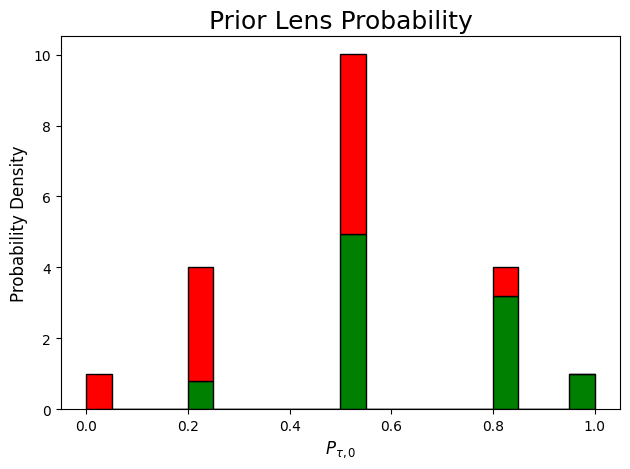

In [6]:
summary_batch_0.plot_P_tau_prior()

(-1.5, -0.5)

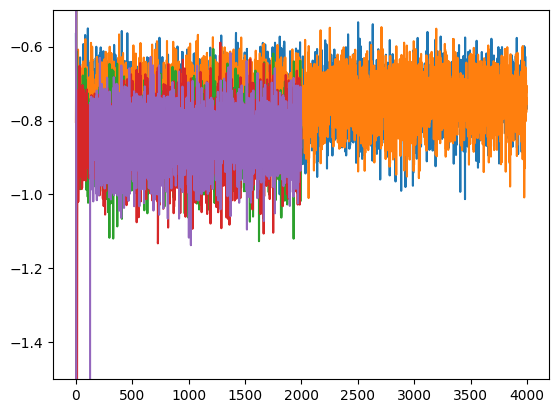

In [30]:
for c_i in range(5):
    pl.plot(summary_batch_0.JAX_chains_list[c_i]['w_0'])
pl.ylim(-1.5,-0.5)

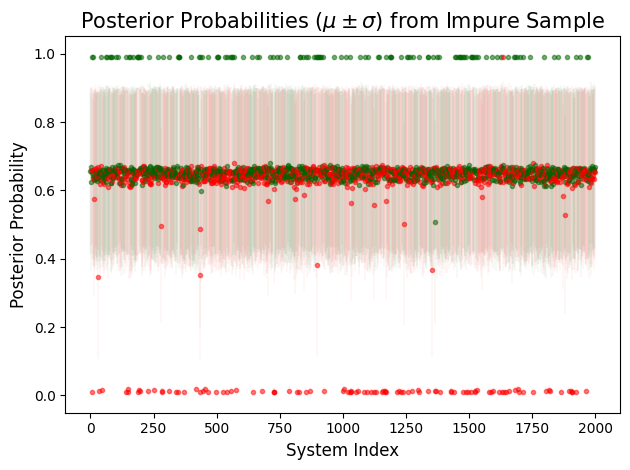

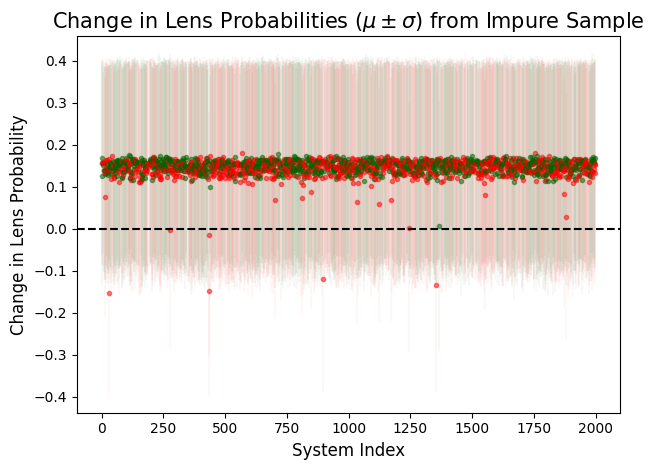

Median change for TPs 0.1513406308893689
Median change for FPs 0.1463407548290373


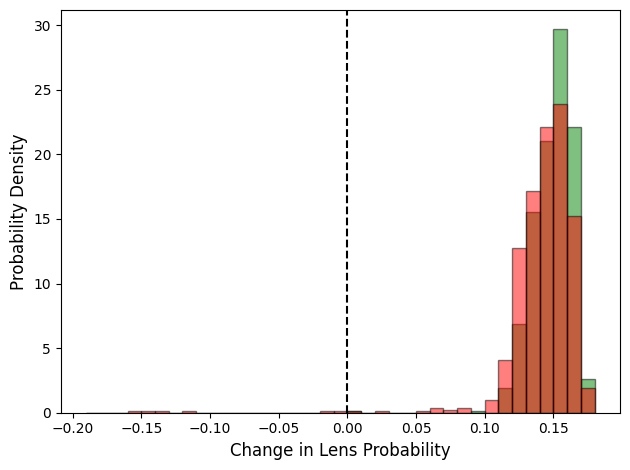

In [4]:
summary_batch_0.P_tau_posterior_plots(burnin_single=500,only_central_P=True,stacked=False)

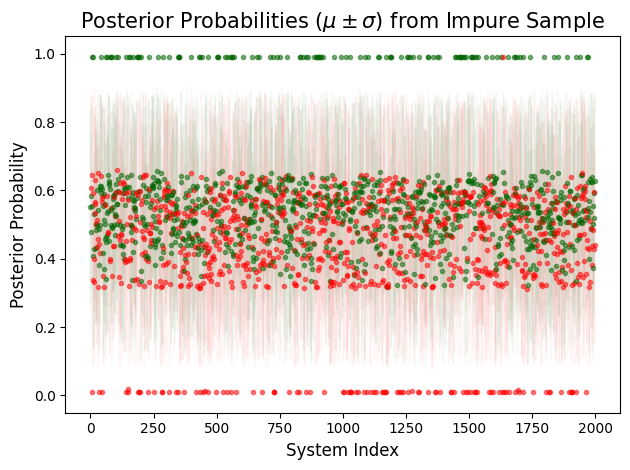

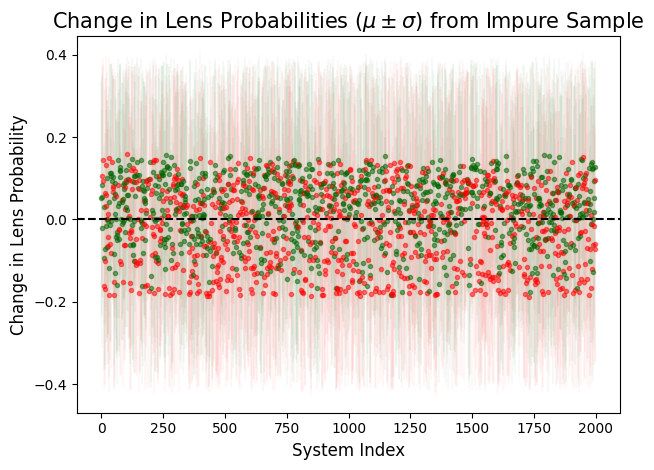

Median change for TPs 0.03871664460457047
Median change for FPs -0.009794251685999678


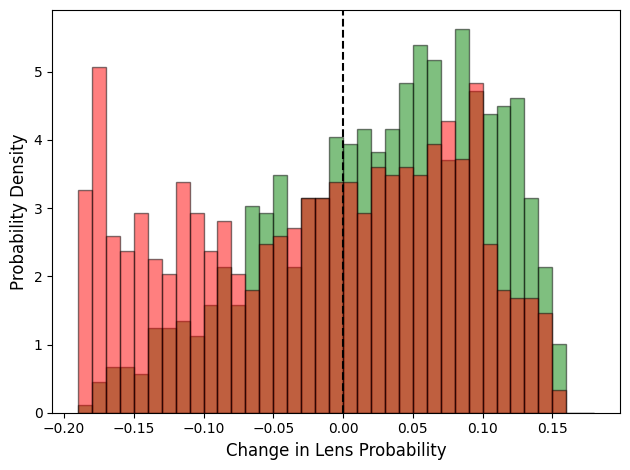

In [194]:
summary_batch.P_tau_posterior_plots(burnin_single=500,stacked=False,only_central_P=True)

In [186]:
JAX_chains_i = squash_walkers(summary_batch.JAX_chains_list[0])
dP_tau = JAX_chains_i.filter(like='P_tau',axis=1).loc[500:].to_numpy()-summary_batch.db_in_list[0]['P_tau'].loc[0:2000].to_numpy()
JAX_chains_i = pd.concat([JAX_chains_i,pd.DataFrame(dP_tau,columns = [f'dP_tau_{i}' for i in range(2001)],index=np.arange(500,2000))],axis=1)

sample: 100%|██████████| 2000/2000 [02:45<00:00, 12.06it/s, 63 steps of size 7.30e-02. acc. prob=0.94] 


NB: JUST returning last sample of a single chain - am not taking the mean or median or anything


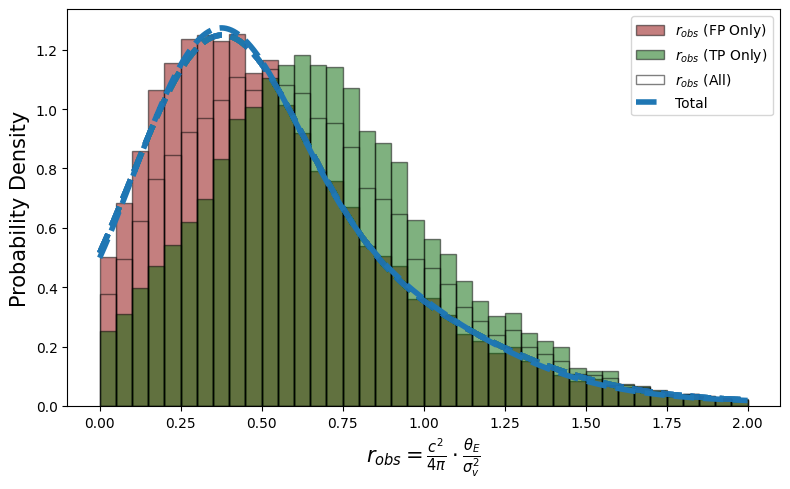

In [160]:
summary_batch.plot_inferred_alpha(burnin=500)

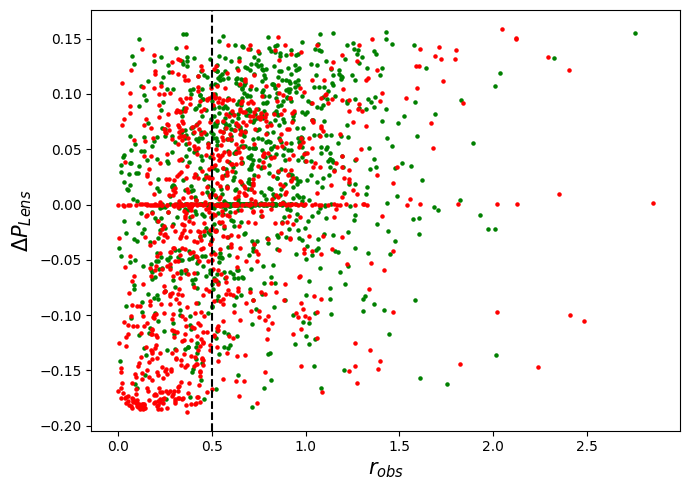

In [187]:
fig = pl.figure(figsize=(7,5))
for p_i,indx in enumerate([np.where(summary_batch.db_in_list[0].loc[:2000]['FP_bool']==0),
             np.where(summary_batch.db_in_list[0].loc[:2000]['FP_bool']==1)]):
    pl.scatter(summary_batch.db_in_list[0]['r_obs_contam'].loc[:2000].loc[indx],
            np.nanmean(JAX_chains_i.filter(like='dP_tau',axis=1),axis=0)[indx],s=5,c=['green','red'][p_i])
pl.xlabel('$r_{obs}$',size=15)
pl.ylabel('$\Delta P_{Lens}$',size=15)
pl.ylim(pl.ylim())
pl.plot([0.5]*2,pl.ylim(),'k--')
pl.tight_layout()
pl.show()

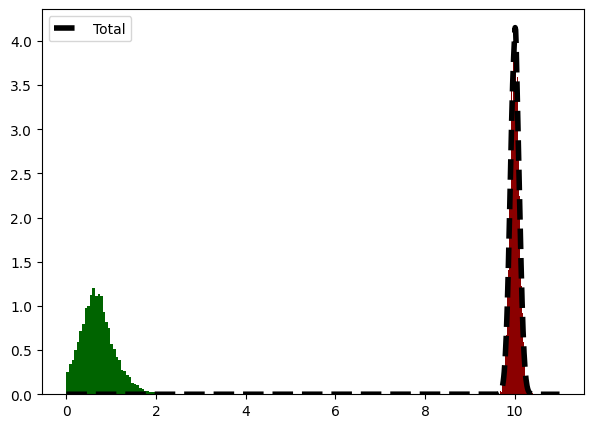

In [79]:
fig,ax = pl.subplots(1,figsize=(7,5))
GMM_class(*[summary_batch_wild_r_obs.JAX_chains_list[0].filter(like='alpha')[[f'alpha_{elem}_{c_i}_0' for c_i in range(3)]].loc[0].to_numpy()\
            for elem in ['mu','scale','weights']]).plot(np.linspace(0,11,1000),trunc_at_zero=True,ax=ax,plot_components=False)
hist_dict = {'bins':50,'density':True}
ax.hist(summary_batch_wild_r_obs.db_in_list[0][summary_batch_wild_r_obs.db_in_list[0]['FP_bool']==1]['r_obs_contam'],**hist_dict,color='darkred')
ax.hist(summary_batch_wild_r_obs.db_in_list[0][summary_batch_wild_r_obs.db_in_list[0]['FP_bool']==0]['r_obs_contam'],**hist_dict,color='darkgreen')
pl.show()

In [38]:
from Beta_Distribution_Class import beta_class
P_0 = 0.5
A_0 = beta_class(mean=P_0,sigma = beta_class().max_sigma_for_unimodal_beta(P_0)).A
B_0 = beta_class(mean=P_0,sigma = beta_class().max_sigma_for_unimodal_beta(P_0)).B

B_sample = numpyro.sample('P_tau',dist.Beta(A_0,B_0),sample_shape = (10000,),rng_key=PRNGKey(0)).flatten()

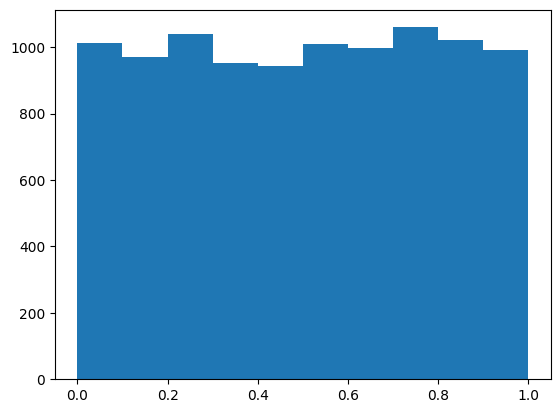

In [39]:
pl.hist(B_sample,bins=np.linspace(0,1,11))
pl.show()

In [19]:
summary_batch_wild_r_obs.db_in_list[0].loc[0]

Unnamed: 0                0
zL_true            0.286963
zS_true            1.708719
zL_obs             0.283056
zS_obs             1.920602
sigma_zL_obs       0.025739
sigma_zS_obs       0.241076
sigma_tE_obs       0.157758
r_obs_contam       0.979604
r_true             0.757506
sigma_r_obs        0.409306
FP_bool               False
P_tau                   0.5
spec                    0.0
veldisp          319.737213
sigma_veldisp     85.641021
tE                 2.233399
Name: 0, dtype: object

In [83]:
Beta_class_instance = beta_class(mean=jnp.array([0.5,0.5,0.5]),sigma=jnp.array([0.1,0.1,0.1]))
beta_A = Beta_class_instance.A
beta_B = Beta_class_instance.B
P_tau = numpyro.sample('P_tau',dist.Beta(beta_A,beta_B),sample_shape = (1,),rng_key=PRNGKey(0)).flatten()
P_tau

Array([0.550371  , 0.40687868, 0.51555353], dtype=float32)

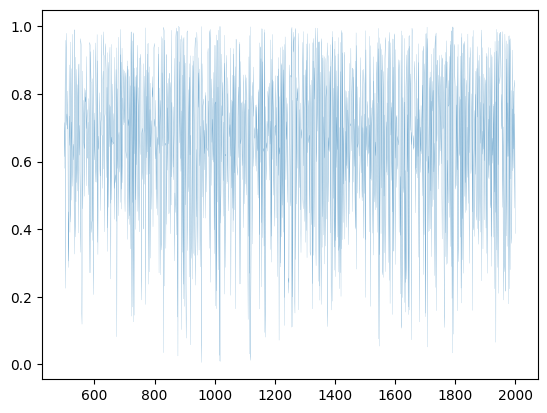

In [25]:
pl.plot(summary_batch_wild_r_obs.JAX_chains_list[0].loc[500:]['P_tau_0_0'],linewidth=0.1)
pl.show()

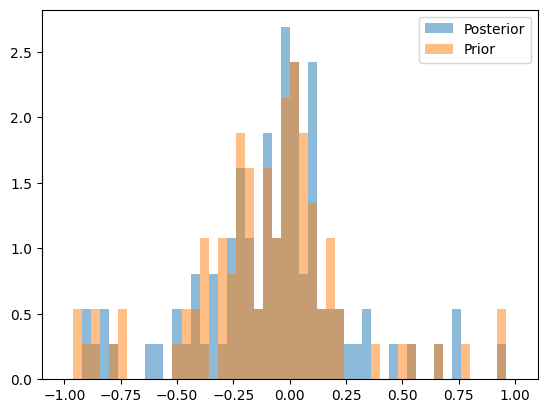

In [89]:
# db_0 = squash_walkers(summary_batch_fiducial.JAX_chains_list[0])
prop = 'zS'
hist_dict = {'density':True,'bins':np.linspace(-1,1,51),'alpha':0.5}
pl.hist([np.mean(db_0[f'{prop}_{sys_i}']-summary_batch_fiducial.db_in_list[0][f'{prop}_true'].loc[sys_i]) for sys_i in range(100)],**hist_dict,label='Posterior')
pl.hist([np.mean(truncnorm(a=-summary_batch_fiducial.db_in_list[0][f'{prop}_obs'].loc[sys_i]/summary_batch_fiducial.db_in_list[0][f'sigma_{prop}_obs'].loc[sys_i],
                          b=np.inf,
                          loc=summary_batch_fiducial.db_in_list[0][f'{prop}_obs'].loc[sys_i],
                          scale=summary_batch_fiducial.db_in_list[0][f'sigma_{prop}_obs'].loc[sys_i]
                          ).rvs(10000)-summary_batch_fiducial.db_in_list[0][f'{prop}_true'].loc[sys_i]) for sys_i in range(100)],**hist_dict,label='Prior')
pl.legend()
pl.show()

In [ ]:
weight_0 = np.random.random(size=100000)
weight_1 = np.random.random(size=100000)
weight_2 = 1-(weight_0+weight_1)
valid_w_indx = np.where((weight_1+weight_0)<1)[0]#(weight_2<1)&(weight_2>0))[0]
weight_0 = weight_0[valid_w_indx]
weight_1 = weight_1[valid_w_indx]
weight_2 = weight_2[valid_w_indx]
pl.hist([weight_0,weight_1,weight_2],bins=np.linspace(0,1,21),alpha=0.5)
pl.show()

In [ ]:
print('Fiducial',np.mean([315.89/383,315.44/365,317.9/370,293.97/324,292.94/332]))
print('Only Photom',np.mean([306.83/347,309.15/328,300.15/337,284.06/293,299.07/308]))


In [ ]:
def total_inferred_N_lens(summary_batch):
    for batch_i in range(summary_batch.N_batch):
        N_lens_inferred = np.sum(squash_walkers(summary_batch.JAX_chains_list[batch_i]).filter(like='P_tau',axis=1).mean(axis=0))
        N_P_tau_saved = len(squash_walkers(summary_batch.JAX_chains_list[batch_i]).filter(like='P_tau',axis=1).columns)
        N_lens_true = np.sum(summary_batch.db_in_list[batch_i].loc[:(N_P_tau_saved-1)]['FP_bool']==0)
        print(np.round(N_lens_inferred,2),N_lens_true,N_P_tau_saved)

# total_inferred_N_lens(summary_batch_only_photom)
total_inferred_N_lens(summary_batch_fiducial)

In [ ]:
for spec_bool in [0,1]:
    db_ii = summary_batch_fiducial.db_in_list[0]
    indx = np.where((db_ii['FP_bool']==0)&db_ii['spec']==spec_bool)[0]
    hist_dict = {'density':True,'bins':np.linspace(0,1,100),'alpha':0.5}
    pl.hist(summary_batch_fiducial.db_in_list[0]['sigma_r_obs'].loc[indx],**hist_dict)
pl.show()

In [ ]:
summary_batch_fiducial.db_in_list[1]['zL_true'].loc[:100].loc[summary_batch_fiducial.db_in_list[1]['FP_bool']==0]

In [ ]:
def plot_z_bias_wrt_hyperparams(hyperparam,summary_batch_class,only_TP=True):
    N_z_saved = 100
    mean_z_bias_dict = {'zL':{},'zS':{}}
    fig_list = [pl.figure(figsize=(5,5)),pl.figure(figsize=(5,5))]
    df_dict = {'zL':[],'zS':[]}
    z_bias_range_dict = {'zL':(-0.01,0.01),'zS':(-0.5,0.5)}
    for batch_i in range(summary_batch_class.N_batch):
        df = summary_batch_class.JAX_chains_list[batch_i].loc[0:1999]
        if only_TP:
            TP_indx = np.where(summary_batch_class.db_in_list[batch_i]['FP_bool']==0)[0]
            TP_indx=TP_indx[TP_indx<N_z_saved]
        else: TP_indx = np.arange(N_z_saved)
        for p_i,z_type in enumerate(['zL','zS']):
            for chain_i in range(10):
                if only_TP: z_columns_i = [f'{z_type}_{sys_i}_{chain_i}' for sys_i in TP_indx]
                else: z_columns_i = [f'{z_type}_{sys_i}_{chain_i}' for sys_i in range(N_z_saved)]
                mean_z_bias_dict[z_type][chain_i] = np.mean(df[z_columns_i]-summary_batch_class.db_in_list[batch_i][f'{z_type}_true'].loc[:N_z_saved-1].loc[TP_indx].to_numpy(),axis=1)
                df_dict[z_type].append(pd.concat([df[f'{hyperparam}_{chain_i}'].rename(hyperparam),
                                        pd.DataFrame(mean_z_bias_dict[z_type][chain_i],columns=['dz'])],axis=1))
    for p_i,z_type in enumerate(['zL','zS']):
        df_dict[z_type] = pd.concat(df_dict[z_type])
        print(df_dict[z_type].columns)
        corner.corner(df_dict[z_type],
                range=[range_dict[hyperparam],(np.percentile(df_dict[z_type]['dz'],1),np.percentile(df_dict[z_type]['dz'],99))],#z_bias_range_dict[z_type]],
                fig=fig_list[p_i],
                hist_kwargs={'density':True},
                hist2d_kwargs={'label':'_nolegend_'},
                label_kwargs={'fontsize':21},
                labels=[label_dict[hyperparam],'$\Delta$'+z_type],
                plot_datapoints=False,
                show_titles=True)
    pl.show()

for param_i in ['Ode','OM','w','wa']:
    fl = plot_z_bias_wrt_hyperparams(param_i,summary_batch_only_photom,only_TP=True)

In [ ]:
for batch_i in range(summary_batch_only_photom.N_batch):
    pl.plot(summary_batch_only_photom.JAX_chains_list[batch_i].filter(like='alpha_mu_2'),alpha=0.5)
    pl.show()

In [ ]:
reload(sys.modules['plot_JAX_corner'])
from plot_JAX_corner import label_dict
label_dict

In [ ]:
def plot_degeneracies(summary_batch_class,extra_parameter,burnin=0,burnout=None,extra_range_dict=None,N_batch=None):
    if N_batch is None: N_batch = summary_batch_class.N_batch
    columns_to_plot = ['OM','Ode','w','wa','Ok']+np.array(extra_parameter).flatten().tolist()
    color_list = pl.cm.viridis(np.linspace(0,1,N_batch))
    range_list = []
    squashed_chains = []
    for batch_i in tqdm(range(N_batch)):
        df_ii = summary_batch_class.JAX_chains_list[batch_i].loc[burnin:burnout]
        #Removing some columns for speed, before squashing
        df_ii = df_ii[df_ii.columns.drop(
                                        # list(df_ii.filter(regex='P_tau'))+
                                         list(df_ii.filter(regex='zL'))+
                                         list(df_ii.filter(regex='zS')))]
        squashed_chains.append(squash_walkers(df_ii))
    for c_i in columns_to_plot:
        try:range_list.append(range_dict[c_i])
        except Exception as ex:
            if extra_range_dict is not None: range_list.append(extra_range_dict[c_i])
            else:
                steps_i = np.array([squashed_chains[batch_i][c_i] for batch_i in range(N_batch)])
                range_list.append((np.min(steps_i),np.max(steps_i)))
    print('Making corner plot:')
    fig = pl.figure(figsize=(2*len(columns_to_plot),2*len(columns_to_plot)))
    for batch_ii in range(N_batch):
        corner.corner(squashed_chains[batch_ii][columns_to_plot],
                        fig=fig,
                        # labels=[label_dict[elem] for elem in columns_to_plot],
                        hist_kwargs={'density':True},
                        hist2d_kwargs={'label':'_nolegend_'},
                        range=range_list,
                        label_kwargs={'fontsize':21},
                        plot_datapoints=False,
                        color=color_list[batch_ii])
    pl.show()

plot_degeneracies(summary_batch_fiducial,
                #   ['scale_m','scale_c','s_c','s_m'],
                  ['P_tau_2'],
                # ['alpha_mu_0','alpha_mu_1','alpha_mu_2']+
                # ['alpha_scale_0','alpha_scale_1','alpha_scale_2']+
                # ['alpha_weights_0','alpha_weights_1'],
                  burnin=0,burnout=1999,
                  extra_range_dict={
                    'scale_m':(0,1.2),'scale_c':(0.5,1.0),
                    's_c':(0,1),'s_m':(-0.5,0.5),
                    'alpha_mu_0':(0,2),'alpha_mu_1':(0,2),'alpha_mu_2':(0,2),
                    'alpha_scale_0':(0,1.5),'alpha_scale_1':(0,1.5),'alpha_scale_2':(0,1.5),
                    'alpha_weights_0':(0,1),'alpha_weights_1':(0,1),
                    'P_tau_0':(0,1),'P_tau_1':(0,1),'P_tau_2':(0,1),
                    },
                    N_batch=1)


In [ ]:
def compare_r_true_false(summary_batch_class):
    '''
    Calculating the 'Inferred' r_obs by weighting the measured r_obs by the posterior P_tau values.
    '''
    fig,ax = pl.subplots(1,figsize=(7,5))
    ax_0 = ax
    hist_dict = {'density':True,'bins':np.linspace(0,3,31),'alpha':0.5}
    for batch_i in range(summary_batch_class.N_batch):
        if batch_i==0: label_FP='FP';label_TP='TP';label_inferred_TP = 'Weighted $r_{obs}$, TP'
        else: label_FP='_nolegend_';label_TP='_nolegend_';label_inferred_TP='_nolegend_'
        FP_indx = np.where(summary_batch_class.db_in_list[batch_i]['FP_bool']==1)[0]
        TP_indx = np.where(summary_batch_class.db_in_list[batch_i]['FP_bool']==0)[0]
        ax_0.hist(summary_batch_class.db_in_list[batch_i].loc[FP_indx]['r_obs_contam'],color='darkred',edgecolor='k',label=label_FP,**hist_dict)
        ax_0.hist(summary_batch_class.db_in_list[batch_i].loc[TP_indx]['r_obs_contam'],color='darkgreen',edgecolor='k',label=label_TP,**hist_dict)
        r_obs = summary_batch_class.db_in_list[batch_i]['r_obs_contam'].loc[:2000]
        ax_0.hist(r_obs,fill=False,edgecolor='green',linestyle='--',linewidth=2,label=label_inferred_TP,**hist_dict,
                  weights = squash_walkers(summary_batch_class.JAX_chains_list[batch_i]).filter(
                      like='P_tau',axis=1).mean(axis=0))
    ax_0.set_xlabel('$r_{obs}$',fontsize=15);ax_0.set_ylabel('Probability Density',fontsize=15)
    ax_0.legend(fontsize=12);ax_0.tick_params(labelsize=12)
    pl.tight_layout()
    pl.show()

compare_r_true_false(summary_batch_only_photom)

In [ ]:
reload(sys.modules['Save_Summary_Batches'])
from Save_Summary_Batches import plot_inferred_alpha_smallbugfixed
plot_inferred_alpha_smallbugfixed(summary_batch_only_photom)

In [ ]:
import matplotlib.pyplot as pl
import numpy as np
fig,ax = pl.subplots(1,2,figsize=(10,5))
hist_dict = {'alpha':0.5}
for delta_z in [0.1,0.5,0.8]:
    db_i = summary_batch_delta_z_dict[delta_z].db_in_list[0]
    # ax[0].hist(db_i['zL_obs']-db_i['zL_true'],edgecolor='darkblue',**hist_dict,bins=np.linspace(-0.1,0.1,21),label=delta_z)
    ax[0].hist(db_i['zS_obs']-db_i['zS_true'],edgecolor='darkred',**hist_dict,bins=np.linspace(-1,1,21),label=delta_z)
    # ax[1].hist(db_i['sigma_zL_obs'],edgecolor='darkblue',**hist_dict,bins=np.linspace(0,0.5,21),label=delta_z)
    ax[1].hist(db_i['sigma_zS_obs'],edgecolor='darkred',**hist_dict,bins=np.linspace(0,2,21),label=delta_z)
    ax[0].set_xlabel('Redshift Error',fontsize=15)
    ax[1].set_xlabel('Redshift Uncertainty',fontsize=15)
    for p_i in range(2):
        ax[p_i].set_ylabel('Probability Density',fontsize=15)
        ax[p_i].tick_params(labelsize=12)
        ax[p_i].legend(fontsize=12)
pl.tight_layout()
pl.show()

In [ ]:
for delta_z in summary_batch_delta_z_dict.keys():
    print(delta_z)
    summary_batch_delta_z_dict[delta_z].plot_JAX_chains()

In [ ]:
N_jobs = 0
for batch_i in [0]:#range(summary_batch_unimodal.N_batch):
    P_tau_50_indx = np.where(summary_batch_unimodal.db_in_list[batch_i]['P_tau']==0.5)[0]
    P_tau_50_indx=P_tau_50_indx[P_tau_50_indx<2000]
    for sys_i in P_tau_50_indx:
        print(f'addqueue -m 10 -q redwood --requeue /mnt/users/hollowayp/python114_archive/bin/python3.11 P_tau_reweighting.py {summary_batch_unimodal.python_out_file_0} {batch_i} {sys_i} 10000')
        N_jobs+=1
        if N_jobs>50:
            break

In [ ]:
fig,ax = pl.subplots(1,2,figsize=(10,5))
bins = np.linspace(-1,1,21)
param = ['Ode']
for walker_i in range(30):
    ax[0].plot(combined_inference_samples[walker_i][param])

ax[1].hist(np.array([combined_inference_samples[walker_i][param].loc[2000:] for walker_i in range(30)]).flatten(),
            bins=bins,fill=False,density=True)

for batch_i in range(len(summary_batch_unimodal.JAX_chains_list)):
    batch_i_samples = squash_walkers(summary_batch_unimodal.JAX_chains_list[batch_i])[param]
    ax[1].hist(batch_i_samples,bins=bins,density=True,alpha=0.1)
pl.show()

In [ ]:
for walker_i in range(30):
    pl.plot(combined_inference_samples.get_chain()[:,walker_i,0])
pl.show()

In [ ]:
db_in.loc[0:10000].to_csv('./databases/real_paltas_population_TP_100000_FP_100000_Spec_10000_P_0.5_gradient_prob_lower_P_spec_highP_Part_0_a.csv')
db_in.loc[10000:20000].to_csv('./databases/real_paltas_population_TP_100000_FP_100000_Spec_10000_P_0.5_gradient_prob_lower_P_spec_highP_Part_0_b.csv')

In [ ]:
fig,ax = pl.subplots(figsize=(8,5))
hist_dict = {'bins':np.linspace(0,2,41),'density':True,'edgecolor':'k','alpha':0.5}
ax.hist(db_in['r_obs_contam'][db_in['FP_bool']==1],
        label='$r_{obs}$ (FP Only)',color='darkred',**hist_dict)
ax.hist(db_in['r_obs_contam'],label='$r_{obs}$ (All)',**hist_dict)
ax.legend([])
GMM_truncnorm_best_fit = numpyro_truncnorm_GMM_fit(db_in['r_obs_contam'][db_in['FP_bool']==1].to_numpy(),
                                                   N_comp=3)
for k_i in GMM_truncnorm_best_fit.keys():
    GMM_truncnorm_best_fit[k_i] = [float(GMM_truncnorm_best_fit[k_i][ii]) for ii in range(len(GMM_truncnorm_best_fit[k_i]))]

print(GMM_truncnorm_best_fit)
GMM_class(**GMM_truncnorm_best_fit).plot(trunc_at_zero=True,X_plot=np.linspace(0,2,1001),ax=ax,
                                         plot_components=False)
for ii in np.linspace(500,1900,40,dtype=int):
    GMM_class(list_of_mu = [JAX_chains['alpha_mu_0_0'][ii],JAX_chains['alpha_mu_1_0'][ii],JAX_chains['alpha_mu_2_0'][ii]],
          list_of_sigma=[JAX_chains['alpha_scale_0_0'][ii],JAX_chains['alpha_scale_1_0'][ii],JAX_chains['alpha_scale_2_0'][ii]],
          list_of_weights=[JAX_chains['alpha_weights_0_0'][ii],JAX_chains['alpha_weights_1_0'][ii],JAX_chains['alpha_weights_2_0'][ii]],
          ).plot(trunc_at_zero=True,X_plot=np.linspace(0,2,1001),
          label_components=False,ax = ax,alpha=0.1,legend=False,plot_components=False)
ax.set_xlabel('$r_{obs} = \\frac{c^2}{4\pi}\cdot\\frac{\\theta_E}{\\sigma_v^2}$',fontsize=15)
ax.set_ylabel('Probability Density',fontsize=15)
pl.tight_layout()
pl.show()

In [ ]:
# db = pd.read_csv('./chains/SL_orig_real_paltas_population_TP_100000_FP_100000_Spec_10000_P_0.5_Part_0.csv_ph_True_con_True_wCDM_JAX_chains_8_274.csv')
# db[['alpha_weights_0_0','alpha_weights_1_0','alpha_weights_2_0']]

In [ ]:
from scipy.stats import gaussian_kde
from scipy.integrate import trapezoid
from emcee import EnsembleSampler
class test_kde_batching():
    def __init__(self,N_data,N_batch,truth_dict):
        self.N_data = N_data
        self.N_batch = N_batch
        ground_truth_dict = {'list_of_mu':np.array([truth_dict[0]['mu'],truth_dict[1]['mu'],truth_dict[2]['mu']]),
                             'list_of_sigma':np.array([truth_dict[0]['sigma'],truth_dict[1]['sigma'],truth_dict[2]['sigma']]),
                             'list_of_weights':np.array([truth_dict[0]['weight'],truth_dict[1]['weight'],truth_dict[2]['weight']])}
        self.ground_truth_dict = ground_truth_dict
        self.data = GMM_class(**ground_truth_dict).sample(trunc_at_zero=True,N_samples=N_data)
        self.data = np.random.choice(self.data,size=N_data,replace=False) #Random ordering
        data_batches = np.array_split(self.data,N_batch)
        self.data_batches = {elem:data_batches[elem] for elem in range(N_batch)}
        #Now fitting a truncated normal to these data batches:
        self.MCMC_fits = {elem:numpyro_truncnorm_GMM_fit(self.data_batches[elem],
                                                         N_comp = len(ground_truth_dict['list_of_mu']),
                                                         num_warmup=10000,num_samples=10000,
                                                         return_all_samples=True) for elem in range(N_batch)}
        self.MCMC_fits_all_data = numpyro_truncnorm_GMM_fit(self.data,
                                                         N_comp = len(ground_truth_dict['list_of_mu']),
                                                         num_warmup=10000,num_samples=10000,
                                                         return_all_samples=True)
        return
    def order_weights(self,MCMC_dict):
        self.MCMC_db_i = {}
        for c_i in range(len(self.ground_truth_dict['list_of_mu'])):
            self.MCMC_db_i[f'alpha_mu_{c_i}'] = MCMC_dict[f'alpha_mu_{c_i}'].flatten()
            self.MCMC_db_i[f'alpha_scale_{c_i}'] = MCMC_dict[f'alpha_scale_{c_i}'].flatten()
            self.MCMC_db_i[f'alpha_weights_{c_i}'] = MCMC_dict['alpha_weights'][:,c_i]
        self.MCMC_db_ii = pd.DataFrame(self.MCMC_db_i)
        #Putting in weight order:
        MCMC_db_weight_order = np.argsort(self.MCMC_db_ii[[elem for elem in self.MCMC_db_ii.columns if 'weight' in elem]].median(axis=0))
        MCMC_db_weight_order = np.array([[f'alpha_mu_{elem}',f'alpha_scale_{elem}',f'alpha_weights_{elem}'] for elem in np.array([0,1,2])[MCMC_db_weight_order]]).flatten().tolist()
        self.MCMC_db_ii = self.MCMC_db_ii[MCMC_db_weight_order].to_numpy()
        ordered_column_names = np.array([[f'alpha_mu_{elem}',f'alpha_scale_{elem}',f'alpha_weights_{elem}'] for elem in np.array([0,1,2])]).flatten().tolist()
        return pd.DataFrame(self.MCMC_db_ii,columns = ordered_column_names)
    def return_stuff(self,N_steps = 100):
        self.MCMC_db = {}
        for batch_ii in range(self.N_batch):
            self.MCMC_db[batch_ii] = self.order_weights(self.MCMC_fits[batch_ii])
        self.MCMC_db_all = self.order_weights(self.MCMC_fits_all_data)
        # return self.MCMC_db
        self.kde = {elem:gaussian_kde(self.MCMC_db[elem].T,bw_method=0.1) for elem in range(self.N_batch)}
        def gaussian_kde_product_log_prob(x):
            # if x[2]<0 or x[2]>1: return -np.inf
            # if x[5]<0 or x[5]>1: return -np.inf
            # if x[8]<0 or x[8]>1: return -np.inf
            # if (x[2]>x[5]) or (x[5]>x[8]): return -np.inf #Asserting weight ordering - seems a bit dodge?
            return np.sum(np.array([self.kde[elem].logpdf(x) for elem in range(self.N_batch)]),axis=0)
        n_walkers = 20
        self.sampler = EnsembleSampler(nwalkers=n_walkers,ndim=9,log_prob_fn=gaussian_kde_product_log_prob)
        cur_state_0 = []
        for col_i in self.MCMC_db[0].columns:
            if 'weight' in col_i: cur_state_0.append(np.random.uniform(low=0,high=1,size=(n_walkers,1)))
            else: cur_state_0.append(np.random.uniform(low=0.01,high=5,size=(n_walkers,1)))
        cur_state = np.concatenate(cur_state_0,axis=1)
        _ = self.sampler.run_mcmc(cur_state,N_steps,progress=True,skip_initial_state_check=True)
        # self.meshgrid_list = []
        # self.meshgrid_db_list = []
        # for batch_i in tqdm(range(self.N_batch)):
        #     for point_i in range(N_random_points):
        #         meshgrid_list_i = []
        #         for column_i in self.MCMC_db[batch_i].columns:
        #             if 'mu' in column_i: meshgrid_list_i.append(np.random.uniform(0,5))
        #             if 'sigma' in column_i: meshgrid_list_i.append(np.random.uniform(0.01,2))
        #             if 'weights' in column_i: meshgrid_list_i.append(np.random.uniform(0,1))
        #         self.meshgrid_db_list.append(meshgrid_list_i)
        # self.meshgrid_db_list = np.array(self.meshgrid_db_list).T
        # self.kde_eval = np.sum(np.array([self.kde[elem].logpdf(self.meshgrid_db_list) for elem in range(self.N_batch)]),axis=0)
        # self.meshgrid_db_list = pd.DataFrame(self.meshgrid_db_list.T,
        #                                      columns = self.MCMC_db[0].columns)
        # self.meshgrid_db_list['PDF'] = self.kde_eval
        return self
        # assert X_eval.shape==self.kde_eval.shape
        # kde_normalisation = trapezoid(y=self.kde_eval,x=X_eval)
        # self.kde_eval/=kde_normalisation
        # pl.plot(X_eval,self.kde_eval)
        # for elem in range(self.N_batch):
        #     pl.plot(X_eval,self.kde[elem].pdf(X_eval),alpha=0.5,c='k')
        # pl.hist(self.data,density=True,bins=50)
        # pl.show()

truth_dict = {0:{'mu':0.5,'sigma':0.1,'weight':0.1},
            1:{'mu':2,'sigma':0.5,'weight':0.2},
            2:{'mu':3.1,'sigma':0.8,'weight':0.7}}

a = test_kde_batching(10000,1,truth_dict).return_stuff(N_steps = 100)

In [ ]:
MCMC_batch_data_dict = {}
for chain_i in range(a.sampler.get_chain().shape[1]):
    MCMC_batch_data_i = pd.DataFrame(a.sampler.get_chain()[:,chain_i,:],
                columns = a.MCMC_db[0].columns)
    MCMC_batch_data_weight_order = np.argsort(MCMC_batch_data_i[[elem for elem in MCMC_batch_data_i.columns if 'weight' in elem]].median(axis=0))
    MCMC_batch_data_columns_in_weight_order = np.array([[f'alpha_mu_{elem}',f'alpha_scale_{elem}',f'alpha_weights_{elem}'] for elem in np.array([0,1,2])[MCMC_batch_data_weight_order]]).flatten().tolist()
    MCMC_batch_data_i = MCMC_batch_data_i[MCMC_batch_data_columns_in_weight_order]
    MCMC_batch_data_dict[chain_i] = MCMC_batch_data_i

In [ ]:
corner.corner(a.MCMC_db[0],labels=a.MCMC_db[0].columns,
              truths = [0.5,0.1,0.1,2,0.5,0.2,3.1,0.8,0.7])
corner.corner(a.MCMC_db_all[0],labels=a.MCMC_db[0].columns,
              truths = [0.5,0.1,0.1,2,0.5,0.2,3.1,0.8,0.7])

In [ ]:
pl.plot(MCMC_batch_data_i['alpha_weights_0'],label=0)
pl.plot(MCMC_batch_data_i['alpha_weights_1'],label=1)
pl.plot(MCMC_batch_data_i['alpha_weights_2'],label=2)
pl.legend()
# pl.ylim(-0.1,1.1)
pl.show()

In [ ]:
MCMC_all_data = {}
for column_i in a.MCMC_fits_all_data.keys():
    if 'weights' in column_i: continue
    else: MCMC_all_data[column_i] = a.MCMC_fits_all_data[column_i].flatten()

MCMC_all_data = pd.DataFrame(MCMC_all_data)
for GMM_comp_i in range(a.MCMC_fits_all_data['alpha_weights'].shape[1]):
    MCMC_all_data[f'alpha_weights_{GMM_comp_i}'] = a.MCMC_fits_all_data['alpha_weights'][:,GMM_comp_i]

MCMC_all_data = MCMC_all_data[a.MCMC_db[0].columns] #Reordering columns

In [ ]:
#Returning in order of largest (or smallest?, one of them!) weight:
MCMC_all_data_weight_order = np.argsort(MCMC_all_data[[elem for elem in MCMC_all_data.columns if 'weight' in elem]].median(axis=0))
MCMC_all_data_columns_in_weight_order = np.array([[f'alpha_mu_{elem}',f'alpha_scale_{elem}',f'alpha_weights_{elem}'] for elem in np.array([0,1,2])[MCMC_all_data_weight_order]]).flatten()
MCMC_all_data = MCMC_all_data[MCMC_all_data_columns_in_weight_order]


In [ ]:
fig,ax = pl.subplots(9,9,figsize=(18,18))
burnin = 2000
range_list = []
for column_i in a.MCMC_db[0].columns:
    if 'mu' in column_i: range_list.append((0,5))
    if 'sigma' in column_i: range_list.append((0.01,3))
    if 'weights' in column_i: range_list.append((0,1))

chain_0 = 0
# corner.corner(MCMC_batch_data_dict[chain_0].to_numpy(),fig=fig,truths = np.array(truth_list))
corner.corner(MCMC_all_data.to_numpy(),fig=fig,truths = np.array(truth_list),
            labels = MCMC_all_data.columns)
pl.tight_layout()
pl.show()

In [ ]:
# a.kde[0].pdf(np.array([[1,2,3,4,5,6,7,8,9],[2,3,4,5,6,7,8,9,10]]).T)

b = [np.linspace(0,1,2),np.linspace(2,20,3),np.linspace(0,10,4),np.linspace(0,10,8)]
np.meshgrid(*b)[0].shape

In [ ]:
X_plot = np.linspace(0,1,100)
pl.plot(X_plot,beta_class(mean=db_in['P_tau'][0],sigma=0.2).beta_func_scipy().pdf(X_plot))
pl.title('$P_\\tau$ Prior ($\mu$: 0.67, $\sigma$: 0.2)',fontsize=15)
pl.ylabel('Probability Density',fontsize=12)
pl.xlabel('$P_\\tau$',fontsize=12)
pl.tight_layout()
pl.show()

In [ ]:
JAX_chains = summary_batch_unimodal.JAX_chains_list[0]
db_in = summary_batch_unimodal.db_in_list[0]

In [ ]:
import os
os.chdir('/mnt/users/hollowayp/zBEAMS')

chain_dict = {}
prefix = ''#./chains/SL_orig_real_paltas_population_'
for chain_i in [retrieve_chain_files(elem,warmup=False) for elem in 
                                        ['python3.11-41721.out','python3.11-41722.out',
                                        'python3.11-41723.out','python3.11-41724.out',
                                        'python3.11-41725.out','python3.11-41726.out',
                                        'python3.11-41727.out','python3.11-41728.out',
                                        'python3.11-41729.out','python3.11-41730.out']]:
    chain_dict[chain_i] = locate_latest_chains(input_file = prefix+chain_i,JAX=True)

# for chain in [
#     './chains/SL_orig_Euclidlike_18342_FP_0_Spec_8342_P_1.0.csv_ph_False_con_False_wCDM_JAX_chains_0.csv',
#     './chains/SL_orig_Euclidlike_18342_FP_0_Spec_8342_P_1.0.csv_ph_False_con_False_LambdaCDM_JAX_chains_0.csv']:
#     chain_dict[chain] = locate_latest_chains(input_file = chain,JAX=True)


In [ ]:
from Beta_Distribution_Class import beta_class
hist_dict = {'bins':np.linspace(0,1,100),'alpha':0.1,'fill':False,'edgecolor':'k','density':True}
for n_sys in range(100):
    pl.hist(JAX_chains[[f'P_tau_{n_sys}_0',f'P_tau_{n_sys}_1',f'P_tau_{n_sys}_2']].to_numpy().flatten(),**hist_dict)
pl.plot(np.linspace(0,1,100),beta_class(mean=0.7,sigma=0.2).beta_func_scipy().pdf(np.linspace(0,1,100)))
pl.show()

#### Additional Chain Retrieval

In [ ]:
# chain_dict = {}
# N_lens = 1000
# #for N_obs_i in np.linspace(1000,10000,10):
# for true_lens_frac in np.linspace(0.5,1,60):
#     N_obs_i = int(N_lens/true_lens_frac)
#     try:
#         chain_dict[int(np.round(100*N_lens/N_obs_i))] = locate_latest_chains(
#             'abs',Errors_perc,
#             contamination_str=contamination_str,
#             photometric_str=photometric_str,
#             cosmo_db_str=cosmo_db_str,
#             cosmo_type_str=cosmo_type_str,
#             N_samples = int(N_obs_i),
#             Perc_true = int(np.round(100*N_lens/N_obs_i)),
#             JAX=True,return_db=False,
#             warmup=False)
#         #print(retrieve_summary(chain_dict[int(np.round(100*N_lens/N_obs_i))],exclude=[]))
#     except Exception as ex:
#         print(f'Error for {N_obs_i} systems:{ex}')

chain_dict = {}
N_lens = 7500
Prefix = 'SL_orig_LensPop_Euclid_Gaussian_noise_'
#for N_obs_i in np.linspace(1000,10000,10):#2**np.arange(7,16):
for true_lens_frac in []:#np.linspace(0.5,1,26):
    N_obs_i = int(N_lens/true_lens_frac)
    try:
        chain_dict[int(np.round(100*N_lens/N_obs_i))] = locate_latest_chains(
            'abs',Errors_perc,
            contamination_str=contamination_str,
            photometric_str=photometric_str,
            cosmo_db_str=cosmo_db_str,
            cosmo_type_str=cosmo_type_str,
            N_samples = int(N_obs_i),
            Perc_true = int(np.round(100*N_lens/N_obs_i)),
            JAX=True,return_db=False,
            warmup=False)
        #print(retrieve_summary(chain_dict[int(np.round(100*N_lens/N_obs_i))],exclude=[]))
    except Exception as ex:
        print(f'Error for {N_obs_i} systems:{ex}')

# chains = locate_latest_chains(Errors_perc,N_samples,Perc_true,contamination_str,photometric_str,cosmo_type_str,cosmo_db_str=cosmo_db_str)
# JAX_chains,db_in = locate_latest_chains('abs',Errors_perc,N_samples,Perc_true,contamination_str,photometric_str,
#                                         cosmo_type_str,JAX=True,cosmo_db_str=cosmo_db_str,return_db=True,
#                                         list_of_file_indx= [],
#         input_file = './chains/SL_orig_LensPop_Euclid_Gaussian_noise_0p05abs_9375_samples_80_true_cosmo_wCDM.csv_ph_False_con_False_wCDM_JAX_chains_0.csv')

In [ ]:
# chain_dict = {
#     7500:pd.read_csv('./chains/SL_orig_LensPop_Euclid_Gaussian_noise_mix_7500.csv_ph_True_con_False_wCDM_JAX_chains_0.csv'),
#     11250:pd.read_csv('./chains/SL_orig_LensPop_Euclid_Gaussian_noise_mix_11250.csv_ph_True_con_False_wCDM_JAX_chains_0.csv'),
#     15000:pd.read_csv('./chains/SL_orig_LensPop_Euclid_Gaussian_noise_mix_15000.csv_ph_True_con_False_wCDM_JAX_chains_0.csv'),
#     22500:pd.read_csv('./chains/SL_orig_LensPop_Euclid_Gaussian_noise_mix_22500.csv_ph_True_con_False_wCDM_JAX_chains_0.csv')}    

# for k_i in [7500,11250,15000,22500]:
#     plot_JAX_chains(chain_dict[k_i],plot_hist=True,title=k_i)

chain_dict = {
    0.02: pd.read_csv('./chains/SL_orig_LensPop_Euclid_Gaussian_noise_0p02abs_7500_samples_100_true_cosmo_wCDM.csv_ph_True_con_False_wCDM_JAX_chains_1.csv'),
    0.05: pd.read_csv('./chains/SL_orig_LensPop_Euclid_Gaussian_noise_0p05abs_7500_samples_100_true_cosmo_wCDM.csv_ph_True_con_False_wCDM_JAX_chains_1.csv'),
    0.1:  pd.read_csv('./chains/SL_orig_LensPop_Euclid_Gaussian_noise_0p1abs_7500_samples_100_true_cosmo_wCDM.csv_ph_True_con_False_wCDM_JAX_chains_1.csv')}

for k_i in [0.02,0.05,0.1]:
    plot_JAX_chains(chain_dict[k_i],plot_hist=True,title=k_i,ignore_nonconverged=True)

In [ ]:
zBEAMS_warmup_dict={}
for error_i in [0.02,0.05,0.1]:
    zBEAMS_warmup_dict[error_i] = locate_latest_chains(abs_or_perc='abs',
                     Errors=error_i,
                     N_samples=7500,
                     Perc_true=100,
                     contamination_str='False',
                     photometric_str='True',
                     cosmo_type_str='wCDM',
                     cosmo_db_str='wCDM',
                     JAX=True,warmup=True)

In [ ]:
FROM GROUP MEETING:
SIMON:
Check the likelihood is the same, before doing any MCMC, 
if it is the same, they should give the same result!
Perhaps can do specifically hamiltonian monte carlo if 
using jax - as then explicitly using the gradient - otherwise
am I just using numpyro + jax.jit? 

In [ ]:
c_list = ['zL_obs', 'zS_obs', 'sigma_zL_obs', 'sigma_zS_obs','r_obs_contam', 'sigma_r_obs']
fig,ax = pl.subplots(len(c_list),len(c_list),figsize=(10,10))
corner.corner(db_in[c_list],
              quantiles=[0.16,0.50,0.84],fig=fig)
for p_ii in range(len(c_list)):
    if p_ii in [2,3,5]: dp = 3
    else: dp=2
    ax[p_ii,p_ii].text(1,1,percentile_str(np.array(db_in[c_list])[:,p_ii],dp=dp),
                        horizontalalignment='right',
                        verticalalignment='top',
                        color='darkred',
                        transform=ax[p_ii,p_ii].transAxes,
                        fontsize=10)
#pl.tight_layout()
pl.show()

In [ ]:
fig,ax = pl.subplots(1,2,figsize=(10,5))
ax[0].scatter(db_in['sigma_zL_obs'],db_in['sigma_r_obs'],c='blue',s=1)
cov_db_in_zL = np.cov(np.array([db_in['sigma_zL_obs'],db_in['sigma_r_obs']]))
cov_db_in_zS = np.cov(np.array([db_in['sigma_zS_obs'],db_in['sigma_r_obs']]))

X_plot = np.linspace(0,0.2,100);Y_plot = np.linspace(0,0.2,100)
X_plot_3D,Y_plot_3D = np.meshgrid(X_plot,Y_plot)
ZL_plot = MVN(mean=np.mean([db_in['sigma_zL_obs'],db_in['sigma_r_obs']],axis=1),
             cov=cov_db_in_zL).pdf(np.array([X_plot_3D.flatten(),Y_plot_3D.flatten()]).T).reshape(100,-1)
ax[0].contour(X_plot_3D,Y_plot_3D,ZL_plot)
ZS_plot = MVN(mean=np.mean([db_in['sigma_zS_obs'],db_in['sigma_r_obs']],axis=1),
             cov=cov_db_in_zS).pdf(np.array([X_plot_3D.flatten(),Y_plot_3D.flatten()]).T).reshape(100,-1)
ax[0].contour(X_plot_3D,Y_plot_3D,ZL_plot)
ax[1].contour(X_plot_3D,Y_plot_3D,ZS_plot)
ax[1].scatter(db_in['sigma_zS_obs'],db_in['sigma_r_obs'],c='red',s=1)
for i in range(2): ax[i].set_ylabel('$\sigma_{r_{obs}}$')
ax[0].set_xlabel('$\sigma_{zL_{obs}}$')
ax[1].set_xlabel('$\sigma_{zS_{obs}}$')
ax[0].set_xlim([0,0.1]);ax[0].set_ylim([0,0.1])
ax[1].set_xlim([0,0.2]);ax[1].set_ylim([0,0.2])
pl.show()

#### Plot Individual Chains

In [ ]:
exclude_dict = {'15000_FP_0_Spec_15000_P_1.0.csv_ph_False_con_False_wCDM_JAX_chains_22.csv':[],
                '15001_FP_0_Spec_15001_P_1.0.csv_ph_False_con_False_wCDM_JAX_chains_4.csv':[],
                '15002_FP_0_Spec_15002_P_1.0.csv_ph_False_con_False_wCDM_JAX_chains_4.csv':[],
                '15003_FP_0_Spec_15003_P_1.0.csv_ph_False_con_False_wCDM_JAX_chains_4.csv':[5],
                '15000_FP_0_Spec_15000_P_1.0.csv_ph_False_con_False_wCDM_JAX_chains_24.csv':[2],
                '15001_FP_0_Spec_15001_P_1.0.csv_ph_False_con_False_wCDM_JAX_chains_6.csv':[2],
                '15002_FP_0_Spec_15002_P_1.0.csv_ph_False_con_False_wCDM_JAX_chains_6.csv':[2],
                '15003_FP_0_Spec_15003_P_1.0.csv_ph_False_con_False_wCDM_JAX_chains_6.csv':[2],
                '15000_FP_0_Spec_15000_P_1.0.csv_ph_False_con_False_wCDM_JAX_chains_28.csv':[9],
                './chains/SL_orig_Euclidlike_18342_FP_0_Spec_8342_P_1.0.csv_ph_False_con_False_wCDM_JAX_chains_0.csv':[2],
                '15000_FP_0_Spec_15000_P_1.0.csv_ph_False_con_False_wCDM_JAX_chains_30.csv':[10,11,25,29,38],
                '15001_FP_0_Spec_15001_P_1.0.csv_ph_False_con_False_wCDM_JAX_chains_12.csv':[10,11,25,29,38],
                '15002_FP_0_Spec_15002_P_1.0.csv_ph_False_con_False_wCDM_JAX_chains_12.csv':[10,11,25,29,38],
                '15003_FP_0_Spec_15003_P_1.0.csv_ph_False_con_False_wCDM_JAX_chains_12.csv':[10,11,25,29,38],
                '15000_FP_0_Spec_15000_P_1.0.csv_ph_False_con_False_wCDM_JAX_chains_33_926.csv':[2],
                '15000_FP_0_Spec_15000_P_1.0.csv_ph_False_con_False_wCDM_JAX_chains_33_123.csv':[4],
                'TP_1000_FP_0_Spec_1000_P_1.0.csv_ph_False_con_False_wCDM_JAX_chains_2_34.csv':[10,25,29],
                'TP_1000_FP_0_Spec_1000_P_1.0_perfect_z_meas.csv_ph_False_con_False_wCDM_JAX_chains_0_625.csv':[10,25,29],
                'TP_1000_FP_0_Spec_1000_P_1.0.csv_ph_False_con_False_wCDM_JAX_chains_6_160.csv':[2],
                'TP_1000_FP_0_Spec_1000_P_1.0.csv_ph_False_con_False_wCDM_JAX_chains_6_775.csv':[10,25,29],
                './chains/SL_orig_real_paltas_population_TP_10000_FP_0_Spec_1000_P_1.0.csv_ph_True_con_False_wCDM_JAX_chains_47_524.csv':[0]
                }

def exclude_func(k_ii=None):
    try: return exclude_dict[k_ii]
    except: return []

In [ ]:
GMM_class?

In [5]:
from scipy.stats import kstest
from scipy.stats import lognorm
db_10k_FP = pd.read_csv('./databases/real_paltas_population_TP_10000_FP_10000_Spec_10000_P_0.5.csv')
db_1k_40k = pd.read_csv('./databases/real_paltas_population_TP_1390_FP_39610_Spec_990.0_P_0.0.csv')
def r_alpha_investigation(db_input,JAX_chains=None,N_chains=5,ylim = None,fit_type='lognorm',
                          fit_to='r_true',trunc_GMM_comp = None):
    np.random.seed(1)
    X_plot = np.linspace(-1,2,1000)
    bins = np.linspace(-1,2,61)
    hist_dict_0 = {'bins':bins,'edgecolor':'k','density':True}
    r_obs_FP = db_input[db_input['FP_bool']==1][fit_to] 
    LogNorm_params = lognorm.fit(r_obs_FP,floc=0)
    BF_params = {elem:LogNorm_params[e_i] for e_i,elem in enumerate(['s','loc','scale'])}
    def best_fit_to_r_FP_distribution(fit_type='lognorm'):
        fig,ax = pl.subplots(1,2,figsize=(10,5),sharey=True)
        ax[0].hist(r_obs_FP,**hist_dict_0)
        ax[0].plot(X_plot,norm.pdf(X_plot,*norm.fit(r_obs_FP)),label='Normal')
        ax[0].plot(X_plot,truncnorm.pdf(X_plot,*truncnorm.fit(r_obs_FP)),label='Truncated-Normal')
        mu_data = r_obs_FP.mean();std_data = r_obs_FP.std()
        print('Mean and std',mu_data,std_data)
        ax[0].plot(X_plot,truncnorm.pdf(X_plot,loc=mu_data,scale=std_data,a=-mu_data/std_data,b=np.inf),label='New Truncated-Normal')
        ax[0].plot(X_plot,lognorm.pdf(X_plot,*LogNorm_params),label='Log-Normal')
        if trunc_GMM_comp is not None:
            trunc_GMM_fit = numpyro_truncnorm_GMM_fit(r_obs_FP.to_numpy(),N_comp = trunc_GMM_comp)
            GMM_class(**trunc_GMM_fit).plot(X_plot,trunc_at_zero=True,ax=ax[0],
                    label='Truncated GMM',linewidth=1,total_color='yellow')
        print('Normal:',kstest(r_obs_FP,norm(*norm.fit(r_obs_FP)).rvs(size=len(r_obs_FP))).pvalue)
        print('Truncated-Normal:',kstest(r_obs_FP,truncnorm(*truncnorm.fit(r_obs_FP)).rvs(size=len(r_obs_FP))).pvalue)
        print('New Truncated-Normal',kstest(r_obs_FP,truncnorm(loc=mu_data,scale=std_data,a=-mu_data/std_data,b=np.inf).rvs(size=len(r_obs_FP))).pvalue)
        print('Log-Normal:',kstest(r_obs_FP,lognorm(*LogNorm_params).rvs(size=len(r_obs_FP))).pvalue)
        print('Truncated GMM:',kstest(r_obs_FP,GMM_class(**trunc_GMM_fit).sample(N_samples=len(r_obs_FP),trunc_at_zero=True)).pvalue)
        print("BF Lognorm params",BF_params) #s, loc, scale
        ax[0].set_ylabel('Probability Density',fontsize=12)
        ax[0].set_title('Fits to $r$ distribution for FPs',fontsize=18)
        ax[0].legend(fontsize=12)
        ##
        if JAX_chains is not None:
            n=0
            rand_indx = np.random.randint(0,len(JAX_chains),size=100)
            for chain in range(N_chains):
                for indx_ii in rand_indx:
                    # norm_params_ii = (JAX_chains[f'alpha_mu_{chain}'][indx_ii],
                    #                   JAX_chains[f'alpha_sigma_{chain}'][indx_ii])
                    if fit_type=='lognorm':
                        lognorm_params_ii = {'loc':JAX_chains[f'alpha_mu_{chain}'][indx_ii],
                                    'scale':JAX_chains[f'alpha_scale_{chain}'][indx_ii],
                                    's':JAX_chains[f'alpha_s_{chain}'][indx_ii]}
                        pl.plot(X_plot,lognorm(**lognorm_params_ii).pdf(X_plot),alpha=0.1,c='k')
                        if n==0: print(lognorm_params_ii)
                    elif fit_type=='truncnorm':
                        truncnorm_params_ii = {'loc':JAX_chains[f'alpha_mu_{chain}'][indx_ii],
                                    'scale':JAX_chains[f'alpha_scale_{chain}'][indx_ii],
                                    'a':-JAX_chains[f'alpha_mu_{chain}'][indx_ii]/JAX_chains[f'alpha_scale_{chain}'][indx_ii],
                                    'b':np.inf}
                        pl.plot(X_plot,truncnorm(**truncnorm_params_ii).pdf(X_plot),alpha=0.1,c='k')
                        if n==0: print(truncnorm_params_ii)
                    # pl.plot(X_plot,norm(*norm_params_ii).pdf(X_plot),alpha=0.1,c='k')
                    n+=1
        ax[1].hist(r_obs_FP,**hist_dict_0)
        ax[1].set_title('Inferred vs true $r$ distribution',fontsize=18)
        for p_i in range(2):
            ax[p_i].set_xlim(-0.5,2)
            ax[p_i].set_xlabel(fit_to,fontsize=12)
        if ylim is not None: pl.ylim(ylim)
        # pl.plot(X_plot,lognorm(**{'s':0.289,'loc':0,'scale':0.52}).pdf(X_plot),':',alpha=1,c='k')
        pl.tight_layout()
        pl.show()
    def plot_inferred_r_alpha_parameters():
        fig,ax = pl.subplots(1,3,figsize = (15,5))
        hist_dict = {'edgecolor':'k','density':True,'bins':30}
        for chain in range(N_chains):
            ax[0].hist(JAX_chains[f'alpha_mu_{chain}'],**hist_dict)
            ax[1].hist(JAX_chains[f'alpha_scale_{chain}'],**hist_dict)
            ax[2].hist(JAX_chains[f'alpha_s_{chain}'],**hist_dict)
        for p_i in range(3):
            ax[p_i].set_xlabel(['$\\alpha_\\mu$','$\\alpha_\\sigma$','$\\alpha_s$'][p_i],fontsize=15)
            ax[p_i].set_ylabel('Probability Density',fontsize=12)
            ax[p_i].set_ylim(ax[p_i].get_ylim())
            ax[p_i].plot([BF_params[['loc','scale','s'][p_i]]]*2,ax[p_i].get_ylim())
        pl.suptitle(f'Inferred FP Parent Distribution Parameters',fontsize=18)
        pl.tight_layout()
        pl.show()
    best_fit_to_r_FP_distribution(fit_type=fit_type)
# r_alpha_investigation(db_10k_FP,chain_dict[list(chain_dict.keys())[0]])
# db_P8 = pd.read_csv('./databases/999_FPs.csv')
# db_P10k = pd.read_csv('./databases/10k_FPs.csv')
# r_alpha_investigation(db_P8, JAX_chains.loc[200:].reset_index(drop=True),N_chains=1)

# r_alpha_investigation(db_P10k, JAX_chains.loc[200:].reset_index(drop=True),N_chains=3)
#s, loc, scale = 0.3, -0.2, 0.7

# r_alpha_investigation(db_1k_40k,trunc_GMM_comp=2,fit_to='r_obs_contam')
# r_alpha_investigation(db_1k_40k,trunc_GMM_comp=3,fit_to='r_obs_contam')
# r_alpha_investigation(db_1k_40k,trunc_GMM_comp=4,fit_to='r_obs_contam')


In [19]:
summary_plots(glob.glob('/mnt/extraspace/hollowayp/zBEAMS_data/'+\
                        'python3.11-50k_sample_B0_C*-*.out')[1]).input_db

No Sample file Found
Input db file: ./databases/real_paltas_population_TP_100000_FP_100000_Spec_10000_P_0.5_extrem_Part_0_of_2.csv
Loading mcmc chains from /mnt/extraspace/hollowayp/zBEAMS_data/chains/SL_orig_real_paltas_population_TP_100000_FP_100000_Spec_10000_P_0.5_extrem_Part_0_of_2.csv_ph_True_con_True_wCDM_JAX_chains_4_2_92338_warmup.csv


,zL_true,zS_true,zL_obs,zS_obs,sigma_zL_obs,sigma_zS_obs,sigma_tE_obs,r_obs_contam,r_true,sigma_r_obs,FP_bool,P_tau,spec,veldisp,sigma_veldisp,tE
0,0.286963,1.708719,0.283056,1.920602,0.025739,0.241076,0.157758,0.979604,0.757506,0.409306,False,0.5,0.0,319.737213,85.641021,2.233399
1,0.207712,2.266122,0.199441,1.750507,0.024154,0.290685,0.200000,0.969611,0.465573,0.271154,True,0.5,0.0,305.683408,85.617433,1.254658
2,0.463951,1.786092,0.434658,1.528546,0.029279,0.869261,0.008825,0.565412,0.635540,0.371242,False,0.5,0.0,231.061844,67.477715,0.978573
3,0.887852,2.520566,0.898671,3.565363,0.037757,1.098417,0.043469,0.831404,0.483506,0.391179,False,0.5,0.0,275.238647,111.196387,1.056366
4,0.619759,2.088708,0.607038,2.120675,0.032395,0.274895,0.017620,0.922235,0.572670,0.308120,False,0.5,0.0,297.689545,80.064711,1.463608
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0.323031,1.779046,0.308776,1.539900,0.026461,0.247335,0.037401,0.787495,0.735970,0.494337,False,0.5,0.0,220.065292,73.798352,1.027915
99996,0.392721,1.890001,0.415468,1.564291,0.027854,0.901680,0.056028,1.070301,0.695717,0.290221,False,0.5,0.0,284.882141,59.217327,1.628384
99997,0.326723,1.541900,0.338760,1.346747,0.026534,0.226229,0.070960,0.888275,0.708964,0.321030,False,0.5,0.0,273.547028,61.607386,1.529966
99998,0.708461,1.659222,0.684117,1.676669,0.034169,0.236671,0.023848,0.334199,0.455332,0.244433,False,0.5,0.0,319.629517,85.745207,1.341576


#### Maximum Likelihood Solutions

In [ ]:
from scipy.optimize import minimize
def likelihood(params,r_obs,sigma_r_obs):
    s, loc, scale = params[0:3]
    r_true = params[3:]
    return -jnp.sum(jax_lognormal(x=r_true,s=s,loc=loc,scale=scale).log_prob()+
                    jax_truncnorm.logpdf(a=-r_true/sigma_r_obs,b=np.inf,loc=r_true,scale=sigma_r_obs,x=r_obs))

res = minimize(likelihood, [0.3, -0.2, 0.7]+db_P8['r_true'].to_numpy().tolist(),
                args=(db_P8['r_obs_contam'].to_numpy(),db_P8['sigma_r_obs'].to_numpy()),
                bounds = [(0.1,1),(-1,0),(0.1,1)]+[(0,np.inf)]*len(db_P8))
print({elem:res.x[p_i] for p_i,elem in enumerate(['s','loc','scale'])})
print(res)

In [ ]:
class GMM_truncated_normal:
    def __init__(self,loc_0,loc_1,scale_0,scale_1,weights):
        self.loc_0 = loc_0
        self.loc_1 = loc_1
        self.scale_0 = scale_0
        self.scale_1 = scale_1
        self.weights = weights
        self.a_0 = -loc_0/scale_0
        self.a_1 = -loc_1/scale_1
        self.b = np.inf
    def log_prob_error_free(self,x):
        prob_0 = jax_truncnorm.pdf(a=self.a_0,b=self.b,loc=self.loc_0,scale=self.scale_0,x=x)
        prob_1 = jax_truncnorm.pdf(a=self.a_1,b=self.b,loc=self.loc_1,scale=self.scale_1,x=x)
        prob_subtotal = jnp.sum(jnp.log(self.weights*prob_0+(1-self.weights)*prob_1))
        return prob_subtotal
    def log_prob(self,x_true,x_obs,x_err):
        prob_2 = jax_truncnorm.logpdf(a=-x_true/x_err,b=np.inf,loc=x_true,scale=x_err,x=x_obs)
        prob_total =  self.log_prob_error_free(x_true)+jnp.sum(prob_2)
        return prob_total

def GMM_likelihood(params,r_obs,sigma_r_obs):
    loc = params[0:2]
    scale = params[2:4]
    weights = params[4]
    r_true = params[5:]
    return -GMM_truncated_normal(loc,scale,weights).log_prob(r_true,r_obs,sigma_r_obs)

def GMM_ideal(params,r_true):
    loc_0 = params[0]
    loc_1 = params[1]
    scale_0 = params[2]
    scale_1 = params[3]
    weights = params[4]
    minus_L = -GMM_truncated_normal(loc_0,loc_1,scale_0,scale_1,weights).log_prob_error_free(r_true)
    return minus_L
# res_GMM = minimize(GMM_likelihood, [0.4,0.6,0.4,0.6,0.4]+db_P8['r_true'].to_numpy().tolist(),
#                 args=(db_P8['r_obs_contam'].to_numpy(),
#                 db_P8['sigma_r_obs'].to_numpy()))
res_GMM_ideal = minimize(GMM_ideal, np.array([0.5,0.8,0.24,0.6,0.8]),
                args=(db_P8['r_true'].to_numpy()),
                bounds = [(-np.inf,np.inf),(-np.inf,np.inf),(0.01,np.inf),(0.01,np.inf),(0,1)])

In [ ]:
np.mean(db_P8['r_true'].to_numpy()),np.std(db_P8['r_true'].to_numpy())

In [ ]:
res_GMM_ideal.x

In [ ]:
db_999FPs = pd.read_csv('./databases/999_FPs.csv')
db_10kFPs = pd.read_csv('./databases/10k_FPs.csv')
pl.scatter(db_10kFPs['r_true'],db_10kFPs['sigma_r_obs'],s=1,label='10k FPs')
pl.scatter(db_999FPs['r_true'],db_999FPs['sigma_r_obs'],s=1,label='1k FPs')
pl.xlabel('$r_{true}$',fontsize=12)
pl.ylabel('$\sigma_{r_{obs}}$',fontsize=12)
pl.title('$r_{true}$ vs $\sigma_{r_{obs}}$ for False Positive Population',fontsize=15)
pl.legend()
pl.tight_layout()
pl.show()


In [ ]:
db_999FPs = db_P8[db_P8['FP_bool']==1].reset_index(drop=True)
db_999FPs['P_tau']=0.0
db_999FPs.to_csv('./databases/999_FPs.csv',index=False)
db_100kTP_10k_FP = pd.read_csv('./databases/real_paltas_population_TP_100000_FP_10000_Spec_0_P_0.9.csv')
db_100kTP_10k_FP[db_100kTP_10k_FP['FP_bool']==1].reset_index(drop=True).to_csv('./databases/10k_FPs.csv',index=False)


In [ ]:
pl.scatter(db_P8['r_obs_contam'],db_P8['sigma_r_obs'])
pl.scatter(db_P8[db_P8['FP_bool']==0]['r_obs_contam'],db_P8[db_P8['FP_bool']==0]['sigma_r_obs'])
pl.show()

In [ ]:
hist_dict = {'density':True,'cumulative':True,'bins':np.linspace(0,6,20),'fill':False,'alpha':0.8}
dr_list = []
for i in tqdm(range(1)):
    for indx in range(len(db_P8)):
        r_true_i = db_P10k['r_true'].loc[indx]
        sigma_i = db_P10k['sigma_r_obs'].loc[indx]
        r_obs_i = truncnorm(loc=r_true_i,scale=sigma_i,a=-r_true_i/sigma_i,b=np.inf).rvs()
        dr_list.append(abs(r_true_i-r_obs_i)/sigma_i)
pl.hist(dr_list,**hist_dict,edgecolor='k')
pl.hist(abs(db_P10k['r_obs_contam']-db_P10k['r_true'])/db_P10k['sigma_r_obs'],**hist_dict,edgecolor='orange')
pl.show()

In [ ]:
# for k_i in chain_dict.keys():
    # pl.plot(chain_dict[k_i]['alpha_mu_0'])
    # pl.plot(chain_dict[k_i]['alpha_mu_1'])
    # pl.plot(chain_dict[k_i]['alpha_mu_2'])
for chain in range(1):
    if chain==0: label = ['alpha_s','alpha_mu','alpha_scale']
    else: label=[None,None,None]
    pl.plot(JAX_chains[f'alpha_s_{chain}'],label=label[0],c='darkred',alpha=0.5)
    pl.plot(JAX_chains[f'alpha_mu_{chain}'],label=label[1],c='darkgreen',alpha=0.5)
    pl.plot(JAX_chains[f'alpha_scale_{chain}'],label=label[2],c='darkblue',alpha=0.5)
    pl.legend()
    pl.ylim(-0.5,0.8)
    pl.show()

In [ ]:
for k_i in []:#chain_dict.keys():
    JAX_chains = chain_dict[k_i]
    # for chain in range(4):
    #     plot_JAX_chains(JAX_chains[[elem for elem in JAX_chains.columns if f'_{chain}' in elem[-len(f'_{chain}'):]]],
    #                     plot_hist=True,exclude_list = exclude_func(k_i),title=chain)
    plot_JAX_chains(chain_dict[k_i],plot_hist=True,exclude_list = exclude_func(k_i),title=k_i)

for chain in []:#range(5):
    plot_JAX_chains(JAX_chains[[elem for elem in JAX_chains.columns if f'_{chain}' in elem[-len(f'_{chain}'):]]],
                plot_hist=True,exclude_list = exclude_func(),title=chain)

plot_JAX_chains(JAX_chains,plot_hist=True,exclude_list = [])
pl.show()
pl.close()


In [ ]:
f_name = '15003_FP_0_Spec_15003_P_1.0.csv_ph_False_con_False_wCDM_JAX_chains_12.csv'
JAX_chains = chain_dict[f_name]
for chain in range(40):
    plot_JAX_chains(JAX_chains[[elem for elem in JAX_chains.columns if f'_{chain}' in elem[-len(f'_{chain}'):]]],
    plot_hist=True,exclude_list = [],title=chain)
pl.close()

# plot_JAX_chains(JAX_chains,plot_hist=True,exclude_list = exclude_func(f_name))

In [ ]:
for k_i in chain_dict.keys():
    JAX_chains = chain_dict[k_i]
    plot_JAX_chains(JAX_chains,title=k_i,plot_hist=True,exclude_list = exclude_func(k_i))
    pl.show()

#### Additional Plots

In [ ]:
def retrieve_JAX_redshifts(JAX_chains,merge_chains=True,exclude = []):
    column_list = JAX_chains.columns
    zL_column_list = [elem for elem in column_list if elem[0:2]=='zL']
    zS_column_list = [elem for elem in column_list if elem[0:2]=='zS']
    zL_chain_dict = {};zS_chain_dict = {}
    for c_i in range(len(zL_column_list)):
        N_chain = zL_column_list[c_i].split('_')[2]
        try:
            zL_chain_dict[N_chain].append(zL_column_list[c_i])
            zS_chain_dict[N_chain].append(zS_column_list[c_i])
        except:
            zL_chain_dict[N_chain] = [zL_column_list[c_i]]
            zS_chain_dict[N_chain] = [zS_column_list[c_i]]
    zL_inferred = [];zS_inferred = []
    for k_i in zL_chain_dict:
        if int(k_i) in exclude: print('Excluding');continue
        zL_inferred.append(JAX_chains[zL_chain_dict[k_i]].mean(axis=0).tolist())
        zS_inferred.append(JAX_chains[zS_chain_dict[k_i]].mean(axis=0).tolist())
    if merge_chains: return np.array(zL_inferred).mean(axis=0),np.array(zS_inferred).mean(axis=0)
    else: return np.array(zL_inferred),np.array(zS_inferred)

def check_inferred_redshifts(db_in,JAX_chains,N_redshifts=20,N_chains=4,exclude = []):
    '''Plots the inferred redshifts from the JAX MCMC against the observed redshifts from the input catalogue'''
    zL_inferred,zS_inferred = retrieve_JAX_redshifts(JAX_chains,merge_chains=True,exclude=exclude)
    fig = pl.figure(figsize=(8,5))
    pl.scatter(db_in['zL_obs'][0:len(zL_inferred)],zL_inferred,c='blue',label='Lens',alpha=0.5)
    pl.errorbar(db_in['zS_obs'][0:len(zS_inferred)],zS_inferred,yerr=db_in['sigma_zS_obs'][0:len(zS_inferred)],
                c='red',label='Source',alpha=0.5,fmt='.')
    pl.plot([0,5],[0,5],c='k')
    pl.legend()
    pl.xlabel('True Redshift')
    pl.ylabel('Inferred Redshift')
    pl.show()

# check_inferred_redshifts(db_100k,JAX_chains.loc[400:],exclude = [])
# check_inferred_redshifts(db_100k,JAX_chains,exclude = [])
check_inferred_redshifts(db_in,JAX_chains.loc[200:],exclude = [])


In [ ]:
from corner_scatter_plot import corner_scatter_plot
corner_scatter_plot([db_100k,db_10k])

In [ ]:
# z_posterior_sample = MVN(
#     mean =np.array([post['mu_zL_g_L'].mean(),post['mu_zS_g_L'].mean()]),
#     cov = np.array([post['sigma_zL_g_L'].mean(),post['sigma_zS_g_L'].mean()])**2, #COVARIANCE not SIGMA hence **2.
#     ).rvs(size=int(1e+4))

# fig, ax = pl.subplots(1,3,figsize=(15,5))
# #NOTE: No restriction here to be a truncated normal distribution so some of the apparently inferred values will be <0
# ax[0].scatter(z_posterior_sample[:,0],z_posterior_sample[:,1],alpha=0.3,s=1,label='Inferred Population',c='blue')
# ax[0].scatter(db_in['zL_obs'],db_in['zS_obs'],s=1,label='True Population',c='orange')
# #
# ax[0].errorbar(
#         x = post['mu_zL_g_L'].mean(),
#         y = post['mu_zS_g_L'].mean(),
#         xerr = post['sigma_zL_g_L'].mean(),
#         yerr = post['sigma_zS_g_L'].mean(), 
#         fmt='.',label='_nolabel_',c='darkblue',zorder=5)
# ax[0].errorbar(
#         x=db_in['zL_obs'].mean(),
#         y=db_in['zS_obs'].mean(),
#         xerr=db_in['zL_obs'].std(),
#         yerr = db_in['zS_obs'].std(),
#         fmt='.',label='_nolabel_',c='darkorange')

# #pl.xlim(left=-0.1);pl.ylim(bottom=-0.1)
# ax[0].legend(loc='upper right')
# ax[0].set_xlabel('$z_L$')
# ax[0].set_ylabel('$z_S$')
from scipy.integrate import trapezoid

db_in = db_100k.copy()
fig,ax = pl.subplots(figsize=(8,5))
hist_dict_1 = {'alpha':0.5,'density':True,'bins':np.arange(-0.05,2.1,0.05)}
hist_dict_2 = {'alpha':0.5,'density':True,'bins':np.arange(-0.05,4.1,0.05)}
zS_key_str = 'zS_true'
label_dict_zS = {'zS_true':'$z_{S,true}$','zS_obs':'$z_{S,obs}$'}
ax.hist(db_in['zL_obs'],**hist_dict_1,color='blue',label='$z_{L,obs}$')
ax.hist(db_in[zS_key_str],**hist_dict_2,color='red',label=label_dict_zS[zS_key_str])
X_plot_zL = np.linspace(0,2,1000)
X_plot_zS_full = np.linspace(0,4,1000)
X_plot_zS = np.linspace(1.5,4,1000)
X_plot_zS_lw = np.linspace(0,1.5,1000)
MCMC_output = {'mu_zL_g_L':JAX_chains['mu_zL_g_L_0'].median(),
               'sigma_zL_g_L':JAX_chains['sigma_zL_g_L_0'].median(),
               'mu_zS_g_L':JAX_chains['mu_zS_g_L_0'].median(),
               'sigma_zS_g_L':JAX_chains['sigma_zS_g_L_0'].median()}

# zL_bestfit = fit_truncated_normal(db_in['zL_obs'],0,1000)
# #Sampling the zS_obs (or zS_true) values, otherwise get a convergence error:
zS_bestfit = truncnorm.fit(db_in[zS_key_str][db_in[zS_key_str]>1.5]) #fit_truncated_normal(db_in[zS_key_str][db_in[zS_key_str]>1.5].sample(500),1.5,1000)
zS_bestfit_lw = fit_truncated_normal(db_in[zS_key_str][db_in[zS_key_str]<1.5],0,1.5)
zS_bestfit_full = fit_truncated_normal(db_in[zS_key_str].sample(1000),0,100)
print(zL_bestfit,zS_bestfit,zS_bestfit_lw,zS_bestfit_full)

#Plot best fit to data:
#Lens:
# ax.plot(X_plot_zL,truncnorm.pdf(X_plot_zL,*zL_bestfit),':',label='Tr Normal Fit to $z_{L,obs}$',c='k',zorder=4)
# ax.plot(X_plot_zS_full,truncnorm.pdf(X_plot_zS_full,*zS_bestfit_full),':',label=f'Tr Normal Fit to {label_dict_zS[zS_key_str]} (Full)',c='k',zorder=4)
# #Normalising Source (z>1.5):
# zS_bestfit_plot = truncnorm.pdf(X_plot_zS,*zS_bestfit)
# zS_bestfit_plot *=np.sum(db_in[zS_key_str]>1.5)/(len(db_in)*trapezoid(x = X_plot_zS,y = zS_bestfit_plot))
# ax.plot(X_plot_zS,zS_bestfit_plot,'--',label=f'Tr Normal Fit to {label_dict_zS[zS_key_str]}>1.5',c='k',zorder=4)
# #Normalising Source (z<1.5):
# zS_bestfit_plot_lw = truncnorm.pdf(X_plot_zS_lw,*zS_bestfit_lw)
# zS_bestfit_plot_lw *=np.sum(db_in[zS_key_str]<1.5)/(len(db_in)*trapezoid(x = X_plot_zS_lw,y = zS_bestfit_plot_lw))
# ax.plot(X_plot_zS_lw,zS_bestfit_plot_lw,'--',label=f'Tr Normal Fit to {label_dict_zS[zS_key_str]}<1.5',c='k',zorder=4)

# #Generate MCMC inferred distributions:
# inferred_pop_zL = truncnorm.pdf(X_plot_zL,loc=MCMC_output['mu_zL_g_L'],scale = MCMC_output['sigma_zL_g_L'],
#                         a = -MCMC_output['mu_zL_g_L']/MCMC_output['sigma_zL_g_L'],b=np.inf)
# inferred_pop_zS = truncnorm.pdf(X_plot_zS_full,loc=MCMC_output['mu_zS_g_L'],scale = MCMC_output['sigma_zS_g_L'],
#                         a = -MCMC_output['mu_zS_g_L']/MCMC_output['sigma_zS_g_L'],b=np.inf)
# #Plot MCMC inferred distributions:
# ax.plot(X_plot_zL,inferred_pop_zL,color='darkblue',label='MCMC Inferred $z_L$ Pop.',zorder=5)
# ax.plot(X_plot_zS_full,inferred_pop_zS,color='darkred',label='MCMC Inferred $z_S$ Pop.',zorder=5)

ax.hist(gmm.sample(1000000)[0],**hist_dict_2,fill=False,label='2 Comp. GMM')

ax.legend()
ax.set_xlabel('Redshift')
ax.set_ylabel('Probability Density')
pl.show()

In [ ]:
from sklearn.mixture import GaussianMixture as GMM

number_of_components = 2 # specify the number of components here
gmm = GMM(n_components=number_of_components).fit(np.array([db_in['zS_true']]).T)

In [ ]:
pl.hist(db_in['zS_true'],**hist_dict_2)
pl.show()

In [ ]:
import numpy as np
from scipy.stats import truncnorm
from scipy.optimize import fmin_slsqp
import matplotlib.pyplot as plt

def fit_truncated_normal(data, lower_limit,upper_limit):
    assert not np.isinf(upper_limit) #Limit cannot be infinite
    assert not np.isinf(lower_limit) #Limit cannot be infinite
    def func(p, r, xa, xb):
        return truncnorm.nnlf(p, r)
    def constraint(p, r, xa, xb):
        a, b, loc, scale = p
        return np.array([a*scale + loc - xa, b*scale + loc - xb])

    xa, xb = lower_limit, upper_limit 
    loc_guess = np.mean(data)
    scale_guess = np.std(data)
    a_guess = -(loc_guess-lower_limit)/scale_guess
    b_guess = -(loc_guess-upper_limit)/scale_guess
    p0 = [a_guess, b_guess, loc_guess, scale_guess]

    par = fmin_slsqp(func, p0, f_eqcons=constraint, args=(data, xa, xb),
                    iprint=True, iter=10000)
    # fig,ax = pl.subplots()
    # X_plot_zL = np.linspace(0,2,100)
    # ax.plot(X_plot_zL, truncnorm.pdf(X_plot_zL, *par),
    #         'k--', lw=1, alpha=1.0, label='truncnorm fit')
    # pl.show()
    return par 

#### Attempts at Covariance

Think don't bother with this for the moment. Think the paltas code will hopefully give me covariances which will automatically be suitable (they will have to be viable covariance matrices!) which I can use straight off, without botching up simulating covariances here then not even using them. 

In [ ]:
#Code from here: https://janakiev.com/blog/covariance-matrix/
C=np.array([[1,0.5],[0.5,3]])
eVe, eVa = np.linalg.eig(C)
print('Major axis',np.argmax(eve)
X_inf,Y_inf = MVN(mean=[0,0],cov=C).rvs(10000).T
pl.scatter(X_inf,Y_inf,s=0.1,alpha=0.5)
for e, v in zip(eVe, eVa.T):
    print('V1',[0, v[0]])
    print('V2',[0, v[1]])
    pl.plot([0, 3*np.sqrt(e)*v[0]],
            [0, 3*np.sqrt(e)*v[1]], 'k-', lw=2)
pl.title('Transformed Data')
pl.axis('equal')

In [ ]:
#Code from here: https://janakiev.com/blog/covariance-matrix/

def angle_guess(x,y):
    if x<0:
        if y<0: 
            return np.arctan(y/x)-np.pi
        if y>0:
            return np.arctan(y/x)+np.pi
    else: return np.arctan(y/x)


def plot_eigenvectors(cov,ax=None):
    if ax is None: fig,ax = pl.subplots(1,figsize=(8,5))
    eigen_value, eigen_vector = np.linalg.eig(cov)
    major_axis_indx = np.argmax(eigen_value)
    ax.plot([0, 3*np.sqrt(eigen_value[major_axis_indx])*eigen_vector[0][major_axis_indx]],
            [0, 3*np.sqrt(eigen_value[major_axis_indx])*eigen_vector[1][major_axis_indx]], 'k-', lw=2)
    pl.axis('equal')
    ax.set_title(f'Angle: '+str((180/np.pi)*angle_guess(eigen_vector[0][major_axis_indx],
                                          eigen_vector[1][major_axis_indx])))

def cov_diag(var_xx,var_yy,angle,unit='radians'): #Angle in radians
    assert unit in ['radians','deg']
    if unit=='deg': angle*=(2*np.pi/360)
    return 0.5*np.tan(2*angle)*(var_xx-var_yy)

fig,ax = pl.subplots(5,2,figsize=(10,20))
for p_i,angle_i in enumerate(np.linspace(0,90,10)):
    y=p_i%2;x=p_i//2
    cov_00=1;cov_11=1.5
    cov_diag_ii = cov_diag(cov_00,cov_11,angle_i,unit='deg')
    cov_ii = np.array([[cov_00,cov_diag_ii],
                       [cov_diag_ii,cov_11]])
    #ax[x,y].set_title(angle_i)
    try:
        X_inf,Y_inf = MVN(mean=[0,0],cov=cov_ii).rvs(10000).T
        ax[x,y].scatter(X_inf,Y_inf,s=0.1,alpha=0.5)
        plot_eigenvectors(cov_ii,ax=ax[x,y])
    except Exception as ex:
        print(ex)
        pass
pl.show()

In [ ]:
2.6**2

In [ ]:
import numpy as np
from scipy.stats import multivariate_normal as MVN
import matplotlib.pyplot as pl

def eigsorted(cov):
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    return vals[order], vecs[:,order]

def return_angle(cov):
    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))
    print('Vectors:',vecs,'Theta',theta)
    x,y = vecs[:,0][::-1]
    #theta=np.degrees(np.arctan(x/y))
    if x<0:
        if y<0: theta-=180
        if y>0: theta+=180
    if theta>180: theta-=360
    if theta<-180: theta+=360
    return theta

def cov_diag(var_xx,var_yy,angle,unit='radians'): #Angle in radians
    assert unit in ['radians','deg']
    if unit=='deg': angle*=(2*np.pi/360)
    return 0.5*np.tan(2*angle)*(var_xx-var_yy)

fig,ax = pl.subplots(4,2,figsize=(5,12))
C_list = [np.array([[4,0],[0,0.1]]),
          np.array([[0.1,0],[0,4]]),
          np.array([[4,0.9],[0.9,1]]),
          np.array([[1,0.9],[0.9,4]]),
          np.array([[2,-0.9],[-0.9,1]]),
          np.array([[1,-0.9],[-0.9,2]]),
          np.array([[4,-0.9],[-0.9,1]]),
          np.array([[1,-0.9],[-0.9,4]])]

for p_i in range(0):#len(C_list)):
    y=p_i%2;x=p_i//2
    X,Y = MVN(np.array([0,0]),cov=C_list[p_i]).rvs(10000).T
    angle_i = return_angle(C_list[p_i])
    cov_diag_i = cov_diag(C_list[p_i][0,0],C_list[p_i][1,1],angle_i,unit='deg')
    X_inf,Y_inf = MVN(np.array([0,0]),
                      np.array([[C_list[p_i][0,0],cov_diag_i],
                               [cov_diag_i,C_list[p_i][1,1]]])).rvs(10000).T
    ax[x,y].scatter(X,Y,s=0.1)
    ax[x,y].scatter(X_inf,Y_inf,s=0.1,alpha=0.5)
    ax[x,y].set_title(str(C_list[p_i].tolist())+',\n'+str(return_angle(C_list[p_i])))
    ax[x,y].axis('square')
    ax[x,y].set_xlim([-4,4])
    ax[x,y].set_ylim([-4,4])

pl.tight_layout()
pl.show()

In [ ]:
import numpy as np
np.cov(np.array([[1,2,3],[10,25,50]]))

In [ ]:
C_0 = 4;C_1 = 1
Angle_list = np.linspace(0,180,20)
fig,ax = pl.subplots(len(Angle_list)//2,2,figsize=(5,len(Angle_list)))
for p_i,angle_i in enumerate(Angle_list):
    y=p_i%2;x=p_i//2
    try:
        cov_diag_i = cov_diag(C_0,C_1,angle_i,unit='deg')
        cov_i = np.array([[C_0,cov_diag_i],
                          [cov_diag_i,C_1]])
        r_angle_i = return_angle(cov_i)
        cov_ii = np.array([[C_0,-cov_diag_i],
                          [-cov_diag_i,C_1]])
        r_angle_ii = return_angle(cov_ii)
        cov_iii = np.array([[C_0,cov_diag_i],
                          [-cov_diag_i,C_1]])
        cov_iiii = np.array([[C_0,-cov_diag_i],
                          [cov_diag_i,C_1]])
        r_angle_iii = return_angle(cov_iii)
        r_angle_iiii = return_angle(cov_iiii)
        r_angle_dict = {1:r_angle_i,2:r_angle_ii,3:r_angle_iii,4:r_angle_iiii}
        cov_dict = {1:cov_i,2:cov_ii,3:cov_iii,4:cov_iiii}
        cov_found=False
        for c_i in r_angle_dict.keys():
            if r_angle_dict[c_i]<0: r_angle_dict[c_i]+=180
            if r_angle_dict[c_i]>180: r_angle_dict[c_i]-=180
            if np.round(r_angle_dict[c_i],3)==np.round(angle_i,3):
                cov_retrieved_true = cov_dict[c_i]
                cov_found=True
        print(cov_found,angle_i,r_angle_dict)
        assert cov_found
        X_inf,Y_inf = MVN(np.array([0,0]),
                        cov_retrieved_true).rvs(10000).T
        ax[x,y].scatter(X_inf,Y_inf,s=0.1,alpha=0.5)
    except Exception as ex:
        pass
    ax[x,y].set_title(np.round(angle_i,2))
    ax[x,y].axis('square')
    ax[x,y].set_xlim([-4,4])
    ax[x,y].set_ylim([-4,4])

pl.tight_layout()
pl.show()

In [ ]:
def plot_contour_point(mu_x,mu_y,sig_x,sig_y,min_x=0,max_x=1,min_y=0,max_y=1,cov_diag=0):
    X_plot = np.linspace(min_x,max_x,1000);Y_plot = np.linspace(min_y,max_y,1000)
    X_plot_3D,Y_plot_3D = np.meshgrid(X_plot,Y_plot)
    XY_plot_flat = np.array([X_plot_3D.flatten(),Y_plot_3D.flatten()]).T
    cov = np.array([[sig_x**2,cov_diag],
                    [cov_diag,sig_y**2]])
    print(cov)
    MVN_0 = MVN(mean=[mu_x,mu_y],
                cov=cov)
    ZL_plot = MVN_0.pdf(XY_plot_flat).reshape(1000,-1)
    Z_1sig = MVN_0.pdf(np.array([mu_x,mu_y+sig_y])) #1 sigma pdf value => Only go along 1 axis otherwise is >1sigma
    pl.contour(X_plot_3D,Y_plot_3D,ZL_plot,levels=np.array([Z_1sig]))
    pl.errorbar(mu_x,mu_y,xerr=sig_x, yerr=sig_y,c='k')
    #Doesn't return anything as want to keep each plot on figure.

In [ ]:
zL_r_angle = return_angle(np.cov([db_in['zL_obs'],db_in['r_obs_contam']]))

fig = pl.figure(figsize=(10,5))
rand_db_indx = np.random.choice(np.arange(len(db_in)),replace=False,size=10)
pl.errorbar(
    db_in['zL_obs'].loc[rand_db_indx],
    db_in['r_obs_contam'].loc[rand_db_indx],
    xerr=db_in['sigma_zL_obs'].loc[rand_db_indx],
    yerr=db_in['sigma_r_obs'].loc[rand_db_indx],
    fmt='.',markersize=1,linewidth=1,c='k')

for indx in tqdm(rand_db_indx):
    try:
        cov_diag_ii = cov_diag(
            db_in['sigma_zL_obs'][indx]**2,
            db_in['sigma_r_obs'][indx]**2,
            10,unit='deg')
        plot_contour_point(
                    db_in['zL_obs'][indx],
                    db_in['r_obs_contam'][indx],
                    db_in['sigma_zL_obs'][indx],
                    db_in['sigma_r_obs'][indx],
                    cov_diag=0)#cov_diag_ii)
    except Exception as ex: 
        print(ex)#pass
#X,Y = MVN(np.array([0,0]),cov=cov_db_00).rvs(len(db_in)).T
#X,Y = MVN(np.array([0,0]),cov=cov_db_00).rvs(len(db_in)).T
#ax[0].scatter(X,Y,s=1)
pl.xlabel('$z_{L,obs}$')
pl.ylabel('$r_{obs}$')
pl.axis('square')
pl.show()

#### Diagnostics

In [ ]:
def plot_inferred_redshift_pop(JAX_chains,db_in,exclude = []):
    fig,ax = pl.subplots(1,figsize=(10,5))
    hist_dict = {'bins':np.linspace(0,2,50),'fill':False,'density':True}
    JAX_squash = squash_walkers(JAX_chains,exclude=exclude)
    ax.hist(db_in['zL_obs'],**hist_dict,edgecolor='blue',zorder=2,label='$zL_{obs}$')
    ax.hist(db_in['zS_obs'],**hist_dict,edgecolor='red',label='$zS_{obs}$')
    #Inferred zL and zS population
    ax.errorbar(JAX_squash['mu_zL_g_L'].mean(),1.5,xerr=JAX_squash['sigma_zL_g_L'].mean(),fmt='.',label='Inferred $\mu_{zL}$')
    ax.errorbar(JAX_squash['mu_zS_g_L'].mean(),1.4,xerr=JAX_squash['sigma_zS_g_L'].mean(),fmt='.',label='Inferred $\mu_{zS}$')
    #True zL and zS population 
    ax.errorbar(db_in['zL_obs'].mean(),2,xerr=db_in['zL_obs'].std(),fmt='.',label='True zL')
    ax.errorbar(db_in['zS_obs'].mean(),1.9,xerr=db_in['zS_obs'].std(),fmt='.',label='True zS')
    pl.legend()
    pl.xlabel('Redshift')
    pl.show()

# plot_inferred_redshift_pop(JAX_chains,db_in,exclude = [])

In [ ]:
list(JAX_chains.columns)

In [ ]:
fig,ax = pl.subplots(1,5,figsize=(20,5))
for p_i in range(5):
    for i in range(len(chains)):
        ax[p_i].plot(chains[i,:,p_i],c='k',alpha=0.05)
    if p_i<5: ax[p_i].set_xlabel(['$\Omega_m$','$\Omega_\Lambda$','$H_0$','$w$','$w_a$'][p_i],fontsize=15)
pl.show()

In [ ]:
#!python3 -m pip install seaborn
from seaborn import kdeplot
bin_dict = {elem: np.linspace(range_dict[elem][0],range_dict[elem][1],20) for elem in range_dict.keys()}

def plot_1D_hist(JAX_sampler,fig=None,ax=None,N_keys=None,iter=np.nan,label='_nolegend_',
                 two_rows=False,exclude=[]):
    cl = pl.cm.viridis(np.linspace(0,1,N_keys+1))[iter]
    k_list = ['OM','Ode','w','wa','Ok']
    plot_N = len(k_list)
    for k_i in k_list: 
        if k_i not in squash_walkers(JAX_sampler,exclude=exclude,verbose=False).columns: plot_N-=1;k_list.remove(k_i)
    if fig is None: fig,ax = pl.subplots(1+two_rows,plot_N,figsize=(5*plot_N,5*(1+two_rows)))
    hist_dict = {'fill':False,'density':True}
    for p_i,k_i in enumerate(k_list):
        if two_rows: ax_i = ax[0,p_i]
        else: ax_i = ax[p_i]
        kdeplot(data=squash_walkers(JAX_sampler,exclude=exclude,verbose=False)[k_i], ax=ax_i,color=cl,label=label)
        if iter==N_keys-1: 
            ax_i.set_xlabel(label_dict[k_i],fontsize=18)
            ax_i.set_ylabel('Probability Density',fontsize=18)
            ax_i.tick_params(labelsize=15)
            ylim = ax_i.get_ylim()
            ax_i.set_ylim(ylim)
            ax_i.set_xlim(range_dict[k_i])
            ax_i.plot([{'OM':Om_fid,'Ode':Ode_fid,'w':w_fid,'wa':wa_fid,'Ok':1-(Om_fid+Ode_fid)}[k_i]]*2,ylim,c='k')
            #if p_i ==2: ax_i.set_xlim(-2.5,0)

    return fig,ax

def plot_uncertainty(JAX_sampler,fig,ax,N_keys=None,iter=np.nan,perc_true=np.nan,
                     two_rows=False,exclude=[]):
    cl = pl.cm.viridis(np.linspace(0,1,N_keys+1))[iter]
    k_list = ['OM','Ode','w','wa','Ok']
    plot_N = len(k_list)
    for k_i in k_list: 
        if k_i not in squash_walkers(JAX_sampler,exclude=exclude,verbose=False).columns: plot_N-=1;k_list.remove(k_i)
    if fig is None: fig,ax = pl.subplots(1,plot_N,figsize=(5*plot_N,5))
    for p_i,k_i in enumerate(k_list):
        if two_rows: ax_i = ax[1,p_i]
        else: ax_i = ax[p_i]
        chains_i = squash_walkers(JAX_sampler,exclude=exclude,verbose=False)[k_i]
        perc_50 = np.median(chains_i)
        perc_84 = np.percentile(chains_i,84)
        perc_16 = np.percentile(chains_i,16)
        ax_i.errorbar(perc_true,perc_50,color=cl,yerr=np.array([[perc_50-perc_16,perc_84-perc_50]]).T,fmt='.')
        if iter==N_keys-1: 
            #ax_i.set_xscale('log')
            ax_i.set_xlabel('% True Lenses',fontsize=18)
            ax_i.set_ylabel(f'1D Posterior, {label_dict[k_i]}',fontsize=18)
            ax_i.tick_params(labelsize=15)
            xlim = ax_i.get_xlim();ax_i.set_xlim(xlim)
            ax_i.plot(xlim,[{'OM':Om_fid,'Ode':Ode_fid,'w':w_fid,'wa':wa_fid,'Ok':1-(Om_fid+Ode_fid)}[k_i]]*2,c='k')
        ax_i.set_ylim(range_dict[k_i])
    return fig,ax

fig,ax = None,None
N_keys = len(chain_dict.keys())
exclusion_zone = {}
for ii,k_ii in tqdm(enumerate(chain_dict.keys())):
    #if ii!=N_keys-1: continue #=> Plots only the last key.
    '''
    Excluding chains for which <90% of the values are unique, indicating the chains haven't converged:
    Update: This made no discernable difference!
    '''
    exclude_i = list(set([int(elem.split('_')[-1]) for elem in chain_dict[k_ii].columns if \
                         len(set(chain_dict[k_ii][elem]))<0.9*len(chain_dict[k_ii])]))
#     for w_ii in range(10):
#         if np.median(chain_dict[k_ii][f'wa_{w_ii}'])<=-2: exclude_i.append(w_ii)
    posterior_dict = {'N_keys':N_keys,'iter':ii,'two_rows':True,'exclude':exclude_i}
    print(f'Excluding {exclude_i}')
    exclusion_zone[k_ii]=exclude_i
    fig,ax = plot_1D_hist(chain_dict[k_ii],label=f'{k_ii}% true.',**posterior_dict,fig=fig,ax=ax)
    fig,ax = plot_uncertainty(chain_dict[k_ii],perc_true=k_ii,**posterior_dict,fig=fig,ax=ax)

pl.suptitle('Posteriors on Cosmology',fontsize=21)
pl.tight_layout()
pl.show()

In [ ]:
fig,ax=None,None
N_keys = len(chain_dict.keys())
for ii,k_ii in tqdm(enumerate(chain_dict.keys())):
    fig,ax=plot_uncertainty(chain_dict[k_ii],perc_true=k_ii,fig=fig,ax=ax,
                              two_rows=False,N_keys=N_keys,iter=ii)
pl.tight_layout()
N_files = len(glob.glob('./zBEAMS_plots/Posterior_Uncertainties_with_contamination*.png'))
for fmt_i in ['.png','.pdf']:
    pl.savefig(f'./zBEAMS_plots/Posterior_Uncertainties_with_contamination_{N_files}{fmt_i}',
               transparent=True)
pl.show()

In [ ]:
Perc_list = np.arange(50,102,2).astype('int')
N_samples_list = 2**np.arange(1,11)
#fig,ax = pl.subplots(1,len(Perc_list),figsize=(5*len(Perc_list),5))
fig,ax = pl.subplots(1,4,figsize=(20,5))
mu_dict = {}
si_dict = {}
#for p_i in range(len(Perc_list)):
for p_i in range(len(N_samples_list)):
    chains_i = locate_latest_chains(Errors_perc=1,
                                    N_samples=N_samples_list[p_i],
                                    Perc_true=100,
                                    contamination_str='False',
                                    photometric_str='False',
                                    cosmo_type_str='wCDM')
    N_steps_i = len(chains_i[0,:,0])
    burnin_i = int(0.5*N_steps_i)
    print(f'Found {N_steps_i} steps, using burnin of {burnin_i}')
    try: 
        for c_i,cosmo_prop in enumerate(['Om','Ode','H0','w','wa']): 
            mu_dict[cosmo_prop].append(np.mean(chains_i[:,burnin_i:,c_i]))
            si_dict[cosmo_prop].append(np.std(chains_i[:,burnin_i:,c_i]))
    except:
        for c_i,cosmo_prop in enumerate(['Om','Ode','H0','w','wa']):
            mu_dict[cosmo_prop] = [np.mean(chains_i[:,burnin_i:,c_i])]
            si_dict[cosmo_prop] = [np.std(chains_i[:,burnin_i:,c_i])]

for ii,cosmo_prop in enumerate(['Om','Ode','H0','w','wa']):
#    ax[ii].errorbar(Perc_list,mu_dict[cosmo_prop],yerr=si_dict[cosmo_prop],fmt='.')
    ax[ii].errorbar(N_samples_list,mu_dict[cosmo_prop],yerr=si_dict[cosmo_prop],fmt='.')
#    ax[ii].set_xlabel('% true lenses',fontsize=15)
    ax[ii].set_xlabel('Sample Size',fontsize=15)
    ax[ii].set_xscale('log')
    ax[ii].set_ylabel('$\mu\pm\sigma$',fontsize=15)
    ax[ii].set_title({'Om':'$\Omega_m$','Ode':'$\Omega_\Lambda$','H0':'$H_0$','w':'$w$','wa':'$w_a$'}[cosmo_prop],fontsize=18)
    ax[ii].tick_params(labelsize=10)
#    ax[ii].plot([min(Perc_list),max(Perc_list)],[[Om_fid,Ode_fid,H0_fid,w_fid][ii]]*2,c='k')
    ax[ii].plot([min(N_samples_list),max(N_samples_list)],[[Om_fid,Ode_fid,H0_fid,w_fid,wa_fid][ii]]*2,c='k')

#pl.suptitle('Precision with contaminated sample',fontsize=18)
pl.suptitle('Precision with varying sample size',fontsize=18)
pl.tight_layout()
pl.show()

In [ ]:
chain_dict[100]

#### MCMC Corner Plots

In [ ]:
import os
os.chdir('/mnt/users/hollowayp/zBEAMS/')
emcee_chain = np.load('./chains/SL_orig_real_paltas_population_TP_Large_r_uncert_15000_FP_0_Spec_15000_P_1.0.csv_ph_False_con_False_wCDM_mcmc_chains_1715179304.3239293.npy')

In [ ]:
list(JAX_chains.columns)

No Sample file Found
Input db file: ./databases/real_paltas_population_TP_100000_FP_100000_Spec_10000_P_0.5_extrem_Part_0_of_2.csv
Loading mcmc chains from /mnt/extraspace/hollowayp/zBEAMS_data/chains/SL_orig_real_paltas_population_TP_100000_FP_100000_Spec_10000_P_0.5_extrem_Part_0_of_2.csv_ph_True_con_True_wCDM_JAX_chains_2_1_53866_warmup.csv
Making into a list
Keys: ['OM', 'Ode', 'w', 'wa', 'Ok']
NOTE: Need to change this so the bins cover the whole prior:


TRUTH [0.3, 0.7, -1, 0, 0.0]


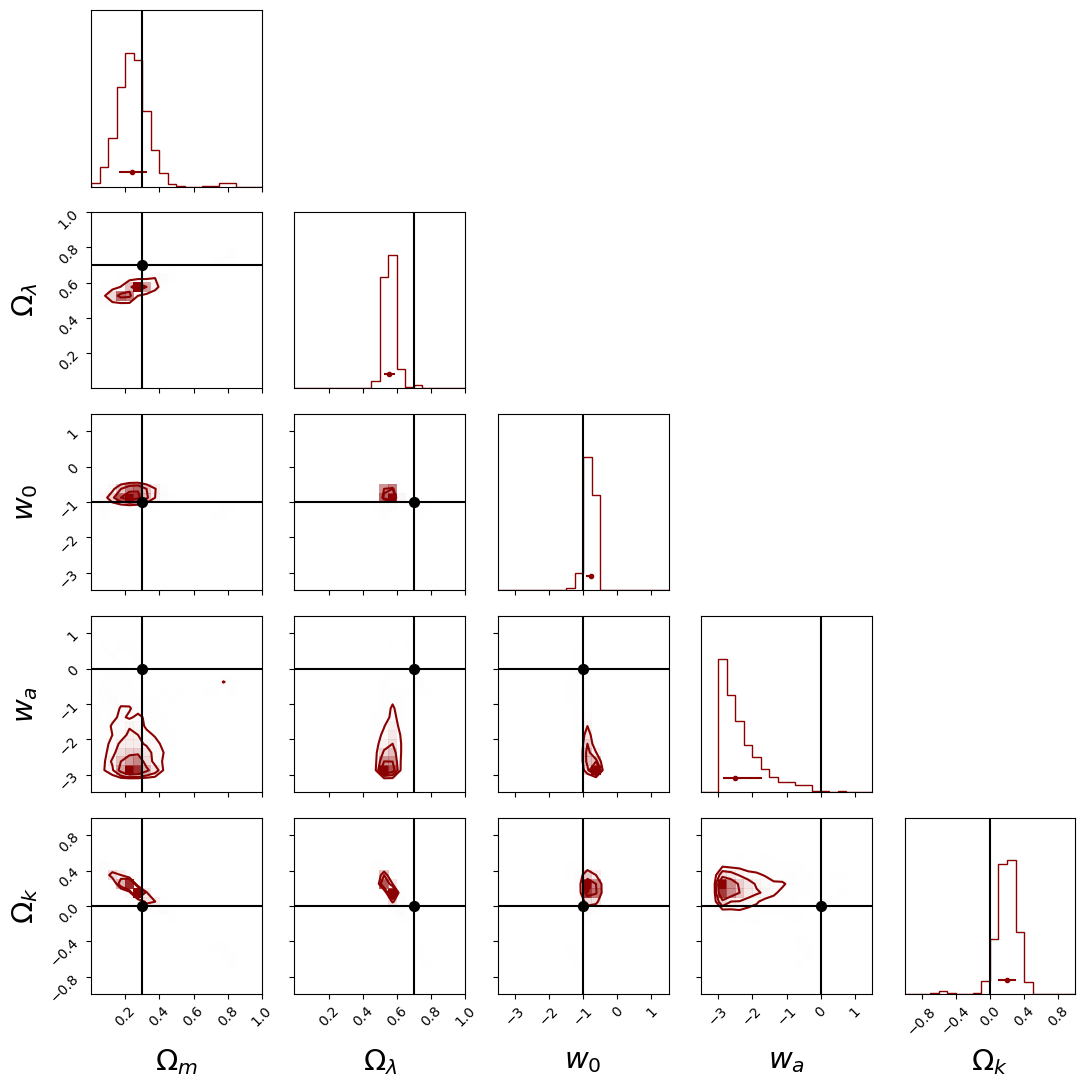

No Sample file Found
Input db file: ./databases/real_paltas_population_TP_100000_FP_100000_Spec_10000_P_0.5_extrem_Part_0_of_2.csv
No Sample file Found
Input db file: ./databases/real_paltas_population_TP_100000_FP_100000_Spec_10000_P_0.5_extrem_Part_0_of_2.csv
Loading mcmc chains from /mnt/extraspace/hollowayp/zBEAMS_data/chains/SL_orig_real_paltas_population_TP_100000_FP_100000_Spec_10000_P_0.5_extrem_Part_0_of_2.csv_ph_True_con_True_wCDM_JAX_chains_7_6_70245_warmup.csv


Making into a list
Keys: ['OM', 'Ode', 'w', 'wa', 'Ok']
NOTE: Need to change this so the bins cover the whole prior:
TRUTH [0.3, 0.7, -1, 0, 0.0]


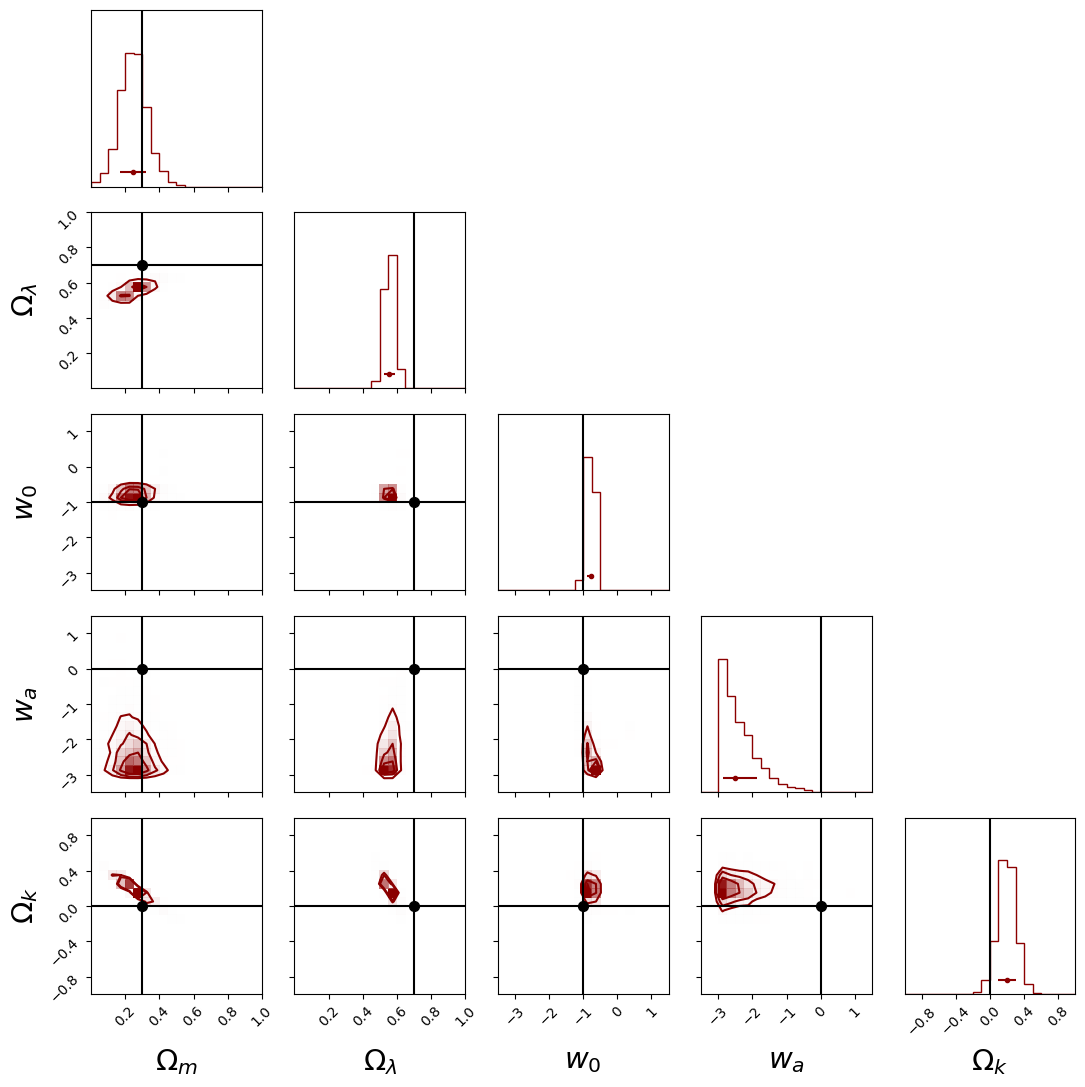

No Sample file Found
Input db file: ./databases/real_paltas_population_TP_100000_FP_100000_Spec_10000_P_0.5_extrem_Part_0_of_2.csv
No Sample file Found
Input db file: ./databases/real_paltas_population_TP_100000_FP_100000_Spec_10000_P_0.5_extrem_Part_0_of_2.csv
Loading mcmc chains from /mnt/extraspace/hollowayp/zBEAMS_data/chains/SL_orig_real_paltas_population_TP_100000_FP_100000_Spec_10000_P_0.5_extrem_Part_0_of_2.csv_ph_True_con_True_wCDM_JAX_chains_2_0_56498_warmup.csv
Making into a list
Keys: ['OM', 'Ode', 'w', 'wa', 'Ok']
NOTE: Need to change this so the bins cover the whole prior:


TRUTH [0.3, 0.7, -1, 0, 0.0]


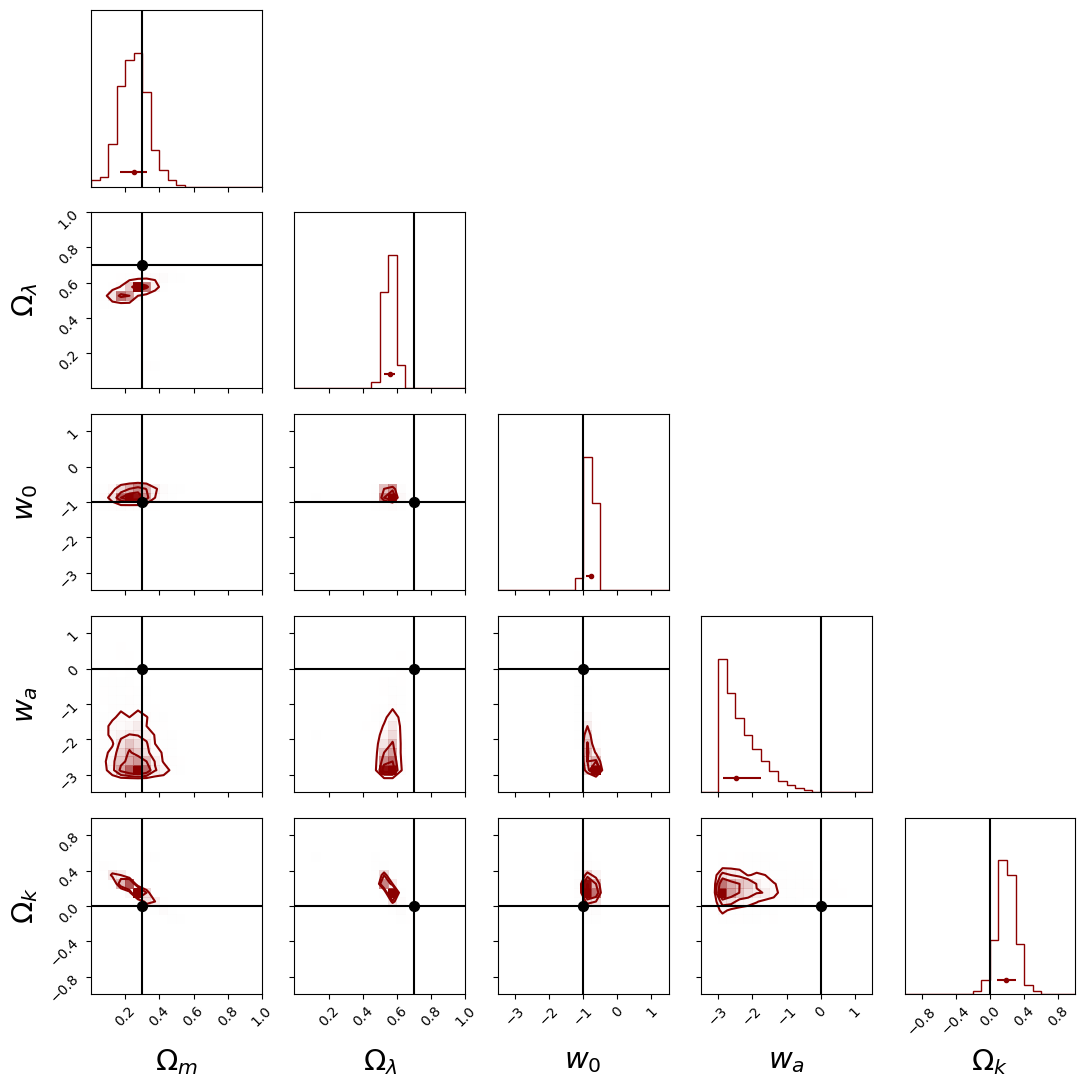

No Sample file Found
Input db file: ./databases/real_paltas_population_TP_100000_FP_100000_Spec_10000_P_0.5_extrem_Part_0_of_2.csv
Loading mcmc chains from /mnt/extraspace/hollowayp/zBEAMS_data/chains/SL_orig_real_paltas_population_TP_100000_FP_100000_Spec_10000_P_0.5_extrem_Part_0_of_2.csv_ph_True_con_True_wCDM_JAX_chains_8_7_21176_warmup.csv


Making into a list
Keys: ['OM', 'Ode', 'w', 'wa', 'Ok']
NOTE: Need to change this so the bins cover the whole prior:
TRUTH [0.3, 0.7, -1, 0, 0.0]


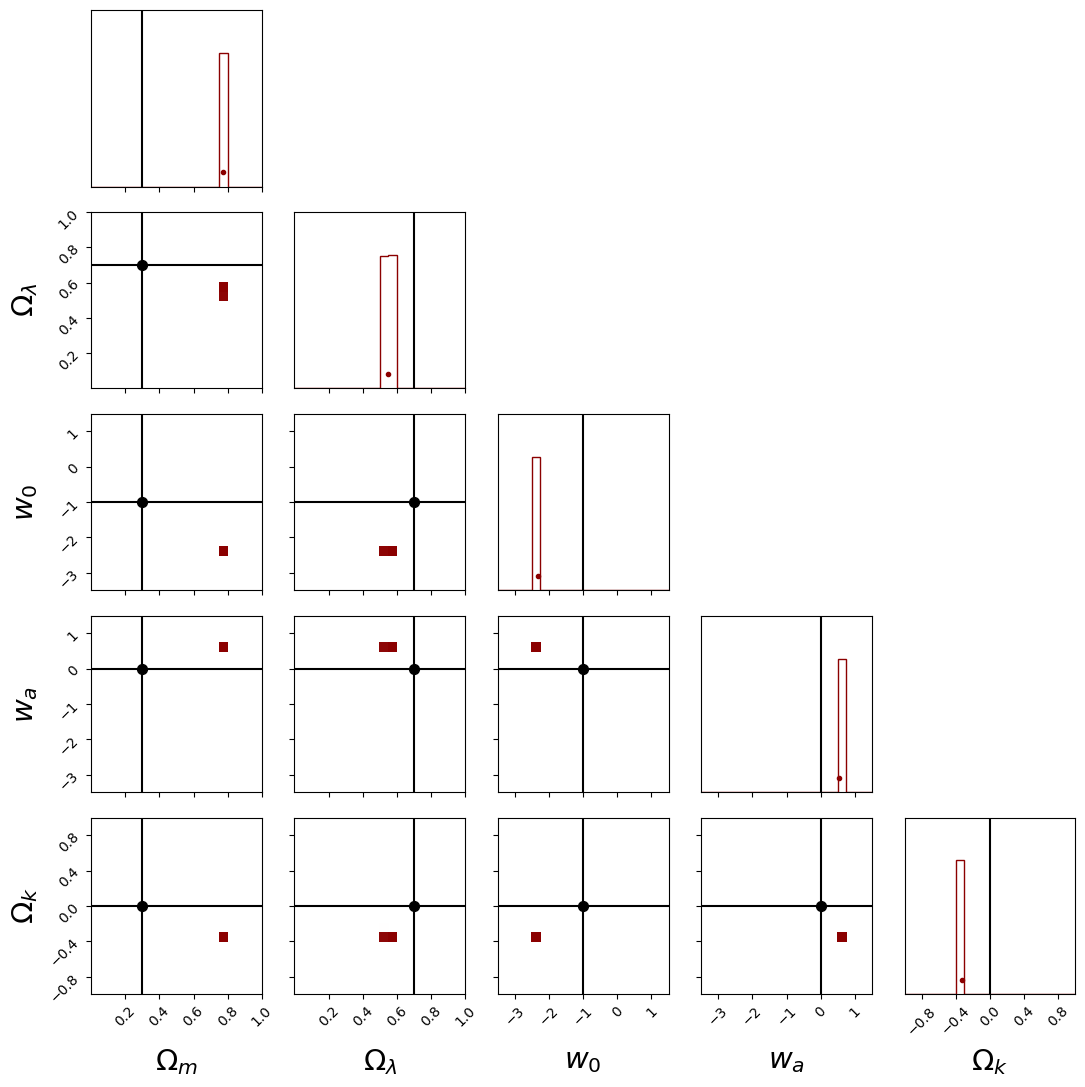

No Sample file Found
Input db file: ./databases/real_paltas_population_TP_100000_FP_100000_Spec_10000_P_0.5_extrem_Part_0_of_2.csv
Loading mcmc chains from /mnt/extraspace/hollowayp/zBEAMS_data/chains/SL_orig_real_paltas_population_TP_100000_FP_100000_Spec_10000_P_0.5_extrem_Part_0_of_2.csv_ph_True_con_True_wCDM_JAX_chains_5_4_29776_warmup.csv


Making into a list
Keys: ['OM', 'Ode', 'w', 'wa', 'Ok']
NOTE: Need to change this so the bins cover the whole prior:
TRUTH [0.3, 0.7, -1, 0, 0.0]


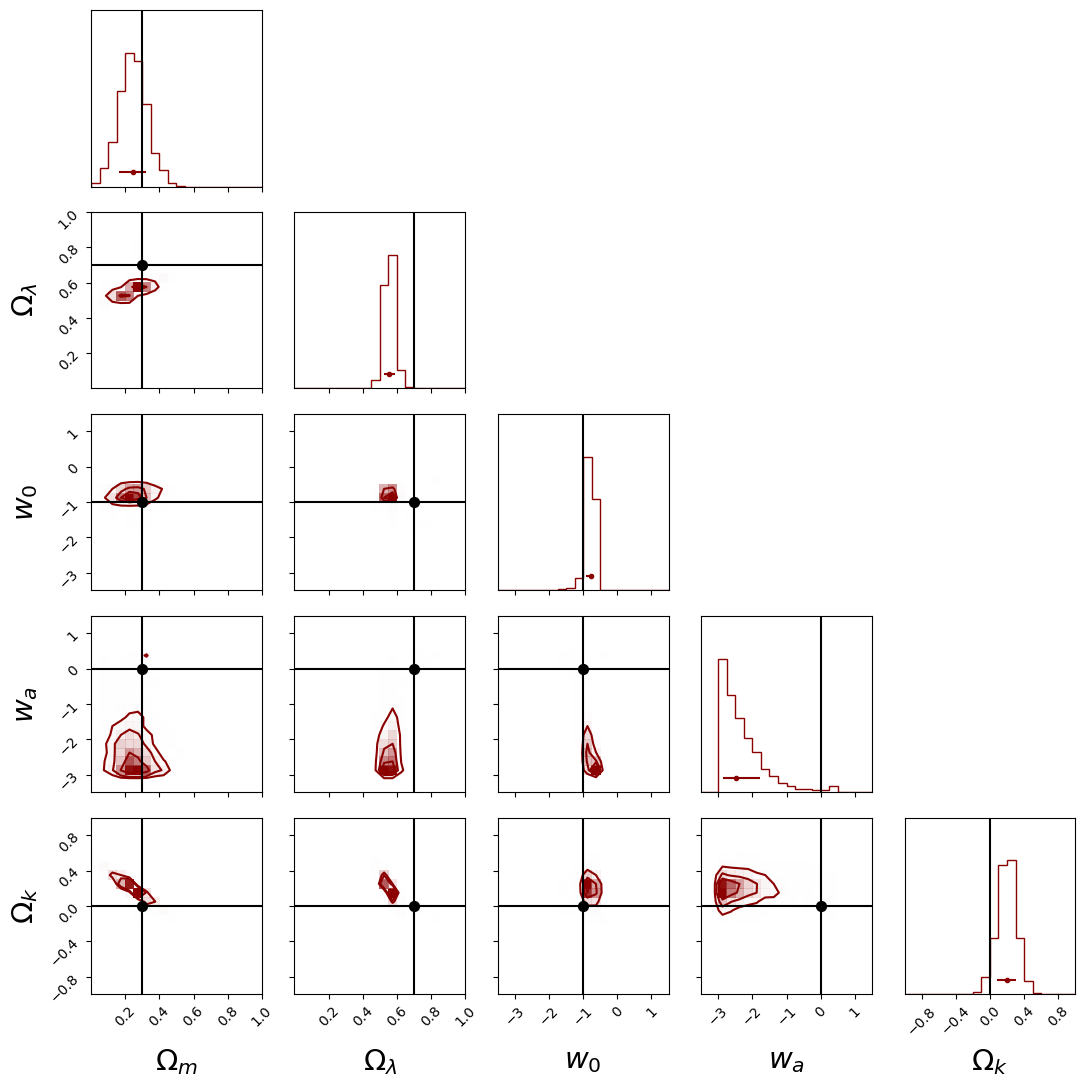

No Sample file Found
Input db file: ./databases/real_paltas_population_TP_100000_FP_100000_Spec_10000_P_0.5_extrem_Part_0_of_2.csv
Loading mcmc chains from /mnt/extraspace/hollowayp/zBEAMS_data/chains/SL_orig_real_paltas_population_TP_100000_FP_100000_Spec_10000_P_0.5_extrem_Part_0_of_2.csv_ph_True_con_True_wCDM_JAX_chains_4_3_67821_warmup.csv
Making into a list
Keys: ['OM', 'Ode', 'w', 'wa', 'Ok']
NOTE: Need to change this so the bins cover the whole prior:


TRUTH [0.3, 0.7, -1, 0, 0.0]


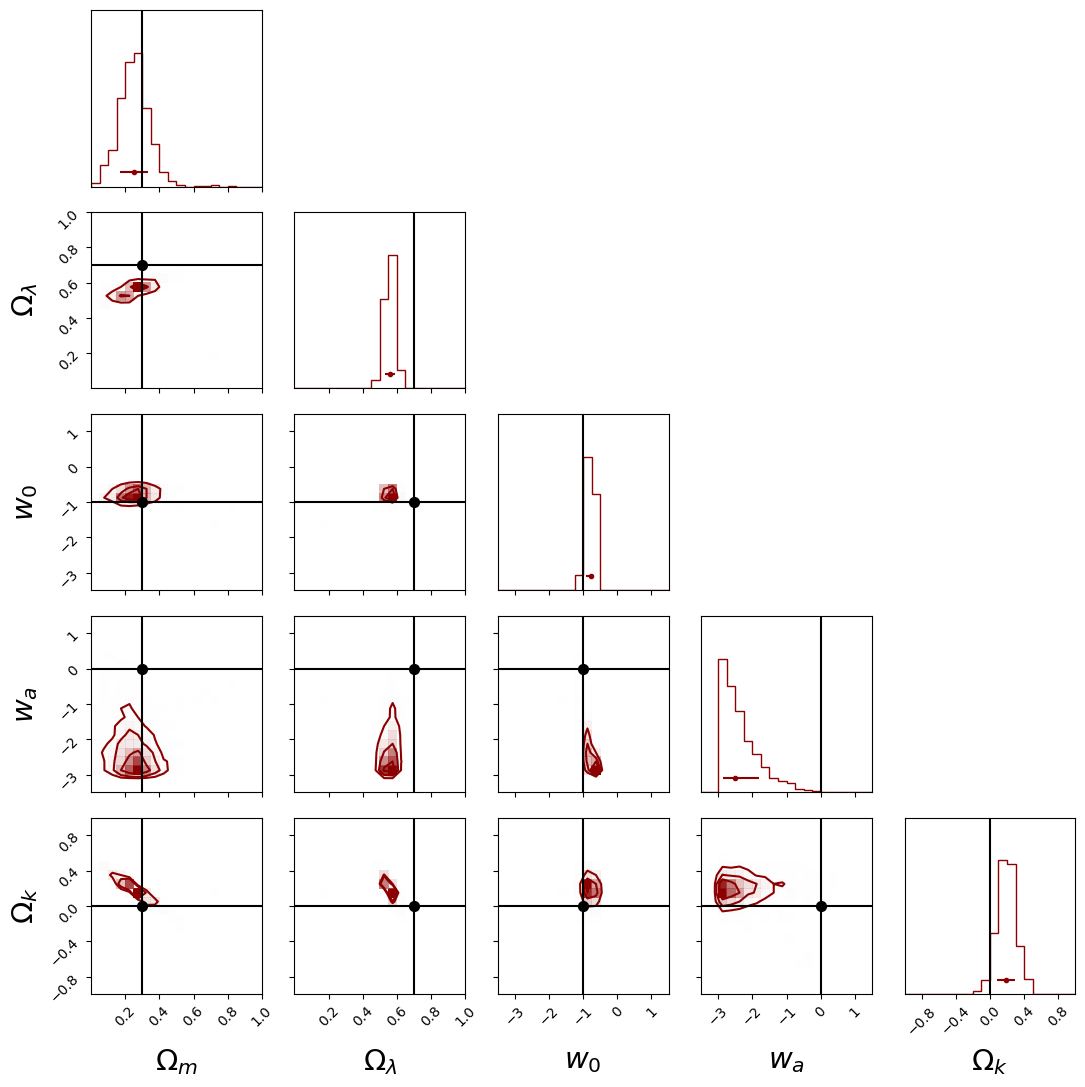

No Sample file Found
Input db file: ./databases/real_paltas_population_TP_100000_FP_100000_Spec_10000_P_0.5_extrem_Part_0_of_2.csv
Loading mcmc chains from /mnt/extraspace/hollowayp/zBEAMS_data/chains/SL_orig_real_paltas_population_TP_100000_FP_100000_Spec_10000_P_0.5_extrem_Part_0_of_2.csv_ph_True_con_True_wCDM_JAX_chains_6_5_92325_warmup.csv


Making into a list
Keys: ['OM', 'Ode', 'w', 'wa', 'Ok']
NOTE: Need to change this so the bins cover the whole prior:
TRUTH [0.3, 0.7, -1, 0, 0.0]


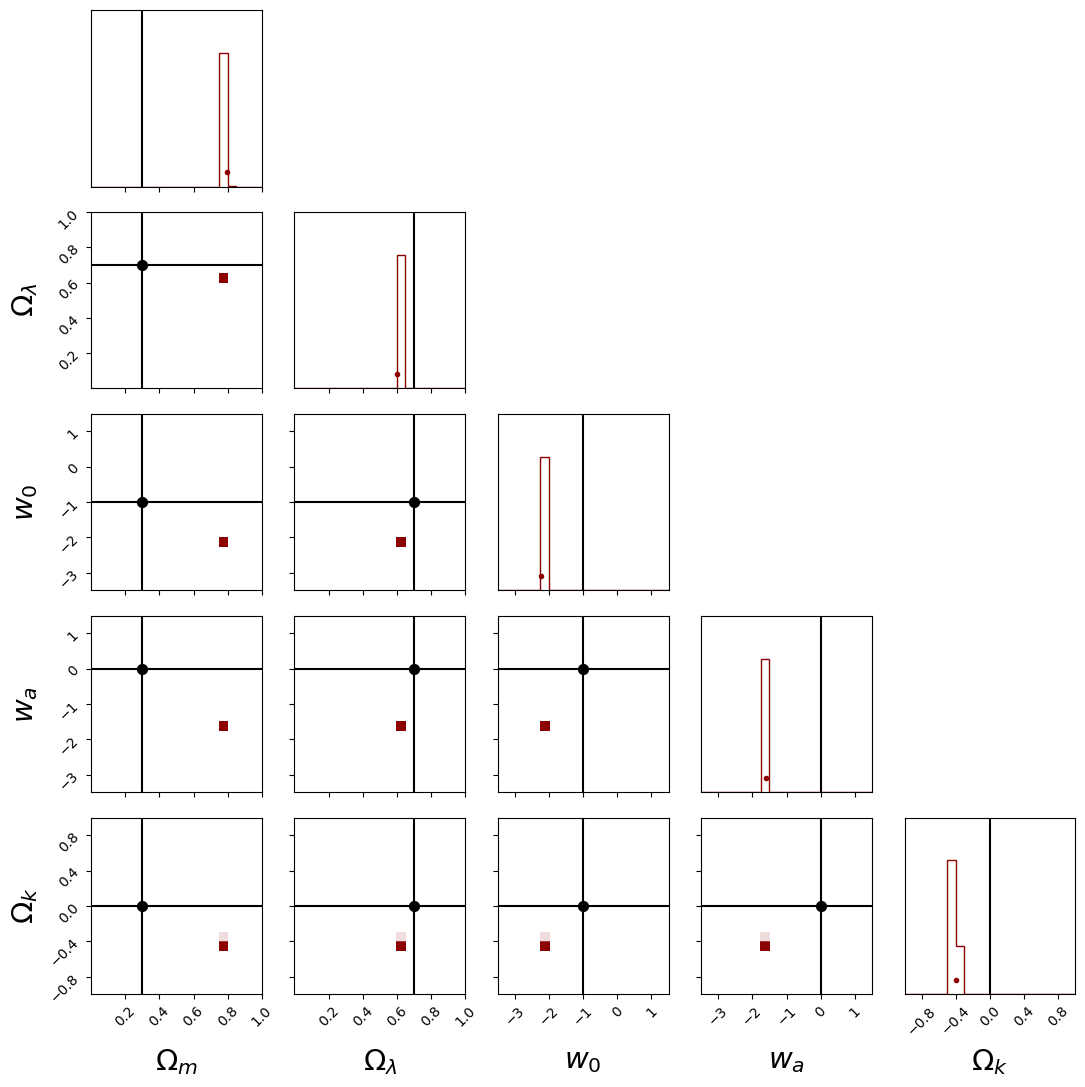

No Sample file Found
Input db file: ./databases/real_paltas_population_TP_100000_FP_100000_Spec_10000_P_0.5_extrem_Part_0_of_2.csv
Loading mcmc chains from /mnt/extraspace/hollowayp/zBEAMS_data/chains/SL_orig_real_paltas_population_TP_100000_FP_100000_Spec_10000_P_0.5_extrem_Part_0_of_2.csv_ph_True_con_True_wCDM_JAX_chains_4_2_92338_warmup.csv


Making into a list
Keys: ['OM', 'Ode', 'w', 'wa', 'Ok']
NOTE: Need to change this so the bins cover the whole prior:
TRUTH [0.3, 0.7, -1, 0, 0.0]


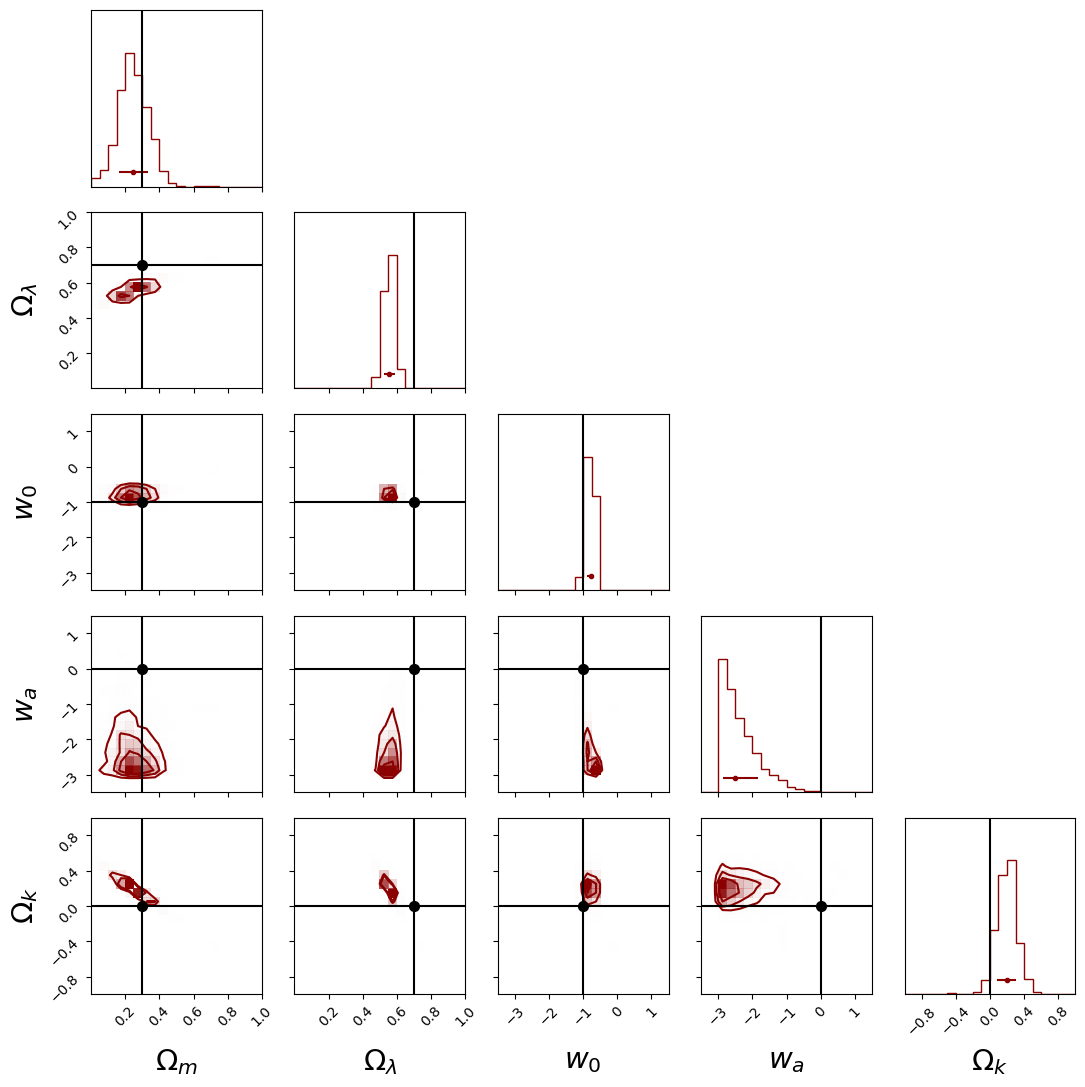

"\nHave shown the JAX and emcee modules give answers in agreement for a very simple cosmology. Need to further\ndemonstrate this with more complex cosmologies (inc w0wa cosmology which emcee doesn't yet have?), but most\nimportantly including contamination + photometry.\n"

In [21]:
def del_chains_in_mcmc(mcmc_dict,exclude):
    print(f'Excluding {exclude} from emcee plots')
    for k_ii in mcmc_dict.keys():
        L = mcmc_dict[k_ii].shape[0]
        mcmc_dict[k_ii]=np.delete(mcmc_dict[k_ii],exclude,axis=0)
        assert mcmc_dict[k_ii].shape[0] == L-len(exclude)
    return mcmc_dict

def plot_emcee_corner(MCMC_chain_dict = {},key_list = [],
                    truth_dict={},range_dict={},label_dict = {},bin_dict = {},
                    burnin=np.nan,exclude=[],add_text=True):
    MCMC_chain_dict = del_chains_in_mcmc(MCMC_chain_dict,exclude)
    if 'Ok' in key_list:
        MCMC_chain_dict['Ok'] = 1-(MCMC_chain_dict['OM']+MCMC_chain_dict['Ode'])
    corner_array = np.array([MCMC_chain_dict[k_i][:,burnin:] for k_i in key_list]).T
    label_list = [label_dict[k_i] for k_i in key_list]
    truth_list = [truth_dict[k_i] for k_i in key_list]
    range_list = [range_dict[k_i] for k_i in key_list]
    #bin_list = [bin_dict[k_i] for k_i in key_list]
    fig,ax = pl.subplots(len(key_list),len(key_list),figsize=(2.2*len(key_list),2.2*len(key_list)))
    corner.corner(corner_array,
                    truths = truth_list,
                    truth_color='k',
                    contour_kwargs = {'colors':'k'},
                    labels = label_list,
                    label_kwargs={'fontsize':18},
                    range = range_list,
                    fig=fig,
                    hist_kwargs={'density':True},
                    plot_datapoints=False)#,show_titles=True)
    for p_i in range(corner_array.shape[2]):
        if add_text: ax[p_i,p_i].text(0,1,percentile_str(corner_array[:,:,p_i]),
                        horizontalalignment='left',
                        verticalalignment='top',
                        color='k',
                        transform=ax[p_i,p_i].transAxes,
                        fontsize=10)
        plot_mu_sig(ax[p_i,p_i],corner_array[:,:,p_i],c='k',y_frac=0.4)
    hist_ylim=[]
    for i in range(len(ax)):
        for j in range(len(ax)):
            if i!=j:
                ax[i,j].set_xlim(ax[j,j].get_xlim())
                ax[i,j].set_ylim(ax[i,i].get_xlim())
            else:
                hist_ylim.append(ax[i,j].get_ylim())
    pl.tight_layout()
    return fig,ax,hist_ylim

# db_emcee = np.load('./chains/SL_orig_real_paltas_population_TP_Large_r_uncert_15000_FP_0_Spec_15000_P_1.0.csv_ph_False_con_False_wCDM_mcmc_chains_1715179304.3239293.npy')
# fig,ax,hist_ylim = plot_emcee_corner(
#     MCMC_chain_dict = {'OM':db_emcee[:,:,0],
#                        'Ode':db_emcee[:,:,1],
#                        'H0':db_emcee[:,:,2],
#                        'w':db_emcee[:,:,3],
#                        'wa':db_emcee[:,:,4]
#     },
#     key_list = ['OM','Ode','w','wa','Ok'],
#     truth_dict = {'OM':Om_fid,'Ode':Ode_fid,'w':w_fid,'wa':wa_fid,'Ok':1-(Om_fid+Ode_fid)},
#     range_dict = range_dict,
#     label_dict = label_dict,
#     add_text=False,
#     #bin_dict = bin_dict,
#     burnin=200,
#     exclude=[])#[0])


for file_i in glob.glob('./python3.11-50k_sample_B0_C*-*.out'):
    try: JAX_chains_i = squash_walkers(summary_plots(file_i).warmup_JAX_chains)
    except: continue
    plot_JAX_corner(
                JAX_chains_i,
                # squash_walkers(JAX_chains),#[5,11,28,43,45,48]),
                # [squash_walkers(chain_dict[k_i],\
                #     exclude=exclude_func(k_i)
                #     )\
                #     for k_i in list(chain_dict.keys())],
                truth_dict = {'OM':0.3,'Ode':0.7,'w':-1,'wa':0,'Ok':1-(Om_fid+Ode_fid)},
                range_dict = range_dict,
                label_dict = label_dict,
                #bin_dict = bin_dict,
                key_list=['OM','Ode','w','wa','Ok'],
                # legend_list = [elem.split('Spec_')[1].split('.csv')[0] for elem in list(chain_dict.keys())],
                # legend_list=['10 FPs','100 FPs','200 FPs','500 FPs'],
                plot_Ok=False,
                # fig=fig,ax=ax,
                burnin=0, #BURNIN SHOULD BE 0 IF USING SQUASH-WALKERS?! AS Otherwise some of the burnin steps are put in the middle? 
#                hist_ylim=hist_ylim
                add_text=False,
                # color_list = ['k','blue']
                )
    pl.show()


'''
Have shown the JAX and emcee modules give answers in agreement for a very simple cosmology. Need to further
demonstrate this with more complex cosmologies (inc w0wa cosmology which emcee doesn't yet have?), but most
importantly including contamination + photometry.
'''

In [ ]:
[elem for elem in JAX_chains_combined.columns if 'w' in elem]

In [ ]:
# JAX_chains_combined = squash_walkers(JAX_chains)
np.mean(JAX_chains_combined['w']),np.std(JAX_chains_combined['w'])

In [ ]:
squash_walkers(JAX_chains)

In [ ]:
chain_dict[list(chain_dict.keys())[1]]

In [ ]:
for elem in range(100):
    pl.errorbar(db_10k['zL_obs'][elem],np.median(JAX_chains[f'zL_{elem}_0'])-db_10k['zL_obs'][elem],
                np.std(JAX_chains[f'zL_{elem}_0']),fmt='.')
pl.plot([0,1.0],[0,0])
pl.show()

In [ ]:
JAX_chains[['zL_0_0','zL_1_0','zL_2_0']]

In [ ]:
db_10k['zL_true']

In [ ]:
from cosmology_JAX import j_r_SL
OM_test = 0.1
H0_test = 70
Ok_test = 0.9
Ob_test = 0
w_test = 4 #-6,4
wa_test = -3 #-3, 1
s8_test = 0.8
n_s_test = 0.9

def r_vector(vector_param,param,cosmo_test_dict):
    cosmo_test_dict = cosmo_test_dict.copy()
    f_list = []
    for param_i in vector_param:
        cosmo_test_dict[param] = param_i
        f_i = (j_r_SL(0.5,0.6,jc.Cosmology(**cosmo_test_dict)))[0]
        f_list.append(f_i)
    return f_list

cosmo_test_dict = {'Omega_c':OM_test,
                    'h':H0_test/100,
                    'Omega_k':Ok_test,
                    'w0':w_test,
                    'Omega_b':Ob_test,
                    'wa':wa_test,
                    'sigma8':s8_test,
                    'n_s':n_s_test}
r_cosmo_list = r_vector(np.linspace(-3,1,10),'wa',cosmo_test_dict)

In [ ]:
r_cosmo_list

In [ ]:
plot_JAX_corner([squash_walkers(JAX_chains,exclude = [  1,2,3]),
                 squash_walkers(JAX_chains,exclude = [0  ,2,3]),
                 squash_walkers(JAX_chains,exclude = [0,1,  3]),
                 squash_walkers(JAX_chains,exclude = [0,1,2, ])],
                truth_dict = {'OM':Om_fid,'Ode':Ode_fid,'w':w_fid,'wa':wa_fid},
                range_dict = range_dict,
                label_dict = label_dict,
                #bin_dict = bin_dict,
                key_list=['OM','Ode'],#['OM','Ode','w','wa'],
                legend_list=[],plot_Ok=False,
#                fig=fig,ax=ax,
                burnin=0,
#                hist_ylim=hist_ylim
                )

pl.show()

In [ ]:
def JAX_samples_to_dict(sampler,separate_keys=False):
    key_list = sampler.get_samples().keys()
    sample_dict = {}
    for k_i in key_list:
        if not separate_keys: 
            assert sampler.get_samples()[k_i].shape[1]==1 and len(sampler.get_samples()[k_i].shape)==2
            sample_dict[k_i] = sampler.get_samples()[k_i].T[0]
        else: 
            print(k_i,sampler.get_samples(True)[k_i].shape)
            if k_i!='Ok': assert sampler.get_samples(True)[k_i].shape[2]==1 and len(sampler.get_samples(True)[k_i].shape)==3
            for c_i in range(sampler.get_samples(True)[k_i].shape[0]):
                try:
                    sample_dict[f'{k_i}_{c_i}'] = sampler.get_samples(True)[k_i][c_i,:,0]
                except:
                    #May require this exception if using FlatwCDM or FlatLambdaCDM
                    assert k_i=='Ok' and len(sampler.get_samples(True)[k_i].shape)==2
                    sample_dict[f'{k_i}_{c_i}'] = sampler.get_samples(True)[k_i][c_i,:]
    return sample_dict



In [13]:
import numpy as np
import jax
import numpyro
from numpyro.infer import MCMC, NUTS
import jax.numpy as jnp
import numpyro.distributions as dist
import multiprocessing
from itertools import product

# Define the model
def gaussian_model(args):
    data,mu,sigma=args
    return jnp.sum(dist.Normal(mu,sigma).log_prob(data))

def gaussian_model_full(data):
    # L=0
    mu = numpyro.sample('mu', dist.Normal(0, 10))
    sigma = numpyro.sample('sigma', dist.HalfNormal(10))
    # mu = mu*jnp.ones(len(data))
    # sigma=sigma*jnp.ones(len(data))
    # jax.debug.print('mu,sigma,{a},{b}',a=mu,b=sigma)
    # data_list = [(data[i],mu[i],sigma[i]) for i in range(len(data))]
    # jax.debug.print('data,{d}',d=data_list)
    # with multiprocessing.Pool() as pool:
    # L = jnp.sum(jax.pmap(gaussian_model)(data))#jnp.array([[1,2,3],[2,3,4]])))
    L = numpyro.factor('L',dist.Normal(mu,sigma).log_prob(data))
    # jax.debug.print('L,{L}',L=L)
    # numpyro.factor("Likelihood",L)

# Generate some synthetic data
np.random.seed(0)
true_mu = 1.0
true_sigma = 2.0
data = np.random.normal(true_mu, true_sigma, size=1000)

# Run the MCMC sampler
nuts_kernel = NUTS(gaussian_model_full)
mcmc = MCMC(nuts_kernel, num_warmup=1000, num_samples=2000)
mcmc.warmup(jax.random.PRNGKey(0), data)
mcmc.post_warmup_state = mcmc.last_state
mcmc.run(mcmc.post_warmup_state.rng_key,data)
# mcmc.run(jax.random.PRNGKey(0), data)#np.array_split(data,3))
mcmc.print_summary()

sample: 100%|██████████| 2000/2000 [00:00<00:00, 4865.56it/s, 3 steps of size 8.50e-01. acc. prob=0.93]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
        mu      0.91      0.06      0.91      0.81      1.02   1108.06      1.00
     sigma      1.98      0.04      1.98      1.91      2.05   2069.20      1.00

Number of divergences: 0


In [4]:
np.array_split(np.arange(10),3)

[array([0, 1, 2, 3]), array([4, 5, 6]), array([7, 8, 9])]

In [ ]:
try: del ndim
except: pass
if contamination_str=='False' and photometric_str=='False':
    ndim = 5 #5 cosmo
elif contamination_str=='True' and photometric_str=='False':
    ndim = 5 #5 cosmo
elif contamination_str=='False' and photometric_str=='True':
    ndim = 9 #5 cosmo, 2 means, 2 sigma
elif contamination_str=='True' and photometric_str=='True':
    ndim = 13 #5 cosmo, 4 means, 4 sigma

chains_db = pd.DataFrame(chains[:,burnin:,:].reshape(-1,ndim),
                columns = ['$\Omega_m$','$\Omega_\Lambda$','$H_0$','$w$','$w_a$']
                +['$\mu_{LgL}$','$\mu_{SgL}$']*(photometric_str=='True')
                +['$\mu_{LgNL}$','$\mu_{SgNL}$']*(photometric_str=='True' and contamination_str=='True')
                +['$\sigma_{LgL}$','$\sigma_{SgL}$']*(photometric_str=='True')
                +['$\sigma_{LgNL}$','$\sigma_{SgNL}$']*(photometric_str=='True' and contamination_str=='True'))

chains_db.describe()#.loc[['count','mean','std']]